In [2]:
import pickle
import pandas as pd
import numpy as np

import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans

import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import datetime as datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import calendar
%matplotlib inline

//anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
df = pd.read_pickle("./preprocessed.pkl")

In [4]:
df.sort_values('date')

date                                          tokenized
66  2018-11-01  audio network appointed todd king west coast k...
65  2018-11-01  big deal publishing group signed deal represen...
64  2018-11-01  youtube global head lyor cohen called implicat...
63  2018-11-01  global acquired digital audio sales division c...
62  2018-11-01  six months time fun games begin anew understan...
..         ...                                                ...
4   2020-03-02  warner group ipo supposed start kicking week c...
3   2020-03-02  amuse fast become recognizable names independe...
2   2020-03-03  independent record company glassnote hired dex...
0   2020-03-03  ralph simon child johannesburg mother gave adv...
1   2020-03-03  well versed subject called fake streams spotif...

[2244 rows x 2 columns]

### Create new df 

In [5]:
data = df['date']

In [6]:
count_df = pd.DataFrame(data, columns = ['date'])

In [7]:
count_df.head(10)

date
0  2020-02-28
1  2020-02-22
2  2020-02-19
3  2020-01-24
4  2019-12-12
5  2019-11-18
6  2019-11-10
7  2019-10-31
8  2019-10-25
9  2019-09-23

In [8]:
count_df['articles'] = df['tokenized']

### Create year and month columns

In [9]:
ser1 = pd.Series(count_df['date']) 
#new = count_df['date'].str.split("-" , n=1, expand = True)
#count_df['year']= new [0]
#count_df['month']= new[1]

count_df['new_date'] = pd.to_datetime(count_df['date']).apply(lambda x:x.strftime('%Y-%m')) # Convert to DateTime and group by month 

In [10]:
count_df.head()

date                                           articles new_date
0  2020-02-28  recent rainy night manhattan kelsea ballerini ...  2020-02
1  2020-02-22  forget minute two men thought sang milli vanil...  2020-02
2  2020-02-19  editors note ongoing series explore best buzzw...  2020-02
3  2020-01-24  continues grow change decided time annual powe...  2020-01
4  2019-12-12  desiree perez coo roc nation typical day desir...  2019-12

### Bag of words

In [9]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(2018)
import nltk
#nltk.download('wordnet')

In [19]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [20]:
text = df['tokenized'].map(preprocess)
text[:10]

0    [recent, rainy, night, manhattan, kelsea, ball...
1    [forget, minute, thought, sang, milli, vanilli...
2    [editors, note, ongoing, series, explore, best...
3    [continues, grow, change, decided, time, annua...
4    [desiree, perez, nation, typical, desiree, per...
5    [digital, data, today, drives, aspect, billion...
6    [august, onerepublic, took, stage, rocks, amph...
7    [hootie, blowfish, thing, clear, broke, turn, ...
8    [kanye, west, starts, conversations, debates, ...
9    [known, oscars, advertising, clio, awards, sal...
Name: tokenized, dtype: object

In [21]:
dictionary = gensim.corpora.Dictionary(text)

2020-05-09 22:39:46,185 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-09 22:39:47,539 : INFO : built Dictionary(34238 unique tokens: ['able', 'absorb', 'acceptable', 'active', 'activity']...) from 2244 documents (total 669296 corpus positions)


In [22]:
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 able
1 absorb
2 acceptable
3 active
4 activity
5 acts
6 adding
7 admits
8 advice
9 afraid
10 airplay


In [23]:
#filtering out words that appear in less than 15 docs or more than 50% of docs
#keep only the 100000 most frequent words
dictionary.filter_extremes(no_below=15, no_above=50, keep_n=100000)

2020-05-09 22:41:25,506 : INFO : discarding 29596 tokens: [('absorb', 5), ('acceptable', 6), ('admits', 9), ('answers', 13), ('archway', 1), ('boldest', 5), ('bottle', 7), ('bubbly', 3), ('caption', 4), ('cheer', 9)]...
2020-05-09 22:41:25,509 : INFO : keeping 4642 tokens which were in no less than 15 and no more than 112200 (=5000.0%) documents
2020-05-09 22:41:25,552 : INFO : resulting dictionary: Dictionary(4642 unique tokens: ['able', 'active', 'activity', 'acts', 'adding']...)


### Gensim doc2bow

In [24]:
bow_corpus = [dictionary.doc2bow(doc) for doc in text]
bow_corpus[2000]

[(0, 4),
 (8, 8),
 (17, 2),
 (18, 1),
 (22, 1),
 (23, 2),
 (24, 2),
 (28, 6),
 (30, 1),
 (35, 3),
 (38, 1),
 (41, 3),
 (46, 3),
 (48, 1),
 (51, 1),
 (56, 1),
 (57, 1),
 (59, 1),
 (61, 1),
 (68, 12),
 (69, 1),
 (71, 1),
 (73, 2),
 (75, 1),
 (80, 1),
 (81, 2),
 (84, 1),
 (85, 1),
 (87, 1),
 (88, 1),
 (90, 2),
 (91, 2),
 (96, 5),
 (97, 1),
 (102, 2),
 (110, 2),
 (114, 4),
 (115, 1),
 (119, 1),
 (120, 2),
 (122, 2),
 (126, 1),
 (138, 1),
 (143, 3),
 (144, 1),
 (145, 4),
 (146, 1),
 (147, 3),
 (152, 1),
 (155, 1),
 (158, 3),
 (161, 2),
 (162, 3),
 (169, 3),
 (171, 3),
 (177, 2),
 (185, 1),
 (186, 5),
 (191, 1),
 (196, 2),
 (200, 1),
 (201, 1),
 (202, 1),
 (203, 1),
 (216, 19),
 (217, 1),
 (218, 2),
 (219, 1),
 (223, 4),
 (228, 1),
 (229, 1),
 (231, 1),
 (233, 1),
 (235, 1),
 (237, 1),
 (240, 1),
 (241, 1),
 (245, 2),
 (250, 2),
 (252, 1),
 (269, 2),
 (270, 6),
 (271, 1),
 (275, 1),
 (279, 1),
 (280, 4),
 (281, 1),
 (285, 7),
 (293, 1),
 (295, 4),
 (298, 1),
 (302, 5),
 (307, 5),
 (308, 2),


In [25]:
#preview bag of words for the processed doc
bow_doc_2000 = bow_corpus[2000]
for i in range(len(bow_doc_2000)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2000[i][0], 
                                               dictionary[bow_doc_2000[i][0]], 
bow_doc_2000[i][1]))

Word 0 ("able") appears 4 time.
Word 8 ("album") appears 8 time.
Word 17 ("artist") appears 2 time.
Word 18 ("artwork") appears 1 time.
Word 22 ("basis") appears 1 time.
Word 23 ("best") appears 2 time.
Word 24 ("biggest") appears 2 time.
Word 28 ("brand") appears 6 time.
Word 30 ("brothers") appears 1 time.
Word 35 ("career") appears 3 time.
Word 38 ("challenge") appears 1 time.
Word 41 ("chart") appears 3 time.
Word 46 ("club") appears 3 time.
Word 48 ("comes") appears 1 time.
Word 51 ("completely") appears 1 time.
Word 56 ("content") appears 1 time.
Word 57 ("cool") appears 1 time.
Word 59 ("country") appears 1 time.
Word 61 ("course") appears 1 time.
Word 68 ("dance") appears 12 time.
Word 69 ("debuted") appears 1 time.
Word 71 ("design") appears 1 time.
Word 73 ("digital") appears 2 time.
Word 75 ("direct") appears 1 time.
Word 80 ("encouraging") appears 1 time.
Word 81 ("ended") appears 2 time.
Word 84 ("entertainment") appears 1 time.
Word 85 ("especially") appears 1 time.
Word 

## Restart here

In [2]:
#adapting code from 
#https://github.com/bensjx/Topic-Over-Time-LDA/blob/master/topic-over-time-lda.ipynb

### generate dictionary & corpus

In [27]:
dic = gensim.corpora.Dictionary(text) # Associate words to a numeric ID
#dic.filter_extremes(no_below=0.1*dic.num_docs, no_above=0.9) # Filter out extreme values: token should appear between 10% to 90% of the corpus
corpus = [dic.doc2bow(doc) for doc in text]
print('Number of unique tokens: %d' % len(dic))
print('Number of documents: %d' % len(corpus))

2020-05-09 22:43:01,405 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-05-09 22:43:02,728 : INFO : built Dictionary(34238 unique tokens: ['able', 'absorb', 'acceptable', 'active', 'activity']...) from 2244 documents (total 669296 corpus positions)


Number of unique tokens: 34238
Number of documents: 2244


### Elbow plot to find optimal number of topics

2020-05-09 22:43:07,647 : INFO : using symmetric alpha at 0.5
2020-05-09 22:43:07,652 : INFO : using symmetric eta at 0.5
2020-05-09 22:43:07,669 : INFO : using serial LDA version on this node
2020-05-09 22:43:08,232 : INFO : running online (multi-pass) LDA training, 2 topics, 100 passes over the supplied corpus of 2244 documents, updating model once every 2000 documents, evaluating perplexity every 2244 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-09 22:43:08,234 : INFO : PROGRESS: pass 0, at document #2000/2244
2020-05-09 22:43:12,881 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:43:12,912 : INFO : topic #0 (0.500): 0.006*"year" + 0.006*"spotify" + 0.005*"company" + 0.004*"industry" + 0.004*"artist" + 0.004*"group" + 0.004*"global" + 0.004*"people" + 0.004*"work" + 0.003*"years"
2020-05-09 22:43:12,915 : INFO : topic #1 (0.500): 0.007*"company" + 0.006*"year" + 0.005*"artist" + 0.004*"spotify" + 0.004*"worldwide

2020-05-09 22:43:50,827 : INFO : topic #1 (0.500): 0.007*"company" + 0.005*"worldwide" + 0.005*"year" + 0.005*"global" + 0.005*"group" + 0.005*"artist" + 0.004*"team" + 0.004*"digital" + 0.003*"songs" + 0.003*"million"
2020-05-09 22:43:50,829 : INFO : topic diff=0.263677, rho=0.374713
2020-05-09 22:43:51,785 : INFO : -8.231 per-word bound, 300.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:43:51,786 : INFO : PROGRESS: pass 5, at document #2244/2244
2020-05-09 22:43:52,231 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:43:52,238 : INFO : topic #0 (0.500): 0.007*"spotify" + 0.006*"people" + 0.005*"time" + 0.005*"year" + 0.005*"artist" + 0.005*"label" + 0.005*"company" + 0.004*"industry" + 0.004*"work" + 0.004*"years"
2020-05-09 22:43:52,240 : INFO : topic #1 (0.500): 0.007*"company" + 0.006*"worldwide" + 0.005*"global" + 0.005*"year" + 0.005*"group" + 0.005*"artist" + 0.005*"team" + 0.004*"songs" 

2020-05-09 22:44:21,758 : INFO : topic #1 (0.500): 0.007*"company" + 0.006*"worldwide" + 0.005*"global" + 0.005*"year" + 0.005*"group" + 0.005*"team" + 0.005*"artist" + 0.004*"digital" + 0.004*"songs" + 0.004*"sony"
2020-05-09 22:44:21,759 : INFO : topic diff=0.179556, rho=0.287219
2020-05-09 22:44:21,762 : INFO : PROGRESS: pass 11, at document #2000/2244
2020-05-09 22:44:25,491 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:44:25,498 : INFO : topic #0 (0.500): 0.007*"spotify" + 0.006*"people" + 0.005*"time" + 0.005*"year" + 0.005*"artist" + 0.004*"industry" + 0.004*"label" + 0.004*"company" + 0.004*"years" + 0.004*"work"
2020-05-09 22:44:25,501 : INFO : topic #1 (0.500): 0.007*"company" + 0.006*"worldwide" + 0.005*"global" + 0.005*"year" + 0.005*"group" + 0.005*"team" + 0.004*"artist" + 0.004*"digital" + 0.004*"president" + 0.003*"sony"
2020-05-09 22:44:25,502 : INFO : topic diff=0.173834, rho=0.276058
2020-05-09 22:44:26,570 : INFO : -8.217 

2020-05-09 22:44:57,672 : INFO : topic diff=0.142037, rho=0.234908
2020-05-09 22:44:58,868 : INFO : -8.211 per-word bound, 296.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:44:58,869 : INFO : PROGRESS: pass 16, at document #2244/2244
2020-05-09 22:44:59,452 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:44:59,459 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"time" + 0.005*"year" + 0.005*"artist" + 0.004*"label" + 0.004*"company" + 0.004*"industry" + 0.004*"work" + 0.004*"years"
2020-05-09 22:44:59,462 : INFO : topic #1 (0.500): 0.007*"company" + 0.006*"worldwide" + 0.005*"global" + 0.005*"group" + 0.005*"year" + 0.005*"team" + 0.004*"artist" + 0.004*"digital" + 0.004*"sony" + 0.004*"president"
2020-05-09 22:44:59,465 : INFO : topic diff=0.140210, rho=0.234908
2020-05-09 22:44:59,468 : INFO : PROGRESS: pass 17, at document #2000/2244
2020-05-09 22:45:04,454 : INFO : mergin

2020-05-09 22:45:33,958 : INFO : topic diff=0.121383, rho=0.207964
2020-05-09 22:45:33,960 : INFO : PROGRESS: pass 22, at document #2000/2244
2020-05-09 22:45:38,456 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:45:38,462 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"time" + 0.006*"year" + 0.005*"artist" + 0.004*"industry" + 0.004*"label" + 0.004*"company" + 0.004*"streaming" + 0.004*"years"
2020-05-09 22:45:38,464 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.006*"global" + 0.005*"group" + 0.005*"year" + 0.005*"team" + 0.004*"artist" + 0.004*"digital" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:45:38,465 : INFO : topic diff=0.119473, rho=0.203607
2020-05-09 22:45:39,555 : INFO : -8.207 per-word bound, 295.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:45:39,556 : INFO : PROGRESS: pass 22, at document #2244/2244
2020-05-09 22:45:40,197 : INFO : 

2020-05-09 22:46:10,011 : INFO : topic diff=0.106990, rho=0.185306
2020-05-09 22:46:10,974 : INFO : -8.205 per-word bound, 295.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:46:10,975 : INFO : PROGRESS: pass 27, at document #2244/2244
2020-05-09 22:46:11,419 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:46:11,426 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"time" + 0.005*"year" + 0.005*"artist" + 0.004*"label" + 0.004*"company" + 0.004*"industry" + 0.004*"streaming" + 0.004*"record"
2020-05-09 22:46:11,429 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.005*"global" + 0.005*"group" + 0.005*"year" + 0.005*"team" + 0.004*"digital" + 0.004*"artist" + 0.004*"sony" + 0.004*"president"
2020-05-09 22:46:11,431 : INFO : topic diff=0.106199, rho=0.185306
2020-05-09 22:46:11,434 : INFO : PROGRESS: pass 28, at document #2000/2244
2020-05-09 22:46:14,963 : INFO : 

2020-05-09 22:46:38,613 : INFO : topic diff=0.097063, rho=0.171192
2020-05-09 22:46:38,615 : INFO : PROGRESS: pass 33, at document #2000/2244
2020-05-09 22:46:43,156 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:46:43,162 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"year" + 0.006*"time" + 0.005*"artist" + 0.004*"label" + 0.004*"industry" + 0.004*"streaming" + 0.004*"company" + 0.004*"record"
2020-05-09 22:46:43,165 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.006*"global" + 0.005*"group" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:46:43,167 : INFO : topic diff=0.095855, rho=0.168737
2020-05-09 22:46:44,299 : INFO : -8.202 per-word bound, 294.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:46:44,301 : INFO : PROGRESS: pass 33, at document #2244/2244
2020-05-09 22:46:44,817 : INFO :

2020-05-09 22:47:14,107 : INFO : topic diff=0.088685, rho=0.157873
2020-05-09 22:47:15,215 : INFO : -8.200 per-word bound, 294.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:47:15,217 : INFO : PROGRESS: pass 38, at document #2244/2244
2020-05-09 22:47:16,503 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:47:16,515 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"time" + 0.006*"year" + 0.005*"artist" + 0.004*"label" + 0.004*"company" + 0.004*"streaming" + 0.004*"industry" + 0.004*"record"
2020-05-09 22:47:16,521 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.005*"group" + 0.005*"global" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"sony" + 0.004*"president"
2020-05-09 22:47:16,528 : INFO : topic diff=0.088419, rho=0.157873
2020-05-09 22:47:16,532 : INFO : PROGRESS: pass 39, at document #2000/2244
2020-05-09 22:47:20,749 : INFO : 

2020-05-09 22:47:47,473 : INFO : topic diff=0.082717, rho=0.148870
2020-05-09 22:47:47,475 : INFO : PROGRESS: pass 44, at document #2000/2244
2020-05-09 22:47:52,357 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:47:52,364 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"year" + 0.006*"time" + 0.005*"artist" + 0.004*"streaming" + 0.004*"company" + 0.004*"label" + 0.004*"industry" + 0.004*"record"
2020-05-09 22:47:52,366 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.005*"global" + 0.005*"group" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:47:52,368 : INFO : topic diff=0.081895, rho=0.147247
2020-05-09 22:47:53,411 : INFO : -8.198 per-word bound, 293.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:47:53,412 : INFO : PROGRESS: pass 44, at document #2244/2244
2020-05-09 22:47:53,963 : INFO :

2020-05-09 22:48:20,825 : INFO : topic diff=0.077269, rho=0.139861
2020-05-09 22:48:21,733 : INFO : -8.197 per-word bound, 293.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:48:21,734 : INFO : PROGRESS: pass 49, at document #2244/2244
2020-05-09 22:48:22,160 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:48:22,166 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"year" + 0.006*"time" + 0.005*"artist" + 0.004*"label" + 0.004*"company" + 0.004*"streaming" + 0.004*"record" + 0.004*"industry"
2020-05-09 22:48:22,169 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.005*"group" + 0.005*"global" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:48:22,170 : INFO : topic diff=0.077007, rho=0.139861
2020-05-09 22:48:22,172 : INFO : PROGRESS: pass 50, at document #2000/2244
2020-05-09 22:48:26,278 : INFO : 

2020-05-09 22:48:50,802 : INFO : topic diff=0.073031, rho=0.133485
2020-05-09 22:48:50,804 : INFO : PROGRESS: pass 55, at document #2000/2244
2020-05-09 22:48:54,629 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:48:54,636 : INFO : topic #0 (0.500): 0.009*"spotify" + 0.006*"people" + 0.006*"year" + 0.006*"time" + 0.005*"artist" + 0.004*"streaming" + 0.004*"company" + 0.004*"label" + 0.004*"industry" + 0.004*"record"
2020-05-09 22:48:54,638 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.005*"global" + 0.005*"group" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:48:54,640 : INFO : topic diff=0.072584, rho=0.132312
2020-05-09 22:48:55,687 : INFO : -8.196 per-word bound, 293.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:48:55,688 : INFO : PROGRESS: pass 55, at document #2244/2244
2020-05-09 22:48:56,123 : INFO :

2020-05-09 22:49:23,945 : INFO : topic diff=0.069323, rho=0.126875
2020-05-09 22:49:24,964 : INFO : -8.196 per-word bound, 293.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:49:24,965 : INFO : PROGRESS: pass 60, at document #2244/2244
2020-05-09 22:49:25,436 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:49:25,442 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"year" + 0.006*"time" + 0.005*"artist" + 0.004*"company" + 0.004*"streaming" + 0.004*"label" + 0.004*"record" + 0.004*"industry"
2020-05-09 22:49:25,445 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.005*"group" + 0.005*"global" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:49:25,446 : INFO : topic diff=0.069074, rho=0.126875
2020-05-09 22:49:25,449 : INFO : PROGRESS: pass 61, at document #2000/2244
2020-05-09 22:49:29,454 : INFO : 

2020-05-09 22:49:55,917 : INFO : topic diff=0.066215, rho=0.122058
2020-05-09 22:49:55,920 : INFO : PROGRESS: pass 66, at document #2000/2244
2020-05-09 22:50:00,613 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:50:00,621 : INFO : topic #0 (0.500): 0.009*"spotify" + 0.006*"people" + 0.006*"year" + 0.006*"time" + 0.005*"artist" + 0.004*"streaming" + 0.004*"company" + 0.004*"label" + 0.004*"industry" + 0.004*"record"
2020-05-09 22:50:00,624 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.005*"global" + 0.005*"group" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:50:00,630 : INFO : topic diff=0.065903, rho=0.121159
2020-05-09 22:50:01,569 : INFO : -8.195 per-word bound, 293.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:50:01,570 : INFO : PROGRESS: pass 66, at document #2244/2244
2020-05-09 22:50:02,010 : INFO :

2020-05-09 22:50:29,006 : INFO : topic diff=0.063402, rho=0.116943
2020-05-09 22:50:30,085 : INFO : -8.195 per-word bound, 293.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:50:30,086 : INFO : PROGRESS: pass 71, at document #2244/2244
2020-05-09 22:50:30,767 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:50:30,778 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"year" + 0.006*"time" + 0.005*"artist" + 0.004*"streaming" + 0.004*"company" + 0.004*"label" + 0.004*"industry" + 0.004*"record"
2020-05-09 22:50:30,781 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.006*"group" + 0.005*"global" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:50:30,786 : INFO : topic diff=0.063203, rho=0.116943
2020-05-09 22:50:30,789 : INFO : PROGRESS: pass 72, at document #2000/2244
2020-05-09 22:50:35,111 : INFO : 

2020-05-09 22:51:05,792 : INFO : topic diff=0.060992, rho=0.113139
2020-05-09 22:51:05,798 : INFO : PROGRESS: pass 77, at document #2000/2244
2020-05-09 22:51:09,754 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:51:09,765 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"year" + 0.005*"time" + 0.005*"artist" + 0.004*"streaming" + 0.004*"company" + 0.004*"label" + 0.004*"industry" + 0.004*"record"
2020-05-09 22:51:09,770 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.006*"global" + 0.006*"group" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:51:09,773 : INFO : topic diff=0.060751, rho=0.112422
2020-05-09 22:51:10,801 : INFO : -8.194 per-word bound, 292.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:51:10,802 : INFO : PROGRESS: pass 77, at document #2244/2244
2020-05-09 22:51:11,246 : INFO :

2020-05-09 22:51:37,206 : INFO : topic diff=0.058752, rho=0.109030
2020-05-09 22:51:38,143 : INFO : -8.194 per-word bound, 292.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:51:38,144 : INFO : PROGRESS: pass 82, at document #2244/2244
2020-05-09 22:51:38,568 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:51:38,576 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"year" + 0.006*"time" + 0.005*"artist" + 0.004*"streaming" + 0.004*"company" + 0.004*"label" + 0.004*"industry" + 0.004*"record"
2020-05-09 22:51:38,579 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.006*"group" + 0.006*"global" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:51:38,582 : INFO : topic diff=0.058578, rho=0.109030
2020-05-09 22:51:38,585 : INFO : PROGRESS: pass 83, at document #2000/2244
2020-05-09 22:51:42,060 : INFO : 

2020-05-09 22:52:12,578 : INFO : topic diff=0.056781, rho=0.105927
2020-05-09 22:52:12,586 : INFO : PROGRESS: pass 88, at document #2000/2244
2020-05-09 22:52:16,241 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:52:16,248 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"year" + 0.006*"people" + 0.005*"time" + 0.005*"artist" + 0.004*"streaming" + 0.004*"company" + 0.004*"label" + 0.004*"industry" + 0.004*"record"
2020-05-09 22:52:16,251 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.006*"group" + 0.006*"global" + 0.005*"team" + 0.005*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:52:16,256 : INFO : topic diff=0.056604, rho=0.105338
2020-05-09 22:52:17,217 : INFO : -8.194 per-word bound, 292.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:52:17,218 : INFO : PROGRESS: pass 88, at document #2244/2244
2020-05-09 22:52:17,649 : INFO :

2020-05-09 22:52:44,463 : INFO : topic diff=0.054994, rho=0.102532
2020-05-09 22:52:45,542 : INFO : -8.194 per-word bound, 292.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:52:45,543 : INFO : PROGRESS: pass 93, at document #2244/2244
2020-05-09 22:52:45,989 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:52:45,997 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"people" + 0.006*"year" + 0.005*"time" + 0.005*"artist" + 0.004*"streaming" + 0.004*"company" + 0.004*"label" + 0.004*"industry" + 0.004*"record"
2020-05-09 22:52:46,000 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.006*"group" + 0.006*"global" + 0.005*"team" + 0.004*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"sony"
2020-05-09 22:52:46,002 : INFO : topic diff=0.054867, rho=0.102532
2020-05-09 22:52:46,004 : INFO : PROGRESS: pass 94, at document #2000/2244
2020-05-09 22:52:49,789 : INFO : 

2020-05-09 22:53:13,489 : INFO : topic diff=0.053438, rho=0.099939
2020-05-09 22:53:13,492 : INFO : PROGRESS: pass 99, at document #2000/2244
2020-05-09 22:53:17,475 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:53:17,482 : INFO : topic #0 (0.500): 0.008*"spotify" + 0.006*"year" + 0.006*"people" + 0.005*"time" + 0.005*"artist" + 0.005*"streaming" + 0.004*"company" + 0.004*"industry" + 0.004*"label" + 0.004*"record"
2020-05-09 22:53:17,484 : INFO : topic #1 (0.500): 0.008*"company" + 0.006*"worldwide" + 0.006*"group" + 0.006*"global" + 0.005*"team" + 0.004*"year" + 0.004*"digital" + 0.004*"artist" + 0.004*"president" + 0.004*"marketing"
2020-05-09 22:53:17,486 : INFO : topic diff=0.053261, rho=0.099444
2020-05-09 22:53:18,537 : INFO : -8.193 per-word bound, 292.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:53:18,538 : INFO : PROGRESS: pass 99, at document #2244/2244
2020-05-09 22:53:18,958 : I

2020-05-09 22:53:41,318 : INFO : topic #2 (0.333): 0.008*"spotify" + 0.005*"year" + 0.005*"company" + 0.004*"industry" + 0.004*"artist" + 0.004*"streaming" + 0.004*"digital" + 0.004*"worldwide" + 0.003*"people" + 0.003*"world"
2020-05-09 22:53:41,322 : INFO : topic diff=1.062963, rho=0.707107
2020-05-09 22:53:41,323 : INFO : PROGRESS: pass 1, at document #2000/2244
2020-05-09 22:53:47,142 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:53:47,151 : INFO : topic #0 (0.333): 0.006*"people" + 0.005*"time" + 0.005*"company" + 0.005*"year" + 0.005*"artist" + 0.004*"work" + 0.004*"years" + 0.004*"label" + 0.004*"team" + 0.004*"group"
2020-05-09 22:53:47,153 : INFO : topic #1 (0.333): 0.007*"company" + 0.006*"artist" + 0.005*"year" + 0.005*"worldwide" + 0.005*"global" + 0.004*"group" + 0.004*"team" + 0.004*"time" + 0.004*"songs" + 0.004*"label"
2020-05-09 22:53:47,159 : INFO : topic #2 (0.333): 0.009*"spotify" + 0.006*"year" + 0.005*"company" + 0.005*"

2020-05-09 22:54:11,432 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.006*"artist" + 0.006*"label" + 0.005*"work" + 0.005*"going" + 0.005*"records" + 0.005*"years" + 0.004*"record" + 0.004*"think"
2020-05-09 22:54:11,435 : INFO : topic #1 (0.333): 0.008*"company" + 0.006*"team" + 0.006*"group" + 0.006*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.005*"year" + 0.005*"president" + 0.004*"songs" + 0.004*"publishing"
2020-05-09 22:54:11,437 : INFO : topic #2 (0.333): 0.011*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"industry" + 0.005*"content" + 0.005*"digital" + 0.004*"platform" + 0.004*"worldwide" + 0.004*"services"
2020-05-09 22:54:11,439 : INFO : topic diff=0.251494, rho=0.374713
2020-05-09 22:54:12,428 : INFO : -8.123 per-word bound, 278.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:54:12,429 : INFO : PROGRESS: pass 5, at document #2244/2244
2020-05-09 22:54:12,923 : INFO : merging change

2020-05-09 22:54:35,175 : INFO : topic #2 (0.333): 0.011*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"industry" + 0.005*"digital" + 0.004*"platform" + 0.004*"worldwide" + 0.004*"market"
2020-05-09 22:54:35,176 : INFO : topic diff=0.176616, rho=0.299853
2020-05-09 22:54:36,235 : INFO : -8.108 per-word bound, 275.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:54:36,236 : INFO : PROGRESS: pass 9, at document #2244/2244
2020-05-09 22:54:36,687 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:54:36,696 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"label" + 0.006*"going" + 0.006*"records" + 0.006*"work" + 0.005*"years" + 0.004*"record" + 0.004*"think"
2020-05-09 22:54:36,698 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.005*"year" + 0.005

2020-05-09 22:54:59,731 : INFO : PROGRESS: pass 13, at document #2244/2244
2020-05-09 22:55:00,206 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:55:00,216 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"label" + 0.006*"going" + 0.006*"work" + 0.006*"records" + 0.005*"years" + 0.004*"record" + 0.004*"think"
2020-05-09 22:55:00,219 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.005*"year" + 0.005*"president" + 0.005*"songs" + 0.004*"publishing"
2020-05-09 22:55:00,223 : INFO : topic #2 (0.333): 0.011*"spotify" + 0.007*"streaming" + 0.006*"year" + 0.006*"company" + 0.005*"content" + 0.004*"industry" + 0.004*"platform" + 0.004*"digital" + 0.004*"worldwide" + 0.004*"market"
2020-05-09 22:55:00,225 : INFO : topic diff=0.143353, rho=0.257155
2020-05-09 22:55:00,228 : INFO : PROGRESS: pass 14, at document #2000/2244
2020-05-09 22:55:

2020-05-09 22:55:22,474 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"songs" + 0.005*"publishing"
2020-05-09 22:55:22,477 : INFO : topic #2 (0.333): 0.011*"spotify" + 0.007*"streaming" + 0.006*"year" + 0.006*"company" + 0.005*"content" + 0.004*"industry" + 0.004*"platform" + 0.004*"worldwide" + 0.004*"digital" + 0.004*"market"
2020-05-09 22:55:22,478 : INFO : topic diff=0.123683, rho=0.228683
2020-05-09 22:55:22,481 : INFO : PROGRESS: pass 18, at document #2000/2244
2020-05-09 22:55:26,809 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:55:26,818 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.004*"record" + 0.004*"think"
2020-05-09 22:55:26,821 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"

2020-05-09 22:55:45,540 : INFO : topic diff=0.110366, rho=0.207964
2020-05-09 22:55:45,545 : INFO : PROGRESS: pass 22, at document #2000/2244
2020-05-09 22:55:49,391 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:55:49,401 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.004*"record" + 0.004*"think"
2020-05-09 22:55:49,403 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"publishing" + 0.004*"songs"
2020-05-09 22:55:49,406 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"industry" + 0.004*"platform" + 0.004*"digital" + 0.004*"worldwide" + 0.004*"market"
2020-05-09 22:55:49,408 : INFO : topic diff=0.108273, rho=0.203607
2020-05-09 22:55:50,354 

2020-05-09 22:56:13,392 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"publishing" + 0.004*"creative"
2020-05-09 22:56:13,395 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"industry" + 0.005*"platform" + 0.004*"worldwide" + 0.004*"digital" + 0.004*"market"
2020-05-09 22:56:13,396 : INFO : topic diff=0.098928, rho=0.188572
2020-05-09 22:56:14,345 : INFO : -8.093 per-word bound, 273.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:56:14,346 : INFO : PROGRESS: pass 26, at document #2244/2244
2020-05-09 22:56:14,759 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:56:14,770 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"reco

2020-05-09 22:56:35,599 : INFO : topic diff=0.091548, rho=0.176441
2020-05-09 22:56:36,519 : INFO : -8.091 per-word bound, 272.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:56:36,520 : INFO : PROGRESS: pass 30, at document #2244/2244
2020-05-09 22:56:36,886 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:56:36,895 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.005*"record" + 0.004*"think"
2020-05-09 22:56:36,897 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"publishing" + 0.004*"songs"
2020-05-09 22:56:36,903 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.

2020-05-09 22:56:56,143 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.005*"record" + 0.004*"think"
2020-05-09 22:56:56,146 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"publishing" + 0.004*"songs"
2020-05-09 22:56:56,148 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"digital"
2020-05-09 22:56:56,151 : INFO : topic diff=0.085141, rho=0.166385
2020-05-09 22:56:56,154 : INFO : PROGRESS: pass 35, at document #2000/2244
2020-05-09 22:56:59,551 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:56:59,559 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"a

2020-05-09 22:57:15,869 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"digital"
2020-05-09 22:57:15,871 : INFO : topic diff=0.080204, rho=0.157873
2020-05-09 22:57:15,873 : INFO : PROGRESS: pass 39, at document #2000/2244
2020-05-09 22:57:19,208 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:57:19,217 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.004*"record" + 0.004*"think"
2020-05-09 22:57:19,221 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"publishing" + 0.004*"marketing"
2020-05-09 22:57:19,224 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" 

2020-05-09 22:57:41,219 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:57:41,263 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.004*"record" + 0.004*"think"
2020-05-09 22:57:41,273 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"publishing" + 0.004*"marketing"
2020-05-09 22:57:41,276 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.005*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"digital"
2020-05-09 22:57:41,281 : INFO : topic diff=0.075312, rho=0.148870
2020-05-09 22:57:43,278 : INFO : -8.087 per-word bound, 272.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:57:43

2020-05-09 22:58:05,992 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.005*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"million"
2020-05-09 22:58:05,993 : INFO : topic diff=0.071773, rho=0.142680
2020-05-09 22:58:06,940 : INFO : -8.086 per-word bound, 271.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:58:06,941 : INFO : PROGRESS: pass 47, at document #2244/2244
2020-05-09 22:58:07,336 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:58:07,346 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.005*"record" + 0.004*"think"
2020-05-09 22:58:07,349 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" +

2020-05-09 22:58:29,101 : INFO : PROGRESS: pass 51, at document #2244/2244
2020-05-09 22:58:29,606 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:58:29,614 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.005*"record" + 0.004*"think"
2020-05-09 22:58:29,617 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"publishing" + 0.004*"marketing"
2020-05-09 22:58:29,621 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"service"
2020-05-09 22:58:29,624 : INFO : topic diff=0.068540, rho=0.137203
2020-05-09 22:58:29,627 : INFO : PROGRESS: pass 52, at document #2000/2244
2020-05-09 22

2020-05-09 22:58:59,696 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"publishing" + 0.004*"marketing"
2020-05-09 22:58:59,700 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"service"
2020-05-09 22:58:59,703 : INFO : topic diff=0.065863, rho=0.132312
2020-05-09 22:58:59,723 : INFO : PROGRESS: pass 56, at document #2000/2244
2020-05-09 22:59:03,810 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:59:03,823 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.004*"record" + 0.004*"think"
2020-05-09 22:59:03,826 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.0

2020-05-09 22:59:21,164 : INFO : topic diff=0.063449, rho=0.127909
2020-05-09 22:59:21,166 : INFO : PROGRESS: pass 60, at document #2000/2244
2020-05-09 22:59:24,594 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 22:59:24,603 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.004*"record" + 0.004*"think"
2020-05-09 22:59:24,606 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"global" + 0.006*"worldwide" + 0.005*"president" + 0.005*"artist" + 0.005*"year" + 0.005*"publishing" + 0.005*"marketing"
2020-05-09 22:59:24,611 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.005*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"million"
2020-05-09 22:59:24,613 : INFO : topic diff=0.063006, rho=0.126875
2020-05-09 22:59:25,

2020-05-09 22:59:46,081 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"global" + 0.006*"worldwide" + 0.005*"president" + 0.005*"artist" + 0.005*"year" + 0.005*"publishing" + 0.005*"marketing"
2020-05-09 22:59:46,084 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.005*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"million"
2020-05-09 22:59:46,085 : INFO : topic diff=0.060870, rho=0.122978
2020-05-09 22:59:47,574 : INFO : -8.083 per-word bound, 271.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 22:59:47,576 : INFO : PROGRESS: pass 64, at document #2244/2244
2020-05-09 22:59:47,950 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 22:59:47,958 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"rec

2020-05-09 23:00:11,527 : INFO : topic diff=0.058907, rho=0.119419
2020-05-09 23:00:12,564 : INFO : -8.082 per-word bound, 270.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:00:12,567 : INFO : PROGRESS: pass 68, at document #2244/2244
2020-05-09 23:00:13,090 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:00:13,108 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"years" + 0.005*"record" + 0.004*"think"
2020-05-09 23:00:13,111 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"marketing" + 0.005*"publishing"
2020-05-09 23:00:13,115 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" 

2020-05-09 23:00:45,494 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.005*"years" + 0.004*"think"
2020-05-09 23:00:45,497 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"artist" + 0.005*"president" + 0.005*"year" + 0.005*"marketing" + 0.005*"publishing"
2020-05-09 23:00:45,500 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"million"
2020-05-09 23:00:45,503 : INFO : topic diff=0.057010, rho=0.116152
2020-05-09 23:00:45,505 : INFO : PROGRESS: pass 73, at document #2000/2244
2020-05-09 23:00:50,856 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:00:50,893 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.00

2020-05-09 23:01:12,447 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"million"
2020-05-09 23:01:12,449 : INFO : topic diff=0.055384, rho=0.113139
2020-05-09 23:01:12,452 : INFO : PROGRESS: pass 77, at document #2000/2244
2020-05-09 23:01:15,937 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:01:15,949 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.004*"years" + 0.004*"record" + 0.004*"think"
2020-05-09 23:01:15,952 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"global" + 0.006*"worldwide" + 0.005*"president" + 0.005*"artist" + 0.005*"marketing" + 0.005*"publishing" + 0.005*"year"
2020-05-09 23:01:15,958 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" 

2020-05-09 23:01:36,484 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:01:36,495 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.004*"record" + 0.004*"years" + 0.004*"think"
2020-05-09 23:01:36,498 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"global" + 0.006*"worldwide" + 0.005*"president" + 0.005*"artist" + 0.005*"marketing" + 0.005*"publishing" + 0.005*"year"
2020-05-09 23:01:36,500 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.005*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"million"
2020-05-09 23:01:36,503 : INFO : topic diff=0.053670, rho=0.109684
2020-05-09 23:01:37,454 : INFO : -8.079 per-word bound, 270.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:01:37

2020-05-09 23:02:06,260 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"million"
2020-05-09 23:02:06,265 : INFO : topic diff=0.052322, rho=0.107136
2020-05-09 23:02:09,466 : INFO : -8.079 per-word bound, 270.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:02:09,468 : INFO : PROGRESS: pass 85, at document #2244/2244
2020-05-09 23:02:10,658 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:02:10,689 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"artist" + 0.007*"time" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.004*"years" + 0.004*"think"
2020-05-09 23:02:10,705 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"president" + 0.005*"artist" +

2020-05-09 23:03:13,042 : INFO : PROGRESS: pass 89, at document #2244/2244
2020-05-09 23:03:13,853 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:03:13,870 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"artist" + 0.007*"time" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.004*"years" + 0.004*"think"
2020-05-09 23:03:13,877 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"president" + 0.005*"artist" + 0.005*"marketing" + 0.005*"year" + 0.004*"publishing"
2020-05-09 23:03:13,882 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"million"
2020-05-09 23:03:13,885 : INFO : topic diff=0.050945, rho=0.104758
2020-05-09 23:03:13,895 : INFO : PROGRESS: pass 90, at document #2000/2244
2020-05-09 23

2020-05-09 23:04:04,116 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"worldwide" + 0.006*"global" + 0.005*"president" + 0.005*"artist" + 0.005*"marketing" + 0.004*"year" + 0.004*"publishing"
2020-05-09 23:04:04,121 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"million"
2020-05-09 23:04:04,130 : INFO : topic diff=0.049769, rho=0.102532
2020-05-09 23:04:04,137 : INFO : PROGRESS: pass 94, at document #2000/2244
2020-05-09 23:04:13,633 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:04:13,652 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.004*"years" + 0.004*"think"
2020-05-09 23:04:13,662 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.0

2020-05-09 23:04:59,707 : INFO : topic diff=0.048662, rho=0.100442
2020-05-09 23:04:59,714 : INFO : PROGRESS: pass 98, at document #2000/2244
2020-05-09 23:05:13,046 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:05:13,085 : INFO : topic #0 (0.333): 0.009*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.004*"years" + 0.004*"think"
2020-05-09 23:05:13,105 : INFO : topic #1 (0.333): 0.008*"company" + 0.007*"team" + 0.006*"group" + 0.006*"global" + 0.006*"worldwide" + 0.005*"president" + 0.005*"artist" + 0.005*"marketing" + 0.005*"publishing" + 0.004*"year"
2020-05-09 23:05:13,127 : INFO : topic #2 (0.333): 0.012*"spotify" + 0.007*"streaming" + 0.007*"year" + 0.006*"company" + 0.005*"content" + 0.005*"platform" + 0.004*"industry" + 0.004*"worldwide" + 0.004*"market" + 0.004*"million"
2020-05-09 23:05:13,133 : INFO : topic diff=0.048491, rho=0.099939
2020-05-09 23:05:17,

2020-05-09 23:06:21,594 : INFO : accumulator serialized
2020-05-09 23:06:23,092 : INFO : serializing accumulator to return to master...
2020-05-09 23:06:23,128 : INFO : accumulator serialized
2020-05-09 23:06:23,497 : INFO : 3 accumulators retrieved from output queue
2020-05-09 23:06:23,584 : INFO : accumulated word occurrence stats for 429758 virtual documents
2020-05-09 23:06:24,412 : INFO : using symmetric alpha at 0.25
2020-05-09 23:06:24,417 : INFO : using symmetric eta at 0.25
2020-05-09 23:06:24,452 : INFO : using serial LDA version on this node
2020-05-09 23:06:24,510 : INFO : running online (multi-pass) LDA training, 4 topics, 100 passes over the supplied corpus of 2244 documents, updating model once every 2000 documents, evaluating perplexity every 2244 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-09 23:06:24,546 : INFO : PROGRESS: pass 0, at document #2000/2244
2020-05-09 23:06:45,066 : INFO : merging changes from 2000 documents into a model of 2

2020-05-09 23:07:54,872 : INFO : topic #1 (0.250): 0.007*"company" + 0.006*"artist" + 0.006*"team" + 0.006*"year" + 0.005*"global" + 0.005*"worldwide" + 0.005*"group" + 0.005*"album" + 0.005*"songs" + 0.005*"records"
2020-05-09 23:07:54,885 : INFO : topic #2 (0.250): 0.006*"digital" + 0.006*"industry" + 0.005*"spotify" + 0.005*"content" + 0.005*"company" + 0.004*"streaming" + 0.004*"marketing" + 0.003*"services" + 0.003*"worldwide" + 0.003*"media"
2020-05-09 23:07:54,890 : INFO : topic #3 (0.250): 0.014*"spotify" + 0.010*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"group" + 0.005*"worldwide" + 0.005*"market" + 0.004*"sony" + 0.004*"global"
2020-05-09 23:07:54,900 : INFO : topic diff=0.353208, rho=0.441855
2020-05-09 23:07:57,915 : INFO : -8.095 per-word bound, 273.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:07:57,918 : INFO : PROGRESS: pass 3, at document #2244/2244
2020-05-09 23:07:59,131 : INFO : merging 

2020-05-09 23:09:08,975 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"label" + 0.006*"work" + 0.006*"records" + 0.005*"years" + 0.005*"record" + 0.004*"want"
2020-05-09 23:09:08,983 : INFO : topic #1 (0.250): 0.007*"company" + 0.007*"team" + 0.006*"group" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"global" + 0.006*"year" + 0.005*"album" + 0.005*"songs" + 0.005*"publishing"
2020-05-09 23:09:08,996 : INFO : topic #2 (0.250): 0.006*"digital" + 0.006*"content" + 0.006*"spotify" + 0.005*"industry" + 0.005*"company" + 0.004*"streaming" + 0.004*"marketing" + 0.004*"platform" + 0.004*"worldwide" + 0.003*"media"
2020-05-09 23:09:09,010 : INFO : topic #3 (0.250): 0.014*"spotify" + 0.010*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"worldwide" + 0.005*"million" + 0.005*"group" + 0.005*"according" + 0.005*"sony" + 0.004*"market"
2020-05-09 23:09:09,014 : INFO : topic diff=0.219178, rho=0.350888
2020-05-09 23:09:09,028 : INFO : PROGRESS

2020-05-09 23:09:55,758 : INFO : PROGRESS: pass 10, at document #2000/2244
2020-05-09 23:10:05,559 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:10:05,588 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.006*"going" + 0.006*"work" + 0.006*"label" + 0.005*"records" + 0.005*"years" + 0.005*"think" + 0.005*"record"
2020-05-09 23:10:05,591 : INFO : topic #1 (0.250): 0.007*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"year" + 0.005*"publishing" + 0.005*"president" + 0.005*"album"
2020-05-09 23:10:05,601 : INFO : topic #2 (0.250): 0.006*"digital" + 0.006*"content" + 0.006*"industry" + 0.005*"spotify" + 0.005*"company" + 0.004*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"media" + 0.003*"worldwide"
2020-05-09 23:10:05,606 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"accordi

2020-05-09 23:10:57,182 : INFO : topic diff=0.130647, rho=0.257155
2020-05-09 23:11:00,230 : INFO : -8.030 per-word bound, 261.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:11:00,234 : INFO : PROGRESS: pass 13, at document #2244/2244
2020-05-09 23:11:01,833 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:11:01,896 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"records" + 0.005*"years" + 0.005*"record" + 0.004*"want"
2020-05-09 23:11:01,913 : INFO : topic #1 (0.250): 0.007*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"artist" + 0.006*"global" + 0.006*"year" + 0.005*"president" + 0.005*"publishing" + 0.005*"album"
2020-05-09 23:11:01,927 : INFO : topic #2 (0.250): 0.006*"digital" + 0.006*"content" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.004*"streaming" + 0.004*"marketing" +

2020-05-09 23:12:07,663 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.010*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"worldwide" + 0.005*"according" + 0.005*"sony" + 0.005*"group" + 0.004*"market"
2020-05-09 23:12:07,674 : INFO : topic diff=0.116996, rho=0.234908
2020-05-09 23:12:07,680 : INFO : PROGRESS: pass 17, at document #2000/2244
2020-05-09 23:12:21,995 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:12:22,026 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"records" + 0.005*"years" + 0.005*"think" + 0.005*"record"
2020-05-09 23:12:22,035 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"year" + 0.005*"president" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:12:22,042 : INFO : topic #2 (0.250): 0.007*"digital" + 0.006*"content" + 0.006*"

2020-05-09 23:13:08,980 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.005*"market" + 0.004*"group"
2020-05-09 23:13:08,985 : INFO : topic diff=0.102146, rho=0.212612
2020-05-09 23:13:12,396 : INFO : -8.025 per-word bound, 260.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:13:12,397 : INFO : PROGRESS: pass 20, at document #2244/2244
2020-05-09 23:13:13,516 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:13:13,545 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"records" + 0.005*"years" + 0.005*"record" + 0.005*"think"
2020-05-09 23:13:13,550 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"year" + 0.005*"pr

2020-05-09 23:14:14,010 : INFO : topic #2 (0.250): 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.004*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"worldwide" + 0.004*"media"
2020-05-09 23:14:14,015 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.011*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"worldwide" + 0.005*"according" + 0.005*"sony" + 0.004*"group" + 0.004*"universal"
2020-05-09 23:14:14,020 : INFO : topic diff=0.094873, rho=0.199514
2020-05-09 23:14:14,034 : INFO : PROGRESS: pass 24, at document #2000/2244
2020-05-09 23:14:24,090 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:14:24,129 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"records" + 0.005*"years" + 0.005*"think" + 0.005*"record"
2020-05-09 23:14:24,151 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" 

2020-05-09 23:15:23,857 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.006*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"president" + 0.006*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:15:23,862 : INFO : topic #2 (0.250): 0.007*"digital" + 0.007*"content" + 0.006*"industry" + 0.005*"spotify" + 0.005*"company" + 0.004*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"media" + 0.004*"services"
2020-05-09 23:15:23,866 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"market" + 0.004*"universal"
2020-05-09 23:15:23,874 : INFO : topic diff=0.086422, rho=0.185306
2020-05-09 23:15:27,361 : INFO : -8.021 per-word bound, 259.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:15:27,363 : INFO : PROGRESS: pass 27, at document #2244/2244
2020-05-09 23:15:28,463 :

2020-05-09 23:16:32,504 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:16:32,580 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"records" + 0.005*"record" + 0.005*"years" + 0.005*"think"
2020-05-09 23:16:32,595 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"president" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:16:32,608 : INFO : topic #2 (0.250): 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.004*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"worldwide" + 0.004*"media"
2020-05-09 23:16:32,614 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.011*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"worldwide" + 0.005*"according" + 0.005*"sony" + 0.004*"group" + 0.004*"universal"

2020-05-09 23:17:20,515 : INFO : topic diff=0.077514, rho=0.168737
2020-05-09 23:17:20,529 : INFO : PROGRESS: pass 34, at document #2000/2244
2020-05-09 23:17:30,219 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:17:30,246 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"think" + 0.005*"record" + 0.005*"years"
2020-05-09 23:17:30,258 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"president" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:17:30,275 : INFO : topic #2 (0.250): 0.007*"content" + 0.007*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.004*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:17:30,296 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.

2020-05-09 23:18:13,284 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"market" + 0.004*"universal"
2020-05-09 23:18:13,297 : INFO : topic diff=0.072659, rho=0.159878
2020-05-09 23:18:15,734 : INFO : -8.017 per-word bound, 259.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:18:15,738 : INFO : PROGRESS: pass 37, at document #2244/2244
2020-05-09 23:18:16,949 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:18:16,978 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"records" + 0.005*"record" + 0.005*"years" + 0.005*"think"
2020-05-09 23:18:16,988 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"president" + 

2020-05-09 23:19:18,074 : INFO : topic #2 (0.250): 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.004*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:19:18,079 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.011*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"worldwide" + 0.005*"according" + 0.005*"sony" + 0.004*"group" + 0.004*"universal"
2020-05-09 23:19:18,090 : INFO : topic diff=0.069738, rho=0.154080
2020-05-09 23:19:18,096 : INFO : PROGRESS: pass 41, at document #2000/2244
2020-05-09 23:19:32,510 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:19:32,611 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"think" + 0.005*"record" + 0.005*"years"
2020-05-09 23:19:32,626 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" +

2020-05-09 23:20:26,911 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"president" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:20:26,924 : INFO : topic #2 (0.250): 0.007*"content" + 0.007*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.004*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:20:26,937 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"market" + 0.004*"group"
2020-05-09 23:20:26,941 : INFO : topic diff=0.066106, rho=0.147247
2020-05-09 23:20:30,583 : INFO : -8.015 per-word bound, 258.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:20:30,585 : INFO : PROGRESS: pass 44, at document #2244/2244
2020-05-09 23:20:32,090 : INF

2020-05-09 23:21:45,112 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:21:45,150 : INFO : topic #0 (0.250): 0.011*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"records" + 0.005*"record" + 0.005*"years" + 0.005*"think"
2020-05-09 23:21:45,163 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"president" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:21:45,169 : INFO : topic #2 (0.250): 0.007*"content" + 0.007*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.004*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:21:45,177 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.011*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"worldwide" + 0.005*"according" + 0.005*"sony" + 0.004*"group" + 0.004*"universal"


2020-05-09 23:22:23,681 : INFO : topic diff=0.061696, rho=0.138513
2020-05-09 23:22:23,695 : INFO : PROGRESS: pass 51, at document #2000/2244
2020-05-09 23:22:34,163 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:22:34,194 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.005*"think" + 0.005*"years"
2020-05-09 23:22:34,199 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"president" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:22:34,203 : INFO : topic #2 (0.250): 0.007*"content" + 0.007*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:22:34,208 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.

2020-05-09 23:23:10,797 : INFO : topic diff=0.059216, rho=0.133485
2020-05-09 23:23:12,405 : INFO : -8.013 per-word bound, 258.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:23:12,410 : INFO : PROGRESS: pass 54, at document #2244/2244
2020-05-09 23:23:13,079 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:23:13,096 : INFO : topic #0 (0.250): 0.011*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"records" + 0.005*"record" + 0.005*"years" + 0.005*"think"
2020-05-09 23:23:13,099 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"president" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:23:13,103 : INFO : topic #2 (0.250): 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.004*"platform"

2020-05-09 23:23:38,645 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.011*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"worldwide" + 0.005*"according" + 0.005*"sony" + 0.004*"group" + 0.004*"universal"
2020-05-09 23:23:38,647 : INFO : topic diff=0.057419, rho=0.130055
2020-05-09 23:23:38,651 : INFO : PROGRESS: pass 58, at document #2000/2244
2020-05-09 23:23:44,747 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:23:44,765 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.005*"think" + 0.005*"years"
2020-05-09 23:23:44,768 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"president" + 0.006*"artist" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:23:44,772 : INFO : topic #2 (0.250): 0.007*"content" + 0.007*"digital" + 0.00

2020-05-09 23:24:10,395 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:24:10,400 : INFO : topic diff=0.055402, rho=0.125866
2020-05-09 23:24:11,963 : INFO : -8.012 per-word bound, 258.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:24:11,966 : INFO : PROGRESS: pass 61, at document #2244/2244
2020-05-09 23:24:12,683 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:24:12,700 : INFO : topic #0 (0.250): 0.011*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"records" + 0.005*"record" + 0.005*"years" + 0.005*"think"
2020-05-09 23:24:12,704 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"president" + 0.00

2020-05-09 23:24:45,831 : INFO : topic #2 (0.250): 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:24:45,839 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.011*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"worldwide" + 0.005*"according" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:24:45,848 : INFO : topic diff=0.053877, rho=0.122978
2020-05-09 23:24:45,853 : INFO : PROGRESS: pass 65, at document #2000/2244
2020-05-09 23:25:08,906 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:25:09,089 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.005*"think" + 0.005*"years"
2020-05-09 23:25:09,104 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.

2020-05-09 23:26:14,090 : INFO : topic #2 (0.250): 0.007*"content" + 0.007*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:26:14,095 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:26:14,099 : INFO : topic diff=0.052206, rho=0.119419
2020-05-09 23:26:17,184 : INFO : -8.011 per-word bound, 258.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:26:17,186 : INFO : PROGRESS: pass 68, at document #2244/2244
2020-05-09 23:26:18,637 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:26:18,665 : INFO : topic #0 (0.250): 0.011*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"re

2020-05-09 23:27:33,064 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"artist" + 0.006*"president" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:27:33,096 : INFO : topic #2 (0.250): 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:27:33,110 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.011*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"worldwide" + 0.005*"according" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:27:33,125 : INFO : topic diff=0.050896, rho=0.116943
2020-05-09 23:27:33,141 : INFO : PROGRESS: pass 72, at document #2000/2244
2020-05-09 23:27:42,745 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:27:42,768 : INFO : topic #0 (0.250): 0.010*"people" + 0.00

2020-05-09 23:28:15,880 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.005*"think" + 0.005*"years"
2020-05-09 23:28:15,885 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"president" + 0.006*"artist" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:28:15,895 : INFO : topic #2 (0.250): 0.007*"content" + 0.007*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:28:15,905 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:28:15,908 : INFO : topic diff=0.049510, rho=0.113870
2020-05-09 23:28:18,567 : INFO : -8

2020-05-09 23:29:02,351 : INFO : -8.010 per-word bound, 257.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:29:02,352 : INFO : PROGRESS: pass 78, at document #2244/2244
2020-05-09 23:29:03,325 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:29:03,356 : INFO : topic #0 (0.250): 0.011*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.005*"records" + 0.005*"record" + 0.005*"think" + 0.005*"years"
2020-05-09 23:29:03,363 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"president" + 0.006*"artist" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:29:03,373 : INFO : topic #2 (0.250): 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 

2020-05-09 23:29:59,740 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.011*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"worldwide" + 0.005*"according" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:29:59,744 : INFO : topic diff=0.047407, rho=0.109684
2020-05-09 23:29:59,761 : INFO : PROGRESS: pass 82, at document #2000/2244
2020-05-09 23:30:19,656 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:30:19,697 : INFO : topic #0 (0.250): 0.010*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.005*"think" + 0.005*"want"
2020-05-09 23:30:19,705 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"president" + 0.006*"artist" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:30:19,719 : INFO : topic #2 (0.250): 0.007*"content" + 0.007*"digital" + 0.006*"i

2020-05-09 23:31:35,469 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:31:35,474 : INFO : topic diff=0.046342, rho=0.107136
2020-05-09 23:31:39,912 : INFO : -8.010 per-word bound, 257.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:31:39,917 : INFO : PROGRESS: pass 85, at document #2244/2244
2020-05-09 23:31:42,523 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:31:42,572 : INFO : topic #0 (0.250): 0.011*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.005*"think" + 0.005*"want"
2020-05-09 23:31:42,590 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"president" + 0.006*"artist" + 0.005

2020-05-09 23:32:42,574 : INFO : topic #2 (0.250): 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:32:42,580 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.011*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:32:42,589 : INFO : topic diff=0.045360, rho=0.105338
2020-05-09 23:32:42,592 : INFO : PROGRESS: pass 89, at document #2000/2244
2020-05-09 23:32:48,629 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:32:48,650 : INFO : topic #0 (0.250): 0.011*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"records" + 0.005*"record" + 0.005*"think" + 0.005*"want"
2020-05-09 23:32:48,656 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.0

2020-05-09 23:33:12,626 : INFO : topic #2 (0.250): 0.007*"content" + 0.007*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.005*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:33:12,630 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:33:12,634 : INFO : topic diff=0.044431, rho=0.103075
2020-05-09 23:33:14,094 : INFO : -8.009 per-word bound, 257.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:33:14,096 : INFO : PROGRESS: pass 92, at document #2244/2244
2020-05-09 23:33:14,672 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:33:14,690 : INFO : topic #0 (0.250): 0.011*"people" + 0.007*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"re

2020-05-09 23:33:45,918 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"president" + 0.006*"artist" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:33:45,926 : INFO : topic #2 (0.250): 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.004*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:33:45,942 : INFO : topic #3 (0.250): 0.015*"spotify" + 0.011*"year" + 0.008*"company" + 0.008*"streaming" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:33:45,945 : INFO : topic diff=0.043572, rho=0.101471
2020-05-09 23:33:45,961 : INFO : PROGRESS: pass 96, at document #2000/2244
2020-05-09 23:33:52,388 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:33:52,414 : INFO : topic #0 (0.250): 0.010*"people" + 0.00

2020-05-09 23:34:23,899 : INFO : topic #1 (0.250): 0.008*"company" + 0.007*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"global" + 0.006*"president" + 0.006*"artist" + 0.005*"year" + 0.005*"publishing" + 0.005*"records"
2020-05-09 23:34:23,903 : INFO : topic #2 (0.250): 0.007*"content" + 0.007*"digital" + 0.006*"industry" + 0.006*"spotify" + 0.005*"company" + 0.005*"streaming" + 0.005*"platform" + 0.004*"marketing" + 0.004*"services" + 0.004*"media"
2020-05-09 23:34:23,908 : INFO : topic #3 (0.250): 0.016*"spotify" + 0.011*"year" + 0.008*"streaming" + 0.008*"company" + 0.005*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.004*"group" + 0.004*"market"
2020-05-09 23:34:23,914 : INFO : topic diff=0.042629, rho=0.099444
2020-05-09 23:34:25,537 : INFO : -8.009 per-word bound, 257.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:34:25,538 : INFO : PROGRESS: pass 99, at document #2244/2244
2020-05-09 23:34:26,305 : INF

2020-05-09 23:35:48,309 : INFO : topic diff=2.501545, rho=1.000000
2020-05-09 23:35:52,013 : INFO : -8.844 per-word bound, 459.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:35:52,016 : INFO : PROGRESS: pass 0, at document #2244/2244
2020-05-09 23:35:53,507 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:35:53,534 : INFO : topic #0 (0.200): 0.006*"people" + 0.005*"artist" + 0.005*"work" + 0.005*"year" + 0.005*"time" + 0.005*"records" + 0.005*"company" + 0.005*"label" + 0.004*"years" + 0.004*"spotify"
2020-05-09 23:35:53,539 : INFO : topic #1 (0.200): 0.007*"company" + 0.006*"year" + 0.005*"worldwide" + 0.005*"label" + 0.005*"artist" + 0.005*"global" + 0.005*"time" + 0.005*"team" + 0.005*"records" + 0.004*"years"
2020-05-09 23:35:53,542 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.005*"company" + 0.005*"year" + 0.004*"industry" + 0.004*"digital" + 0.004*"artist" + 0.004*"people" + 0.004*"worldwi

2020-05-09 23:36:35,488 : INFO : topic #4 (0.200): 0.008*"album" + 0.006*"songs" + 0.006*"artist" + 0.005*"time" + 0.005*"year" + 0.004*"work" + 0.004*"world" + 0.004*"group" + 0.004*"label" + 0.004*"people"
2020-05-09 23:36:35,501 : INFO : topic diff=0.364461, rho=0.441855
2020-05-09 23:36:37,200 : INFO : -8.059 per-word bound, 266.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:36:37,201 : INFO : PROGRESS: pass 3, at document #2244/2244
2020-05-09 23:36:37,968 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:36:37,994 : INFO : topic #0 (0.200): 0.011*"people" + 0.008*"artist" + 0.007*"time" + 0.006*"records" + 0.006*"work" + 0.006*"going" + 0.006*"years" + 0.006*"label" + 0.004*"company" + 0.004*"record"
2020-05-09 23:36:37,999 : INFO : topic #1 (0.200): 0.009*"company" + 0.008*"team" + 0.007*"global" + 0.006*"group" + 0.006*"president" + 0.006*"worldwide" + 0.006*"label" + 0.006*"year" + 0.005*"

2020-05-09 23:37:14,195 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.011*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"market" + 0.005*"sony" + 0.005*"worldwide" + 0.004*"revenue"
2020-05-09 23:37:14,206 : INFO : topic #4 (0.200): 0.010*"album" + 0.007*"songs" + 0.006*"artist" + 0.005*"year" + 0.005*"time" + 0.004*"work" + 0.004*"world" + 0.004*"worldwide" + 0.004*"song" + 0.004*"label"
2020-05-09 23:37:14,227 : INFO : topic diff=0.207103, rho=0.350888
2020-05-09 23:37:17,942 : INFO : -8.011 per-word bound, 258.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:37:17,947 : INFO : PROGRESS: pass 6, at document #2244/2244
2020-05-09 23:37:19,385 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:37:19,429 : INFO : topic #0 (0.200): 0.012*"people" + 0.008*"artist" + 0.007*"time" + 0.006*"going" + 0.006*"records" + 0.006*"work" + 0.006*"label" + 0.006*"years" 

2020-05-09 23:38:07,506 : INFO : topic #2 (0.200): 0.006*"spotify" + 0.006*"digital" + 0.006*"content" + 0.006*"industry" + 0.004*"company" + 0.004*"platform" + 0.004*"streaming" + 0.004*"marketing" + 0.004*"services" + 0.004*"labels"
2020-05-09 23:38:07,513 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"market" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"apple"
2020-05-09 23:38:07,517 : INFO : topic #4 (0.200): 0.010*"album" + 0.008*"songs" + 0.006*"artist" + 0.006*"year" + 0.005*"time" + 0.004*"work" + 0.004*"worldwide" + 0.004*"world" + 0.004*"song" + 0.004*"albums"
2020-05-09 23:38:07,522 : INFO : topic diff=0.153734, rho=0.299853
2020-05-09 23:38:11,161 : INFO : -7.997 per-word bound, 255.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:38:11,163 : INFO : PROGRESS: pass 9, at document #2244/2244
2020-05-09 23:38:13,755 : INFO : merging cha

2020-05-09 23:38:55,581 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"group" + 0.007*"president" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"artist" + 0.005*"records"
2020-05-09 23:38:55,592 : INFO : topic #2 (0.200): 0.006*"spotify" + 0.006*"digital" + 0.006*"content" + 0.006*"industry" + 0.004*"company" + 0.004*"platform" + 0.004*"streaming" + 0.004*"marketing" + 0.004*"services" + 0.004*"labels"
2020-05-09 23:38:55,600 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"market" + 0.005*"worldwide" + 0.005*"apple"
2020-05-09 23:38:55,608 : INFO : topic #4 (0.200): 0.010*"album" + 0.008*"songs" + 0.006*"artist" + 0.006*"year" + 0.005*"time" + 0.004*"worldwide" + 0.004*"world" + 0.004*"song" + 0.004*"work" + 0.004*"albums"
2020-05-09 23:38:55,615 : INFO : topic diff=0.127192, rho=0.266104
2020-05-09 23:38:57,926 : INFO : -

2020-05-09 23:39:44,835 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:39:44,876 : INFO : topic #0 (0.200): 0.012*"people" + 0.008*"time" + 0.007*"artist" + 0.007*"going" + 0.005*"work" + 0.005*"years" + 0.005*"label" + 0.005*"records" + 0.005*"think" + 0.005*"want"
2020-05-09 23:39:44,881 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"artist" + 0.005*"records"
2020-05-09 23:39:44,886 : INFO : topic #2 (0.200): 0.006*"spotify" + 0.006*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"services" + 0.004*"marketing" + 0.004*"labels"
2020-05-09 23:39:44,891 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"market" + 0.005*"worldwide" + 0.005*"revenues"

2020-05-09 23:40:16,364 : INFO : topic diff=0.102977, rho=0.228683
2020-05-09 23:40:16,380 : INFO : PROGRESS: pass 18, at document #2000/2244
2020-05-09 23:40:24,842 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:40:24,880 : INFO : topic #0 (0.200): 0.012*"people" + 0.008*"time" + 0.007*"artist" + 0.007*"going" + 0.005*"label" + 0.005*"work" + 0.005*"years" + 0.005*"records" + 0.005*"think" + 0.005*"want"
2020-05-09 23:40:24,927 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"artist"
2020-05-09 23:40:24,938 : INFO : topic #2 (0.200): 0.006*"spotify" + 0.006*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"services" + 0.004*"marketing" + 0.004*"labels"
2020-05-09 23:40:24,954 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.

2020-05-09 23:40:52,867 : INFO : topic #4 (0.200): 0.010*"album" + 0.008*"songs" + 0.006*"artist" + 0.006*"year" + 0.005*"time" + 0.005*"worldwide" + 0.004*"world" + 0.004*"work" + 0.004*"song" + 0.004*"released"
2020-05-09 23:40:52,872 : INFO : topic diff=0.093043, rho=0.212612
2020-05-09 23:40:52,877 : INFO : PROGRESS: pass 21, at document #2000/2244
2020-05-09 23:41:03,798 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:41:03,825 : INFO : topic #0 (0.200): 0.012*"people" + 0.008*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"years" + 0.005*"records" + 0.005*"think" + 0.005*"want"
2020-05-09 23:41:03,829 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"artist"
2020-05-09 23:41:03,835 : INFO : topic #2 (0.200): 0.006*"spotify" + 0.006*"content" + 0.006*"digital" + 0.0

2020-05-09 23:41:53,313 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.011*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"worldwide" + 0.005*"sony" + 0.005*"market" + 0.004*"revenue"
2020-05-09 23:41:53,320 : INFO : topic #4 (0.200): 0.010*"album" + 0.009*"songs" + 0.006*"artist" + 0.006*"year" + 0.005*"time" + 0.005*"worldwide" + 0.004*"world" + 0.004*"song" + 0.004*"released" + 0.004*"work"
2020-05-09 23:41:53,326 : INFO : topic diff=0.085400, rho=0.199514
2020-05-09 23:41:53,330 : INFO : PROGRESS: pass 24, at document #2000/2244
2020-05-09 23:42:02,540 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:42:02,567 : INFO : topic #0 (0.200): 0.012*"people" + 0.008*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.005*"work" + 0.005*"years" + 0.005*"records" + 0.005*"think" + 0.005*"want"
2020-05-09 23:42:02,570 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*

2020-05-09 23:42:26,979 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.006*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"marketing" + 0.004*"labels"
2020-05-09 23:42:26,983 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.011*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"
2020-05-09 23:42:26,988 : INFO : topic #4 (0.200): 0.010*"album" + 0.009*"songs" + 0.006*"artist" + 0.006*"year" + 0.005*"worldwide" + 0.005*"time" + 0.004*"world" + 0.004*"song" + 0.004*"released" + 0.004*"albums"
2020-05-09 23:42:27,011 : INFO : topic diff=0.079365, rho=0.188572
2020-05-09 23:42:27,017 : INFO : PROGRESS: pass 27, at document #2000/2244
2020-05-09 23:42:36,324 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:42:36,357 : INFO : topic #0 (0.200): 0.012*"people" + 0.008*"time" 

2020-05-09 23:43:02,992 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"label" + 0.005*"publishing" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:43:02,997 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.006*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"labels" + 0.004*"marketing"
2020-05-09 23:43:03,002 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.011*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"
2020-05-09 23:43:03,008 : INFO : topic #4 (0.200): 0.011*"album" + 0.009*"songs" + 0.006*"artist" + 0.006*"year" + 0.005*"worldwide" + 0.005*"time" + 0.004*"world" + 0.004*"released" + 0.004*"song" + 0.004*"albums"
2020-05-09 23:43:03,013 : INFO : topic diff=0.074402, rho=0.179253
2020-05-09 23:43:03,019 : I

2020-05-09 23:43:39,437 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:43:39,465 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.007*"artist" + 0.007*"going" + 0.006*"label" + 0.006*"work" + 0.006*"records" + 0.006*"years" + 0.005*"want" + 0.005*"think"
2020-05-09 23:43:39,469 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"label" + 0.005*"publishing" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:43:39,474 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.006*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"labels" + 0.004*"marketing"
2020-05-09 23:43:39,485 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.011*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"


2020-05-09 23:44:10,878 : INFO : topic diff=0.066826, rho=0.164129
2020-05-09 23:44:14,620 : INFO : -7.975 per-word bound, 251.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:44:14,623 : INFO : PROGRESS: pass 35, at document #2244/2244
2020-05-09 23:44:15,556 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:44:15,592 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.007*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"records" + 0.006*"years" + 0.005*"want" + 0.005*"think"
2020-05-09 23:44:15,597 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"label" + 0.005*"publishing" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:44:15,602 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.006*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming

2020-05-09 23:44:53,637 : INFO : topic #4 (0.200): 0.011*"album" + 0.009*"songs" + 0.006*"year" + 0.006*"artist" + 0.005*"worldwide" + 0.004*"song" + 0.004*"time" + 0.004*"released" + 0.004*"world" + 0.004*"albums"
2020-05-09 23:44:53,648 : INFO : topic diff=0.063743, rho=0.157873
2020-05-09 23:44:56,266 : INFO : -7.974 per-word bound, 251.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:44:56,268 : INFO : PROGRESS: pass 38, at document #2244/2244
2020-05-09 23:44:56,974 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:44:57,003 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.007*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"records" + 0.005*"years" + 0.005*"want" + 0.005*"think"
2020-05-09 23:44:57,008 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"label" + 0.005*"publishing"

2020-05-09 23:45:21,051 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.005*"revenues"
2020-05-09 23:45:21,055 : INFO : topic #4 (0.200): 0.011*"album" + 0.009*"songs" + 0.006*"year" + 0.006*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.004*"released" + 0.004*"time" + 0.004*"world" + 0.004*"albums"
2020-05-09 23:45:21,058 : INFO : topic diff=0.061053, rho=0.152283
2020-05-09 23:45:22,507 : INFO : -7.973 per-word bound, 251.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:45:22,509 : INFO : PROGRESS: pass 41, at document #2244/2244
2020-05-09 23:45:23,127 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:45:23,150 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.007*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"records" + 0.005*"

2020-05-09 23:45:44,126 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.006*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.004*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"services" + 0.004*"labels"
2020-05-09 23:45:44,134 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.005*"revenues"
2020-05-09 23:45:44,137 : INFO : topic #4 (0.200): 0.011*"album" + 0.009*"songs" + 0.007*"year" + 0.006*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.004*"released" + 0.004*"time" + 0.004*"world" + 0.004*"albums"
2020-05-09 23:45:44,140 : INFO : topic diff=0.058651, rho=0.147247
2020-05-09 23:45:45,629 : INFO : -7.972 per-word bound, 251.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:45:45,630 : INFO : PROGRESS: pass 44, at document #2244/2244
2020-05-09 23:45:46,316 : INFO : mergin

2020-05-09 23:46:07,017 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:46:07,021 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.006*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.004*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"services" + 0.004*"labels"
2020-05-09 23:46:07,024 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.005*"revenues"
2020-05-09 23:46:07,027 : INFO : topic #4 (0.200): 0.011*"album" + 0.009*"songs" + 0.007*"year" + 0.006*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.004*"released" + 0.004*"time" + 0.004*"world" + 0.004*"albums"
2020-05-09 23:46:07,036 : INFO : topic diff=0.056544, rho=0.142680
2020-05-09 23:46:08,444 : IN

2020-05-09 23:46:27,800 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:46:27,822 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.007*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.005*"think" + 0.005*"years" + 0.005*"want" + 0.005*"records"
2020-05-09 23:46:27,826 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:46:27,830 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.004*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"services" + 0.004*"labels"
2020-05-09 23:46:27,838 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.005*"revenues"


2020-05-09 23:46:43,574 : INFO : topic #4 (0.200): 0.011*"album" + 0.009*"songs" + 0.007*"year" + 0.006*"artist" + 0.005*"worldwide" + 0.004*"song" + 0.004*"released" + 0.004*"world" + 0.004*"time" + 0.004*"albums"
2020-05-09 23:46:43,577 : INFO : topic diff=0.053329, rho=0.135929
2020-05-09 23:46:43,584 : INFO : PROGRESS: pass 53, at document #2000/2244
2020-05-09 23:46:48,549 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:46:48,568 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"think" + 0.005*"years" + 0.005*"want" + 0.005*"records"
2020-05-09 23:46:48,572 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:46:48,575 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" +

2020-05-09 23:47:05,004 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"
2020-05-09 23:47:05,007 : INFO : topic #4 (0.200): 0.011*"album" + 0.009*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.004*"song" + 0.004*"released" + 0.004*"world" + 0.004*"albums" + 0.004*"time"
2020-05-09 23:47:05,011 : INFO : topic diff=0.051703, rho=0.132312
2020-05-09 23:47:05,018 : INFO : PROGRESS: pass 56, at document #2000/2244
2020-05-09 23:47:09,717 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:47:09,738 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"think" + 0.005*"years" + 0.005*"want" + 0.005*"records"
2020-05-09 23:47:09,741 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.0

2020-05-09 23:47:25,787 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"labels" + 0.004*"services"
2020-05-09 23:47:25,791 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"
2020-05-09 23:47:25,797 : INFO : topic #4 (0.200): 0.011*"album" + 0.009*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.004*"song" + 0.004*"released" + 0.004*"world" + 0.004*"albums" + 0.004*"time"
2020-05-09 23:47:25,800 : INFO : topic diff=0.050206, rho=0.128968
2020-05-09 23:47:25,804 : INFO : PROGRESS: pass 59, at document #2000/2244
2020-05-09 23:47:30,650 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:47:30,679 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" +

2020-05-09 23:47:46,394 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:47:46,403 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"labels" + 0.004*"services"
2020-05-09 23:47:46,410 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"
2020-05-09 23:47:46,413 : INFO : topic #4 (0.200): 0.011*"album" + 0.009*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.004*"song" + 0.004*"released" + 0.004*"world" + 0.004*"albums" + 0.004*"time"
2020-05-09 23:47:46,415 : INFO : topic diff=0.048859, rho=0.125866
2020-05-09 23:47:46,425 : IN

2020-05-09 23:48:10,006 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:48:10,030 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"records" + 0.005*"think" + 0.005*"years" + 0.005*"want"
2020-05-09 23:48:10,034 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:48:10,039 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"labels" + 0.004*"services"
2020-05-09 23:48:10,043 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"
2

2020-05-09 23:48:33,158 : INFO : topic diff=0.046474, rho=0.120280
2020-05-09 23:48:34,062 : INFO : -7.969 per-word bound, 250.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:48:34,063 : INFO : PROGRESS: pass 67, at document #2244/2244
2020-05-09 23:48:34,428 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:48:34,446 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"records" + 0.005*"think" + 0.005*"years" + 0.005*"want"
2020-05-09 23:48:34,449 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:48:34,451 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming

2020-05-09 23:48:53,436 : INFO : topic #4 (0.200): 0.012*"album" + 0.009*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.005*"released" + 0.004*"albums" + 0.004*"chart" + 0.004*"world"
2020-05-09 23:48:53,439 : INFO : topic diff=0.045345, rho=0.117751
2020-05-09 23:48:54,459 : INFO : -7.969 per-word bound, 250.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:48:54,461 : INFO : PROGRESS: pass 70, at document #2244/2244
2020-05-09 23:48:54,845 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:48:54,862 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"records" + 0.006*"think" + 0.005*"years" + 0.005*"want"
2020-05-09 23:48:54,865 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label

2020-05-09 23:49:08,592 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.005*"revenues"
2020-05-09 23:49:08,595 : INFO : topic #4 (0.200): 0.012*"album" + 0.009*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.005*"released" + 0.004*"albums" + 0.004*"chart" + 0.004*"world"
2020-05-09 23:49:08,598 : INFO : topic diff=0.044296, rho=0.115376
2020-05-09 23:49:09,506 : INFO : -7.968 per-word bound, 250.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:49:09,508 : INFO : PROGRESS: pass 73, at document #2244/2244
2020-05-09 23:49:09,905 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:49:09,920 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"records" + 0.006*

2020-05-09 23:49:22,953 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.004*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"services" + 0.004*"labels"
2020-05-09 23:49:22,956 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.005*"revenues"
2020-05-09 23:49:22,959 : INFO : topic #4 (0.200): 0.012*"album" + 0.009*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.005*"released" + 0.004*"albums" + 0.004*"chart" + 0.004*"world"
2020-05-09 23:49:22,961 : INFO : topic diff=0.043303, rho=0.113139
2020-05-09 23:49:23,813 : INFO : -7.968 per-word bound, 250.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:49:23,814 : INFO : PROGRESS: pass 76, at document #2244/2244
2020-05-09 23:49:24,176 : INFO : mergi

2020-05-09 23:49:36,147 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:49:36,152 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.004*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"services" + 0.004*"labels"
2020-05-09 23:49:36,155 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.005*"revenues"
2020-05-09 23:49:36,158 : INFO : topic #4 (0.200): 0.012*"album" + 0.009*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.005*"released" + 0.004*"albums" + 0.004*"chart" + 0.004*"world"
2020-05-09 23:49:36,160 : INFO : topic diff=0.042400, rho=0.111028
2020-05-09 23:49:37,077 : I

2020-05-09 23:49:49,931 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:49:49,945 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"think" + 0.005*"years" + 0.005*"want" + 0.005*"records"
2020-05-09 23:49:49,947 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:49:49,951 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.004*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"services" + 0.004*"labels"
2020-05-09 23:49:49,955 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.005*"revenues"


2020-05-09 23:50:00,090 : INFO : topic #4 (0.200): 0.012*"album" + 0.010*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.005*"released" + 0.004*"albums" + 0.004*"world" + 0.004*"chart"
2020-05-09 23:50:00,092 : INFO : topic diff=0.040951, rho=0.107756
2020-05-09 23:50:00,095 : INFO : PROGRESS: pass 85, at document #2000/2244
2020-05-09 23:50:03,466 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:50:03,484 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"think" + 0.005*"years" + 0.005*"want" + 0.005*"records"
2020-05-09 23:50:03,486 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.007*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:50:03,489 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" 

2020-05-09 23:50:14,437 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"
2020-05-09 23:50:14,440 : INFO : topic #4 (0.200): 0.012*"album" + 0.010*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.005*"released" + 0.004*"albums" + 0.004*"world" + 0.004*"chart"
2020-05-09 23:50:14,442 : INFO : topic diff=0.040161, rho=0.105927
2020-05-09 23:50:14,445 : INFO : PROGRESS: pass 88, at document #2000/2244
2020-05-09 23:50:17,923 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:50:17,937 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"think" + 0.005*"want" + 0.005*"years" + 0.005*"records"
2020-05-09 23:50:17,940 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.

2020-05-09 23:50:28,440 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"labels" + 0.004*"services"
2020-05-09 23:50:28,443 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"
2020-05-09 23:50:28,446 : INFO : topic #4 (0.200): 0.012*"album" + 0.010*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.005*"released" + 0.004*"albums" + 0.004*"chart" + 0.004*"world"
2020-05-09 23:50:28,448 : INFO : topic diff=0.039426, rho=0.104188
2020-05-09 23:50:28,450 : INFO : PROGRESS: pass 91, at document #2000/2244
2020-05-09 23:50:32,091 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:50:32,106 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" 

2020-05-09 23:50:43,331 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:50:43,334 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"labels" + 0.004*"services"
2020-05-09 23:50:43,339 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"
2020-05-09 23:50:43,342 : INFO : topic #4 (0.200): 0.012*"album" + 0.010*"songs" + 0.007*"year" + 0.007*"artist" + 0.005*"worldwide" + 0.005*"song" + 0.005*"released" + 0.004*"albums" + 0.004*"chart" + 0.004*"world"
2020-05-09 23:50:43,344 : INFO : topic diff=0.038727, rho=0.102532
2020-05-09 23:50:43,348 : I

2020-05-09 23:50:58,129 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:50:58,146 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"think" + 0.005*"records" + 0.005*"want" + 0.005*"years"
2020-05-09 23:50:58,149 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:50:58,151 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming" + 0.004*"artist" + 0.004*"labels" + 0.004*"services"
2020-05-09 23:50:58,153 : INFO : topic #3 (0.200): 0.016*"spotify" + 0.012*"year" + 0.009*"streaming" + 0.008*"company" + 0.006*"million" + 0.005*"according" + 0.005*"sony" + 0.005*"worldwide" + 0.005*"market" + 0.004*"revenues"
2

2020-05-09 23:51:11,503 : INFO : topic diff=0.037453, rho=0.099444
2020-05-09 23:51:12,362 : INFO : -7.966 per-word bound, 250.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:51:12,363 : INFO : PROGRESS: pass 99, at document #2244/2244
2020-05-09 23:51:12,722 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:51:12,736 : INFO : topic #0 (0.200): 0.013*"people" + 0.008*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"label" + 0.006*"work" + 0.006*"think" + 0.005*"records" + 0.005*"want" + 0.005*"years"
2020-05-09 23:51:12,739 : INFO : topic #1 (0.200): 0.010*"company" + 0.009*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.006*"worldwide" + 0.005*"publishing" + 0.005*"label" + 0.005*"records" + 0.005*"creative"
2020-05-09 23:51:12,742 : INFO : topic #2 (0.200): 0.007*"spotify" + 0.007*"content" + 0.006*"digital" + 0.006*"industry" + 0.005*"platform" + 0.005*"company" + 0.004*"streaming

2020-05-09 23:51:36,436 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:51:36,453 : INFO : topic #4 (0.167): 0.007*"artist" + 0.006*"group" + 0.006*"songs" + 0.005*"album" + 0.005*"year" + 0.005*"time" + 0.004*"team" + 0.004*"work" + 0.004*"company" + 0.004*"worldwide"
2020-05-09 23:51:36,457 : INFO : topic #5 (0.167): 0.009*"spotify" + 0.006*"company" + 0.005*"year" + 0.005*"content" + 0.005*"global" + 0.005*"label" + 0.005*"time" + 0.005*"worldwide" + 0.004*"people" + 0.004*"world"
2020-05-09 23:51:36,460 : INFO : topic #0 (0.167): 0.006*"people" + 0.006*"artist" + 0.005*"year" + 0.005*"time" + 0.005*"work" + 0.005*"company" + 0.004*"records" + 0.004*"years" + 0.004*"spotify" + 0.004*"team"
2020-05-09 23:51:36,463 : INFO : topic #1 (0.167): 0.008*"company" + 0.006*"artist" + 0.005*"year" + 0.005*"worldwide" + 0.005*"label" + 0.005*"records" + 0.005*"time" + 0.004*"team" + 0.004*"album" + 0.004*"songs"
2020-05-09 23:51:36,465 : INFO : topic #2 

2020-05-09 23:51:52,993 : INFO : topic diff=0.369320, rho=0.441855
2020-05-09 23:51:53,949 : INFO : -8.035 per-word bound, 262.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:51:53,950 : INFO : PROGRESS: pass 3, at document #2244/2244
2020-05-09 23:51:54,442 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:51:54,460 : INFO : topic #0 (0.167): 0.013*"people" + 0.008*"time" + 0.008*"artist" + 0.007*"going" + 0.006*"work" + 0.005*"years" + 0.005*"label" + 0.005*"records" + 0.005*"think" + 0.005*"want"
2020-05-09 23:51:54,462 : INFO : topic #2 (0.167): 0.007*"digital" + 0.006*"industry" + 0.005*"rights" + 0.004*"songwriters" + 0.004*"copyright" + 0.004*"worldwide" + 0.004*"services" + 0.003*"publishers" + 0.003*"live" + 0.003*"company"
2020-05-09 23:51:54,465 : INFO : topic #5 (0.167): 0.013*"spotify" + 0.008*"content" + 0.005*"company" + 0.005*"streaming" + 0.005*"global" + 0.004*"artist" + 0.004*"mar

2020-05-09 23:52:10,356 : INFO : topic #4 (0.167): 0.011*"album" + 0.009*"songs" + 0.006*"artist" + 0.006*"year" + 0.005*"worldwide" + 0.005*"group" + 0.004*"chart" + 0.004*"deal" + 0.004*"song" + 0.004*"catalog"
2020-05-09 23:52:10,359 : INFO : topic diff=0.200886, rho=0.350888
2020-05-09 23:52:11,239 : INFO : -7.974 per-word bound, 251.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:52:11,240 : INFO : PROGRESS: pass 6, at document #2244/2244
2020-05-09 23:52:11,620 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:52:11,640 : INFO : topic #3 (0.167): 0.012*"year" + 0.010*"company" + 0.008*"spotify" + 0.007*"streaming" + 0.007*"sony" + 0.006*"according" + 0.005*"group" + 0.005*"revenues" + 0.005*"worldwide" + 0.005*"tencent"
2020-05-09 23:52:11,642 : INFO : topic #1 (0.167): 0.011*"company" + 0.009*"team" + 0.007*"global" + 0.007*"label" + 0.007*"president" + 0.007*"records" + 0.006*"group" + 0.006

2020-05-09 23:52:26,555 : INFO : topic #5 (0.167): 0.015*"spotify" + 0.009*"content" + 0.006*"streaming" + 0.005*"company" + 0.005*"platform" + 0.004*"artist" + 0.004*"media" + 0.004*"marketing" + 0.004*"industry" + 0.004*"users"
2020-05-09 23:52:26,558 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.009*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.005*"group" + 0.005*"universal" + 0.005*"market"
2020-05-09 23:52:26,560 : INFO : topic diff=0.143273, rho=0.299853
2020-05-09 23:52:27,481 : INFO : -7.954 per-word bound, 248.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:52:27,482 : INFO : PROGRESS: pass 9, at document #2244/2244
2020-05-09 23:52:27,866 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:52:27,887 : INFO : topic #4 (0.167): 0.011*"album" + 0.010*"songs" + 0.006*"artist" + 0.006*"year" + 0.005*"worldwide" + 0.005*"group" + 0.005*"ca

2020-05-09 23:52:42,519 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"digital" + 0.006*"rights" + 0.005*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"services" + 0.004*"live" + 0.003*"worldwide" + 0.003*"creators"
2020-05-09 23:52:42,521 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"think" + 0.006*"want" + 0.005*"years" + 0.005*"label" + 0.005*"know"
2020-05-09 23:52:42,524 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.005*"platform" + 0.005*"company" + 0.005*"artist" + 0.004*"media" + 0.004*"industry" + 0.004*"fans" + 0.004*"users"
2020-05-09 23:52:42,528 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.009*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.005*"group" + 0.005*"universal" + 0.005*"million"
2020-05-09 23:52:42,529 : INFO : topic diff=0.115368, rho=0.266104
2020-05-09 23:52:43,423 : INFO : -

2020-05-09 23:52:53,499 : INFO : PROGRESS: pass 15, at document #2000/2244
2020-05-09 23:52:56,843 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:52:56,860 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.009*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.005*"million" + 0.005*"universal" + 0.005*"group"
2020-05-09 23:52:56,863 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"digital" + 0.006*"rights" + 0.005*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"services" + 0.004*"live" + 0.003*"worldwide" + 0.003*"creators"
2020-05-09 23:52:56,865 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.005*"platform" + 0.005*"company" + 0.005*"artist" + 0.004*"fans" + 0.004*"users" + 0.004*"media" + 0.004*"industry"
2020-05-09 23:52:56,868 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group

2020-05-09 23:53:07,943 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"label" + 0.006*"want" + 0.006*"think" + 0.005*"record" + 0.005*"years"
2020-05-09 23:53:07,946 : INFO : topic diff=0.091377, rho=0.228683
2020-05-09 23:53:07,949 : INFO : PROGRESS: pass 18, at document #2000/2244
2020-05-09 23:53:11,237 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:53:11,259 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.010*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.005*"million" + 0.005*"universal" + 0.005*"group"
2020-05-09 23:53:11,262 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.006*"records" + 0.006*"worldwide" + 0.006*"marketing" + 0.006*"artist"
2020-05-09 23:53:11,264 : INFO : topic #4 (0.167): 0.012*"album" + 0.011*"songs" + 0.006*"year"

2020-05-09 23:53:22,238 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.005*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"worldwide" + 0.004*"services" + 0.004*"live" + 0.003*"royalties"
2020-05-09 23:53:22,241 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"label" + 0.007*"group" + 0.006*"worldwide" + 0.006*"records" + 0.006*"marketing" + 0.006*"artist"
2020-05-09 23:53:22,243 : INFO : topic diff=0.082255, rho=0.212612
2020-05-09 23:53:22,246 : INFO : PROGRESS: pass 21, at document #2000/2244
2020-05-09 23:53:26,839 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:53:26,863 : INFO : topic #4 (0.167): 0.012*"album" + 0.011*"songs" + 0.006*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"chart" + 0.005*"songwriter" + 0.004*"deal"
2020-05-09 23:53:26,865 : INFO : topic #0 (0.167): 0.013*"people" + 0.0

2020-05-09 23:53:37,491 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.005*"platform" + 0.005*"company" + 0.005*"artist" + 0.004*"users" + 0.004*"fans" + 0.004*"industry" + 0.004*"labels"
2020-05-09 23:53:37,495 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.006*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:53:37,497 : INFO : topic #4 (0.167): 0.012*"album" + 0.011*"songs" + 0.006*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"catalog" + 0.005*"albums" + 0.005*"deal" + 0.005*"platinum"
2020-05-09 23:53:37,499 : INFO : topic diff=0.075410, rho=0.199514
2020-05-09 23:53:37,503 : INFO : PROGRESS: pass 24, at document #2000/2244
2020-05-09 23:53:40,727 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:53:40,748 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0

2020-05-09 23:53:50,832 : INFO : topic #4 (0.167): 0.012*"album" + 0.011*"songs" + 0.006*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"catalog" + 0.005*"deal" + 0.005*"platinum"
2020-05-09 23:53:50,835 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.006*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:53:50,837 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.005*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"worldwide" + 0.004*"services" + 0.003*"royalties"
2020-05-09 23:53:50,840 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"label" + 0.006*"want" + 0.006*"think" + 0.006*"record" + 0.005*"years"
2020-05-09 23:53:50,843 : INFO : topic diff=0.069934, rho=0.188572
2020-05-09 23:53:50,846 : INFO : PROG

2020-05-09 23:54:05,701 : INFO : PROGRESS: pass 29, at document #2244/2244
2020-05-09 23:54:06,255 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:54:06,279 : INFO : topic #4 (0.167): 0.012*"album" + 0.011*"songs" + 0.006*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"deal" + 0.005*"catalog" + 0.005*"platinum"
2020-05-09 23:54:06,282 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.006*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:54:06,285 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"label" + 0.006*"want" + 0.006*"think" + 0.006*"record" + 0.005*"years"
2020-05-09 23:54:06,288 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.005*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.

2020-05-09 23:54:29,114 : INFO : topic diff=0.061846, rho=0.171192
2020-05-09 23:54:30,449 : INFO : -7.928 per-word bound, 243.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:54:30,450 : INFO : PROGRESS: pass 32, at document #2244/2244
2020-05-09 23:54:30,846 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:54:30,867 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"label" + 0.006*"want" + 0.006*"think" + 0.006*"record" + 0.005*"years"
2020-05-09 23:54:30,870 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.005*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"worldwide" + 0.004*"services" + 0.003*"royalties"
2020-05-09 23:54:30,873 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketi

2020-05-09 23:54:42,948 : INFO : topic #4 (0.167): 0.012*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"songwriter" + 0.005*"deal" + 0.005*"chart"
2020-05-09 23:54:42,950 : INFO : topic diff=0.058745, rho=0.164129
2020-05-09 23:54:43,917 : INFO : -7.927 per-word bound, 243.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:54:43,918 : INFO : PROGRESS: pass 35, at document #2244/2244
2020-05-09 23:54:44,282 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:54:44,302 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"label" + 0.006*"want" + 0.006*"think" + 0.006*"record" + 0.005*"years"
2020-05-09 23:54:44,305 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing" + 0.006*"worldw

2020-05-09 23:54:58,917 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"songwriter" + 0.005*"deal" + 0.005*"chart"
2020-05-09 23:54:58,920 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"think" + 0.006*"label" + 0.005*"record" + 0.005*"years"
2020-05-09 23:54:58,922 : INFO : topic diff=0.056091, rho=0.157873
2020-05-09 23:54:59,837 : INFO : -7.927 per-word bound, 243.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:54:59,838 : INFO : PROGRESS: pass 38, at document #2244/2244
2020-05-09 23:55:00,228 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:55:00,249 : INFO : topic #4 (0.167): 0.012*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"deal" + 

2020-05-09 23:55:12,914 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.003*"worldwide" + 0.003*"royalty"
2020-05-09 23:55:12,917 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"company" + 0.005*"fans" + 0.004*"users" + 0.004*"apple" + 0.004*"service"
2020-05-09 23:55:12,920 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"songwriter" + 0.005*"deal" + 0.005*"chart"
2020-05-09 23:55:12,922 : INFO : topic diff=0.053748, rho=0.152283
2020-05-09 23:55:13,729 : INFO : -7.926 per-word bound, 243.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:55:13,730 : INFO : PROGRESS: pass 41, at document #2244/2244
2020-05-09 23:55:14,069 : INFO :

2020-05-09 23:55:28,535 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"company" + 0.005*"fans" + 0.004*"users" + 0.004*"apple" + 0.004*"service"
2020-05-09 23:55:28,538 : INFO : topic #3 (0.167): 0.015*"year" + 0.010*"spotify" + 0.010*"company" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.006*"million" + 0.005*"universal" + 0.005*"market"
2020-05-09 23:55:28,544 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"think" + 0.006*"label" + 0.005*"record" + 0.005*"years"
2020-05-09 23:55:28,547 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:55:28,549 : INFO : topic diff=0.051607, rho=0.147247
2020-05-09 23:55:29,508 : INFO : -7.925 per-w

2020-05-09 23:55:40,413 : INFO : PROGRESS: pass 47, at document #2000/2244
2020-05-09 23:55:44,013 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:55:44,036 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:55:44,040 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.003*"worldwide" + 0.003*"royalty"
2020-05-09 23:55:44,042 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"songwriter" + 0.005*"deal" + 0.005*"chart"
2020-05-09 23:55:44,044 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"wa

2020-05-09 23:55:54,890 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:55:54,892 : INFO : topic diff=0.048442, rho=0.139861
2020-05-09 23:55:54,895 : INFO : PROGRESS: pass 50, at document #2000/2244
2020-05-09 23:55:58,353 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:55:58,375 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.003*"worldwide" + 0.003*"royalty"
2020-05-09 23:55:58,378 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"company" + 0.005*"fans" + 0.005*"users" + 0.004*"apple" + 0.004*"service"
2020-05-09 23:55:58,380 : INFO : topic #4 (0.167): 0.013*"album" + 0.0

2020-05-09 23:56:10,969 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.004*"worldwide" + 0.003*"royalties"
2020-05-09 23:56:10,972 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"company" + 0.005*"fans" + 0.004*"users" + 0.004*"labels" + 0.004*"service"
2020-05-09 23:56:10,974 : INFO : topic diff=0.046844, rho=0.135929
2020-05-09 23:56:10,978 : INFO : PROGRESS: pass 53, at document #2000/2244
2020-05-09 23:56:14,291 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:56:14,311 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.003*"worldwide" + 0.003*"royalty"
2020-05-09 23:56:14,313 : INFO : topic #0 (0.167): 0.01

2020-05-09 23:56:26,112 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"label" + 0.006*"think" + 0.006*"record" + 0.005*"years"
2020-05-09 23:56:26,114 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.004*"worldwide" + 0.003*"royalties"
2020-05-09 23:56:26,117 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"deal" + 0.005*"catalog" + 0.005*"songwriter"
2020-05-09 23:56:26,120 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.010*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.005*"universal" + 0.005*"million" + 0.005*"group"
2020-05-09 23:56:26,123 : INFO : topic diff=0.045387, rho=0.132312
2020-05-09 23:56:26,128 : INFO : 

2020-05-09 23:56:39,469 : INFO : PROGRESS: pass 58, at document #2244/2244
2020-05-09 23:56:39,868 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:56:39,888 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.004*"worldwide" + 0.003*"royalties"
2020-05-09 23:56:39,891 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"company" + 0.005*"fans" + 0.004*"users" + 0.004*"labels" + 0.004*"service"
2020-05-09 23:56:39,893 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.010*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.005*"universal" + 0.005*"million" + 0.005*"group"
2020-05-09 23:56:39,896 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.

2020-05-09 23:56:52,489 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"think" + 0.006*"label" + 0.005*"record" + 0.005*"years"
2020-05-09 23:56:52,492 : INFO : topic diff=0.042932, rho=0.125866
2020-05-09 23:56:53,466 : INFO : -7.923 per-word bound, 242.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:56:53,467 : INFO : PROGRESS: pass 61, at document #2244/2244
2020-05-09 23:56:53,934 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:56:53,960 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:56:53,963 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" 

2020-05-09 23:57:08,090 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"fans" + 0.005*"company" + 0.005*"users" + 0.004*"apple" + 0.004*"service"
2020-05-09 23:57:08,093 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.003*"worldwide" + 0.003*"royalty"
2020-05-09 23:57:08,096 : INFO : topic diff=0.041794, rho=0.122978
2020-05-09 23:57:09,015 : INFO : -7.923 per-word bound, 242.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:57:09,016 : INFO : PROGRESS: pass 64, at document #2244/2244
2020-05-09 23:57:09,358 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:57:09,378 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.010*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according"

2020-05-09 23:57:22,580 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:57:22,583 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"deal" + 0.005*"songwriter" + 0.005*"chart"
2020-05-09 23:57:22,586 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"fans" + 0.005*"company" + 0.005*"users" + 0.004*"apple" + 0.004*"service"
2020-05-09 23:57:22,590 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.003*"worldwide" + 0.003*"royalty"
2020-05-09 23:57:22,592 : INFO : topic diff=0.040770, rho=0.120280
2020-05-09 23:57:23,442 

2020-05-09 23:57:34,348 : INFO : PROGRESS: pass 70, at document #2000/2244
2020-05-09 23:57:37,581 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:57:37,602 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"fans" + 0.005*"company" + 0.005*"users" + 0.004*"apple" + 0.004*"service"
2020-05-09 23:57:37,606 : INFO : topic #3 (0.167): 0.015*"year" + 0.010*"spotify" + 0.010*"company" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.006*"million" + 0.005*"universal" + 0.005*"group"
2020-05-09 23:57:37,608 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"deal" + 0.005*"songwriter" + 0.005*"chart"
2020-05-09 23:57:37,612 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" +

2020-05-09 23:57:49,483 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:57:49,486 : INFO : topic diff=0.039133, rho=0.116152
2020-05-09 23:57:49,489 : INFO : PROGRESS: pass 73, at document #2000/2244
2020-05-09 23:57:52,699 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:57:52,717 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"think" + 0.006*"label" + 0.005*"record" + 0.005*"years"
2020-05-09 23:57:52,720 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.003*"worldwide" + 0.003*"royalty"
2020-05-09 23:57:52,722 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" 

2020-05-09 23:58:02,681 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:58:02,684 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"fans" + 0.005*"company" + 0.005*"users" + 0.004*"service" + 0.004*"labels"
2020-05-09 23:58:02,687 : INFO : topic diff=0.038276, rho=0.113870
2020-05-09 23:58:02,690 : INFO : PROGRESS: pass 76, at document #2000/2244
2020-05-09 23:58:05,789 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:58:05,806 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"artist" + 0.005*"company" + 0.005*"users" + 0.004*"apple" + 0.004*"service"
2020-05-09 23:58:05,809 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" +

2020-05-09 23:58:18,421 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"fans" + 0.005*"company" + 0.005*"users" + 0.004*"service" + 0.004*"labels"
2020-05-09 23:58:18,424 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.004*"worldwide" + 0.003*"royalties"
2020-05-09 23:58:18,427 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"label" + 0.006*"think" + 0.006*"record" + 0.005*"years"
2020-05-09 23:58:18,430 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.010*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.005*"universal" + 0.005*"million" + 0.005*"group"
2020-05-09 23:58:18,436 : INFO : topic diff=0.037478, rho=0.111718
2020-05-09 23:58:18,439 : INFO 

2020-05-09 23:58:33,171 : INFO : PROGRESS: pass 81, at document #2244/2244
2020-05-09 23:58:33,623 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:58:33,645 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.010*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.005*"universal" + 0.005*"million" + 0.005*"group"
2020-05-09 23:58:33,647 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"label" + 0.006*"think" + 0.006*"record" + 0.005*"years"
2020-05-09 23:58:33,650 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-09 23:58:33,653 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"fans" + 0.005

2020-05-09 23:58:47,806 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"deal" + 0.005*"songwriter" + 0.005*"chart"
2020-05-09 23:58:47,808 : INFO : topic diff=0.036057, rho=0.107756
2020-05-09 23:58:48,743 : INFO : -7.921 per-word bound, 242.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:58:48,744 : INFO : PROGRESS: pass 84, at document #2244/2244
2020-05-09 23:58:49,110 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:58:49,129 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"artist" + 0.005*"fans" + 0.005*"company" + 0.005*"users" + 0.004*"service" + 0.004*"labels"
2020-05-09 23:58:49,132 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing"

2020-05-09 23:59:05,295 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"think" + 0.006*"label" + 0.005*"record" + 0.005*"years"
2020-05-09 23:59:05,298 : INFO : topic #3 (0.167): 0.015*"year" + 0.010*"spotify" + 0.010*"company" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.006*"million" + 0.006*"universal" + 0.005*"group"
2020-05-09 23:59:05,301 : INFO : topic diff=0.035399, rho=0.105927
2020-05-09 23:59:06,460 : INFO : -7.921 per-word bound, 242.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-09 23:59:06,461 : INFO : PROGRESS: pass 87, at document #2244/2244
2020-05-09 23:59:06,906 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-09 23:59:06,932 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.010*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.0

2020-05-09 23:59:19,837 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"deal" + 0.005*"songwriter" + 0.005*"chart"
2020-05-09 23:59:19,840 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"think" + 0.006*"label" + 0.005*"record" + 0.005*"years"
2020-05-09 23:59:19,844 : INFO : topic #3 (0.167): 0.015*"year" + 0.010*"spotify" + 0.010*"company" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.006*"million" + 0.006*"universal" + 0.005*"group"
2020-05-09 23:59:19,846 : INFO : topic #5 (0.167): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"artist" + 0.005*"company" + 0.005*"users" + 0.004*"apple" + 0.004*"service"
2020-05-09 23:59:19,849 : INFO : topic diff=0.034728, rho=0.104188
2020-05-09 23:59:20,756 : INFO : -7.921 per-word bo

2020-05-09 23:59:30,994 : INFO : PROGRESS: pass 93, at document #2000/2244
2020-05-09 23:59:34,190 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:59:34,210 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"think" + 0.006*"label" + 0.005*"record" + 0.005*"years"
2020-05-09 23:59:34,213 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.003*"worldwide" + 0.003*"royalties"
2020-05-09 23:59:34,214 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"deal" + 0.005*"songwriter" + 0.005*"chart"
2020-05-09 23:59:34,218 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"marketing" 

2020-05-09 23:59:44,640 : INFO : topic #3 (0.167): 0.014*"year" + 0.010*"company" + 0.010*"spotify" + 0.008*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.005*"universal" + 0.005*"million" + 0.005*"group"
2020-05-09 23:59:44,642 : INFO : topic diff=0.033699, rho=0.101471
2020-05-09 23:59:44,645 : INFO : PROGRESS: pass 96, at document #2000/2244
2020-05-09 23:59:48,134 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-09 23:59:48,158 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"live" + 0.004*"services" + 0.003*"worldwide" + 0.003*"royalties"
2020-05-09 23:59:48,161 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"think" + 0.006*"label" + 0.005*"record" + 0.005*"years"
2020-05-09 23:59:48,163 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" 

2020-05-10 00:00:10,238 : INFO : topic #1 (0.167): 0.011*"company" + 0.010*"team" + 0.008*"global" + 0.008*"president" + 0.007*"group" + 0.007*"label" + 0.007*"marketing" + 0.006*"worldwide" + 0.006*"records" + 0.006*"artist"
2020-05-10 00:00:10,241 : INFO : topic #0 (0.167): 0.013*"people" + 0.009*"time" + 0.008*"going" + 0.007*"artist" + 0.006*"work" + 0.006*"want" + 0.006*"label" + 0.006*"think" + 0.006*"record" + 0.005*"years"
2020-05-10 00:00:10,247 : INFO : topic diff=0.033137, rho=0.099939
2020-05-10 00:00:10,250 : INFO : PROGRESS: pass 99, at document #2000/2244
2020-05-10 00:00:15,993 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:00:16,022 : INFO : topic #4 (0.167): 0.013*"album" + 0.011*"songs" + 0.007*"year" + 0.006*"artist" + 0.006*"worldwide" + 0.005*"released" + 0.005*"albums" + 0.005*"deal" + 0.005*"songwriter" + 0.005*"song"
2020-05-10 00:00:16,026 : INFO : topic #2 (0.167): 0.007*"industry" + 0.006*"rights" + 0.006*"digital" 

2020-05-10 00:00:49,894 : INFO : running online (multi-pass) LDA training, 7 topics, 100 passes over the supplied corpus of 2244 documents, updating model once every 2000 documents, evaluating perplexity every 2244 documents, iterating 50x with a convergence threshold of 0.001000
2020-05-10 00:00:49,903 : INFO : PROGRESS: pass 0, at document #2000/2244
2020-05-10 00:00:57,165 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:00:57,209 : INFO : topic #6 (0.143): 0.009*"year" + 0.007*"spotify" + 0.006*"global" + 0.006*"company" + 0.005*"artist" + 0.005*"group" + 0.004*"industry" + 0.004*"million" + 0.003*"time" + 0.003*"people"
2020-05-10 00:00:57,224 : INFO : topic #5 (0.143): 0.006*"company" + 0.006*"spotify" + 0.006*"year" + 0.004*"global" + 0.004*"time" + 0.004*"worldwide" + 0.004*"content" + 0.004*"world" + 0.004*"years" + 0.004*"media"
2020-05-10 00:00:57,227 : INFO : topic #4 (0.143): 0.005*"company" + 0.005*"artist" + 0.004*"year" + 0.004*"

2020-05-10 00:01:31,840 : INFO : topic #5 (0.143): 0.013*"spotify" + 0.008*"content" + 0.006*"company" + 0.005*"streaming" + 0.004*"global" + 0.004*"time" + 0.004*"worldwide" + 0.004*"media" + 0.004*"sony" + 0.004*"platform"
2020-05-10 00:01:31,843 : INFO : topic #0 (0.143): 0.014*"people" + 0.009*"time" + 0.008*"artist" + 0.007*"going" + 0.007*"work" + 0.005*"years" + 0.005*"think" + 0.005*"want" + 0.005*"records" + 0.005*"label"
2020-05-10 00:01:31,845 : INFO : topic diff=0.534530, rho=0.492545
2020-05-10 00:01:31,853 : INFO : PROGRESS: pass 3, at document #2000/2244
2020-05-10 00:01:38,628 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:01:38,658 : INFO : topic #2 (0.143): 0.007*"digital" + 0.007*"industry" + 0.005*"rights" + 0.005*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"services" + 0.004*"creators" + 0.004*"streaming" + 0.004*"worldwide"
2020-05-10 00:01:38,661 : INFO : topic #3 (0.143): 0.014*"year" + 0.010*"spotify

2020-05-10 00:01:54,496 : INFO : topic #1 (0.143): 0.009*"company" + 0.006*"records" + 0.006*"team" + 0.006*"label" + 0.006*"year" + 0.006*"global" + 0.005*"publishing" + 0.005*"artist" + 0.005*"worldwide" + 0.005*"years"
2020-05-10 00:01:54,499 : INFO : topic #2 (0.143): 0.007*"industry" + 0.006*"digital" + 0.006*"rights" + 0.006*"songwriters" + 0.005*"copyright" + 0.004*"publishers" + 0.004*"worldwide" + 0.004*"services" + 0.003*"creators" + 0.003*"streaming"
2020-05-10 00:01:54,501 : INFO : topic #4 (0.143): 0.013*"album" + 0.009*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"platinum" + 0.005*"chart" + 0.005*"albums" + 0.005*"deal" + 0.004*"catalog"
2020-05-10 00:01:54,504 : INFO : topic diff=0.222469, rho=0.374713
2020-05-10 00:01:54,507 : INFO : PROGRESS: pass 6, at document #2000/2244
2020-05-10 00:01:58,577 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:01:58,598 : INFO : topic #2 (0.143): 0.007*"industry" + 0.007

2020-05-10 00:02:12,157 : INFO : topic #1 (0.143): 0.009*"company" + 0.006*"records" + 0.006*"team" + 0.006*"year" + 0.006*"label" + 0.006*"global" + 0.006*"publishing" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"group"
2020-05-10 00:02:12,160 : INFO : topic #6 (0.143): 0.009*"company" + 0.009*"team" + 0.008*"group" + 0.007*"global" + 0.006*"label" + 0.006*"president" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"marketing" + 0.005*"based"
2020-05-10 00:02:12,162 : INFO : topic #0 (0.143): 0.014*"people" + 0.009*"time" + 0.009*"going" + 0.008*"artist" + 0.007*"work" + 0.006*"think" + 0.006*"want" + 0.006*"label" + 0.005*"record" + 0.005*"years"
2020-05-10 00:02:12,166 : INFO : topic #4 (0.143): 0.013*"album" + 0.009*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"platinum" + 0.005*"chart" + 0.005*"albums" + 0.005*"deal" + 0.004*"catalog"
2020-05-10 00:02:12,168 : INFO : topic diff=0.142073, rho=0.314316
2020-05-10 00:02:12,172 : INFO : PROGRESS: pass 9, at docume

2020-05-10 00:02:28,336 : INFO : PROGRESS: pass 11, at document #2244/2244
2020-05-10 00:02:28,725 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:02:28,752 : INFO : topic #1 (0.143): 0.009*"company" + 0.006*"records" + 0.006*"year" + 0.006*"team" + 0.006*"label" + 0.006*"global" + 0.006*"publishing" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"group"
2020-05-10 00:02:28,754 : INFO : topic #2 (0.143): 0.007*"industry" + 0.007*"rights" + 0.006*"songwriters" + 0.006*"digital" + 0.006*"copyright" + 0.005*"publishers" + 0.004*"worldwide" + 0.004*"services" + 0.004*"members" + 0.004*"creators"
2020-05-10 00:02:28,757 : INFO : topic #5 (0.143): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.005*"platform" + 0.005*"company" + 0.005*"users" + 0.004*"fans" + 0.004*"artist" + 0.004*"media" + 0.004*"service"
2020-05-10 00:02:28,760 : INFO : topic #3 (0.143): 0.014*"year" + 0.011*"spotify" + 0.010*"company" + 0.008*"streaming" + 0.007*"sony" + 0

2020-05-10 00:02:43,509 : INFO : topic diff=0.092507, rho=0.249052
2020-05-10 00:02:44,362 : INFO : -7.900 per-word bound, 238.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:02:44,363 : INFO : PROGRESS: pass 14, at document #2244/2244
2020-05-10 00:02:44,712 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:02:44,734 : INFO : topic #0 (0.143): 0.014*"people" + 0.009*"time" + 0.009*"going" + 0.008*"artist" + 0.007*"work" + 0.006*"think" + 0.006*"label" + 0.006*"want" + 0.006*"record" + 0.005*"years"
2020-05-10 00:02:44,737 : INFO : topic #1 (0.143): 0.008*"company" + 0.006*"records" + 0.006*"year" + 0.006*"label" + 0.006*"publishing" + 0.006*"team" + 0.006*"global" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"awal"
2020-05-10 00:02:44,740 : INFO : topic #2 (0.143): 0.007*"industry" + 0.007*"rights" + 0.006*"songwriters" + 0.006*"digital" + 0.006*"copyright" + 0.005*"publishers" + 0.004*"worldwide" 

2020-05-10 00:02:58,581 : INFO : topic #3 (0.143): 0.016*"year" + 0.012*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.006*"universal" + 0.006*"market" + 0.006*"million"
2020-05-10 00:02:58,583 : INFO : topic diff=0.080935, rho=0.228683
2020-05-10 00:02:59,472 : INFO : -7.896 per-word bound, 238.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:02:59,474 : INFO : PROGRESS: pass 17, at document #2244/2244
2020-05-10 00:02:59,840 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:02:59,870 : INFO : topic #1 (0.143): 0.008*"company" + 0.006*"records" + 0.006*"year" + 0.006*"label" + 0.006*"publishing" + 0.006*"team" + 0.006*"global" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"awal"
2020-05-10 00:02:59,874 : INFO : topic #3 (0.143): 0.014*"year" + 0.011*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.007*"sony" + 0.007*"revenues" + 0.006*"acc

2020-05-10 00:03:13,094 : INFO : topic #2 (0.143): 0.008*"industry" + 0.007*"rights" + 0.007*"songwriters" + 0.006*"digital" + 0.006*"copyright" + 0.005*"publishers" + 0.004*"royalty" + 0.004*"services" + 0.004*"creators" + 0.004*"royalties"
2020-05-10 00:03:13,097 : INFO : topic #4 (0.143): 0.014*"album" + 0.010*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"albums" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"released"
2020-05-10 00:03:13,099 : INFO : topic diff=0.072851, rho=0.212612
2020-05-10 00:03:14,085 : INFO : -7.893 per-word bound, 237.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:03:14,086 : INFO : PROGRESS: pass 20, at document #2244/2244
2020-05-10 00:03:14,452 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:03:14,476 : INFO : topic #0 (0.143): 0.014*"people" + 0.009*"time" + 0.009*"going" + 0.007*"artist" + 0.007*"work" + 0.006*"think" + 0.

2020-05-10 00:03:27,727 : INFO : topic #3 (0.143): 0.016*"year" + 0.012*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.006*"universal" + 0.006*"market" + 0.006*"million"
2020-05-10 00:03:27,730 : INFO : topic #1 (0.143): 0.008*"company" + 0.006*"records" + 0.006*"year" + 0.006*"publishing" + 0.006*"label" + 0.005*"global" + 0.005*"team" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"awal"
2020-05-10 00:03:27,734 : INFO : topic #4 (0.143): 0.014*"album" + 0.010*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"albums" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"released"
2020-05-10 00:03:27,737 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.007*"president" + 0.007*"marketing" + 0.006*"label" + 0.006*"worldwide" + 0.005*"digital" + 0.005*"artist"
2020-05-10 00:03:27,739 : INFO : topic diff=0.066742, rho=0.199514
2020-05-10 00:03:28,740 : INFO :

2020-05-10 00:03:39,475 : INFO : PROGRESS: pass 26, at document #2000/2244
2020-05-10 00:03:43,317 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:03:43,341 : INFO : topic #3 (0.143): 0.016*"year" + 0.012*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.006*"universal" + 0.006*"market" + 0.006*"million"
2020-05-10 00:03:43,343 : INFO : topic #1 (0.143): 0.008*"company" + 0.006*"records" + 0.006*"year" + 0.006*"publishing" + 0.006*"label" + 0.005*"global" + 0.005*"team" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"awal"
2020-05-10 00:03:43,346 : INFO : topic #4 (0.143): 0.014*"album" + 0.010*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"albums" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"released"
2020-05-10 00:03:43,349 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.007*"president" + 0.007*"market

2020-05-10 00:03:54,086 : INFO : topic #1 (0.143): 0.008*"company" + 0.007*"records" + 0.006*"year" + 0.006*"label" + 0.006*"publishing" + 0.006*"global" + 0.005*"team" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"awal"
2020-05-10 00:03:54,088 : INFO : topic diff=0.058496, rho=0.182204
2020-05-10 00:03:54,091 : INFO : PROGRESS: pass 29, at document #2000/2244
2020-05-10 00:03:57,347 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:03:57,371 : INFO : topic #2 (0.143): 0.008*"industry" + 0.007*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalty" + 0.004*"royalties" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:03:57,373 : INFO : topic #5 (0.143): 0.016*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"company" + 0.005*"fans" + 0.005*"apple" + 0.005*"service" + 0.004*"youtube"
2020-05-10 00:03:57,375 : INFO : topic #0 (0.143): 0.013*"people" + 0.0

2020-05-10 00:04:08,538 : INFO : topic #0 (0.143): 0.013*"people" + 0.009*"time" + 0.009*"going" + 0.007*"artist" + 0.007*"work" + 0.006*"think" + 0.006*"label" + 0.006*"want" + 0.006*"record" + 0.005*"know"
2020-05-10 00:04:08,543 : INFO : topic #4 (0.143): 0.014*"album" + 0.010*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"platinum" + 0.005*"chart" + 0.005*"albums" + 0.005*"released" + 0.005*"deal"
2020-05-10 00:04:08,546 : INFO : topic diff=0.055055, rho=0.173757
2020-05-10 00:04:08,551 : INFO : PROGRESS: pass 32, at document #2000/2244
2020-05-10 00:04:12,361 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:04:12,385 : INFO : topic #5 (0.143): 0.016*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"company" + 0.005*"fans" + 0.005*"apple" + 0.005*"service" + 0.004*"youtube"
2020-05-10 00:04:12,388 : INFO : topic #4 (0.143): 0.014*"album" + 0.010*"songs" + 0.007*"artist" + 0.006*

2020-05-10 00:04:24,065 : INFO : topic #1 (0.143): 0.008*"company" + 0.007*"records" + 0.006*"year" + 0.006*"label" + 0.006*"publishing" + 0.005*"global" + 0.005*"team" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"awal"
2020-05-10 00:04:24,068 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"platinum" + 0.005*"chart" + 0.005*"albums" + 0.005*"released" + 0.005*"deal"
2020-05-10 00:04:24,071 : INFO : topic #3 (0.143): 0.015*"year" + 0.011*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.006*"according" + 0.006*"universal" + 0.006*"tencent" + 0.006*"market"
2020-05-10 00:04:24,074 : INFO : topic diff=0.052160, rho=0.166385
2020-05-10 00:04:24,077 : INFO : PROGRESS: pass 35, at document #2000/2244
2020-05-10 00:04:27,483 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:04:27,506 : INFO : topic #3 (0.143): 0.016*"year" + 0.012*"spotify" + 0.010

2020-05-10 00:04:39,885 : INFO : topic #3 (0.143): 0.015*"year" + 0.011*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.006*"according" + 0.006*"universal" + 0.006*"tencent" + 0.006*"market"
2020-05-10 00:04:39,887 : INFO : topic #1 (0.143): 0.008*"company" + 0.007*"records" + 0.006*"year" + 0.006*"label" + 0.006*"publishing" + 0.005*"global" + 0.005*"team" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"awal"
2020-05-10 00:04:39,890 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"platinum" + 0.005*"chart" + 0.005*"albums" + 0.005*"released" + 0.005*"deal"
2020-05-10 00:04:39,893 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalties" + 0.004*"royalty" + 0.004*"members" + 0.004*"creators"
2020-05-10 00:04:39,895 : INFO : topic diff=0.049669, rho=0.159878
2020-05-10 00:04:39,899

2020-05-10 00:04:54,429 : INFO : PROGRESS: pass 40, at document #2244/2244
2020-05-10 00:04:54,777 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:04:54,800 : INFO : topic #3 (0.143): 0.015*"year" + 0.012*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.006*"according" + 0.006*"universal" + 0.006*"tencent" + 0.006*"market"
2020-05-10 00:04:54,802 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"platinum" + 0.005*"albums" + 0.005*"released" + 0.005*"songwriter"
2020-05-10 00:04:54,805 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalties" + 0.004*"royalty" + 0.004*"members" + 0.004*"creators"
2020-05-10 00:04:54,807 : INFO : topic #0 (0.143): 0.013*"people" + 0.009*"time" + 0.009*"going" + 0.007*"artist" + 0.007*"work" + 

2020-05-10 00:05:07,755 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.007*"marketing" + 0.007*"president" + 0.006*"digital" + 0.006*"label" + 0.006*"worldwide" + 0.005*"role"
2020-05-10 00:05:07,758 : INFO : topic diff=0.046062, rho=0.148870
2020-05-10 00:05:08,613 : INFO : -7.884 per-word bound, 236.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:05:08,614 : INFO : PROGRESS: pass 43, at document #2244/2244
2020-05-10 00:05:08,958 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:05:08,980 : INFO : topic #5 (0.143): 0.016*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"company" + 0.005*"fans" + 0.004*"service" + 0.004*"artist" + 0.004*"apple"
2020-05-10 00:05:08,982 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 

2020-05-10 00:05:24,849 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalty" + 0.004*"royalties" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:05:24,852 : INFO : topic #0 (0.143): 0.013*"people" + 0.009*"time" + 0.009*"going" + 0.007*"artist" + 0.007*"work" + 0.006*"think" + 0.006*"want" + 0.006*"label" + 0.006*"record" + 0.005*"know"
2020-05-10 00:05:24,855 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.007*"marketing" + 0.007*"president" + 0.006*"digital" + 0.006*"label" + 0.006*"worldwide" + 0.005*"role"
2020-05-10 00:05:24,859 : INFO : topic diff=0.044363, rho=0.144154
2020-05-10 00:05:25,897 : INFO : -7.884 per-word bound, 236.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:05:25,898 : INFO : PROGRESS: pass 46, at document #2244/2244
2020-05-10 00:05:26,350 : INFO : merging c

2020-05-10 00:05:41,050 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"albums" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"released"
2020-05-10 00:05:41,053 : INFO : topic #0 (0.143): 0.013*"people" + 0.009*"time" + 0.009*"going" + 0.007*"artist" + 0.007*"work" + 0.006*"think" + 0.006*"want" + 0.006*"label" + 0.006*"record" + 0.005*"know"
2020-05-10 00:05:41,056 : INFO : topic #3 (0.143): 0.016*"year" + 0.012*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.006*"universal" + 0.006*"market" + 0.006*"million"
2020-05-10 00:05:41,059 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.007*"marketing" + 0.007*"president" + 0.006*"digital" + 0.006*"label" + 0.006*"worldwide" + 0.005*"role"
2020-05-10 00:05:41,062 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006

2020-05-10 00:05:53,750 : INFO : topic diff=0.041515, rho=0.137203
2020-05-10 00:05:53,753 : INFO : PROGRESS: pass 52, at document #2000/2244
2020-05-10 00:05:57,165 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:05:57,189 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"albums" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"released"
2020-05-10 00:05:57,192 : INFO : topic #3 (0.143): 0.016*"year" + 0.012*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.006*"universal" + 0.006*"market" + 0.006*"million"
2020-05-10 00:05:57,194 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalty" + 0.004*"royalties" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:05:57,197 : INFO : topic #0 (0.143): 0.013*"peopl

2020-05-10 00:06:08,485 : INFO : topic #5 (0.143): 0.016*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"fans" + 0.005*"company" + 0.004*"service" + 0.004*"apple" + 0.004*"artist"
2020-05-10 00:06:08,488 : INFO : topic diff=0.040214, rho=0.133485
2020-05-10 00:06:08,492 : INFO : PROGRESS: pass 55, at document #2000/2244
2020-05-10 00:06:12,016 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:06:12,039 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalty" + 0.004*"royalties" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:06:12,041 : INFO : topic #0 (0.143): 0.013*"people" + 0.009*"time" + 0.009*"going" + 0.007*"artist" + 0.007*"work" + 0.006*"think" + 0.006*"want" + 0.006*"label" + 0.006*"record" + 0.005*"know"
2020-05-10 00:06:12,044 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0

2020-05-10 00:06:24,107 : INFO : topic #1 (0.143): 0.008*"company" + 0.007*"records" + 0.006*"year" + 0.006*"label" + 0.006*"publishing" + 0.005*"global" + 0.005*"awal" + 0.005*"worldwide" + 0.005*"team" + 0.005*"artist"
2020-05-10 00:06:24,110 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalties" + 0.004*"royalty" + 0.004*"members" + 0.004*"creators"
2020-05-10 00:06:24,112 : INFO : topic diff=0.039037, rho=0.130055
2020-05-10 00:06:24,116 : INFO : PROGRESS: pass 58, at document #2000/2244
2020-05-10 00:06:27,568 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:06:27,591 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"albums" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"released"
2020-05-10 00:06:27,594 : INFO : topic #3 (0.143): 0.016*"year" + 0.012

2020-05-10 00:06:39,440 : INFO : topic #5 (0.143): 0.017*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"fans" + 0.005*"company" + 0.004*"service" + 0.004*"apple" + 0.004*"artist"
2020-05-10 00:06:39,444 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.008*"marketing" + 0.007*"president" + 0.006*"digital" + 0.006*"label" + 0.006*"worldwide" + 0.005*"artist"
2020-05-10 00:06:39,446 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalties" + 0.004*"royalty" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:06:39,449 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"platinum" + 0.005*"albums" + 0.005*"released" + 0.005*"songwriter"
2020-05-10 00:06:39,453 : INFO : topic diff=0.037962, rho=0.126875
2020-05-10 00:06:

2020-05-10 00:06:54,247 : INFO : PROGRESS: pass 63, at document #2244/2244
2020-05-10 00:06:54,620 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:06:54,645 : INFO : topic #0 (0.143): 0.013*"people" + 0.009*"time" + 0.009*"going" + 0.007*"artist" + 0.007*"work" + 0.006*"think" + 0.006*"label" + 0.006*"want" + 0.006*"record" + 0.005*"know"
2020-05-10 00:06:54,647 : INFO : topic #3 (0.143): 0.015*"year" + 0.012*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.006*"universal" + 0.006*"tencent" + 0.006*"market"
2020-05-10 00:06:54,650 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"platinum" + 0.005*"albums" + 0.005*"released" + 0.005*"songwriter"
2020-05-10 00:06:54,653 : INFO : topic #5 (0.143): 0.017*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"fans" + 0.005*"

2020-05-10 00:07:09,966 : INFO : topic diff=0.036281, rho=0.121159
2020-05-10 00:07:11,047 : INFO : -7.881 per-word bound, 235.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:07:11,048 : INFO : PROGRESS: pass 66, at document #2244/2244
2020-05-10 00:07:11,510 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:07:11,548 : INFO : topic #1 (0.143): 0.008*"company" + 0.007*"records" + 0.006*"year" + 0.006*"label" + 0.006*"publishing" + 0.005*"global" + 0.005*"awal" + 0.005*"worldwide" + 0.005*"kobalt" + 0.005*"artist"
2020-05-10 00:07:11,552 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalties" + 0.004*"royalty" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:07:11,557 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0

2020-05-10 00:07:25,650 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"albums" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"released"
2020-05-10 00:07:25,651 : INFO : topic diff=0.035401, rho=0.118576
2020-05-10 00:07:26,649 : INFO : -7.881 per-word bound, 235.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:07:26,651 : INFO : PROGRESS: pass 69, at document #2244/2244
2020-05-10 00:07:27,038 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:07:27,058 : INFO : topic #5 (0.143): 0.017*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"fans" + 0.005*"company" + 0.004*"service" + 0.004*"apple" + 0.004*"artist"
2020-05-10 00:07:27,061 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" +

2020-05-10 00:07:40,603 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalty" + 0.004*"royalties" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:07:40,607 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"albums" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"released"
2020-05-10 00:07:40,610 : INFO : topic #5 (0.143): 0.017*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"fans" + 0.005*"company" + 0.005*"apple" + 0.005*"service" + 0.004*"youtube"
2020-05-10 00:07:40,611 : INFO : topic diff=0.034593, rho=0.116152
2020-05-10 00:07:41,560 : INFO : -7.881 per-word bound, 235.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:07:41,561 : INFO : PROGRESS: pass 72, at document #2244/2244
2020-05-10 00:07:41,940 

2020-05-10 00:07:56,523 : INFO : topic #1 (0.143): 0.008*"company" + 0.007*"records" + 0.006*"year" + 0.006*"publishing" + 0.006*"label" + 0.005*"awal" + 0.005*"global" + 0.005*"kobalt" + 0.005*"worldwide" + 0.005*"artist"
2020-05-10 00:07:56,527 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.008*"marketing" + 0.007*"president" + 0.006*"digital" + 0.006*"label" + 0.006*"worldwide" + 0.005*"role"
2020-05-10 00:07:56,532 : INFO : topic #5 (0.143): 0.017*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"fans" + 0.005*"company" + 0.005*"apple" + 0.005*"service" + 0.004*"youtube"
2020-05-10 00:07:56,536 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalty" + 0.004*"royalties" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:07:56,539 : INFO : topic diff=0.033820, rho=0.113870
2020-05-10 00:07:57,

2020-05-10 00:08:08,456 : INFO : PROGRESS: pass 78, at document #2000/2244
2020-05-10 00:08:11,907 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:08:11,931 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.008*"marketing" + 0.007*"president" + 0.006*"digital" + 0.006*"label" + 0.006*"worldwide" + 0.005*"role"
2020-05-10 00:08:11,933 : INFO : topic #3 (0.143): 0.016*"year" + 0.012*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.006*"universal" + 0.006*"market" + 0.006*"million"
2020-05-10 00:08:11,936 : INFO : topic #5 (0.143): 0.017*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"fans" + 0.005*"company" + 0.005*"apple" + 0.005*"service" + 0.004*"youtube"
2020-05-10 00:08:11,939 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart

2020-05-10 00:08:23,930 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalties" + 0.004*"royalty" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:08:23,932 : INFO : topic diff=0.032492, rho=0.110349
2020-05-10 00:08:23,936 : INFO : PROGRESS: pass 81, at document #2000/2244
2020-05-10 00:08:27,358 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:08:27,382 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.008*"marketing" + 0.007*"president" + 0.006*"digital" + 0.006*"label" + 0.006*"worldwide" + 0.005*"role"
2020-05-10 00:08:27,385 : INFO : topic #5 (0.143): 0.017*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"fans" + 0.005*"company" + 0.005*"apple" + 0.005*"service" + 0.004*"youtube"
2020-05-10 00:08:27,387 : INFO : topic #3 (0.143): 0.016*"year" + 0.

2020-05-10 00:08:39,220 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"platinum" + 0.005*"albums" + 0.005*"released" + 0.005*"songwriter"
2020-05-10 00:08:39,222 : INFO : topic #0 (0.143): 0.013*"people" + 0.009*"time" + 0.009*"going" + 0.007*"artist" + 0.007*"work" + 0.006*"think" + 0.006*"label" + 0.006*"want" + 0.006*"record" + 0.005*"know"
2020-05-10 00:08:39,226 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.008*"marketing" + 0.007*"president" + 0.006*"digital" + 0.006*"label" + 0.006*"worldwide" + 0.005*"artist"
2020-05-10 00:08:39,228 : INFO : topic diff=0.031849, rho=0.108387
2020-05-10 00:08:39,231 : INFO : PROGRESS: pass 84, at document #2000/2244
2020-05-10 00:08:42,593 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:08:42,613 : INFO : topic #3 (0.143): 0.016*"year" + 0.012*"spotify" + 0.010*"company"

2020-05-10 00:08:53,675 : INFO : topic #3 (0.143): 0.015*"year" + 0.012*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.006*"universal" + 0.006*"market" + 0.006*"tencent"
2020-05-10 00:08:53,678 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.008*"marketing" + 0.008*"president" + 0.006*"digital" + 0.006*"label" + 0.006*"worldwide" + 0.005*"artist"
2020-05-10 00:08:53,681 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalties" + 0.004*"royalty" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:08:53,684 : INFO : topic #1 (0.143): 0.008*"company" + 0.007*"records" + 0.006*"year" + 0.006*"label" + 0.006*"publishing" + 0.005*"global" + 0.005*"awal" + 0.005*"kobalt" + 0.005*"worldwide" + 0.005*"artist"
2020-05-10 00:08:53,686 : INFO : topic diff=0.031249, rho=0.106527
2020-05-10 00:

2020-05-10 00:09:16,492 : INFO : PROGRESS: pass 89, at document #2244/2244
2020-05-10 00:09:16,912 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:09:16,939 : INFO : topic #0 (0.143): 0.013*"people" + 0.009*"time" + 0.009*"going" + 0.007*"artist" + 0.007*"work" + 0.006*"think" + 0.006*"label" + 0.006*"want" + 0.006*"record" + 0.005*"know"
2020-05-10 00:09:16,942 : INFO : topic #5 (0.143): 0.017*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"fans" + 0.005*"company" + 0.004*"service" + 0.004*"apple" + 0.004*"artist"
2020-05-10 00:09:16,944 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"platinum" + 0.005*"albums" + 0.005*"released" + 0.005*"songwriter"
2020-05-10 00:09:16,948 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0

2020-05-10 00:09:30,392 : INFO : topic #6 (0.143): 0.010*"company" + 0.009*"team" + 0.008*"group" + 0.008*"global" + 0.008*"marketing" + 0.007*"president" + 0.006*"digital" + 0.006*"label" + 0.006*"worldwide" + 0.005*"role"
2020-05-10 00:09:30,394 : INFO : topic diff=0.030272, rho=0.103075
2020-05-10 00:09:31,358 : INFO : -7.879 per-word bound, 235.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:09:31,359 : INFO : PROGRESS: pass 92, at document #2244/2244
2020-05-10 00:09:31,760 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:09:31,784 : INFO : topic #1 (0.143): 0.008*"company" + 0.007*"records" + 0.006*"year" + 0.006*"label" + 0.006*"publishing" + 0.005*"global" + 0.005*"awal" + 0.005*"kobalt" + 0.005*"worldwide" + 0.005*"artist"
2020-05-10 00:09:31,786 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0

2020-05-10 00:09:46,048 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"albums" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"released"
2020-05-10 00:09:46,051 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalty" + 0.004*"royalties" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:09:46,053 : INFO : topic diff=0.029763, rho=0.101471
2020-05-10 00:09:46,973 : INFO : -7.879 per-word bound, 235.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:09:46,974 : INFO : PROGRESS: pass 95, at document #2244/2244
2020-05-10 00:09:47,335 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:09:47,358 : INFO : topic #0 (0.143): 0.013*"people" + 0.009*"time" + 0.009*"going" + 0.007*"artist" + 0.007*"work" + 0.006*"think" + 0.0

2020-05-10 00:10:01,717 : INFO : topic #2 (0.143): 0.008*"industry" + 0.008*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"royalty" + 0.004*"royalties" + 0.004*"creators" + 0.004*"members"
2020-05-10 00:10:01,721 : INFO : topic #5 (0.143): 0.017*"spotify" + 0.009*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"users" + 0.005*"fans" + 0.005*"company" + 0.005*"apple" + 0.005*"service" + 0.004*"youtube"
2020-05-10 00:10:01,723 : INFO : topic #1 (0.143): 0.008*"company" + 0.007*"records" + 0.006*"year" + 0.006*"publishing" + 0.006*"label" + 0.005*"awal" + 0.005*"global" + 0.005*"kobalt" + 0.005*"worldwide" + 0.005*"artist"
2020-05-10 00:10:01,727 : INFO : topic #4 (0.143): 0.014*"album" + 0.011*"songs" + 0.007*"artist" + 0.006*"year" + 0.006*"worldwide" + 0.005*"chart" + 0.005*"albums" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"released"
2020-05-10 00:10:01,729 : INFO : topic diff=0.029275, rho=0.099939
2020-05-10 00:10:02

2020-05-10 00:10:24,742 : INFO : 26 batches submitted to accumulate stats from 1664 documents (332619 virtual)
2020-05-10 00:10:25,241 : INFO : 27 batches submitted to accumulate stats from 1728 documents (343579 virtual)
2020-05-10 00:10:25,581 : INFO : 28 batches submitted to accumulate stats from 1792 documents (352962 virtual)
2020-05-10 00:10:26,702 : INFO : 29 batches submitted to accumulate stats from 1856 documents (361635 virtual)
2020-05-10 00:10:27,214 : INFO : 30 batches submitted to accumulate stats from 1920 documents (373033 virtual)
2020-05-10 00:10:27,334 : INFO : 31 batches submitted to accumulate stats from 1984 documents (383012 virtual)
2020-05-10 00:10:28,431 : INFO : 32 batches submitted to accumulate stats from 2048 documents (391134 virtual)
2020-05-10 00:10:28,979 : INFO : 33 batches submitted to accumulate stats from 2112 documents (402083 virtual)
2020-05-10 00:10:29,243 : INFO : 34 batches submitted to accumulate stats from 2176 documents (411582 virtual)
2

2020-05-10 00:10:55,190 : INFO : topic #4 (0.125): 0.011*"album" + 0.009*"songs" + 0.006*"artist" + 0.005*"time" + 0.005*"song" + 0.005*"year" + 0.004*"work" + 0.004*"platinum" + 0.004*"worldwide" + 0.004*"chart"
2020-05-10 00:10:55,193 : INFO : topic #6 (0.125): 0.008*"group" + 0.008*"company" + 0.008*"global" + 0.007*"artist" + 0.006*"team" + 0.006*"marketing" + 0.005*"based" + 0.005*"worldwide" + 0.005*"label" + 0.005*"year"
2020-05-10 00:10:55,196 : INFO : topic #1 (0.125): 0.008*"company" + 0.007*"records" + 0.006*"artist" + 0.006*"year" + 0.005*"label" + 0.005*"worldwide" + 0.005*"years" + 0.005*"team" + 0.005*"publishing" + 0.004*"album"
2020-05-10 00:10:55,199 : INFO : topic diff=0.543474, rho=0.492545
2020-05-10 00:10:56,305 : INFO : -8.133 per-word bound, 280.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:10:56,306 : INFO : PROGRESS: pass 2, at document #2244/2244
2020-05-10 00:10:56,822 : INFO : merging changes from 244 docum

2020-05-10 00:11:15,821 : INFO : topic #0 (0.125): 0.016*"people" + 0.010*"time" + 0.009*"going" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.006*"want" + 0.006*"know" + 0.006*"things" + 0.005*"years"
2020-05-10 00:11:15,824 : INFO : topic #2 (0.125): 0.008*"industry" + 0.007*"rights" + 0.006*"songwriters" + 0.006*"digital" + 0.006*"copyright" + 0.005*"publishers" + 0.004*"creators" + 0.004*"services" + 0.004*"worldwide" + 0.004*"royalty"
2020-05-10 00:11:15,827 : INFO : topic #7 (0.125): 0.007*"group" + 0.007*"company" + 0.007*"president" + 0.006*"year" + 0.006*"live" + 0.005*"team" + 0.005*"entertainment" + 0.005*"executive" + 0.005*"label" + 0.004*"years"
2020-05-10 00:11:15,830 : INFO : topic #1 (0.125): 0.008*"records" + 0.008*"company" + 0.006*"label" + 0.006*"year" + 0.006*"artist" + 0.005*"publishing" + 0.005*"years" + 0.005*"record" + 0.005*"worldwide" + 0.005*"team"
2020-05-10 00:11:15,832 : INFO : topic diff=0.213470, rho=0.374713
2020-05-10 00:11:16,834 : INFO : -7.9

2020-05-10 00:11:34,814 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:11:34,840 : INFO : topic #3 (0.125): 0.015*"year" + 0.012*"spotify" + 0.010*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.006*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:11:34,843 : INFO : topic #6 (0.125): 0.010*"team" + 0.010*"company" + 0.009*"marketing" + 0.009*"global" + 0.007*"group" + 0.007*"artist" + 0.006*"based" + 0.006*"worldwide" + 0.006*"digital" + 0.006*"role"
2020-05-10 00:11:34,845 : INFO : topic #1 (0.125): 0.008*"records" + 0.008*"company" + 0.007*"year" + 0.007*"label" + 0.006*"artist" + 0.005*"publishing" + 0.005*"years" + 0.005*"record" + 0.005*"worldwide" + 0.004*"team"
2020-05-10 00:11:34,848 : INFO : topic #0 (0.125): 0.016*"people" + 0.010*"time" + 0.009*"going" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.006*"want" + 0.006*"know" + 0.006*"things" + 0.005*"years"
2020-05-10 00:11:34

2020-05-10 00:11:48,148 : INFO : topic #2 (0.125): 0.008*"industry" + 0.007*"rights" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.004*"creators" + 0.004*"worldwide" + 0.004*"royalties" + 0.004*"royalty"
2020-05-10 00:11:48,151 : INFO : topic diff=0.107483, rho=0.287219
2020-05-10 00:11:48,155 : INFO : PROGRESS: pass 11, at document #2000/2244
2020-05-10 00:11:52,649 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:11:52,677 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.009*"content" + 0.007*"streaming" + 0.005*"company" + 0.005*"platform" + 0.005*"media" + 0.004*"labels" + 0.004*"fans" + 0.004*"artist" + 0.004*"users"
2020-05-10 00:11:52,679 : INFO : topic #4 (0.125): 0.015*"album" + 0.012*"songs" + 0.006*"artist" + 0.006*"chart" + 0.006*"worldwide" + 0.005*"platinum" + 0.005*"songwriter" + 0.005*"song" + 0.005*"year" + 0.005*"released"
2020-05-10 00:11:52,682 : INFO : topic #6 (0.125): 0.011*"team" + 0.0

2020-05-10 00:12:06,948 : INFO : topic #3 (0.125): 0.014*"year" + 0.012*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.007*"sony" + 0.007*"according" + 0.007*"revenues" + 0.006*"tencent" + 0.006*"million" + 0.006*"universal"
2020-05-10 00:12:06,951 : INFO : topic #4 (0.125): 0.015*"album" + 0.012*"songs" + 0.006*"artist" + 0.006*"platinum" + 0.006*"worldwide" + 0.006*"chart" + 0.005*"year" + 0.005*"released" + 0.005*"songwriter" + 0.005*"catalog"
2020-05-10 00:12:06,954 : INFO : topic #6 (0.125): 0.011*"team" + 0.010*"marketing" + 0.010*"company" + 0.009*"global" + 0.007*"group" + 0.007*"digital" + 0.007*"president" + 0.007*"artist" + 0.006*"creative" + 0.006*"worldwide"
2020-05-10 00:12:06,956 : INFO : topic diff=0.086913, rho=0.257155
2020-05-10 00:12:06,961 : INFO : PROGRESS: pass 14, at document #2000/2244
2020-05-10 00:12:11,125 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:12:11,157 : INFO : topic #3 (0.125): 0.016*"year" + 0.013*"

2020-05-10 00:12:26,319 : INFO : topic #4 (0.125): 0.015*"album" + 0.013*"songs" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"platinum" + 0.006*"chart" + 0.005*"released" + 0.005*"year" + 0.005*"songwriter" + 0.005*"catalog"
2020-05-10 00:12:26,321 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"label" + 0.007*"company" + 0.007*"year" + 0.006*"artist" + 0.005*"record" + 0.005*"years" + 0.005*"publishing" + 0.005*"worldwide" + 0.005*"world"
2020-05-10 00:12:26,324 : INFO : topic #2 (0.125): 0.008*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.005*"creators" + 0.004*"royalties" + 0.004*"worldwide" + 0.004*"royalty"
2020-05-10 00:12:26,328 : INFO : topic #3 (0.125): 0.014*"year" + 0.013*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.007*"sony" + 0.007*"according" + 0.007*"revenues" + 0.006*"million" + 0.006*"tencent" + 0.006*"universal"
2020-05-10 00:12:26,330 : INFO : topic diff=0.074726, rho=0.234908
2020-05-10 

2020-05-10 00:12:42,939 : INFO : PROGRESS: pass 19, at document #2244/2244
2020-05-10 00:12:43,306 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:12:43,329 : INFO : topic #3 (0.125): 0.014*"year" + 0.013*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.006*"million" + 0.006*"tencent" + 0.006*"universal"
2020-05-10 00:12:43,331 : INFO : topic #2 (0.125): 0.008*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.005*"creators" + 0.004*"royalties" + 0.004*"royalty" + 0.004*"worldwide"
2020-05-10 00:12:43,333 : INFO : topic #6 (0.125): 0.011*"team" + 0.010*"company" + 0.010*"marketing" + 0.009*"global" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"artist" + 0.006*"creative" + 0.006*"role"
2020-05-10 00:12:43,336 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"label" + 0.008*"year" + 0.007*"company" + 0.006*"arti

2020-05-10 00:12:59,615 : INFO : topic diff=0.061394, rho=0.203607
2020-05-10 00:13:01,931 : INFO : -7.864 per-word bound, 233.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:13:01,934 : INFO : PROGRESS: pass 22, at document #2244/2244
2020-05-10 00:13:02,510 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:13:02,540 : INFO : topic #7 (0.125): 0.007*"group" + 0.007*"live" + 0.006*"year" + 0.006*"company" + 0.005*"entertainment" + 0.005*"president" + 0.005*"executive" + 0.005*"label" + 0.004*"nation" + 0.004*"team"
2020-05-10 00:13:02,542 : INFO : topic #3 (0.125): 0.014*"year" + 0.013*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.006*"million" + 0.006*"universal" + 0.006*"tencent"
2020-05-10 00:13:02,546 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.008*"label" + 0.007*"company" + 0.006*"artist" + 0.005*"record" + 0.005*"ye

2020-05-10 00:13:18,547 : INFO : topic #3 (0.125): 0.016*"year" + 0.013*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:13:18,549 : INFO : topic diff=0.056754, rho=0.192017
2020-05-10 00:13:19,663 : INFO : -7.862 per-word bound, 232.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:13:19,664 : INFO : PROGRESS: pass 25, at document #2244/2244
2020-05-10 00:13:20,212 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:13:20,245 : INFO : topic #4 (0.125): 0.015*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"platinum" + 0.006*"chart" + 0.005*"songwriter" + 0.005*"released" + 0.005*"year" + 0.005*"catalog"
2020-05-10 00:13:20,248 : INFO : topic #3 (0.125): 0.015*"year" + 0.013*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"according" + 0.0

2020-05-10 00:13:35,703 : INFO : topic #3 (0.125): 0.016*"year" + 0.013*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:13:35,705 : INFO : topic #4 (0.125): 0.015*"album" + 0.013*"songs" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"songwriter" + 0.006*"platinum" + 0.005*"released" + 0.005*"song" + 0.005*"year"
2020-05-10 00:13:35,707 : INFO : topic diff=0.053046, rho=0.182204
2020-05-10 00:13:36,593 : INFO : -7.861 per-word bound, 232.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:13:36,594 : INFO : PROGRESS: pass 28, at document #2244/2244
2020-05-10 00:13:36,954 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:13:36,976 : INFO : topic #2 (0.125): 0.008*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.005*"publisher

2020-05-10 00:13:53,384 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.007*"company" + 0.007*"label" + 0.006*"artist" + 0.005*"publishing" + 0.005*"record" + 0.005*"years" + 0.005*"worldwide" + 0.005*"world"
2020-05-10 00:13:53,387 : INFO : topic #0 (0.125): 0.016*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.005*"thing" + 0.005*"things"
2020-05-10 00:13:53,390 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"marketing" + 0.010*"global" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.007*"artist" + 0.006*"role"
2020-05-10 00:13:53,392 : INFO : topic diff=0.050029, rho=0.173757
2020-05-10 00:13:54,439 : INFO : -7.860 per-word bound, 232.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:13:54,440 : INFO : PROGRESS: pass 31, at document #2244/2244
2020-05-10 00:13:54,822 : INFO : merging changes from 244 do

2020-05-10 00:14:09,126 : INFO : topic #4 (0.125): 0.016*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"songwriter" + 0.006*"platinum" + 0.005*"released" + 0.005*"song" + 0.005*"year"
2020-05-10 00:14:09,129 : INFO : topic #0 (0.125): 0.016*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.005*"thing" + 0.005*"things"
2020-05-10 00:14:09,133 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"company" + 0.005*"youtube" + 0.005*"users" + 0.005*"apple" + 0.004*"labels"
2020-05-10 00:14:09,136 : INFO : topic #7 (0.125): 0.007*"live" + 0.007*"group" + 0.007*"year" + 0.005*"entertainment" + 0.005*"company" + 0.005*"nation" + 0.004*"executive" + 0.004*"label" + 0.004*"president" + 0.004*"concord"
2020-05-10 00:14:09,139 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.007*"company" + 0.007*"label" +

2020-05-10 00:14:22,842 : INFO : topic diff=0.045511, rho=0.161962
2020-05-10 00:14:22,846 : INFO : PROGRESS: pass 37, at document #2000/2244
2020-05-10 00:14:28,076 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:14:28,118 : INFO : topic #3 (0.125): 0.016*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:14:28,121 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.010*"marketing" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"role"
2020-05-10 00:14:28,230 : INFO : topic #4 (0.125): 0.016*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"songwriter" + 0.006*"platinum" + 0.005*"released" + 0.005*"song" + 0.005*"year"
2020-05-10 00:14:28,243 : INFO : topic #2 (0.125): 0.008*"rights" + 0.008*"indust

2020-05-10 00:14:44,486 : INFO : topic #7 (0.125): 0.007*"group" + 0.007*"live" + 0.007*"year" + 0.005*"entertainment" + 0.005*"company" + 0.005*"nation" + 0.005*"label" + 0.004*"executive" + 0.004*"president" + 0.004*"concord"
2020-05-10 00:14:44,489 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.008*"label" + 0.007*"company" + 0.006*"artist" + 0.005*"record" + 0.005*"years" + 0.005*"publishing" + 0.005*"worldwide" + 0.005*"world"
2020-05-10 00:14:44,491 : INFO : topic diff=0.043551, rho=0.155942
2020-05-10 00:14:44,495 : INFO : PROGRESS: pass 40, at document #2000/2244
2020-05-10 00:14:48,099 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:14:48,121 : INFO : topic #7 (0.125): 0.007*"live" + 0.007*"group" + 0.007*"year" + 0.005*"entertainment" + 0.005*"nation" + 0.005*"company" + 0.004*"executive" + 0.004*"label" + 0.004*"president" + 0.004*"concord"
2020-05-10 00:14:48,123 : INFO : topic #3 (0.125): 0.016*"year" + 0.014*"spotif

2020-05-10 00:15:02,298 : INFO : topic #3 (0.125): 0.015*"year" + 0.013*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.006*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:15:02,302 : INFO : topic #7 (0.125): 0.007*"group" + 0.007*"live" + 0.007*"year" + 0.005*"entertainment" + 0.005*"nation" + 0.005*"company" + 0.005*"label" + 0.004*"executive" + 0.004*"president" + 0.004*"concord"
2020-05-10 00:15:02,306 : INFO : topic #2 (0.125): 0.008*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"royalty" + 0.004*"worldwide"
2020-05-10 00:15:02,310 : INFO : topic #0 (0.125): 0.016*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.008*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.005*"label" + 0.005*"years"
2020-05-10 00:15:02,312 : INFO : topic diff=0.041838, rho=0.150547
2020-05-10 00:15:02,317 :

2020-05-10 00:15:23,493 : INFO : PROGRESS: pass 45, at document #2244/2244
2020-05-10 00:15:24,029 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:15:24,059 : INFO : topic #7 (0.125): 0.007*"group" + 0.007*"live" + 0.007*"year" + 0.005*"entertainment" + 0.005*"nation" + 0.005*"label" + 0.004*"company" + 0.004*"executive" + 0.004*"concord" + 0.004*"president"
2020-05-10 00:15:24,062 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.008*"label" + 0.007*"company" + 0.006*"artist" + 0.005*"record" + 0.005*"years" + 0.005*"publishing" + 0.005*"worldwide" + 0.005*"world"
2020-05-10 00:15:24,065 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"users" + 0.005*"company" + 0.004*"labels" + 0.004*"youtube" + 0.004*"artist"
2020-05-10 00:15:24,068 : INFO : topic #2 (0.125): 0.008*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.0

2020-05-10 00:15:40,781 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.010*"marketing" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"worldwide"
2020-05-10 00:15:40,783 : INFO : topic diff=0.039216, rho=0.141249
2020-05-10 00:15:41,786 : INFO : -7.856 per-word bound, 231.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:15:41,787 : INFO : PROGRESS: pass 48, at document #2244/2244
2020-05-10 00:15:42,188 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:15:42,215 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.009*"marketing" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"worldwide"
2020-05-10 00:15:42,217 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"users" + 0

2020-05-10 00:15:56,810 : INFO : topic #2 (0.125): 0.009*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"royalty" + 0.004*"members"
2020-05-10 00:15:56,813 : INFO : topic #7 (0.125): 0.008*"live" + 0.007*"group" + 0.007*"year" + 0.005*"entertainment" + 0.005*"nation" + 0.004*"company" + 0.004*"label" + 0.004*"executive" + 0.004*"president" + 0.004*"concord"
2020-05-10 00:15:56,815 : INFO : topic #4 (0.125): 0.016*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"platinum" + 0.006*"songwriter" + 0.006*"released" + 0.005*"song" + 0.005*"year"
2020-05-10 00:15:56,817 : INFO : topic diff=0.037951, rho=0.137203
2020-05-10 00:15:57,805 : INFO : -7.855 per-word bound, 231.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:15:57,806 : INFO : PROGRESS: pass 51, at document #2244/2244
2020-05-10 00:15:58,223

2020-05-10 00:16:12,867 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"users" + 0.005*"youtube" + 0.005*"company" + 0.005*"apple" + 0.005*"service"
2020-05-10 00:16:12,870 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.007*"label" + 0.007*"company" + 0.006*"artist" + 0.005*"publishing" + 0.005*"years" + 0.005*"record" + 0.005*"worldwide" + 0.005*"world"
2020-05-10 00:16:12,873 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.010*"marketing" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"worldwide"
2020-05-10 00:16:12,877 : INFO : topic #4 (0.125): 0.016*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"platinum" + 0.006*"songwriter" + 0.006*"released" + 0.005*"song" + 0.005*"year"
2020-05-10 00:16:12,880 : INFO : topic #2 (0.125): 0.009*"rights" + 0.008*"industry" + 0.007*"songwr

2020-05-10 00:16:24,603 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"users" + 0.005*"company" + 0.005*"youtube" + 0.004*"labels" + 0.004*"service"
2020-05-10 00:16:24,606 : INFO : topic diff=0.035824, rho=0.131169
2020-05-10 00:16:24,610 : INFO : PROGRESS: pass 57, at document #2000/2244
2020-05-10 00:16:28,401 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:16:28,428 : INFO : topic #4 (0.125): 0.016*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"platinum" + 0.006*"songwriter" + 0.006*"released" + 0.005*"song" + 0.005*"year"
2020-05-10 00:16:28,432 : INFO : topic #7 (0.125): 0.008*"live" + 0.007*"group" + 0.007*"year" + 0.005*"entertainment" + 0.005*"nation" + 0.004*"label" + 0.004*"company" + 0.004*"executive" + 0.004*"president" + 0.004*"concord"
2020-05-10 00:16:28,435 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company"

2020-05-10 00:16:40,738 : INFO : topic #0 (0.125): 0.016*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.005*"label" + 0.005*"years"
2020-05-10 00:16:40,740 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"users" + 0.005*"company" + 0.005*"youtube" + 0.004*"labels" + 0.004*"service"
2020-05-10 00:16:40,744 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.008*"label" + 0.007*"company" + 0.006*"artist" + 0.005*"record" + 0.005*"years" + 0.005*"publishing" + 0.005*"worldwide" + 0.005*"world"
2020-05-10 00:16:40,746 : INFO : topic diff=0.034845, rho=0.127909
2020-05-10 00:16:40,750 : INFO : PROGRESS: pass 60, at document #2000/2244
2020-05-10 00:16:44,395 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:16:44,423 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0

2020-05-10 00:16:56,066 : INFO : topic #2 (0.125): 0.009*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"royalty" + 0.004*"worldwide"
2020-05-10 00:16:56,070 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"users" + 0.005*"company" + 0.005*"youtube" + 0.004*"labels" + 0.004*"service"
2020-05-10 00:16:56,073 : INFO : topic #4 (0.125): 0.015*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"platinum" + 0.006*"chart" + 0.006*"released" + 0.005*"songwriter" + 0.005*"year" + 0.005*"song"
2020-05-10 00:16:56,076 : INFO : topic #0 (0.125): 0.016*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.005*"label" + 0.005*"years"
2020-05-10 00:16:56,079 : INFO : topic #7 (0.125): 0.007*"group" + 0.007*"live" + 0.007*"year" + 0.00

2020-05-10 00:17:10,773 : INFO : topic diff=0.033297, rho=0.122058
2020-05-10 00:17:11,855 : INFO : -7.854 per-word bound, 231.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:17:11,857 : INFO : PROGRESS: pass 65, at document #2244/2244
2020-05-10 00:17:12,302 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:17:12,331 : INFO : topic #4 (0.125): 0.015*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"platinum" + 0.006*"released" + 0.005*"songwriter" + 0.005*"year" + 0.005*"song"
2020-05-10 00:17:12,333 : INFO : topic #7 (0.125): 0.007*"group" + 0.007*"live" + 0.007*"year" + 0.005*"entertainment" + 0.005*"nation" + 0.005*"label" + 0.004*"company" + 0.004*"concord" + 0.004*"executive" + 0.004*"president"
2020-05-10 00:17:12,336 : INFO : topic #0 (0.125): 0.016*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.0

2020-05-10 00:17:26,166 : INFO : topic #0 (0.125): 0.015*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.005*"years" + 0.005*"thing"
2020-05-10 00:17:26,168 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.009*"marketing" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"worldwide"
2020-05-10 00:17:26,171 : INFO : topic diff=0.032488, rho=0.119419
2020-05-10 00:17:27,154 : INFO : -7.854 per-word bound, 231.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:17:27,155 : INFO : PROGRESS: pass 68, at document #2244/2244
2020-05-10 00:17:27,530 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:17:27,557 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"users" + 0.005*"company" + 0.005

2020-05-10 00:17:40,714 : INFO : topic #0 (0.125): 0.015*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.005*"years" + 0.005*"thing"
2020-05-10 00:17:40,719 : INFO : topic #7 (0.125): 0.008*"live" + 0.007*"group" + 0.007*"year" + 0.005*"entertainment" + 0.005*"nation" + 0.004*"label" + 0.004*"company" + 0.004*"executive" + 0.004*"concord" + 0.004*"president"
2020-05-10 00:17:40,722 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.007*"label" + 0.007*"company" + 0.006*"artist" + 0.005*"publishing" + 0.005*"years" + 0.005*"record" + 0.005*"worldwide" + 0.005*"world"
2020-05-10 00:17:40,724 : INFO : topic #4 (0.125): 0.016*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"platinum" + 0.006*"songwriter" + 0.006*"released" + 0.005*"song" + 0.005*"year"
2020-05-10 00:17:40,727 : INFO : topic diff=0.031730, rho=0.116943
2020-05-10 00:17:41,657 : INFO : -7.853 per-word bou

2020-05-10 00:17:51,554 : INFO : PROGRESS: pass 74, at document #2000/2244
2020-05-10 00:17:54,908 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:17:54,934 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.009*"marketing" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"worldwide"
2020-05-10 00:17:54,936 : INFO : topic #2 (0.125): 0.009*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"royalty" + 0.004*"members"
2020-05-10 00:17:54,941 : INFO : topic #3 (0.125): 0.016*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:17:54,945 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" +

2020-05-10 00:18:09,748 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.009*"marketing" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"worldwide"
2020-05-10 00:18:09,750 : INFO : topic diff=0.030444, rho=0.113139
2020-05-10 00:18:09,754 : INFO : PROGRESS: pass 77, at document #2000/2244
2020-05-10 00:18:15,897 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:18:15,934 : INFO : topic #2 (0.125): 0.009*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"royalty" + 0.004*"members"
2020-05-10 00:18:15,939 : INFO : topic #4 (0.125): 0.016*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"platinum" + 0.006*"songwriter" + 0.006*"released" + 0.005*"song" + 0.005*"year"
2020-05-10 00:18:15,943 : INFO : topic #7 (0.125): 0.008*"live" +

2020-05-10 00:18:28,977 : INFO : topic #4 (0.125): 0.015*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"platinum" + 0.006*"released" + 0.005*"songwriter" + 0.005*"year" + 0.005*"song"
2020-05-10 00:18:28,980 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"users" + 0.005*"company" + 0.005*"youtube" + 0.004*"labels" + 0.004*"service"
2020-05-10 00:18:28,984 : INFO : topic #3 (0.125): 0.015*"year" + 0.013*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:18:28,986 : INFO : topic diff=0.029835, rho=0.111028
2020-05-10 00:18:28,991 : INFO : PROGRESS: pass 80, at document #2000/2244
2020-05-10 00:18:33,382 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:18:33,412 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"yea

2020-05-10 00:18:44,989 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"users" + 0.005*"company" + 0.005*"youtube" + 0.004*"labels" + 0.004*"apple"
2020-05-10 00:18:44,992 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.008*"label" + 0.007*"company" + 0.006*"artist" + 0.005*"record" + 0.005*"years" + 0.005*"publishing" + 0.005*"worldwide" + 0.005*"world"
2020-05-10 00:18:44,995 : INFO : topic #3 (0.125): 0.015*"year" + 0.013*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:18:44,998 : INFO : topic #0 (0.125): 0.015*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.005*"label" + 0.005*"years"
2020-05-10 00:18:45,001 : INFO : topic #2 (0.125): 0.009*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"

2020-05-10 00:18:58,187 : INFO : topic diff=0.028880, rho=0.107136
2020-05-10 00:18:59,421 : INFO : -7.852 per-word bound, 231.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:18:59,423 : INFO : PROGRESS: pass 85, at document #2244/2244
2020-05-10 00:18:59,896 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:18:59,930 : INFO : topic #0 (0.125): 0.015*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.005*"label" + 0.005*"years"
2020-05-10 00:18:59,935 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.008*"label" + 0.007*"company" + 0.006*"artist" + 0.005*"record" + 0.005*"years" + 0.005*"publishing" + 0.005*"worldwide" + 0.005*"world"
2020-05-10 00:18:59,939 : INFO : topic #3 (0.125): 0.015*"year" + 0.013*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"mil

2020-05-10 00:19:14,365 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.009*"marketing" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"worldwide"
2020-05-10 00:19:14,368 : INFO : topic diff=0.028376, rho=0.105338
2020-05-10 00:19:15,390 : INFO : -7.852 per-word bound, 231.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:19:15,391 : INFO : PROGRESS: pass 88, at document #2244/2244
2020-05-10 00:19:15,764 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:19:15,792 : INFO : topic #2 (0.125): 0.009*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.005*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"royalty" + 0.004*"members"
2020-05-10 00:19:15,794 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.008*"label" + 0.007*"company" + 0.006*"artist" + 0.005*"reco

2020-05-10 00:19:29,201 : INFO : topic #0 (0.125): 0.015*"people" + 0.010*"going" + 0.010*"time" + 0.008*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.005*"years" + 0.005*"label"
2020-05-10 00:19:29,204 : INFO : topic #1 (0.125): 0.009*"records" + 0.008*"year" + 0.007*"label" + 0.007*"company" + 0.006*"artist" + 0.005*"publishing" + 0.005*"years" + 0.005*"record" + 0.005*"worldwide" + 0.005*"world"
2020-05-10 00:19:29,207 : INFO : topic #2 (0.125): 0.009*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"royalty" + 0.004*"members"
2020-05-10 00:19:29,210 : INFO : topic diff=0.027873, rho=0.103627
2020-05-10 00:19:30,090 : INFO : -7.852 per-word bound, 231.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:19:30,091 : INFO : PROGRESS: pass 91, at document #2244/2244
2020-05-10 00:19:30,503 : INFO : merging cha

2020-05-10 00:19:42,826 : INFO : topic #7 (0.125): 0.008*"live" + 0.007*"group" + 0.007*"year" + 0.005*"nation" + 0.005*"entertainment" + 0.004*"label" + 0.004*"concord" + 0.004*"executive" + 0.004*"president" + 0.004*"company"
2020-05-10 00:19:42,829 : INFO : topic #4 (0.125): 0.015*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"platinum" + 0.006*"songwriter" + 0.006*"released" + 0.005*"song" + 0.005*"year"
2020-05-10 00:19:42,832 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.009*"marketing" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"worldwide"
2020-05-10 00:19:42,835 : INFO : topic #2 (0.125): 0.009*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"royalty" + 0.004*"members"
2020-05-10 00:19:42,837 : INFO : topic diff=0.027406, rho=0.101997
2020-05-10 0

2020-05-10 00:19:53,005 : INFO : topic diff=0.026960, rho=0.100952
2020-05-10 00:19:53,009 : INFO : PROGRESS: pass 97, at document #2000/2244
2020-05-10 00:19:56,270 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:19:56,298 : INFO : topic #4 (0.125): 0.015*"album" + 0.013*"songs" + 0.007*"artist" + 0.006*"worldwide" + 0.006*"chart" + 0.006*"platinum" + 0.006*"songwriter" + 0.006*"released" + 0.005*"song" + 0.005*"year"
2020-05-10 00:19:56,301 : INFO : topic #3 (0.125): 0.016*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"market"
2020-05-10 00:19:56,303 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.009*"marketing" + 0.008*"president" + 0.008*"digital" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"worldwide"
2020-05-10 00:19:56,306 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"c

2020-05-10 00:20:07,505 : INFO : topic #5 (0.125): 0.016*"spotify" + 0.010*"content" + 0.008*"streaming" + 0.006*"platform" + 0.005*"fans" + 0.005*"users" + 0.005*"company" + 0.005*"youtube" + 0.004*"labels" + 0.004*"apple"
2020-05-10 00:20:07,507 : INFO : topic #6 (0.125): 0.011*"team" + 0.011*"company" + 0.010*"global" + 0.009*"marketing" + 0.008*"digital" + 0.008*"president" + 0.007*"group" + 0.007*"creative" + 0.006*"artist" + 0.006*"worldwide"
2020-05-10 00:20:07,509 : INFO : topic diff=0.026531, rho=0.099444
2020-05-10 00:20:07,523 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-05-10 00:20:07,659 : INFO : 1 batches submitted to accumulate stats from 64 documents (56152 virtual)
2020-05-10 00:20:07,700 : INFO : 2 batches submitted to accumulate stats from 128 documents (71899 virtual)
2020-05-10 00:20:07,763 : INFO : 3 batches submitted to accumulate stats from 192 documents (99667 virtual)
2020-05-1

2020-05-10 00:20:41,988 : INFO : topic diff=1.840386, rho=0.707107
2020-05-10 00:20:41,993 : INFO : PROGRESS: pass 1, at document #2000/2244
2020-05-10 00:20:47,617 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:20:47,651 : INFO : topic #0 (0.111): 0.008*"people" + 0.006*"time" + 0.005*"work" + 0.004*"artist" + 0.004*"years" + 0.004*"year" + 0.003*"going" + 0.003*"know" + 0.003*"things" + 0.003*"working"
2020-05-10 00:20:47,654 : INFO : topic #3 (0.111): 0.010*"year" + 0.009*"spotify" + 0.008*"company" + 0.008*"streaming" + 0.006*"revenues" + 0.006*"group" + 0.005*"universal" + 0.005*"market" + 0.005*"worldwide" + 0.005*"tencent"
2020-05-10 00:20:47,656 : INFO : topic #4 (0.111): 0.007*"album" + 0.007*"songs" + 0.006*"artist" + 0.005*"time" + 0.005*"song" + 0.004*"work" + 0.004*"year" + 0.004*"going" + 0.004*"people" + 0.004*"great"
2020-05-10 00:20:47,659 : INFO : topic #1 (0.111): 0.007*"company" + 0.006*"artist" + 0.006*"worldwide" + 0.005*

2020-05-10 00:21:02,483 : INFO : topic #5 (0.111): 0.015*"spotify" + 0.006*"content" + 0.005*"label" + 0.005*"streaming" + 0.005*"company" + 0.005*"artist" + 0.005*"marketing" + 0.005*"people" + 0.005*"media" + 0.005*"time"
2020-05-10 00:21:02,485 : INFO : topic diff=0.373042, rho=0.441855
2020-05-10 00:21:02,489 : INFO : PROGRESS: pass 4, at document #2000/2244
2020-05-10 00:21:07,080 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:21:07,111 : INFO : topic #1 (0.111): 0.008*"company" + 0.008*"records" + 0.006*"year" + 0.006*"artist" + 0.006*"label" + 0.006*"publishing" + 0.006*"worldwide" + 0.005*"years" + 0.005*"global" + 0.005*"team"
2020-05-10 00:21:07,113 : INFO : topic #0 (0.111): 0.017*"people" + 0.010*"time" + 0.009*"going" + 0.009*"artist" + 0.007*"work" + 0.007*"think" + 0.007*"want" + 0.006*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:21:07,116 : INFO : topic #3 (0.111): 0.015*"year" + 0.011*"spotify" + 0.010*"company" + 0.0

2020-05-10 00:21:20,555 : INFO : topic #3 (0.111): 0.013*"year" + 0.010*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.007*"sony" + 0.006*"according" + 0.006*"revenues" + 0.006*"tencent" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:21:20,558 : INFO : topic #4 (0.111): 0.014*"album" + 0.012*"songs" + 0.006*"artist" + 0.006*"platinum" + 0.005*"time" + 0.005*"song" + 0.005*"year" + 0.005*"chart" + 0.005*"catalog" + 0.004*"worldwide"
2020-05-10 00:21:20,560 : INFO : topic diff=0.162402, rho=0.350888
2020-05-10 00:21:20,564 : INFO : PROGRESS: pass 7, at document #2000/2244
2020-05-10 00:21:25,079 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:21:25,111 : INFO : topic #6 (0.111): 0.011*"company" + 0.011*"team" + 0.009*"marketing" + 0.009*"global" + 0.008*"group" + 0.007*"president" + 0.006*"label" + 0.006*"role" + 0.006*"artist" + 0.006*"digital"
2020-05-10 00:21:25,114 : INFO : topic #3 (0.111): 0.016*"year" + 0.011*"spotify" + 0.011*"c

2020-05-10 00:21:37,984 : INFO : topic #5 (0.111): 0.018*"spotify" + 0.006*"content" + 0.006*"streaming" + 0.005*"labels" + 0.005*"artist" + 0.005*"label" + 0.005*"industry" + 0.005*"media" + 0.004*"social" + 0.004*"company"
2020-05-10 00:21:37,988 : INFO : topic #2 (0.111): 0.009*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.005*"publishers" + 0.005*"creators" + 0.004*"royalties" + 0.004*"royalty" + 0.004*"services"
2020-05-10 00:21:37,991 : INFO : topic #3 (0.111): 0.014*"year" + 0.011*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.007*"sony" + 0.007*"according" + 0.007*"revenues" + 0.006*"universal" + 0.006*"tencent" + 0.006*"revenue"
2020-05-10 00:21:37,994 : INFO : topic diff=0.106326, rho=0.299853
2020-05-10 00:21:37,997 : INFO : PROGRESS: pass 10, at document #2000/2244
2020-05-10 00:21:42,075 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:21:42,102 : INFO : topic #4 (0.111): 0.015*"alb

2020-05-10 00:21:55,288 : INFO : topic #1 (0.111): 0.010*"records" + 0.008*"company" + 0.007*"label" + 0.007*"year" + 0.006*"artist" + 0.006*"publishing" + 0.006*"worldwide" + 0.006*"kobalt" + 0.005*"global" + 0.005*"record"
2020-05-10 00:21:55,290 : INFO : topic #2 (0.111): 0.009*"rights" + 0.008*"industry" + 0.007*"songwriters" + 0.007*"copyright" + 0.006*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"royalty" + 0.004*"services"
2020-05-10 00:21:55,293 : INFO : topic #8 (0.111): 0.009*"content" + 0.008*"sony" + 0.006*"company" + 0.006*"amazon" + 0.006*"soundcloud" + 0.005*"year" + 0.005*"pandora" + 0.005*"streaming" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:21:55,295 : INFO : topic #0 (0.111): 0.018*"people" + 0.011*"going" + 0.010*"time" + 0.009*"artist" + 0.008*"work" + 0.008*"want" + 0.007*"think" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:21:55,297 : INFO : topic diff=0.082792, rho=0.266104
2020-05-10 00:21:55,302 : INFO : PR

2020-05-10 00:22:11,492 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:22:11,522 : INFO : topic #1 (0.111): 0.010*"records" + 0.008*"company" + 0.007*"year" + 0.007*"label" + 0.006*"publishing" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"kobalt" + 0.005*"global" + 0.005*"years"
2020-05-10 00:22:11,524 : INFO : topic #5 (0.111): 0.019*"spotify" + 0.006*"content" + 0.006*"streaming" + 0.005*"labels" + 0.005*"artist" + 0.005*"industry" + 0.005*"fans" + 0.005*"social" + 0.004*"label" + 0.004*"platform"
2020-05-10 00:22:11,526 : INFO : topic #0 (0.111): 0.018*"people" + 0.012*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"work" + 0.008*"want" + 0.008*"think" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:22:11,530 : INFO : topic #3 (0.111): 0.014*"year" + 0.011*"spotify" + 0.011*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.006*"universal" + 0.006*"million" + 0.006*"revenue"
2020-05-10 00:

2020-05-10 00:22:29,812 : INFO : topic diff=0.062089, rho=0.222928
2020-05-10 00:22:30,757 : INFO : -7.833 per-word bound, 228.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:22:30,758 : INFO : PROGRESS: pass 18, at document #2244/2244
2020-05-10 00:22:31,129 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:22:31,155 : INFO : topic #0 (0.111): 0.018*"people" + 0.012*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"work" + 0.008*"think" + 0.008*"want" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:22:31,157 : INFO : topic #6 (0.111): 0.012*"team" + 0.011*"company" + 0.010*"marketing" + 0.009*"global" + 0.008*"digital" + 0.008*"president" + 0.008*"group" + 0.007*"role" + 0.007*"label" + 0.006*"artist"
2020-05-10 00:22:31,159 : INFO : topic #8 (0.111): 0.009*"content" + 0.008*"sony" + 0.006*"amazon" + 0.006*"company" + 0.006*"soundcloud" + 0.005*"year" + 0.005*"pandora" + 0.005*"streami

2020-05-10 00:22:46,184 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"soundcloud" + 0.007*"amazon" + 0.006*"company" + 0.006*"pandora" + 0.005*"year" + 0.005*"streaming" + 0.005*"swift" + 0.004*"world"
2020-05-10 00:22:46,187 : INFO : topic diff=0.056287, rho=0.207964
2020-05-10 00:22:47,198 : INFO : -7.830 per-word bound, 227.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:22:47,199 : INFO : PROGRESS: pass 21, at document #2244/2244
2020-05-10 00:22:47,598 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:22:47,625 : INFO : topic #6 (0.111): 0.012*"team" + 0.012*"company" + 0.010*"marketing" + 0.009*"global" + 0.008*"digital" + 0.008*"president" + 0.008*"group" + 0.007*"role" + 0.007*"label" + 0.006*"artist"
2020-05-10 00:22:47,628 : INFO : topic #7 (0.111): 0.007*"live" + 0.007*"year" + 0.006*"group" + 0.005*"nation" + 0.005*"band" + 0.004*"deal" + 0.004*"festival" + 0.004*"ro

2020-05-10 00:23:02,635 : INFO : topic #2 (0.111): 0.009*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:23:02,638 : INFO : topic #4 (0.111): 0.016*"album" + 0.014*"songs" + 0.006*"song" + 0.006*"artist" + 0.006*"chart" + 0.006*"platinum" + 0.005*"released" + 0.005*"songwriter" + 0.005*"year" + 0.005*"worldwide"
2020-05-10 00:23:02,640 : INFO : topic diff=0.051890, rho=0.195658
2020-05-10 00:23:03,636 : INFO : -7.828 per-word bound, 227.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:23:03,637 : INFO : PROGRESS: pass 24, at document #2244/2244
2020-05-10 00:23:04,055 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:23:04,084 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.006*"amazon" + 0.006*"soundcloud" + 0.006*"company" + 0.005*"year

2020-05-10 00:23:18,245 : INFO : topic #7 (0.111): 0.008*"live" + 0.007*"year" + 0.006*"group" + 0.005*"nation" + 0.005*"band" + 0.004*"festival" + 0.004*"deal" + 0.004*"rock" + 0.004*"tour" + 0.004*"school"
2020-05-10 00:23:18,248 : INFO : topic #2 (0.111): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:23:18,251 : INFO : topic #6 (0.111): 0.012*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"global" + 0.008*"president" + 0.008*"digital" + 0.008*"group" + 0.007*"role" + 0.006*"label" + 0.006*"artist"
2020-05-10 00:23:18,253 : INFO : topic diff=0.048384, rho=0.185306
2020-05-10 00:23:19,326 : INFO : -7.826 per-word bound, 227.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:23:19,328 : INFO : PROGRESS: pass 27, at document #2244/2244
2020-05-10 00:23:19,769 : INFO : merging cha

2020-05-10 00:23:34,647 : INFO : topic #5 (0.111): 0.020*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.006*"labels" + 0.005*"artist" + 0.005*"fans" + 0.005*"platform" + 0.005*"industry" + 0.005*"social" + 0.005*"youtube"
2020-05-10 00:23:34,651 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"label" + 0.007*"publishing" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"global" + 0.005*"years"
2020-05-10 00:23:34,654 : INFO : topic #7 (0.111): 0.008*"live" + 0.007*"year" + 0.006*"group" + 0.005*"nation" + 0.005*"band" + 0.004*"festival" + 0.004*"deal" + 0.004*"rock" + 0.004*"tour" + 0.004*"school"
2020-05-10 00:23:34,656 : INFO : topic #3 (0.111): 0.016*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"universal" + 0.006*"market"
2020-05-10 00:23:34,658 : INFO : topic diff=0.045511, rho=0.176441
2020-05-10 00:23:35,531 : INFO : -7.825 per-w

2020-05-10 00:23:50,094 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:23:50,124 : INFO : topic #3 (0.111): 0.016*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"universal" + 0.006*"market"
2020-05-10 00:23:50,126 : INFO : topic #2 (0.111): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:23:50,129 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"label" + 0.007*"publishing" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"global" + 0.005*"years"
2020-05-10 00:23:50,132 : INFO : topic #7 (0.111): 0.008*"live" + 0.007*"year" + 0.006*"group" + 0.005*"nation" + 0.005*"band" + 0.004*"festival" + 0.004*"deal" + 0.004*"rock" + 0.004*"tour" + 0.004*"schoo

2020-05-10 00:24:01,565 : INFO : topic diff=0.041424, rho=0.164129
2020-05-10 00:24:01,569 : INFO : PROGRESS: pass 36, at document #2000/2244
2020-05-10 00:24:05,058 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:24:05,084 : INFO : topic #4 (0.111): 0.016*"album" + 0.015*"songs" + 0.006*"song" + 0.006*"artist" + 0.006*"chart" + 0.006*"platinum" + 0.006*"released" + 0.005*"songwriter" + 0.005*"worldwide" + 0.005*"year"
2020-05-10 00:24:05,087 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"label" + 0.007*"publishing" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"global" + 0.005*"years"
2020-05-10 00:24:05,089 : INFO : topic #3 (0.111): 0.016*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"universal" + 0.006*"market"
2020-05-10 00:24:05,092 : INFO : topic #2 (0.111): 0.010*"rights" + 0.009*"industr

2020-05-10 00:24:17,456 : INFO : topic #7 (0.111): 0.008*"live" + 0.007*"year" + 0.006*"group" + 0.005*"nation" + 0.005*"band" + 0.004*"deal" + 0.004*"festival" + 0.004*"rock" + 0.004*"tour" + 0.003*"school"
2020-05-10 00:24:17,458 : INFO : topic diff=0.039568, rho=0.157873
2020-05-10 00:24:17,462 : INFO : PROGRESS: pass 39, at document #2000/2244
2020-05-10 00:24:21,095 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:24:21,125 : INFO : topic #6 (0.111): 0.012*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"global" + 0.008*"president" + 0.008*"digital" + 0.008*"group" + 0.007*"role" + 0.006*"label" + 0.006*"creative"
2020-05-10 00:24:21,128 : INFO : topic #7 (0.111): 0.008*"live" + 0.007*"year" + 0.006*"group" + 0.006*"nation" + 0.005*"band" + 0.004*"festival" + 0.004*"deal" + 0.004*"rock" + 0.004*"tour" + 0.004*"school"
2020-05-10 00:24:21,130 : INFO : topic #3 (0.111): 0.016*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming"

2020-05-10 00:24:32,676 : INFO : topic #0 (0.111): 0.017*"people" + 0.012*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"work" + 0.008*"think" + 0.008*"want" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:24:32,679 : INFO : topic #5 (0.111): 0.020*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.006*"labels" + 0.005*"artist" + 0.005*"fans" + 0.005*"platform" + 0.005*"industry" + 0.005*"social" + 0.004*"data"
2020-05-10 00:24:32,681 : INFO : topic diff=0.037911, rho=0.152283
2020-05-10 00:24:32,685 : INFO : PROGRESS: pass 42, at document #2000/2244
2020-05-10 00:24:36,375 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:24:36,408 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.007*"soundcloud" + 0.006*"company" + 0.006*"pandora" + 0.005*"streaming" + 0.005*"year" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:24:36,411 : INFO : topic #3 (0.111): 0.016*"year" + 0.012*"spotify" + 0.011*"company" + 0

2020-05-10 00:24:48,543 : INFO : topic #3 (0.111): 0.015*"year" + 0.011*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"universal" + 0.006*"revenue"
2020-05-10 00:24:48,545 : INFO : topic #4 (0.111): 0.016*"album" + 0.015*"songs" + 0.006*"artist" + 0.006*"platinum" + 0.006*"chart" + 0.006*"song" + 0.006*"released" + 0.005*"worldwide" + 0.005*"songwriter" + 0.005*"catalog"
2020-05-10 00:24:48,548 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.006*"soundcloud" + 0.006*"company" + 0.005*"streaming" + 0.005*"year" + 0.005*"pandora" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:24:48,550 : INFO : topic diff=0.036466, rho=0.147247
2020-05-10 00:24:48,554 : INFO : PROGRESS: pass 45, at document #2000/2244
2020-05-10 00:24:52,672 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:24:52,712 : INFO : topic #7 (0.111): 0.008*"live" + 0.007*"year" 

2020-05-10 00:25:05,049 : INFO : topic #4 (0.111): 0.016*"album" + 0.015*"songs" + 0.006*"artist" + 0.006*"platinum" + 0.006*"chart" + 0.006*"song" + 0.006*"released" + 0.005*"worldwide" + 0.005*"songwriter" + 0.005*"catalog"
2020-05-10 00:25:05,051 : INFO : topic #3 (0.111): 0.015*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"universal" + 0.006*"revenue"
2020-05-10 00:25:05,054 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.006*"soundcloud" + 0.006*"company" + 0.005*"streaming" + 0.005*"year" + 0.005*"pandora" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:25:05,056 : INFO : topic #2 (0.111): 0.010*"rights" + 0.008*"industry" + 0.008*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"members"
2020-05-10 00:25:05,059 : INFO : topic diff=0.035175, rho=0.142680
2020-05-10 00

2020-05-10 00:25:21,708 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:25:21,742 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"label" + 0.006*"publishing" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"artist" + 0.006*"global" + 0.005*"awal"
2020-05-10 00:25:21,745 : INFO : topic #0 (0.111): 0.017*"people" + 0.011*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"work" + 0.008*"think" + 0.008*"want" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:25:21,748 : INFO : topic #5 (0.111): 0.020*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.006*"labels" + 0.005*"artist" + 0.005*"fans" + 0.005*"platform" + 0.005*"industry" + 0.005*"social" + 0.004*"youtube"
2020-05-10 00:25:21,751 : INFO : topic #6 (0.111): 0.012*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"global" + 0.008*"digital" + 0.008*"president" + 0.008*"group" + 0.007*"role" + 0.007*"label" + 0.006*"artist"
2020-05-10 00:25:21,75

2020-05-10 00:25:36,808 : INFO : topic diff=0.033047, rho=0.134691
2020-05-10 00:25:37,816 : INFO : -7.819 per-word bound, 225.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:25:37,817 : INFO : PROGRESS: pass 53, at document #2244/2244
2020-05-10 00:25:38,210 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:25:38,239 : INFO : topic #6 (0.111): 0.012*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"global" + 0.008*"digital" + 0.008*"president" + 0.008*"group" + 0.007*"role" + 0.007*"label" + 0.006*"artist"
2020-05-10 00:25:38,241 : INFO : topic #4 (0.111): 0.016*"album" + 0.015*"songs" + 0.006*"artist" + 0.006*"platinum" + 0.006*"chart" + 0.006*"song" + 0.006*"released" + 0.005*"worldwide" + 0.005*"songwriter" + 0.005*"catalog"
2020-05-10 00:25:38,244 : INFO : topic #7 (0.111): 0.008*"live" + 0.007*"year" + 0.006*"group" + 0.005*"nation" + 0.005*"band" + 0.004*"festival" + 0.004*"deal" + 0.004*

2020-05-10 00:25:51,967 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"label" + 0.007*"publishing" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"global" + 0.005*"awal"
2020-05-10 00:25:51,969 : INFO : topic diff=0.032083, rho=0.131169
2020-05-10 00:25:52,841 : INFO : -7.818 per-word bound, 225.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:25:52,843 : INFO : PROGRESS: pass 56, at document #2244/2244
2020-05-10 00:25:53,199 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:25:53,228 : INFO : topic #3 (0.111): 0.015*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"universal" + 0.006*"revenue"
2020-05-10 00:25:53,230 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.006*"soundcloud" + 0.006*"company" + 0.005*"streaming" + 0.0

2020-05-10 00:26:07,149 : INFO : topic #5 (0.111): 0.021*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.006*"labels" + 0.005*"artist" + 0.005*"fans" + 0.005*"platform" + 0.005*"industry" + 0.005*"youtube" + 0.005*"social"
2020-05-10 00:26:07,152 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"label" + 0.007*"publishing" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"global" + 0.005*"awal"
2020-05-10 00:26:07,154 : INFO : topic diff=0.031198, rho=0.127909
2020-05-10 00:26:08,096 : INFO : -7.818 per-word bound, 225.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:26:08,097 : INFO : PROGRESS: pass 59, at document #2244/2244
2020-05-10 00:26:08,453 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:26:08,480 : INFO : topic #4 (0.111): 0.016*"album" + 0.015*"songs" + 0.006*"artist" + 0.006*"platinum" + 0.006*"chart" + 0.006*"song" + 0.006*"released"

2020-05-10 00:26:22,155 : INFO : topic #6 (0.111): 0.012*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"global" + 0.008*"president" + 0.008*"digital" + 0.008*"group" + 0.007*"role" + 0.006*"label" + 0.006*"creative"
2020-05-10 00:26:22,158 : INFO : topic #5 (0.111): 0.021*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.006*"labels" + 0.005*"artist" + 0.005*"fans" + 0.005*"platform" + 0.005*"industry" + 0.005*"youtube" + 0.005*"social"
2020-05-10 00:26:22,161 : INFO : topic #4 (0.111): 0.016*"album" + 0.015*"songs" + 0.006*"artist" + 0.006*"song" + 0.006*"chart" + 0.006*"platinum" + 0.006*"released" + 0.005*"worldwide" + 0.005*"songwriter" + 0.005*"year"
2020-05-10 00:26:22,163 : INFO : topic diff=0.030385, rho=0.124881
2020-05-10 00:26:23,077 : INFO : -7.818 per-word bound, 225.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:26:23,078 : INFO : PROGRESS: pass 62, at document #2244/2244
2020-05-10 00:26:23,512 : INFO : merging c

2020-05-10 00:26:37,305 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.007*"soundcloud" + 0.006*"company" + 0.005*"pandora" + 0.005*"streaming" + 0.005*"year" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:26:37,307 : INFO : topic #6 (0.111): 0.012*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"global" + 0.008*"president" + 0.008*"digital" + 0.008*"group" + 0.007*"role" + 0.006*"label" + 0.006*"creative"
2020-05-10 00:26:37,311 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"publishing" + 0.007*"label" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"global" + 0.005*"awal"
2020-05-10 00:26:37,313 : INFO : topic #0 (0.111): 0.017*"people" + 0.011*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"think" + 0.008*"work" + 0.008*"want" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:26:37,315 : INFO : topic diff=0.029605, rho=0.122058
2020-05-10 00:26:38,297 : INFO : -7.817 per-word bound, 

2020-05-10 00:26:53,805 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:26:53,835 : INFO : topic #3 (0.111): 0.016*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"universal" + 0.007*"market"
2020-05-10 00:26:53,837 : INFO : topic #7 (0.111): 0.009*"live" + 0.007*"year" + 0.006*"nation" + 0.006*"group" + 0.005*"band" + 0.005*"festival" + 0.004*"deal" + 0.004*"rock" + 0.004*"tour" + 0.004*"school"
2020-05-10 00:26:53,839 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.007*"soundcloud" + 0.006*"company" + 0.005*"pandora" + 0.005*"streaming" + 0.005*"year" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:26:53,842 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"publishing" + 0.007*"label" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"global" + 0.005*"awal"
2020-05-10 00:26:

2020-05-10 00:27:08,641 : INFO : topic diff=0.028359, rho=0.117751
2020-05-10 00:27:08,644 : INFO : PROGRESS: pass 71, at document #2000/2244
2020-05-10 00:27:12,685 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:27:12,718 : INFO : topic #6 (0.111): 0.012*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"global" + 0.008*"president" + 0.008*"digital" + 0.008*"group" + 0.007*"role" + 0.006*"label" + 0.006*"creative"
2020-05-10 00:27:12,720 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.007*"soundcloud" + 0.006*"company" + 0.005*"pandora" + 0.005*"streaming" + 0.005*"year" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:27:12,723 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"publishing" + 0.007*"label" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"global" + 0.005*"awal"
2020-05-10 00:27:12,727 : INFO : topic #0 (0.111): 0.017*"people" + 0.011*"going" + 0.011

2020-05-10 00:27:24,856 : INFO : topic #6 (0.111): 0.012*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"global" + 0.008*"president" + 0.008*"digital" + 0.008*"group" + 0.007*"role" + 0.006*"label" + 0.006*"artist"
2020-05-10 00:27:24,859 : INFO : topic diff=0.027734, rho=0.115376
2020-05-10 00:27:24,872 : INFO : PROGRESS: pass 74, at document #2000/2244
2020-05-10 00:27:34,027 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:27:34,073 : INFO : topic #2 (0.111): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"members"
2020-05-10 00:27:34,078 : INFO : topic #6 (0.111): 0.012*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"global" + 0.008*"president" + 0.008*"digital" + 0.008*"group" + 0.007*"role" + 0.006*"label" + 0.006*"creative"
2020-05-10 00:27:34,085 : INFO : topic #0 (0.111): 0.017*"people" + 0.011

2020-05-10 00:28:00,078 : INFO : topic #7 (0.111): 0.008*"live" + 0.007*"year" + 0.006*"group" + 0.006*"nation" + 0.005*"band" + 0.004*"festival" + 0.004*"deal" + 0.004*"rock" + 0.004*"tour" + 0.003*"school"
2020-05-10 00:28:00,081 : INFO : topic #0 (0.111): 0.017*"people" + 0.011*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"work" + 0.008*"think" + 0.008*"want" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:28:00,083 : INFO : topic diff=0.027145, rho=0.113139
2020-05-10 00:28:00,087 : INFO : PROGRESS: pass 77, at document #2000/2244
2020-05-10 00:28:04,595 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:28:04,631 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"publishing" + 0.007*"label" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"global" + 0.005*"awal"
2020-05-10 00:28:04,634 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.007*"soundcloud"

2020-05-10 00:28:19,535 : INFO : topic #6 (0.111): 0.012*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"global" + 0.008*"president" + 0.008*"digital" + 0.008*"group" + 0.007*"role" + 0.006*"label" + 0.006*"creative"
2020-05-10 00:28:19,538 : INFO : topic #5 (0.111): 0.020*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.006*"labels" + 0.005*"artist" + 0.005*"fans" + 0.005*"platform" + 0.005*"industry" + 0.005*"social" + 0.004*"youtube"
2020-05-10 00:28:19,541 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.006*"soundcloud" + 0.005*"company" + 0.005*"streaming" + 0.005*"year" + 0.005*"pandora" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:28:19,543 : INFO : topic diff=0.026597, rho=0.111028
2020-05-10 00:28:19,547 : INFO : PROGRESS: pass 80, at document #2000/2244
2020-05-10 00:28:23,051 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:28:23,079 : INFO : topic #2 (0.111): 0.010*"rights" + 0.009*"industry" 

2020-05-10 00:28:33,405 : INFO : topic #5 (0.111): 0.020*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.006*"labels" + 0.005*"artist" + 0.005*"fans" + 0.005*"platform" + 0.005*"industry" + 0.005*"social" + 0.004*"youtube"
2020-05-10 00:28:33,408 : INFO : topic #1 (0.111): 0.011*"records" + 0.008*"company" + 0.007*"year" + 0.007*"label" + 0.007*"publishing" + 0.006*"kobalt" + 0.006*"worldwide" + 0.006*"artist" + 0.006*"global" + 0.005*"awal"
2020-05-10 00:28:33,410 : INFO : topic #0 (0.111): 0.017*"people" + 0.011*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"work" + 0.008*"think" + 0.008*"want" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:28:33,413 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.006*"soundcloud" + 0.005*"company" + 0.005*"streaming" + 0.005*"year" + 0.005*"pandora" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:28:33,415 : INFO : topic diff=0.026081, rho=0.109030
2020-05-10 00:28:33,418 : INFO : PROGRESS: pass 83, 

2020-05-10 00:28:46,897 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:28:46,923 : INFO : topic #5 (0.111): 0.020*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.006*"labels" + 0.005*"artist" + 0.005*"fans" + 0.005*"platform" + 0.005*"industry" + 0.005*"social" + 0.004*"youtube"
2020-05-10 00:28:46,925 : INFO : topic #4 (0.111): 0.016*"album" + 0.015*"songs" + 0.006*"artist" + 0.006*"platinum" + 0.006*"chart" + 0.006*"song" + 0.006*"released" + 0.006*"worldwide" + 0.005*"songwriter" + 0.005*"catalog"
2020-05-10 00:28:46,927 : INFO : topic #0 (0.111): 0.017*"people" + 0.011*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"work" + 0.008*"think" + 0.008*"want" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:28:46,929 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.006*"soundcloud" + 0.005*"company" + 0.005*"streaming" + 0.005*"year" + 0.005*"pandora" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:28:

2020-05-10 00:28:59,751 : INFO : topic diff=0.025207, rho=0.105338
2020-05-10 00:29:00,837 : INFO : -7.815 per-word bound, 225.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:29:00,839 : INFO : PROGRESS: pass 88, at document #2244/2244
2020-05-10 00:29:01,193 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:29:01,221 : INFO : topic #0 (0.111): 0.017*"people" + 0.011*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"work" + 0.008*"think" + 0.008*"want" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:29:01,224 : INFO : topic #2 (0.111): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"members"
2020-05-10 00:29:01,226 : INFO : topic #3 (0.111): 0.015*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"rev

2020-05-10 00:29:13,229 : INFO : topic #4 (0.111): 0.016*"album" + 0.015*"songs" + 0.006*"artist" + 0.006*"song" + 0.006*"chart" + 0.006*"platinum" + 0.006*"released" + 0.006*"worldwide" + 0.005*"songwriter" + 0.005*"year"
2020-05-10 00:29:13,232 : INFO : topic diff=0.024768, rho=0.103627
2020-05-10 00:29:14,090 : INFO : -7.815 per-word bound, 225.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:29:14,092 : INFO : PROGRESS: pass 91, at document #2244/2244
2020-05-10 00:29:14,426 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:29:14,453 : INFO : topic #4 (0.111): 0.016*"album" + 0.015*"songs" + 0.006*"artist" + 0.006*"platinum" + 0.006*"chart" + 0.006*"song" + 0.006*"released" + 0.006*"worldwide" + 0.005*"songwriter" + 0.005*"catalog"
2020-05-10 00:29:14,456 : INFO : topic #3 (0.111): 0.015*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"rev

2020-05-10 00:29:26,768 : INFO : topic #7 (0.111): 0.009*"live" + 0.007*"year" + 0.006*"nation" + 0.005*"group" + 0.005*"band" + 0.005*"festival" + 0.004*"deal" + 0.004*"rock" + 0.004*"tour" + 0.004*"school"
2020-05-10 00:29:26,771 : INFO : topic #0 (0.111): 0.017*"people" + 0.011*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"think" + 0.008*"work" + 0.008*"want" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:29:26,773 : INFO : topic diff=0.024322, rho=0.101997
2020-05-10 00:29:27,634 : INFO : -7.815 per-word bound, 225.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:29:27,635 : INFO : PROGRESS: pass 94, at document #2244/2244
2020-05-10 00:29:27,982 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:29:28,010 : INFO : topic #4 (0.111): 0.016*"album" + 0.015*"songs" + 0.006*"artist" + 0.006*"platinum" + 0.006*"chart" + 0.006*"song" + 0.006*"released" + 0.006*"worldwide" + 0.005*"song

2020-05-10 00:29:40,774 : INFO : topic #3 (0.111): 0.016*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"universal" + 0.007*"market"
2020-05-10 00:29:40,777 : INFO : topic #8 (0.111): 0.009*"content" + 0.007*"sony" + 0.007*"amazon" + 0.007*"soundcloud" + 0.005*"company" + 0.005*"streaming" + 0.005*"pandora" + 0.005*"year" + 0.005*"swift" + 0.005*"world"
2020-05-10 00:29:40,781 : INFO : topic #0 (0.111): 0.017*"people" + 0.011*"going" + 0.011*"time" + 0.009*"artist" + 0.008*"think" + 0.008*"work" + 0.008*"want" + 0.007*"know" + 0.006*"things" + 0.006*"years"
2020-05-10 00:29:40,783 : INFO : topic diff=0.023931, rho=0.100442
2020-05-10 00:29:41,635 : INFO : -7.815 per-word bound, 225.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:29:41,636 : INFO : PROGRESS: pass 97, at document #2244/2244
2020-05-10 00:29:41,966 : INFO : merging changes from 2

2020-05-10 00:29:51,050 : INFO : 2 batches submitted to accumulate stats from 128 documents (71735 virtual)
2020-05-10 00:29:51,108 : INFO : 3 batches submitted to accumulate stats from 192 documents (99501 virtual)
2020-05-10 00:29:51,170 : INFO : 4 batches submitted to accumulate stats from 256 documents (124004 virtual)
2020-05-10 00:29:51,211 : INFO : 5 batches submitted to accumulate stats from 320 documents (139169 virtual)
2020-05-10 00:29:51,233 : INFO : 6 batches submitted to accumulate stats from 384 documents (146735 virtual)
2020-05-10 00:29:52,752 : INFO : 7 batches submitted to accumulate stats from 448 documents (155466 virtual)
2020-05-10 00:29:54,123 : INFO : 8 batches submitted to accumulate stats from 512 documents (163188 virtual)
2020-05-10 00:29:55,787 : INFO : 9 batches submitted to accumulate stats from 576 documents (172421 virtual)
2020-05-10 00:29:55,975 : INFO : 10 batches submitted to accumulate stats from 640 documents (182847 virtual)
2020-05-10 00:29:56,

2020-05-10 00:30:29,822 : INFO : topic #9 (0.100): 0.006*"time" + 0.005*"year" + 0.005*"people" + 0.005*"company" + 0.005*"record" + 0.005*"years" + 0.004*"artist" + 0.004*"label" + 0.004*"songs" + 0.004*"soundcloud"
2020-05-10 00:30:29,825 : INFO : topic #4 (0.100): 0.007*"album" + 0.007*"songs" + 0.006*"artist" + 0.005*"time" + 0.005*"work" + 0.004*"group" + 0.004*"going" + 0.004*"song" + 0.004*"year" + 0.004*"deal"
2020-05-10 00:30:29,832 : INFO : topic #7 (0.100): 0.007*"year" + 0.006*"company" + 0.005*"president" + 0.005*"group" + 0.004*"executive" + 0.004*"label" + 0.004*"team" + 0.004*"worldwide" + 0.004*"artist" + 0.003*"industry"
2020-05-10 00:30:29,839 : INFO : topic diff=0.979149, rho=0.565957
2020-05-10 00:30:31,149 : INFO : -8.553 per-word bound, 375.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:30:31,150 : INFO : PROGRESS: pass 1, at document #2244/2244
2020-05-10 00:30:31,854 : INFO : merging changes from 244 documents i

2020-05-10 00:30:49,486 : INFO : topic #4 (0.100): 0.014*"album" + 0.011*"songs" + 0.006*"artist" + 0.006*"platinum" + 0.006*"deal" + 0.005*"year" + 0.005*"songwriter" + 0.005*"chart" + 0.005*"work" + 0.005*"worldwide"
2020-05-10 00:30:49,494 : INFO : topic #3 (0.100): 0.016*"year" + 0.013*"spotify" + 0.010*"streaming" + 0.010*"company" + 0.007*"revenues" + 0.007*"sony" + 0.007*"according" + 0.007*"universal" + 0.006*"revenue" + 0.006*"million"
2020-05-10 00:30:49,497 : INFO : topic #7 (0.100): 0.007*"year" + 0.007*"group" + 0.005*"president" + 0.005*"company" + 0.005*"executive" + 0.005*"entertainment" + 0.004*"concord" + 0.004*"universal" + 0.004*"school" + 0.004*"film"
2020-05-10 00:30:49,500 : INFO : topic #2 (0.100): 0.008*"industry" + 0.008*"rights" + 0.008*"digital" + 0.007*"songwriters" + 0.006*"copyright" + 0.006*"publishers" + 0.005*"services" + 0.004*"creators" + 0.004*"royalty" + 0.004*"members"
2020-05-10 00:30:49,502 : INFO : topic diff=0.256754, rho=0.404160
2020-05-10 0

2020-05-10 00:31:05,328 : INFO : PROGRESS: pass 7, at document #2000/2244
2020-05-10 00:31:09,618 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:31:09,650 : INFO : topic #4 (0.100): 0.015*"album" + 0.013*"songs" + 0.006*"platinum" + 0.006*"artist" + 0.006*"catalog" + 0.006*"deal" + 0.006*"songwriter" + 0.006*"chart" + 0.005*"worldwide" + 0.005*"year"
2020-05-10 00:31:09,652 : INFO : topic #6 (0.100): 0.011*"company" + 0.010*"team" + 0.008*"group" + 0.008*"marketing" + 0.007*"global" + 0.007*"label" + 0.006*"artist" + 0.006*"based" + 0.006*"worldwide" + 0.006*"director"
2020-05-10 00:31:09,655 : INFO : topic #1 (0.100): 0.008*"company" + 0.007*"records" + 0.007*"artist" + 0.007*"global" + 0.007*"team" + 0.007*"publishing" + 0.006*"worldwide" + 0.006*"year" + 0.005*"warner" + 0.005*"label"
2020-05-10 00:31:09,658 : INFO : topic #3 (0.100): 0.017*"year" + 0.014*"spotify" + 0.010*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.

2020-05-10 00:31:21,871 : INFO : topic #9 (0.100): 0.011*"people" + 0.008*"time" + 0.008*"label" + 0.007*"record" + 0.007*"going" + 0.007*"records" + 0.006*"want" + 0.006*"years" + 0.005*"great" + 0.005*"know"
2020-05-10 00:31:21,874 : INFO : topic #7 (0.100): 0.007*"group" + 0.006*"year" + 0.005*"concord" + 0.005*"entertainment" + 0.005*"company" + 0.005*"film" + 0.005*"universal" + 0.004*"executive" + 0.004*"president" + 0.004*"live"
2020-05-10 00:31:21,876 : INFO : topic diff=0.098714, rho=0.299853
2020-05-10 00:31:21,879 : INFO : PROGRESS: pass 10, at document #2000/2244
2020-05-10 00:31:25,648 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:31:25,679 : INFO : topic #1 (0.100): 0.008*"company" + 0.008*"records" + 0.008*"global" + 0.007*"artist" + 0.007*"publishing" + 0.007*"team" + 0.006*"worldwide" + 0.006*"year" + 0.006*"warner" + 0.005*"kobalt"
2020-05-10 00:31:25,681 : INFO : topic #4 (0.100): 0.016*"album" + 0.015*"songs" + 0.007*"plat

2020-05-10 00:31:37,096 : INFO : topic #6 (0.100): 0.011*"company" + 0.011*"team" + 0.009*"marketing" + 0.008*"group" + 0.008*"label" + 0.007*"global" + 0.007*"digital" + 0.007*"president" + 0.006*"artist" + 0.006*"based"
2020-05-10 00:31:37,098 : INFO : topic #1 (0.100): 0.008*"company" + 0.008*"global" + 0.008*"records" + 0.008*"artist" + 0.007*"team" + 0.006*"publishing" + 0.006*"worldwide" + 0.006*"year" + 0.006*"kobalt" + 0.006*"warner"
2020-05-10 00:31:37,101 : INFO : topic #4 (0.100): 0.016*"album" + 0.016*"songs" + 0.007*"platinum" + 0.007*"hipgnosis" + 0.007*"catalog" + 0.006*"chart" + 0.006*"artist" + 0.006*"deal" + 0.006*"worldwide" + 0.005*"songwriter"
2020-05-10 00:31:37,103 : INFO : topic #3 (0.100): 0.015*"year" + 0.013*"spotify" + 0.011*"company" + 0.009*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.006*"universal" + 0.006*"tencent" + 0.006*"revenue"
2020-05-10 00:31:37,104 : INFO : topic diff=0.076103, rho=0.266104
2020-05-10 00:31:37,108 : INFO

2020-05-10 00:31:51,304 : INFO : PROGRESS: pass 15, at document #2244/2244
2020-05-10 00:31:51,670 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:31:51,700 : INFO : topic #9 (0.100): 0.012*"people" + 0.008*"time" + 0.008*"label" + 0.008*"going" + 0.008*"record" + 0.007*"want" + 0.006*"records" + 0.006*"years" + 0.006*"great" + 0.005*"know"
2020-05-10 00:31:51,703 : INFO : topic #1 (0.100): 0.008*"records" + 0.008*"global" + 0.008*"company" + 0.008*"artist" + 0.007*"publishing" + 0.006*"team" + 0.006*"year" + 0.006*"worldwide" + 0.006*"kobalt" + 0.006*"warner"
2020-05-10 00:31:51,704 : INFO : topic #2 (0.100): 0.009*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"digital" + 0.007*"copyright" + 0.006*"publishers" + 0.005*"royalties" + 0.005*"creators" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:31:51,707 : INFO : topic #5 (0.100): 0.020*"spotify" + 0.006*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"artist" + 0.005*"me

2020-05-10 00:32:05,641 : INFO : topic diff=0.056946, rho=0.222928
2020-05-10 00:32:06,483 : INFO : -7.812 per-word bound, 224.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:32:06,484 : INFO : PROGRESS: pass 18, at document #2244/2244
2020-05-10 00:32:06,827 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:32:06,855 : INFO : topic #7 (0.100): 0.007*"group" + 0.006*"year" + 0.005*"entertainment" + 0.005*"concord" + 0.005*"film" + 0.005*"live" + 0.005*"universal" + 0.004*"company" + 0.004*"executive" + 0.004*"rock"
2020-05-10 00:32:06,857 : INFO : topic #8 (0.100): 0.012*"content" + 0.007*"sony" + 0.007*"streaming" + 0.007*"platform" + 0.006*"amazon" + 0.006*"fans" + 0.006*"live" + 0.005*"soundcloud" + 0.005*"worldwide" + 0.005*"company"
2020-05-10 00:32:06,859 : INFO : topic #6 (0.100): 0.012*"company" + 0.011*"team" + 0.010*"marketing" + 0.008*"digital" + 0.008*"group" + 0.008*"global" + 0.008*"pr

2020-05-10 00:32:20,196 : INFO : topic #2 (0.100): 0.009*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"digital" + 0.007*"copyright" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:32:20,198 : INFO : topic diff=0.051588, rho=0.207964
2020-05-10 00:32:21,031 : INFO : -7.808 per-word bound, 224.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:32:21,032 : INFO : PROGRESS: pass 21, at document #2244/2244
2020-05-10 00:32:21,375 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:32:21,404 : INFO : topic #5 (0.100): 0.020*"spotify" + 0.006*"streaming" + 0.006*"content" + 0.006*"labels" + 0.006*"artist" + 0.005*"social" + 0.005*"industry" + 0.005*"media" + 0.005*"data" + 0.005*"label"
2020-05-10 00:32:21,406 : INFO : topic #4 (0.100): 0.017*"songs" + 0.016*"album" + 0.007*"platinum" + 0.007*"hipgnosis" + 0.007*"catalog" + 0.006*"chart

2020-05-10 00:32:34,230 : INFO : topic #3 (0.100): 0.017*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:32:34,233 : INFO : topic #4 (0.100): 0.017*"songs" + 0.016*"album" + 0.007*"platinum" + 0.007*"catalog" + 0.007*"hipgnosis" + 0.007*"chart" + 0.006*"songwriter" + 0.006*"worldwide" + 0.006*"artist" + 0.006*"deal"
2020-05-10 00:32:34,235 : INFO : topic diff=0.047555, rho=0.195658
2020-05-10 00:32:35,075 : INFO : -7.806 per-word bound, 223.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:32:35,077 : INFO : PROGRESS: pass 24, at document #2244/2244
2020-05-10 00:32:35,437 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:32:35,465 : INFO : topic #1 (0.100): 0.008*"records" + 0.008*"artist" + 0.008*"global" + 0.007*"company" + 0.007*"year" + 0.007*"publishing" + 0.

2020-05-10 00:32:48,177 : INFO : topic #8 (0.100): 0.012*"content" + 0.007*"streaming" + 0.007*"platform" + 0.006*"amazon" + 0.006*"sony" + 0.006*"fans" + 0.006*"live" + 0.006*"soundcloud" + 0.005*"apple" + 0.005*"service"
2020-05-10 00:32:48,180 : INFO : topic #6 (0.100): 0.013*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"digital" + 0.008*"president" + 0.008*"global" + 0.008*"group" + 0.007*"label" + 0.007*"role" + 0.006*"management"
2020-05-10 00:32:48,182 : INFO : topic #5 (0.100): 0.021*"spotify" + 0.006*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"artist" + 0.005*"social" + 0.005*"industry" + 0.005*"media" + 0.005*"data" + 0.004*"label"
2020-05-10 00:32:48,184 : INFO : topic diff=0.044281, rho=0.185306
2020-05-10 00:32:49,025 : INFO : -7.804 per-word bound, 223.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:32:49,026 : INFO : PROGRESS: pass 27, at document #2244/2244
2020-05-10 00:32:49,369 : INFO : merging chan

2020-05-10 00:33:02,935 : INFO : topic #7 (0.100): 0.007*"year" + 0.007*"group" + 0.006*"live" + 0.005*"entertainment" + 0.005*"concord" + 0.005*"film" + 0.004*"universal" + 0.004*"rock" + 0.004*"school" + 0.004*"executive"
2020-05-10 00:33:02,938 : INFO : topic #1 (0.100): 0.008*"records" + 0.008*"artist" + 0.008*"global" + 0.007*"company" + 0.007*"year" + 0.007*"publishing" + 0.007*"worldwide" + 0.006*"team" + 0.006*"kobalt" + 0.006*"warner"
2020-05-10 00:33:02,940 : INFO : topic #4 (0.100): 0.017*"songs" + 0.016*"album" + 0.007*"platinum" + 0.007*"catalog" + 0.007*"hipgnosis" + 0.007*"chart" + 0.006*"songwriter" + 0.006*"worldwide" + 0.006*"deal" + 0.006*"artist"
2020-05-10 00:33:02,943 : INFO : topic #5 (0.100): 0.021*"spotify" + 0.006*"streaming" + 0.006*"content" + 0.006*"labels" + 0.006*"artist" + 0.005*"social" + 0.005*"industry" + 0.005*"media" + 0.005*"data" + 0.004*"label"
2020-05-10 00:33:02,945 : INFO : topic diff=0.041681, rho=0.176441
2020-05-10 00:33:03,813 : INFO : -7.

2020-05-10 00:33:13,949 : INFO : PROGRESS: pass 33, at document #2000/2244
2020-05-10 00:33:17,444 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:33:17,480 : INFO : topic #9 (0.100): 0.012*"people" + 0.008*"time" + 0.008*"going" + 0.008*"label" + 0.007*"record" + 0.007*"want" + 0.006*"years" + 0.006*"records" + 0.006*"know" + 0.006*"think"
2020-05-10 00:33:17,483 : INFO : topic #7 (0.100): 0.007*"year" + 0.007*"group" + 0.006*"live" + 0.005*"entertainment" + 0.005*"concord" + 0.005*"film" + 0.004*"universal" + 0.004*"rock" + 0.004*"school" + 0.004*"executive"
2020-05-10 00:33:17,486 : INFO : topic #3 (0.100): 0.017*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"market"
2020-05-10 00:33:17,490 : INFO : topic #6 (0.100): 0.013*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"digital" + 0.008*"president" + 0.008*"global" + 0.0

2020-05-10 00:33:31,540 : INFO : topic #7 (0.100): 0.007*"year" + 0.007*"group" + 0.005*"live" + 0.005*"concord" + 0.005*"film" + 0.005*"entertainment" + 0.004*"universal" + 0.004*"rock" + 0.004*"executive" + 0.004*"india"
2020-05-10 00:33:31,542 : INFO : topic diff=0.037888, rho=0.164129
2020-05-10 00:33:31,545 : INFO : PROGRESS: pass 36, at document #2000/2244
2020-05-10 00:33:36,305 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:33:36,337 : INFO : topic #1 (0.100): 0.008*"records" + 0.008*"artist" + 0.008*"global" + 0.007*"year" + 0.007*"company" + 0.007*"publishing" + 0.007*"worldwide" + 0.006*"team" + 0.006*"kobalt" + 0.006*"warner"
2020-05-10 00:33:36,340 : INFO : topic #8 (0.100): 0.012*"content" + 0.007*"streaming" + 0.007*"platform" + 0.006*"fans" + 0.006*"amazon" + 0.006*"sony" + 0.006*"live" + 0.006*"soundcloud" + 0.006*"apple" + 0.005*"service"
2020-05-10 00:33:36,342 : INFO : topic #6 (0.100): 0.013*"company" + 0.012*"team" + 0.01

2020-05-10 00:33:49,211 : INFO : topic #1 (0.100): 0.008*"records" + 0.008*"artist" + 0.008*"global" + 0.007*"year" + 0.007*"company" + 0.007*"publishing" + 0.007*"worldwide" + 0.006*"kobalt" + 0.006*"team" + 0.005*"warner"
2020-05-10 00:33:49,214 : INFO : topic #9 (0.100): 0.012*"people" + 0.008*"going" + 0.008*"time" + 0.008*"label" + 0.008*"record" + 0.007*"want" + 0.006*"years" + 0.006*"records" + 0.006*"great" + 0.005*"know"
2020-05-10 00:33:49,216 : INFO : topic diff=0.036261, rho=0.157873
2020-05-10 00:33:49,219 : INFO : PROGRESS: pass 39, at document #2000/2244
2020-05-10 00:33:52,773 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:33:52,802 : INFO : topic #4 (0.100): 0.018*"songs" + 0.016*"album" + 0.007*"platinum" + 0.007*"hipgnosis" + 0.007*"catalog" + 0.007*"chart" + 0.006*"worldwide" + 0.006*"songwriter" + 0.006*"deal" + 0.006*"artist"
2020-05-10 00:33:52,804 : INFO : topic #8 (0.100): 0.012*"content" + 0.007*"platform" + 0.007*"st

2020-05-10 00:34:06,356 : INFO : topic #4 (0.100): 0.018*"songs" + 0.016*"album" + 0.008*"hipgnosis" + 0.008*"platinum" + 0.007*"catalog" + 0.007*"chart" + 0.006*"worldwide" + 0.006*"deal" + 0.006*"artist" + 0.006*"spirit"
2020-05-10 00:34:06,358 : INFO : topic #8 (0.100): 0.012*"content" + 0.007*"streaming" + 0.007*"platform" + 0.007*"fans" + 0.006*"sony" + 0.006*"amazon" + 0.006*"live" + 0.005*"soundcloud" + 0.005*"apple" + 0.005*"service"
2020-05-10 00:34:06,361 : INFO : topic #1 (0.100): 0.008*"records" + 0.008*"artist" + 0.008*"global" + 0.007*"year" + 0.007*"company" + 0.007*"publishing" + 0.007*"worldwide" + 0.006*"kobalt" + 0.006*"team" + 0.005*"warner"
2020-05-10 00:34:06,362 : INFO : topic diff=0.034793, rho=0.152283
2020-05-10 00:34:06,367 : INFO : PROGRESS: pass 42, at document #2000/2244
2020-05-10 00:34:10,670 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:34:10,703 : INFO : topic #6 (0.100): 0.013*"company" + 0.012*"team" + 0.01

2020-05-10 00:34:23,081 : INFO : topic #9 (0.100): 0.012*"people" + 0.009*"going" + 0.008*"time" + 0.008*"label" + 0.008*"record" + 0.007*"want" + 0.006*"years" + 0.006*"records" + 0.006*"great" + 0.006*"work"
2020-05-10 00:34:23,084 : INFO : topic #3 (0.100): 0.016*"year" + 0.013*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:34:23,086 : INFO : topic #4 (0.100): 0.018*"songs" + 0.016*"album" + 0.008*"hipgnosis" + 0.008*"platinum" + 0.007*"catalog" + 0.007*"chart" + 0.006*"worldwide" + 0.006*"deal" + 0.006*"artist" + 0.006*"spirit"
2020-05-10 00:34:23,089 : INFO : topic #6 (0.100): 0.013*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"digital" + 0.008*"president" + 0.008*"global" + 0.008*"group" + 0.007*"label" + 0.007*"role" + 0.006*"management"
2020-05-10 00:34:23,093 : INFO : topic diff=0.033541, rho=0.147247
2020-05-10 00:34:23,096 : INFO : PROGRESS: pa

2020-05-10 00:34:40,219 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:34:40,248 : INFO : topic #3 (0.100): 0.016*"year" + 0.013*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"universal" + 0.006*"revenue"
2020-05-10 00:34:40,250 : INFO : topic #1 (0.100): 0.008*"records" + 0.008*"artist" + 0.008*"global" + 0.007*"year" + 0.007*"company" + 0.007*"publishing" + 0.007*"worldwide" + 0.006*"kobalt" + 0.006*"team" + 0.005*"awal"
2020-05-10 00:34:40,253 : INFO : topic #5 (0.100): 0.021*"spotify" + 0.006*"streaming" + 0.006*"content" + 0.006*"labels" + 0.006*"artist" + 0.005*"social" + 0.005*"industry" + 0.005*"media" + 0.005*"data" + 0.005*"podcast"
2020-05-10 00:34:40,256 : INFO : topic #4 (0.100): 0.018*"songs" + 0.016*"album" + 0.008*"hipgnosis" + 0.008*"platinum" + 0.007*"catalog" + 0.007*"chart" + 0.006*"worldwide" + 0.006*"deal" + 0.006*"artist" + 0.006*"spirit"
20

2020-05-10 00:34:55,570 : INFO : topic diff=0.031516, rho=0.138513
2020-05-10 00:34:56,685 : INFO : -7.797 per-word bound, 222.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:34:56,687 : INFO : PROGRESS: pass 50, at document #2244/2244
2020-05-10 00:34:57,110 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:34:57,140 : INFO : topic #9 (0.100): 0.012*"people" + 0.009*"going" + 0.008*"time" + 0.008*"label" + 0.008*"record" + 0.007*"want" + 0.006*"years" + 0.006*"records" + 0.006*"great" + 0.006*"work"
2020-05-10 00:34:57,142 : INFO : topic #0 (0.100): 0.012*"people" + 0.012*"artist" + 0.009*"time" + 0.007*"work" + 0.006*"going" + 0.006*"working" + 0.005*"things" + 0.004*"management" + 0.004*"radio" + 0.004*"think"
2020-05-10 00:34:57,145 : INFO : topic #5 (0.100): 0.021*"spotify" + 0.006*"streaming" + 0.006*"content" + 0.006*"labels" + 0.006*"artist" + 0.005*"social" + 0.005*"industry" + 0.005*"media

2020-05-10 00:35:14,238 : INFO : topic #9 (0.100): 0.012*"people" + 0.009*"time" + 0.008*"going" + 0.008*"label" + 0.007*"record" + 0.007*"want" + 0.006*"years" + 0.006*"records" + 0.006*"think" + 0.006*"know"
2020-05-10 00:35:14,240 : INFO : topic diff=0.030578, rho=0.134691
2020-05-10 00:35:15,502 : INFO : -7.797 per-word bound, 222.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:35:15,504 : INFO : PROGRESS: pass 53, at document #2244/2244
2020-05-10 00:35:15,965 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:35:15,999 : INFO : topic #9 (0.100): 0.012*"people" + 0.009*"going" + 0.008*"time" + 0.008*"label" + 0.008*"record" + 0.007*"want" + 0.006*"years" + 0.006*"records" + 0.006*"work" + 0.006*"great"
2020-05-10 00:35:16,002 : INFO : topic #5 (0.100): 0.021*"spotify" + 0.006*"streaming" + 0.006*"content" + 0.006*"labels" + 0.006*"artist" + 0.005*"social" + 0.005*"industry" + 0.005*"media" + 0.0

2020-05-10 00:35:34,744 : INFO : topic #7 (0.100): 0.007*"year" + 0.007*"group" + 0.006*"live" + 0.005*"entertainment" + 0.005*"concord" + 0.005*"film" + 0.004*"universal" + 0.004*"rock" + 0.004*"school" + 0.004*"million"
2020-05-10 00:35:34,747 : INFO : topic #9 (0.100): 0.012*"people" + 0.009*"time" + 0.008*"going" + 0.008*"label" + 0.007*"record" + 0.007*"want" + 0.006*"years" + 0.006*"records" + 0.006*"think" + 0.006*"know"
2020-05-10 00:35:34,749 : INFO : topic diff=0.029711, rho=0.131169
2020-05-10 00:35:35,731 : INFO : -7.796 per-word bound, 222.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:35:35,732 : INFO : PROGRESS: pass 56, at document #2244/2244
2020-05-10 00:35:36,100 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:35:36,130 : INFO : topic #6 (0.100): 0.013*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"digital" + 0.009*"president" + 0.008*"global" + 0.008*"group" + 0.007*"la

2020-05-10 00:35:51,698 : INFO : topic #4 (0.100): 0.018*"songs" + 0.017*"album" + 0.007*"hipgnosis" + 0.007*"catalog" + 0.007*"platinum" + 0.007*"chart" + 0.006*"worldwide" + 0.006*"songwriter" + 0.006*"deal" + 0.006*"spirit"
2020-05-10 00:35:51,702 : INFO : topic #1 (0.100): 0.009*"records" + 0.008*"artist" + 0.008*"global" + 0.007*"year" + 0.007*"publishing" + 0.007*"company" + 0.007*"worldwide" + 0.006*"kobalt" + 0.006*"team" + 0.006*"warner"
2020-05-10 00:35:51,707 : INFO : topic #6 (0.100): 0.013*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"digital" + 0.009*"president" + 0.008*"global" + 0.008*"group" + 0.007*"label" + 0.007*"role" + 0.007*"management"
2020-05-10 00:35:51,709 : INFO : topic diff=0.028879, rho=0.127909
2020-05-10 00:35:52,759 : INFO : -7.796 per-word bound, 222.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:35:52,760 : INFO : PROGRESS: pass 59, at document #2244/2244
2020-05-10 00:35:53,238 : INFO : mergin

2020-05-10 00:36:09,711 : INFO : topic #1 (0.100): 0.009*"records" + 0.008*"artist" + 0.008*"global" + 0.007*"year" + 0.007*"publishing" + 0.007*"company" + 0.007*"worldwide" + 0.006*"kobalt" + 0.006*"team" + 0.005*"warner"
2020-05-10 00:36:09,714 : INFO : topic #2 (0.100): 0.010*"rights" + 0.009*"industry" + 0.009*"songwriters" + 0.008*"digital" + 0.007*"copyright" + 0.006*"publishers" + 0.005*"royalties" + 0.005*"creators" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:36:09,717 : INFO : topic #0 (0.100): 0.012*"people" + 0.011*"artist" + 0.008*"time" + 0.007*"work" + 0.006*"going" + 0.006*"working" + 0.005*"things" + 0.004*"management" + 0.004*"think" + 0.004*"women"
2020-05-10 00:36:09,720 : INFO : topic #7 (0.100): 0.007*"year" + 0.007*"group" + 0.006*"live" + 0.005*"concord" + 0.005*"film" + 0.005*"entertainment" + 0.004*"universal" + 0.004*"rock" + 0.004*"school" + 0.004*"million"
2020-05-10 00:36:09,723 : INFO : topic diff=0.028169, rho=0.124881
2020-05-10 00:36:10,800 : IN

2020-05-10 00:36:22,925 : INFO : PROGRESS: pass 65, at document #2000/2244
2020-05-10 00:36:26,751 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:36:26,785 : INFO : topic #2 (0.100): 0.010*"rights" + 0.009*"industry" + 0.009*"songwriters" + 0.008*"digital" + 0.007*"copyright" + 0.006*"publishers" + 0.005*"royalties" + 0.005*"creators" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:36:26,788 : INFO : topic #7 (0.100): 0.007*"year" + 0.007*"group" + 0.006*"live" + 0.005*"concord" + 0.005*"film" + 0.005*"entertainment" + 0.004*"universal" + 0.004*"rock" + 0.004*"school" + 0.004*"million"
2020-05-10 00:36:26,790 : INFO : topic #5 (0.100): 0.022*"spotify" + 0.006*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"artist" + 0.006*"social" + 0.005*"industry" + 0.005*"media" + 0.005*"data" + 0.005*"podcast"
2020-05-10 00:36:26,793 : INFO : topic #4 (0.100): 0.018*"songs" + 0.017*"album" + 0.007*"hipgnosis" + 0.007*"catalog" + 0.007*"platinum"

2020-05-10 00:36:40,115 : INFO : topic #4 (0.100): 0.018*"songs" + 0.016*"album" + 0.008*"hipgnosis" + 0.008*"platinum" + 0.008*"catalog" + 0.007*"chart" + 0.006*"worldwide" + 0.006*"deal" + 0.006*"spirit" + 0.006*"songwriter"
2020-05-10 00:36:40,117 : INFO : topic diff=0.026890, rho=0.120280
2020-05-10 00:36:40,120 : INFO : PROGRESS: pass 68, at document #2000/2244
2020-05-10 00:36:43,790 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:36:43,829 : INFO : topic #3 (0.100): 0.017*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"market" + 0.006*"universal"
2020-05-10 00:36:43,831 : INFO : topic #8 (0.100): 0.012*"content" + 0.008*"platform" + 0.008*"streaming" + 0.007*"fans" + 0.006*"amazon" + 0.006*"sony" + 0.006*"apple" + 0.006*"soundcloud" + 0.006*"live" + 0.005*"service"
2020-05-10 00:36:43,834 : INFO : topic #5 (0.100): 0.022*"spotify" + 0.006*"con

2020-05-10 00:36:56,899 : INFO : topic #1 (0.100): 0.009*"records" + 0.008*"artist" + 0.008*"global" + 0.007*"year" + 0.007*"company" + 0.007*"publishing" + 0.007*"worldwide" + 0.006*"kobalt" + 0.006*"team" + 0.006*"awal"
2020-05-10 00:36:56,903 : INFO : topic #2 (0.100): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"royalties" + 0.005*"creators" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:36:56,906 : INFO : topic diff=0.026281, rho=0.117751
2020-05-10 00:36:56,909 : INFO : PROGRESS: pass 71, at document #2000/2244
2020-05-10 00:37:01,630 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:37:01,669 : INFO : topic #8 (0.100): 0.012*"content" + 0.008*"platform" + 0.008*"streaming" + 0.007*"fans" + 0.006*"amazon" + 0.006*"sony" + 0.006*"apple" + 0.006*"soundcloud" + 0.006*"live" + 0.005*"service"
2020-05-10 00:37:01,671 : INFO : topic #0 (0.100): 0.012*"people" + 0.0

2020-05-10 00:37:17,156 : INFO : topic #7 (0.100): 0.007*"year" + 0.006*"group" + 0.006*"live" + 0.005*"film" + 0.005*"concord" + 0.005*"entertainment" + 0.004*"universal" + 0.004*"rock" + 0.004*"school" + 0.004*"india"
2020-05-10 00:37:17,159 : INFO : topic #4 (0.100): 0.018*"songs" + 0.016*"album" + 0.008*"hipgnosis" + 0.008*"platinum" + 0.008*"catalog" + 0.007*"chart" + 0.006*"worldwide" + 0.006*"deal" + 0.006*"spirit" + 0.006*"songwriter"
2020-05-10 00:37:17,164 : INFO : topic #8 (0.100): 0.012*"content" + 0.008*"platform" + 0.007*"streaming" + 0.007*"fans" + 0.006*"amazon" + 0.006*"sony" + 0.006*"apple" + 0.006*"live" + 0.005*"soundcloud" + 0.005*"service"
2020-05-10 00:37:17,167 : INFO : topic diff=0.025707, rho=0.115376
2020-05-10 00:37:17,170 : INFO : PROGRESS: pass 74, at document #2000/2244
2020-05-10 00:37:22,298 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:37:22,337 : INFO : topic #1 (0.100): 0.009*"records" + 0.008*"artist" + 0.

2020-05-10 00:37:37,947 : INFO : topic #6 (0.100): 0.013*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"digital" + 0.009*"president" + 0.008*"global" + 0.008*"group" + 0.007*"label" + 0.007*"role" + 0.007*"management"
2020-05-10 00:37:37,949 : INFO : topic #5 (0.100): 0.021*"spotify" + 0.006*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"artist" + 0.005*"social" + 0.005*"industry" + 0.005*"media" + 0.005*"data" + 0.005*"podcast"
2020-05-10 00:37:37,952 : INFO : topic #2 (0.100): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"royalties" + 0.005*"creators" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:37:37,955 : INFO : topic #0 (0.100): 0.012*"people" + 0.012*"artist" + 0.009*"time" + 0.007*"work" + 0.006*"going" + 0.006*"working" + 0.005*"things" + 0.004*"management" + 0.004*"radio" + 0.004*"think"
2020-05-10 00:37:37,957 : INFO : topic diff=0.025174, rho=0.113139
2020-05-10 00:37:37,961 :

2020-05-10 00:37:54,828 : INFO : PROGRESS: pass 79, at document #2244/2244
2020-05-10 00:37:55,274 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:37:55,308 : INFO : topic #4 (0.100): 0.018*"songs" + 0.016*"album" + 0.008*"hipgnosis" + 0.008*"platinum" + 0.008*"catalog" + 0.007*"chart" + 0.006*"worldwide" + 0.006*"deal" + 0.006*"spirit" + 0.006*"songwriter"
2020-05-10 00:37:55,311 : INFO : topic #2 (0.100): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"royalties" + 0.005*"creators" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:37:55,314 : INFO : topic #7 (0.100): 0.007*"year" + 0.006*"group" + 0.006*"live" + 0.005*"film" + 0.005*"concord" + 0.005*"entertainment" + 0.004*"universal" + 0.004*"rock" + 0.004*"school" + 0.004*"india"
2020-05-10 00:37:55,317 : INFO : topic #0 (0.100): 0.012*"people" + 0.012*"artist" + 0.009*"time" + 0.007*"work" + 0.006*"going" + 0.006*

2020-05-10 00:38:10,244 : INFO : topic diff=0.024277, rho=0.109030
2020-05-10 00:38:11,596 : INFO : -7.794 per-word bound, 221.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:38:11,597 : INFO : PROGRESS: pass 82, at document #2244/2244
2020-05-10 00:38:12,029 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:38:12,062 : INFO : topic #4 (0.100): 0.018*"songs" + 0.016*"album" + 0.008*"hipgnosis" + 0.008*"platinum" + 0.008*"catalog" + 0.007*"chart" + 0.006*"worldwide" + 0.006*"deal" + 0.006*"spirit" + 0.006*"songwriter"
2020-05-10 00:38:12,065 : INFO : topic #7 (0.100): 0.007*"year" + 0.006*"group" + 0.006*"live" + 0.005*"film" + 0.005*"concord" + 0.005*"entertainment" + 0.004*"universal" + 0.004*"rock" + 0.004*"school" + 0.004*"india"
2020-05-10 00:38:12,069 : INFO : topic #6 (0.100): 0.013*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"digital" + 0.009*"president" + 0.008*"global" + 0.008*"gro

2020-05-10 00:38:28,150 : INFO : topic #4 (0.100): 0.018*"songs" + 0.017*"album" + 0.008*"hipgnosis" + 0.007*"catalog" + 0.007*"platinum" + 0.007*"chart" + 0.006*"worldwide" + 0.006*"songwriter" + 0.006*"deal" + 0.006*"spirit"
2020-05-10 00:38:28,152 : INFO : topic diff=0.023841, rho=0.107136
2020-05-10 00:38:29,140 : INFO : -7.794 per-word bound, 221.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:38:29,141 : INFO : PROGRESS: pass 85, at document #2244/2244
2020-05-10 00:38:29,518 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:38:29,546 : INFO : topic #3 (0.100): 0.016*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.006*"market" + 0.006*"universal"
2020-05-10 00:38:29,548 : INFO : topic #4 (0.100): 0.018*"songs" + 0.017*"album" + 0.008*"hipgnosis" + 0.008*"platinum" + 0.008*"catalog" + 0.007*"chart" + 0.00

2020-05-10 00:38:46,849 : INFO : topic #7 (0.100): 0.007*"year" + 0.006*"group" + 0.006*"live" + 0.005*"film" + 0.005*"concord" + 0.005*"entertainment" + 0.004*"universal" + 0.004*"rock" + 0.004*"school" + 0.004*"million"
2020-05-10 00:38:46,856 : INFO : topic #1 (0.100): 0.009*"records" + 0.008*"artist" + 0.008*"global" + 0.007*"year" + 0.007*"publishing" + 0.007*"company" + 0.007*"worldwide" + 0.006*"kobalt" + 0.006*"team" + 0.005*"warner"
2020-05-10 00:38:46,859 : INFO : topic diff=0.023414, rho=0.105338
2020-05-10 00:38:48,513 : INFO : -7.794 per-word bound, 221.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:38:48,514 : INFO : PROGRESS: pass 88, at document #2244/2244
2020-05-10 00:38:49,029 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:38:49,067 : INFO : topic #5 (0.100): 0.021*"spotify" + 0.006*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"artist" + 0.005*"social" + 0.005*"indus

2020-05-10 00:39:07,479 : INFO : topic #3 (0.100): 0.017*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"market" + 0.006*"universal"
2020-05-10 00:39:07,482 : INFO : topic #8 (0.100): 0.012*"content" + 0.008*"platform" + 0.008*"streaming" + 0.007*"fans" + 0.006*"amazon" + 0.006*"apple" + 0.006*"sony" + 0.006*"soundcloud" + 0.006*"live" + 0.005*"service"
2020-05-10 00:39:07,485 : INFO : topic #0 (0.100): 0.012*"people" + 0.011*"artist" + 0.008*"time" + 0.007*"work" + 0.006*"going" + 0.006*"working" + 0.005*"things" + 0.004*"management" + 0.004*"think" + 0.004*"radio"
2020-05-10 00:39:07,488 : INFO : topic diff=0.023028, rho=0.103627
2020-05-10 00:39:08,663 : INFO : -7.793 per-word bound, 221.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:39:08,664 : INFO : PROGRESS: pass 91, at document #2244/2244
2020-05-10 00:39:09,119 : INFO : merging chang

2020-05-10 00:39:23,849 : INFO : topic #5 (0.100): 0.022*"spotify" + 0.006*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"artist" + 0.006*"social" + 0.005*"industry" + 0.005*"media" + 0.005*"data" + 0.005*"podcast"
2020-05-10 00:39:23,851 : INFO : topic #3 (0.100): 0.017*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"market" + 0.006*"universal"
2020-05-10 00:39:23,854 : INFO : topic #6 (0.100): 0.013*"company" + 0.012*"team" + 0.010*"marketing" + 0.009*"digital" + 0.009*"president" + 0.008*"global" + 0.008*"group" + 0.007*"label" + 0.007*"role" + 0.007*"management"
2020-05-10 00:39:23,857 : INFO : topic #9 (0.100): 0.012*"people" + 0.009*"time" + 0.009*"going" + 0.008*"label" + 0.007*"want" + 0.007*"record" + 0.006*"years" + 0.006*"records" + 0.006*"think" + 0.006*"work"
2020-05-10 00:39:23,859 : INFO : topic #0 (0.100): 0.012*"people" + 0.011*"artist" + 0.008*"time" + 0.007*"work"

2020-05-10 00:39:36,797 : INFO : topic diff=0.022293, rho=0.100952
2020-05-10 00:39:36,800 : INFO : PROGRESS: pass 97, at document #2000/2244
2020-05-10 00:39:41,046 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:39:41,078 : INFO : topic #9 (0.100): 0.012*"people" + 0.009*"time" + 0.009*"going" + 0.008*"label" + 0.007*"want" + 0.007*"record" + 0.006*"years" + 0.006*"records" + 0.006*"think" + 0.006*"work"
2020-05-10 00:39:41,081 : INFO : topic #3 (0.100): 0.017*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"market" + 0.006*"universal"
2020-05-10 00:39:41,083 : INFO : topic #5 (0.100): 0.022*"spotify" + 0.006*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"artist" + 0.006*"social" + 0.005*"industry" + 0.005*"media" + 0.005*"data" + 0.005*"podcast"
2020-05-10 00:39:41,087 : INFO : topic #7 (0.100): 0.007*"year" + 0.006*"group" + 0.006*"live" 

2020-05-10 00:39:54,486 : INFO : topic #5 (0.100): 0.021*"spotify" + 0.006*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"artist" + 0.005*"social" + 0.005*"industry" + 0.005*"media" + 0.005*"data" + 0.005*"podcast"
2020-05-10 00:39:54,488 : INFO : topic diff=0.021933, rho=0.099444
2020-05-10 00:39:54,510 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-05-10 00:39:54,619 : INFO : 1 batches submitted to accumulate stats from 64 documents (55853 virtual)
2020-05-10 00:39:54,651 : INFO : 2 batches submitted to accumulate stats from 128 documents (71735 virtual)
2020-05-10 00:39:54,711 : INFO : 3 batches submitted to accumulate stats from 192 documents (99501 virtual)
2020-05-10 00:39:54,790 : INFO : 4 batches submitted to accumulate stats from 256 documents (124004 virtual)
2020-05-10 00:39:54,860 : INFO : 5 batches submitted to accumulate stats from 320 documents (139169 virtual)
2020-05-10 00:39:54,

2020-05-10 00:40:35,492 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:40:35,529 : INFO : topic #5 (0.091): 0.011*"spotify" + 0.006*"company" + 0.006*"content" + 0.005*"year" + 0.005*"global" + 0.005*"media" + 0.005*"time" + 0.004*"people" + 0.004*"streaming" + 0.004*"worldwide"
2020-05-10 00:40:35,532 : INFO : topic #8 (0.091): 0.009*"sony" + 0.008*"company" + 0.007*"spotify" + 0.007*"artist" + 0.005*"team" + 0.005*"streaming" + 0.005*"year" + 0.005*"label" + 0.004*"live" + 0.004*"content"
2020-05-10 00:40:35,535 : INFO : topic #7 (0.091): 0.007*"year" + 0.006*"company" + 0.005*"label" + 0.005*"group" + 0.005*"president" + 0.004*"executive" + 0.004*"team" + 0.004*"artist" + 0.004*"worldwide" + 0.003*"industry"
2020-05-10 00:40:35,538 : INFO : topic #10 (0.091): 0.006*"artist" + 0.006*"album" + 0.006*"year" + 0.006*"people" + 0.005*"time" + 0.004*"youtube" + 0.004*"label" + 0.004*"global" + 0.003*"record" + 0.003*"worldwide"
2020-05-10 00:40:3

2020-05-10 00:40:54,317 : INFO : topic diff=0.354457, rho=0.441855
2020-05-10 00:40:54,323 : INFO : PROGRESS: pass 4, at document #2000/2244
2020-05-10 00:41:01,040 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:41:01,079 : INFO : topic #8 (0.091): 0.010*"sony" + 0.008*"content" + 0.007*"company" + 0.007*"streaming" + 0.006*"live" + 0.006*"amazon" + 0.006*"platform" + 0.005*"global" + 0.005*"pandora" + 0.005*"worldwide"
2020-05-10 00:41:01,082 : INFO : topic #3 (0.091): 0.017*"year" + 0.013*"spotify" + 0.011*"streaming" + 0.010*"company" + 0.008*"revenues" + 0.007*"according" + 0.007*"sony" + 0.007*"universal" + 0.007*"revenue" + 0.006*"market"
2020-05-10 00:41:01,092 : INFO : topic #7 (0.091): 0.007*"year" + 0.007*"group" + 0.006*"label" + 0.006*"concord" + 0.005*"executive" + 0.005*"company" + 0.005*"universal" + 0.005*"school" + 0.004*"entertainment" + 0.004*"president"
2020-05-10 00:41:01,095 : INFO : topic #1 (0.091): 0.011*"company" + 0.

2020-05-10 00:41:18,019 : INFO : topic #0 (0.091): 0.016*"people" + 0.013*"artist" + 0.011*"time" + 0.009*"going" + 0.009*"work" + 0.007*"things" + 0.006*"working" + 0.006*"think" + 0.006*"want" + 0.005*"years"
2020-05-10 00:41:18,028 : INFO : topic diff=0.148092, rho=0.350888
2020-05-10 00:41:18,032 : INFO : PROGRESS: pass 7, at document #2000/2244
2020-05-10 00:41:23,898 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:41:23,941 : INFO : topic #0 (0.091): 0.017*"people" + 0.012*"artist" + 0.011*"time" + 0.009*"going" + 0.009*"work" + 0.007*"think" + 0.007*"things" + 0.006*"want" + 0.006*"working" + 0.006*"years"
2020-05-10 00:41:23,944 : INFO : topic #1 (0.091): 0.011*"company" + 0.009*"publishing" + 0.008*"records" + 0.008*"team" + 0.007*"president" + 0.007*"global" + 0.007*"warner" + 0.006*"worldwide" + 0.006*"group" + 0.005*"years"
2020-05-10 00:41:23,946 : INFO : topic #5 (0.091): 0.018*"spotify" + 0.007*"content" + 0.006*"streaming" + 0.0

2020-05-10 00:41:39,040 : INFO : topic #8 (0.091): 0.011*"sony" + 0.009*"content" + 0.007*"company" + 0.006*"streaming" + 0.006*"amazon" + 0.006*"platform" + 0.006*"worldwide" + 0.006*"global" + 0.005*"podcast" + 0.005*"fans"
2020-05-10 00:41:39,043 : INFO : topic #10 (0.091): 0.010*"album" + 0.009*"artist" + 0.007*"video" + 0.007*"year" + 0.005*"talent" + 0.005*"track" + 0.005*"watch" + 0.005*"song" + 0.005*"vevo" + 0.004*"apple"
2020-05-10 00:41:39,046 : INFO : topic diff=0.093175, rho=0.299853
2020-05-10 00:41:39,050 : INFO : PROGRESS: pass 10, at document #2000/2244
2020-05-10 00:41:44,011 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:41:44,046 : INFO : topic #8 (0.091): 0.010*"sony" + 0.009*"content" + 0.007*"company" + 0.007*"streaming" + 0.007*"platform" + 0.006*"amazon" + 0.006*"live" + 0.006*"worldwide" + 0.006*"audio" + 0.005*"global"
2020-05-10 00:41:44,048 : INFO : topic #1 (0.091): 0.011*"company" + 0.009*"publishing" + 0.008*"re

2020-05-10 00:41:58,311 : INFO : topic #5 (0.091): 0.018*"spotify" + 0.008*"content" + 0.006*"labels" + 0.006*"streaming" + 0.005*"artist" + 0.005*"data" + 0.005*"label" + 0.005*"marketing" + 0.005*"industry" + 0.005*"social"
2020-05-10 00:41:58,313 : INFO : topic #3 (0.091): 0.016*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.007*"universal" + 0.007*"million" + 0.007*"tencent"
2020-05-10 00:41:58,317 : INFO : topic #2 (0.091): 0.009*"rights" + 0.009*"industry" + 0.008*"copyright" + 0.007*"songwriters" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"royalty" + 0.004*"licensing"
2020-05-10 00:41:58,320 : INFO : topic diff=0.069868, rho=0.266104
2020-05-10 00:41:58,324 : INFO : PROGRESS: pass 13, at document #2000/2244
2020-05-10 00:42:03,309 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:42:03,347 : INFO : topic #3 (0.091): 0.018*"y

2020-05-10 00:42:16,830 : INFO : topic #0 (0.091): 0.017*"people" + 0.013*"artist" + 0.011*"time" + 0.010*"going" + 0.009*"work" + 0.008*"think" + 0.007*"want" + 0.007*"things" + 0.007*"working" + 0.006*"radio"
2020-05-10 00:42:16,836 : INFO : topic #3 (0.091): 0.016*"year" + 0.014*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.007*"revenues" + 0.007*"according" + 0.007*"million" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:42:16,840 : INFO : topic #9 (0.091): 0.011*"people" + 0.008*"record" + 0.008*"records" + 0.008*"label" + 0.008*"time" + 0.008*"going" + 0.006*"great" + 0.006*"years" + 0.006*"know" + 0.005*"want"
2020-05-10 00:42:16,848 : INFO : topic #6 (0.091): 0.010*"company" + 0.010*"marketing" + 0.010*"team" + 0.009*"digital" + 0.008*"group" + 0.007*"global" + 0.007*"based" + 0.007*"artist" + 0.006*"management" + 0.006*"director"
2020-05-10 00:42:16,852 : INFO : topic diff=0.058311, rho=0.241670
2020-05-10 00:42:16,859 : INFO : PROGRESS: pass 16, at d

2020-05-10 00:42:41,555 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:42:41,589 : INFO : topic #3 (0.091): 0.016*"year" + 0.014*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"million" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:42:41,592 : INFO : topic #6 (0.091): 0.010*"company" + 0.010*"marketing" + 0.010*"team" + 0.009*"digital" + 0.008*"group" + 0.007*"global" + 0.007*"based" + 0.007*"artist" + 0.006*"management" + 0.006*"director"
2020-05-10 00:42:41,594 : INFO : topic #5 (0.091): 0.019*"spotify" + 0.008*"content" + 0.006*"labels" + 0.006*"streaming" + 0.006*"data" + 0.005*"artist" + 0.005*"industry" + 0.005*"social" + 0.005*"label" + 0.005*"marketing"
2020-05-10 00:42:41,597 : INFO : topic #1 (0.091): 0.011*"company" + 0.009*"publishing" + 0.009*"records" + 0.008*"warner" + 0.008*"team" + 0.008*"president" + 0.008*"global" + 0.007*"group" + 0.007*"worldwide" + 0.006*

2020-05-10 00:42:55,908 : INFO : topic diff=0.044945, rho=0.207964
2020-05-10 00:42:56,792 : INFO : -7.854 per-word bound, 231.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:42:56,793 : INFO : PROGRESS: pass 21, at document #2244/2244
2020-05-10 00:42:57,166 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:42:57,197 : INFO : topic #9 (0.091): 0.011*"people" + 0.008*"record" + 0.008*"records" + 0.008*"label" + 0.008*"going" + 0.008*"time" + 0.006*"great" + 0.006*"years" + 0.006*"know" + 0.005*"want"
2020-05-10 00:42:57,200 : INFO : topic #5 (0.091): 0.019*"spotify" + 0.008*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"data" + 0.006*"artist" + 0.005*"industry" + 0.005*"social" + 0.005*"label" + 0.005*"marketing"
2020-05-10 00:42:57,202 : INFO : topic #4 (0.091): 0.020*"songs" + 0.016*"album" + 0.010*"hipgnosis" + 0.009*"platinum" + 0.008*"catalog" + 0.007*"deal" + 0.007*"worldwide" + 0.007

2020-05-10 00:43:12,237 : INFO : topic #5 (0.091): 0.020*"spotify" + 0.008*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"data" + 0.006*"artist" + 0.005*"industry" + 0.005*"social" + 0.005*"media" + 0.005*"label"
2020-05-10 00:43:12,238 : INFO : topic diff=0.041189, rho=0.195658
2020-05-10 00:43:13,160 : INFO : -7.844 per-word bound, 229.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:43:13,161 : INFO : PROGRESS: pass 24, at document #2244/2244
2020-05-10 00:43:13,542 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:43:13,574 : INFO : topic #10 (0.091): 0.011*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.005*"chart" + 0.005*"talent" + 0.005*"song" + 0.005*"track" + 0.005*"watch" + 0.004*"vevo"
2020-05-10 00:43:13,576 : INFO : topic #5 (0.091): 0.020*"spotify" + 0.008*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"data" + 0.006*"artist" + 0.005*"industry" + 0.005*"soc

2020-05-10 00:43:27,488 : INFO : topic #8 (0.091): 0.010*"sony" + 0.010*"content" + 0.007*"streaming" + 0.007*"platform" + 0.007*"amazon" + 0.006*"soundcloud" + 0.006*"audio" + 0.006*"fans" + 0.006*"company" + 0.006*"worldwide"
2020-05-10 00:43:27,491 : INFO : topic #1 (0.091): 0.011*"company" + 0.009*"publishing" + 0.009*"records" + 0.009*"warner" + 0.008*"president" + 0.008*"team" + 0.008*"global" + 0.007*"group" + 0.007*"worldwide" + 0.006*"creative"
2020-05-10 00:43:27,495 : INFO : topic diff=0.038171, rho=0.185306
2020-05-10 00:43:28,431 : INFO : -7.833 per-word bound, 228.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:43:28,432 : INFO : PROGRESS: pass 27, at document #2244/2244
2020-05-10 00:43:28,818 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:43:28,853 : INFO : topic #3 (0.091): 0.017*"year" + 0.014*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"sony" + 0.007*"according" + 0

2020-05-10 00:43:42,962 : INFO : topic #9 (0.091): 0.011*"people" + 0.008*"record" + 0.008*"label" + 0.008*"records" + 0.008*"going" + 0.008*"time" + 0.006*"great" + 0.006*"years" + 0.006*"know" + 0.005*"want"
2020-05-10 00:43:42,964 : INFO : topic #5 (0.091): 0.020*"spotify" + 0.008*"content" + 0.006*"streaming" + 0.006*"labels" + 0.006*"data" + 0.006*"industry" + 0.006*"artist" + 0.005*"social" + 0.005*"label" + 0.005*"media"
2020-05-10 00:43:42,966 : INFO : topic #2 (0.091): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 00:43:42,968 : INFO : topic diff=0.035871, rho=0.176441
2020-05-10 00:43:43,853 : INFO : -7.820 per-word bound, 226.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:43:43,854 : INFO : PROGRESS: pass 30, at document #2244/2244
2020-05-10 00:43:44,223 : INFO : merging

2020-05-10 00:43:58,727 : INFO : topic #10 (0.091): 0.011*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.005*"chart" + 0.005*"song" + 0.005*"track" + 0.005*"talent" + 0.004*"apple" + 0.004*"vevo"
2020-05-10 00:43:58,729 : INFO : topic #4 (0.091): 0.021*"songs" + 0.016*"album" + 0.009*"hipgnosis" + 0.009*"platinum" + 0.008*"catalog" + 0.007*"deal" + 0.007*"songwriter" + 0.007*"worldwide" + 0.007*"albums" + 0.005*"best"
2020-05-10 00:43:58,732 : INFO : topic #7 (0.091): 0.008*"live" + 0.008*"year" + 0.006*"group" + 0.006*"label" + 0.005*"concord" + 0.005*"film" + 0.005*"entertainment" + 0.005*"universal" + 0.004*"school" + 0.004*"india"
2020-05-10 00:43:58,735 : INFO : topic #1 (0.091): 0.011*"company" + 0.010*"publishing" + 0.009*"records" + 0.009*"warner" + 0.008*"president" + 0.008*"team" + 0.008*"global" + 0.007*"group" + 0.007*"worldwide" + 0.006*"creative"
2020-05-10 00:43:58,744 : INFO : topic diff=0.033965, rho=0.168737
2020-05-10 00:43:59,843 : INFO : -7.808 per-wor

2020-05-10 00:44:14,536 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:44:14,569 : INFO : topic #4 (0.091): 0.021*"songs" + 0.016*"album" + 0.010*"hipgnosis" + 0.009*"platinum" + 0.008*"catalog" + 0.007*"deal" + 0.007*"songwriter" + 0.007*"worldwide" + 0.007*"albums" + 0.005*"best"
2020-05-10 00:44:14,572 : INFO : topic #3 (0.091): 0.018*"year" + 0.015*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"sony" + 0.008*"million" + 0.007*"according" + 0.007*"revenues" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:44:14,574 : INFO : topic #1 (0.091): 0.011*"company" + 0.010*"publishing" + 0.009*"records" + 0.009*"warner" + 0.008*"president" + 0.008*"global" + 0.008*"team" + 0.007*"group" + 0.007*"worldwide" + 0.006*"creative"
2020-05-10 00:44:14,577 : INFO : topic #10 (0.091): 0.011*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.006*"chart" + 0.005*"song" + 0.005*"track" + 0.005*"talent" + 0.004*"apple" + 0.004*"vevo"
2020-

2020-05-10 00:44:25,811 : INFO : topic #2 (0.091): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 00:44:25,813 : INFO : topic diff=0.031430, rho=0.157873
2020-05-10 00:44:25,817 : INFO : PROGRESS: pass 39, at document #2000/2244
2020-05-10 00:44:29,358 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:44:29,390 : INFO : topic #4 (0.091): 0.022*"songs" + 0.016*"album" + 0.010*"hipgnosis" + 0.009*"platinum" + 0.008*"catalog" + 0.007*"deal" + 0.007*"songwriter" + 0.007*"worldwide" + 0.007*"albums" + 0.005*"best"
2020-05-10 00:44:29,393 : INFO : topic #2 (0.091): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 00:44:29,395 : INFO : topic #3 (0.0

2020-05-10 00:44:43,067 : INFO : topic #6 (0.091): 0.011*"marketing" + 0.011*"team" + 0.010*"company" + 0.010*"digital" + 0.008*"global" + 0.007*"group" + 0.007*"based" + 0.006*"management" + 0.006*"artist" + 0.006*"role"
2020-05-10 00:44:43,093 : INFO : topic #3 (0.091): 0.017*"year" + 0.014*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"sony" + 0.008*"million" + 0.007*"according" + 0.007*"revenues" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:44:43,096 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.007*"streaming" + 0.007*"platform" + 0.007*"fans" + 0.007*"amazon" + 0.006*"podcast" + 0.006*"worldwide" + 0.006*"soundcloud" + 0.006*"audio"
2020-05-10 00:44:43,106 : INFO : topic diff=0.030097, rho=0.152283
2020-05-10 00:44:43,114 : INFO : PROGRESS: pass 42, at document #2000/2244
2020-05-10 00:44:47,990 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:44:48,024 : INFO : topic #0 (0.091): 0.016*"people" + 0.013*"art

2020-05-10 00:45:03,719 : INFO : topic #4 (0.091): 0.022*"songs" + 0.016*"album" + 0.011*"hipgnosis" + 0.009*"platinum" + 0.008*"catalog" + 0.007*"deal" + 0.007*"worldwide" + 0.007*"albums" + 0.007*"songwriter" + 0.005*"best"
2020-05-10 00:45:03,722 : INFO : topic #6 (0.091): 0.011*"marketing" + 0.011*"team" + 0.010*"company" + 0.010*"digital" + 0.008*"global" + 0.007*"group" + 0.007*"based" + 0.006*"management" + 0.006*"artist" + 0.006*"role"
2020-05-10 00:45:03,726 : INFO : topic #1 (0.091): 0.011*"company" + 0.009*"publishing" + 0.009*"records" + 0.009*"warner" + 0.008*"president" + 0.008*"global" + 0.008*"team" + 0.008*"group" + 0.007*"worldwide" + 0.006*"kobalt"
2020-05-10 00:45:03,730 : INFO : topic #2 (0.091): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 00:45:03,734 : INFO : topic diff=0.028938, rho=0.147247
2020-05-10 00:

2020-05-10 00:45:22,789 : INFO : PROGRESS: pass 47, at document #2244/2244
2020-05-10 00:45:23,378 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:45:23,431 : INFO : topic #3 (0.091): 0.017*"year" + 0.014*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"sony" + 0.008*"million" + 0.007*"according" + 0.007*"revenues" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:45:23,434 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.007*"streaming" + 0.007*"platform" + 0.007*"fans" + 0.007*"amazon" + 0.006*"podcast" + 0.006*"worldwide" + 0.006*"soundcloud" + 0.006*"audio"
2020-05-10 00:45:23,441 : INFO : topic #5 (0.091): 0.020*"spotify" + 0.008*"content" + 0.006*"labels" + 0.006*"streaming" + 0.006*"data" + 0.005*"artist" + 0.005*"industry" + 0.005*"social" + 0.005*"label" + 0.004*"company"
2020-05-10 00:45:23,448 : INFO : topic #0 (0.091): 0.016*"people" + 0.013*"artist" + 0.011*"time" + 0.010*"going" + 0.010*"work" + 0.008*"think"

2020-05-10 00:45:41,090 : INFO : topic diff=0.026912, rho=0.138513
2020-05-10 00:45:42,234 : INFO : -7.793 per-word bound, 221.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:45:42,235 : INFO : PROGRESS: pass 50, at document #2244/2244
2020-05-10 00:45:42,754 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:45:42,795 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.007*"streaming" + 0.007*"platform" + 0.007*"fans" + 0.007*"amazon" + 0.006*"podcast" + 0.006*"worldwide" + 0.006*"soundcloud" + 0.006*"audio"
2020-05-10 00:45:42,798 : INFO : topic #5 (0.091): 0.020*"spotify" + 0.008*"content" + 0.006*"labels" + 0.006*"streaming" + 0.006*"data" + 0.005*"artist" + 0.005*"industry" + 0.005*"social" + 0.005*"label" + 0.004*"company"
2020-05-10 00:45:42,800 : INFO : topic #10 (0.091): 0.011*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.006*"chart" + 0.005*"song" + 0.005*"talent" + 

2020-05-10 00:45:59,961 : INFO : topic #2 (0.091): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 00:45:59,963 : INFO : topic diff=0.026017, rho=0.134691
2020-05-10 00:46:01,146 : INFO : -7.793 per-word bound, 221.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:46:01,148 : INFO : PROGRESS: pass 53, at document #2244/2244
2020-05-10 00:46:01,647 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:46:01,694 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.007*"streaming" + 0.007*"fans" + 0.007*"platform" + 0.007*"amazon" + 0.007*"podcast" + 0.006*"worldwide" + 0.006*"soundcloud" + 0.006*"audio"
2020-05-10 00:46:01,697 : INFO : topic #6 (0.091): 0.011*"marketing" + 0.011*"team" + 0.011*"digital" + 0.011*"company" + 0.008*"global" + 0.007*

2020-05-10 00:46:19,713 : INFO : topic #3 (0.091): 0.018*"year" + 0.015*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"sony" + 0.008*"million" + 0.007*"according" + 0.007*"revenues" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:46:19,716 : INFO : topic #4 (0.091): 0.022*"songs" + 0.016*"album" + 0.010*"hipgnosis" + 0.009*"platinum" + 0.008*"catalog" + 0.007*"deal" + 0.007*"songwriter" + 0.007*"worldwide" + 0.007*"albums" + 0.005*"best"
2020-05-10 00:46:19,719 : INFO : topic diff=0.025245, rho=0.131169
2020-05-10 00:46:20,878 : INFO : -7.792 per-word bound, 221.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:46:20,880 : INFO : PROGRESS: pass 56, at document #2244/2244
2020-05-10 00:46:21,315 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:46:21,360 : INFO : topic #0 (0.091): 0.016*"people" + 0.013*"artist" + 0.011*"time" + 0.010*"going" + 0.010*"work" + 0.008*"think" + 0.007*"want" 

2020-05-10 00:46:38,439 : INFO : topic #3 (0.091): 0.018*"year" + 0.015*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"sony" + 0.008*"million" + 0.007*"according" + 0.007*"revenues" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:46:38,442 : INFO : topic #1 (0.091): 0.011*"company" + 0.010*"publishing" + 0.009*"records" + 0.009*"warner" + 0.008*"president" + 0.008*"global" + 0.008*"team" + 0.008*"group" + 0.007*"worldwide" + 0.006*"kobalt"
2020-05-10 00:46:38,445 : INFO : topic #6 (0.091): 0.012*"marketing" + 0.011*"team" + 0.011*"digital" + 0.011*"company" + 0.008*"global" + 0.007*"group" + 0.007*"based" + 0.006*"management" + 0.006*"role" + 0.006*"artist"
2020-05-10 00:46:38,448 : INFO : topic diff=0.024549, rho=0.127909
2020-05-10 00:46:39,716 : INFO : -7.792 per-word bound, 221.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:46:39,717 : INFO : PROGRESS: pass 59, at document #2244/2244
2020-05-10 00:46:40,176 : INFO : me

2020-05-10 00:46:56,565 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.008*"streaming" + 0.007*"platform" + 0.007*"fans" + 0.007*"amazon" + 0.007*"soundcloud" + 0.006*"audio" + 0.006*"podcast" + 0.006*"worldwide"
2020-05-10 00:46:56,567 : INFO : topic #9 (0.091): 0.011*"people" + 0.008*"record" + 0.008*"records" + 0.008*"label" + 0.008*"going" + 0.007*"time" + 0.006*"great" + 0.006*"years" + 0.006*"know" + 0.005*"want"
2020-05-10 00:46:56,570 : INFO : topic #6 (0.091): 0.012*"marketing" + 0.011*"team" + 0.011*"digital" + 0.011*"company" + 0.008*"global" + 0.007*"group" + 0.007*"based" + 0.006*"management" + 0.006*"role" + 0.006*"artist"
2020-05-10 00:46:56,572 : INFO : topic #0 (0.091): 0.016*"people" + 0.013*"artist" + 0.011*"time" + 0.010*"going" + 0.009*"work" + 0.009*"think" + 0.008*"want" + 0.007*"things" + 0.006*"working" + 0.006*"radio"
2020-05-10 00:46:56,578 : INFO : topic diff=0.023912, rho=0.124881
2020-05-10 00:46:57,613 : INFO : -7.791 per-word bound, 221.5 

2020-05-10 00:47:15,539 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:47:15,586 : INFO : topic #10 (0.091): 0.012*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.006*"chart" + 0.005*"song" + 0.005*"track" + 0.005*"talent" + 0.004*"vevo" + 0.004*"released"
2020-05-10 00:47:15,588 : INFO : topic #1 (0.091): 0.011*"company" + 0.010*"publishing" + 0.009*"records" + 0.009*"warner" + 0.008*"president" + 0.008*"global" + 0.008*"team" + 0.008*"group" + 0.007*"worldwide" + 0.006*"kobalt"
2020-05-10 00:47:15,592 : INFO : topic #6 (0.091): 0.012*"marketing" + 0.011*"team" + 0.011*"digital" + 0.011*"company" + 0.008*"global" + 0.007*"group" + 0.007*"based" + 0.006*"management" + 0.006*"role" + 0.006*"artist"
2020-05-10 00:47:15,596 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.008*"streaming" + 0.007*"platform" + 0.007*"fans" + 0.007*"amazon" + 0.007*"soundcloud" + 0.006*"audio" + 0.006*"podcast" + 0.006*"worldwide"
2020-05-10

2020-05-10 00:47:28,914 : INFO : topic diff=0.022948, rho=0.120280
2020-05-10 00:47:28,919 : INFO : PROGRESS: pass 68, at document #2000/2244
2020-05-10 00:47:33,846 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:47:33,887 : INFO : topic #4 (0.091): 0.022*"songs" + 0.016*"album" + 0.010*"hipgnosis" + 0.009*"platinum" + 0.008*"catalog" + 0.007*"deal" + 0.007*"songwriter" + 0.007*"worldwide" + 0.007*"albums" + 0.005*"best"
2020-05-10 00:47:33,890 : INFO : topic #9 (0.091): 0.011*"people" + 0.008*"record" + 0.008*"records" + 0.008*"label" + 0.008*"going" + 0.007*"time" + 0.006*"great" + 0.006*"years" + 0.006*"know" + 0.005*"want"
2020-05-10 00:47:33,893 : INFO : topic #3 (0.091): 0.018*"year" + 0.015*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"sony" + 0.008*"million" + 0.007*"according" + 0.007*"revenues" + 0.007*"universal" + 0.007*"market"
2020-05-10 00:47:33,897 : INFO : topic #1 (0.091): 0.011*"company" + 0.010*"publishing" + 0.0

2020-05-10 00:47:48,470 : INFO : topic #5 (0.091): 0.020*"spotify" + 0.008*"content" + 0.006*"labels" + 0.006*"streaming" + 0.006*"data" + 0.005*"artist" + 0.005*"industry" + 0.005*"social" + 0.005*"label" + 0.004*"company"
2020-05-10 00:47:48,472 : INFO : topic diff=0.022383, rho=0.117751
2020-05-10 00:47:48,477 : INFO : PROGRESS: pass 71, at document #2000/2244
2020-05-10 00:47:52,311 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:47:52,356 : INFO : topic #0 (0.091): 0.016*"people" + 0.012*"artist" + 0.011*"time" + 0.010*"going" + 0.009*"work" + 0.009*"think" + 0.008*"want" + 0.007*"things" + 0.006*"working" + 0.006*"radio"
2020-05-10 00:47:52,359 : INFO : topic #10 (0.091): 0.012*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.006*"chart" + 0.005*"song" + 0.005*"track" + 0.005*"talent" + 0.004*"vevo" + 0.004*"released"
2020-05-10 00:47:52,363 : INFO : topic #4 (0.091): 0.023*"songs" + 0.016*"album" + 0.010*"hipgnosis" + 0.009*"p

2020-05-10 00:48:08,851 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.008*"streaming" + 0.007*"fans" + 0.007*"platform" + 0.007*"amazon" + 0.007*"podcast" + 0.006*"soundcloud" + 0.006*"worldwide" + 0.006*"audio"
2020-05-10 00:48:08,856 : INFO : topic #2 (0.091): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 00:48:08,860 : INFO : topic diff=0.021893, rho=0.115376
2020-05-10 00:48:08,866 : INFO : PROGRESS: pass 74, at document #2000/2244
2020-05-10 00:48:13,129 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:48:13,167 : INFO : topic #6 (0.091): 0.012*"marketing" + 0.011*"team" + 0.011*"digital" + 0.011*"company" + 0.008*"global" + 0.007*"group" + 0.007*"based" + 0.007*"management" + 0.006*"role" + 0.006*"artist"
2020-05-10 00:48:13,169 : INFO : topic #10 (0.091): 0.012*"album"

2020-05-10 00:48:25,047 : INFO : topic #7 (0.091): 0.009*"live" + 0.008*"year" + 0.006*"label" + 0.006*"group" + 0.005*"concord" + 0.005*"film" + 0.005*"india" + 0.005*"universal" + 0.004*"entertainment" + 0.004*"nation"
2020-05-10 00:48:25,049 : INFO : topic #6 (0.091): 0.012*"marketing" + 0.011*"team" + 0.011*"digital" + 0.011*"company" + 0.008*"global" + 0.007*"group" + 0.007*"based" + 0.006*"management" + 0.006*"role" + 0.006*"artist"
2020-05-10 00:48:25,053 : INFO : topic #1 (0.091): 0.011*"company" + 0.010*"publishing" + 0.009*"records" + 0.009*"warner" + 0.008*"president" + 0.008*"global" + 0.008*"group" + 0.008*"team" + 0.007*"worldwide" + 0.006*"kobalt"
2020-05-10 00:48:25,056 : INFO : topic diff=0.021427, rho=0.113139
2020-05-10 00:48:25,061 : INFO : PROGRESS: pass 77, at document #2000/2244
2020-05-10 00:48:29,638 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:48:29,677 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.0

2020-05-10 00:48:57,126 : INFO : topic #4 (0.091): 0.023*"songs" + 0.016*"album" + 0.011*"hipgnosis" + 0.009*"platinum" + 0.008*"catalog" + 0.007*"deal" + 0.007*"worldwide" + 0.007*"albums" + 0.007*"songwriter" + 0.005*"best"
2020-05-10 00:48:57,129 : INFO : topic #3 (0.091): 0.017*"year" + 0.015*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"sony" + 0.008*"million" + 0.007*"according" + 0.007*"revenues" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:48:57,133 : INFO : topic #9 (0.091): 0.011*"people" + 0.008*"records" + 0.008*"record" + 0.008*"label" + 0.008*"going" + 0.007*"time" + 0.006*"great" + 0.006*"years" + 0.006*"know" + 0.005*"want"
2020-05-10 00:48:57,138 : INFO : topic #10 (0.091): 0.011*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.006*"chart" + 0.005*"song" + 0.005*"talent" + 0.005*"track" + 0.004*"watch" + 0.004*"vevo"
2020-05-10 00:48:57,141 : INFO : topic diff=0.020949, rho=0.111028
2020-05-10 00:48:57,148 : INFO : PROGRESS: pass 80, at doc

2020-05-10 00:49:27,098 : INFO : PROGRESS: pass 82, at document #2244/2244
2020-05-10 00:49:27,588 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:49:27,628 : INFO : topic #9 (0.091): 0.011*"people" + 0.008*"records" + 0.008*"record" + 0.008*"label" + 0.008*"going" + 0.007*"time" + 0.006*"great" + 0.006*"years" + 0.006*"know" + 0.005*"want"
2020-05-10 00:49:27,630 : INFO : topic #4 (0.091): 0.023*"songs" + 0.016*"album" + 0.011*"hipgnosis" + 0.009*"platinum" + 0.008*"catalog" + 0.007*"deal" + 0.007*"worldwide" + 0.007*"albums" + 0.007*"songwriter" + 0.005*"best"
2020-05-10 00:49:27,633 : INFO : topic #3 (0.091): 0.017*"year" + 0.015*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"sony" + 0.008*"million" + 0.007*"according" + 0.007*"revenues" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:49:27,636 : INFO : topic #1 (0.091): 0.011*"company" + 0.010*"publishing" + 0.009*"records" + 0.009*"warner" + 0.008*"president" + 0.008*"group" +

2020-05-10 00:50:05,343 : INFO : topic diff=0.020130, rho=0.107136
2020-05-10 00:50:06,900 : INFO : -7.786 per-word bound, 220.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:50:06,902 : INFO : PROGRESS: pass 85, at document #2244/2244
2020-05-10 00:50:07,493 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:50:07,538 : INFO : topic #1 (0.091): 0.011*"company" + 0.010*"publishing" + 0.009*"records" + 0.009*"warner" + 0.008*"president" + 0.008*"group" + 0.008*"global" + 0.008*"team" + 0.007*"worldwide" + 0.006*"kobalt"
2020-05-10 00:50:07,541 : INFO : topic #5 (0.091): 0.020*"spotify" + 0.008*"content" + 0.006*"labels" + 0.006*"streaming" + 0.006*"data" + 0.005*"industry" + 0.005*"artist" + 0.005*"social" + 0.005*"label" + 0.004*"company"
2020-05-10 00:50:07,545 : INFO : topic #10 (0.091): 0.011*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.006*"chart" + 0.005*"song" + 0.005*"track" + 0

2020-05-10 00:50:34,140 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.008*"streaming" + 0.007*"platform" + 0.007*"fans" + 0.007*"amazon" + 0.007*"soundcloud" + 0.006*"podcast" + 0.006*"audio" + 0.006*"worldwide"
2020-05-10 00:50:34,143 : INFO : topic diff=0.019751, rho=0.105338
2020-05-10 00:50:35,170 : INFO : -7.786 per-word bound, 220.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:50:35,171 : INFO : PROGRESS: pass 88, at document #2244/2244
2020-05-10 00:50:35,640 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:50:35,687 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.008*"streaming" + 0.007*"fans" + 0.007*"platform" + 0.007*"amazon" + 0.007*"podcast" + 0.006*"soundcloud" + 0.006*"worldwide" + 0.006*"audio"
2020-05-10 00:50:35,690 : INFO : topic #10 (0.091): 0.011*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.006*"chart" + 0.005*"song" + 0.005*"track"

2020-05-10 00:50:50,724 : INFO : topic #2 (0.091): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 00:50:50,726 : INFO : topic #8 (0.091): 0.011*"sony" + 0.010*"content" + 0.008*"streaming" + 0.007*"platform" + 0.007*"fans" + 0.007*"amazon" + 0.007*"soundcloud" + 0.006*"podcast" + 0.006*"audio" + 0.006*"worldwide"
2020-05-10 00:50:50,728 : INFO : topic diff=0.019412, rho=0.103627
2020-05-10 00:50:51,676 : INFO : -7.786 per-word bound, 220.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:50:51,677 : INFO : PROGRESS: pass 91, at document #2244/2244
2020-05-10 00:50:52,053 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:50:52,086 : INFO : topic #10 (0.091): 0.011*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.006*"chart" + 0.005*"song" 

2020-05-10 00:51:07,741 : INFO : topic #3 (0.091): 0.017*"year" + 0.015*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"million" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"market" + 0.007*"universal"
2020-05-10 00:51:07,743 : INFO : topic #4 (0.091): 0.023*"songs" + 0.015*"album" + 0.010*"hipgnosis" + 0.009*"platinum" + 0.008*"catalog" + 0.007*"deal" + 0.007*"songwriter" + 0.007*"worldwide" + 0.007*"albums" + 0.005*"best"
2020-05-10 00:51:07,746 : INFO : topic #7 (0.091): 0.009*"live" + 0.008*"year" + 0.006*"group" + 0.006*"label" + 0.005*"concord" + 0.005*"film" + 0.005*"entertainment" + 0.005*"universal" + 0.005*"nation" + 0.004*"school"
2020-05-10 00:51:07,749 : INFO : topic #0 (0.091): 0.016*"people" + 0.012*"artist" + 0.011*"time" + 0.011*"going" + 0.010*"work" + 0.009*"think" + 0.008*"want" + 0.007*"things" + 0.006*"working" + 0.006*"radio"
2020-05-10 00:51:07,752 : INFO : topic diff=0.019065, rho=0.101997
2020-05-10 00:51:08,732 : INFO : -7.786 per-w

2020-05-10 00:51:19,372 : INFO : PROGRESS: pass 97, at document #2000/2244
2020-05-10 00:51:22,865 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:51:22,896 : INFO : topic #10 (0.091): 0.012*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.006*"chart" + 0.005*"song" + 0.005*"track" + 0.005*"talent" + 0.004*"vevo" + 0.004*"released"
2020-05-10 00:51:22,897 : INFO : topic #0 (0.091): 0.016*"people" + 0.012*"artist" + 0.011*"time" + 0.011*"going" + 0.010*"work" + 0.009*"think" + 0.008*"want" + 0.007*"things" + 0.006*"working" + 0.006*"radio"
2020-05-10 00:51:22,899 : INFO : topic #7 (0.091): 0.009*"live" + 0.008*"year" + 0.006*"group" + 0.006*"label" + 0.005*"concord" + 0.005*"film" + 0.005*"entertainment" + 0.005*"universal" + 0.005*"nation" + 0.004*"india"
2020-05-10 00:51:22,902 : INFO : topic #2 (0.091): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.006*"creato

2020-05-10 00:51:34,019 : INFO : topic #3 (0.091): 0.017*"year" + 0.015*"spotify" + 0.011*"company" + 0.011*"streaming" + 0.008*"million" + 0.008*"sony" + 0.007*"according" + 0.007*"revenues" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:51:34,021 : INFO : topic diff=0.018522, rho=0.099444
2020-05-10 00:51:34,039 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-05-10 00:51:34,146 : INFO : 1 batches submitted to accumulate stats from 64 documents (56152 virtual)
2020-05-10 00:51:34,186 : INFO : 2 batches submitted to accumulate stats from 128 documents (71899 virtual)
2020-05-10 00:51:34,239 : INFO : 3 batches submitted to accumulate stats from 192 documents (99667 virtual)
2020-05-10 00:51:34,337 : INFO : 4 batches submitted to accumulate stats from 256 documents (124172 virtual)
2020-05-10 00:51:34,387 : INFO : 5 batches submitted to accumulate stats from 320 documents (139229 virtual)
2020-05-10 00:

2020-05-10 00:52:07,867 : INFO : PROGRESS: pass 1, at document #2000/2244
2020-05-10 00:52:12,949 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:52:12,987 : INFO : topic #5 (0.083): 0.013*"spotify" + 0.007*"content" + 0.006*"company" + 0.005*"streaming" + 0.005*"media" + 0.005*"global" + 0.005*"year" + 0.005*"time" + 0.004*"worldwide" + 0.004*"people"
2020-05-10 00:52:12,989 : INFO : topic #11 (0.083): 0.008*"company" + 0.007*"artist" + 0.006*"label" + 0.006*"year" + 0.005*"years" + 0.005*"team" + 0.005*"group" + 0.005*"publishing" + 0.005*"records" + 0.004*"songs"
2020-05-10 00:52:12,992 : INFO : topic #0 (0.083): 0.004*"people" + 0.003*"year" + 0.003*"work" + 0.003*"time" + 0.003*"downtown" + 0.003*"company" + 0.003*"industry" + 0.003*"years" + 0.003*"worldwide" + 0.003*"reggae"
2020-05-10 00:52:12,995 : INFO : topic #1 (0.083): 0.007*"company" + 0.006*"worldwide" + 0.005*"album" + 0.005*"awal" + 0.005*"artist" + 0.005*"team" + 0.005*"record

2020-05-10 00:52:37,417 : INFO : topic #3 (0.083): 0.014*"year" + 0.011*"spotify" + 0.010*"company" + 0.009*"streaming" + 0.008*"tencent" + 0.008*"revenues" + 0.007*"universal" + 0.007*"sony" + 0.007*"according" + 0.007*"revenue"
2020-05-10 00:52:37,419 : INFO : topic diff=0.350300, rho=0.441855
2020-05-10 00:52:37,425 : INFO : PROGRESS: pass 4, at document #2000/2244
2020-05-10 00:52:42,306 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:52:42,343 : INFO : topic #7 (0.083): 0.009*"school" + 0.008*"band" + 0.006*"university" + 0.006*"year" + 0.006*"deal" + 0.005*"tour" + 0.005*"concert" + 0.005*"albums" + 0.004*"rock" + 0.004*"group"
2020-05-10 00:52:42,345 : INFO : topic #11 (0.083): 0.008*"company" + 0.008*"artist" + 0.007*"label" + 0.006*"records" + 0.006*"years" + 0.006*"group" + 0.006*"year" + 0.005*"people" + 0.005*"time" + 0.005*"songs"
2020-05-10 00:52:42,348 : INFO : topic #9 (0.083): 0.011*"people" + 0.009*"time" + 0.008*"record" + 0.

2020-05-10 00:53:02,420 : INFO : topic #4 (0.083): 0.015*"album" + 0.009*"chart" + 0.008*"artist" + 0.007*"tones" + 0.006*"world" + 0.006*"australia" + 0.006*"songs" + 0.006*"year" + 0.005*"work" + 0.005*"team"
2020-05-10 00:53:02,424 : INFO : topic #3 (0.083): 0.015*"year" + 0.011*"spotify" + 0.011*"company" + 0.009*"streaming" + 0.008*"sony" + 0.008*"revenues" + 0.007*"tencent" + 0.007*"universal" + 0.007*"according" + 0.007*"revenue"
2020-05-10 00:53:02,430 : INFO : topic diff=0.143656, rho=0.350888
2020-05-10 00:53:02,437 : INFO : PROGRESS: pass 7, at document #2000/2244
2020-05-10 00:53:11,221 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:53:11,282 : INFO : topic #9 (0.083): 0.013*"people" + 0.010*"time" + 0.008*"record" + 0.007*"think" + 0.007*"want" + 0.007*"going" + 0.006*"know" + 0.006*"label" + 0.005*"years" + 0.005*"records"
2020-05-10 00:53:11,285 : INFO : topic #4 (0.083): 0.016*"album" + 0.009*"chart" + 0.008*"artist" + 0.006*"t

2020-05-10 00:53:29,220 : INFO : topic #5 (0.083): 0.021*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.006*"artist" + 0.006*"labels" + 0.006*"industry" + 0.006*"media" + 0.005*"data" + 0.005*"marketing" + 0.005*"company"
2020-05-10 00:53:29,223 : INFO : topic #11 (0.083): 0.008*"artist" + 0.007*"company" + 0.007*"label" + 0.006*"records" + 0.006*"songs" + 0.006*"year" + 0.006*"years" + 0.005*"group" + 0.005*"time" + 0.005*"work"
2020-05-10 00:53:29,226 : INFO : topic #0 (0.083): 0.007*"reggae" + 0.005*"eventim" + 0.005*"downtown" + 0.005*"ditto" + 0.004*"gender" + 0.004*"capasso" + 0.004*"jamaica" + 0.003*"female" + 0.003*"daboh" + 0.003*"rebelution"
2020-05-10 00:53:29,229 : INFO : topic diff=0.092338, rho=0.299853
2020-05-10 00:53:29,234 : INFO : PROGRESS: pass 10, at document #2000/2244
2020-05-10 00:53:33,791 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:53:33,821 : INFO : topic #4 (0.083): 0.016*"album" + 0.009*"chart" + 0.009*"art

2020-05-10 00:53:48,949 : INFO : topic #7 (0.083): 0.010*"band" + 0.008*"school" + 0.007*"deal" + 0.007*"albums" + 0.006*"tour" + 0.006*"rock" + 0.006*"year" + 0.005*"concert" + 0.005*"festival" + 0.005*"university"
2020-05-10 00:53:48,952 : INFO : topic #2 (0.083): 0.009*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.007*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"worldwide"
2020-05-10 00:53:48,955 : INFO : topic #1 (0.083): 0.015*"team" + 0.013*"president" + 0.012*"global" + 0.011*"company" + 0.010*"marketing" + 0.010*"digital" + 0.008*"worldwide" + 0.008*"creative" + 0.007*"vice" + 0.007*"role"
2020-05-10 00:53:48,959 : INFO : topic #5 (0.083): 0.022*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.007*"artist" + 0.006*"labels" + 0.006*"industry" + 0.006*"media" + 0.005*"data" + 0.005*"marketing" + 0.005*"social"
2020-05-10 00:53:48,962 : INFO : topic diff=0.071370, rho=0.266104
2020-05-10 00:53:48,96

2020-05-10 00:54:10,841 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:54:10,882 : INFO : topic #4 (0.083): 0.016*"album" + 0.009*"artist" + 0.009*"chart" + 0.007*"tones" + 0.006*"year" + 0.006*"australia" + 0.006*"world" + 0.006*"songs" + 0.005*"deal" + 0.005*"work"
2020-05-10 00:54:10,884 : INFO : topic #8 (0.083): 0.013*"content" + 0.010*"sony" + 0.009*"amazon" + 0.007*"apple" + 0.007*"pandora" + 0.007*"streaming" + 0.006*"platform" + 0.006*"soundcloud" + 0.006*"users" + 0.006*"service"
2020-05-10 00:54:10,887 : INFO : topic #3 (0.083): 0.017*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.008*"revenues" + 0.007*"according" + 0.007*"universal" + 0.007*"tencent" + 0.007*"revenue"
2020-05-10 00:54:10,892 : INFO : topic #5 (0.083): 0.022*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.007*"artist" + 0.007*"labels" + 0.006*"industry" + 0.006*"data" + 0.006*"media" + 0.005*"social" + 0.005*"marketing"
2020-05

2020-05-10 00:54:31,737 : INFO : topic diff=0.055823, rho=0.222928
2020-05-10 00:54:32,694 : INFO : -8.056 per-word bound, 266.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:54:32,695 : INFO : PROGRESS: pass 18, at document #2244/2244
2020-05-10 00:54:33,102 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:54:33,135 : INFO : topic #9 (0.083): 0.017*"people" + 0.010*"time" + 0.009*"want" + 0.009*"going" + 0.009*"record" + 0.008*"think" + 0.007*"label" + 0.006*"know" + 0.006*"records" + 0.006*"work"
2020-05-10 00:54:33,137 : INFO : topic #4 (0.083): 0.016*"album" + 0.009*"artist" + 0.009*"chart" + 0.007*"tones" + 0.006*"songs" + 0.006*"year" + 0.006*"australia" + 0.006*"world" + 0.005*"deal" + 0.005*"film"
2020-05-10 00:54:33,139 : INFO : topic #5 (0.083): 0.022*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.007*"artist" + 0.007*"labels" + 0.006*"industry" + 0.006*"data" + 0.006*"media" + 0.005

2020-05-10 00:54:48,019 : INFO : topic #3 (0.083): 0.019*"year" + 0.012*"spotify" + 0.012*"company" + 0.010*"streaming" + 0.008*"sony" + 0.008*"revenues" + 0.008*"according" + 0.007*"million" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:54:48,022 : INFO : topic diff=0.050491, rho=0.207964
2020-05-10 00:54:49,135 : INFO : -8.050 per-word bound, 265.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:54:49,136 : INFO : PROGRESS: pass 21, at document #2244/2244
2020-05-10 00:54:49,544 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:54:49,577 : INFO : topic #3 (0.083): 0.017*"year" + 0.012*"spotify" + 0.011*"company" + 0.010*"streaming" + 0.008*"sony" + 0.008*"according" + 0.007*"revenues" + 0.007*"universal" + 0.007*"million" + 0.007*"tencent"
2020-05-10 00:54:49,579 : INFO : topic #4 (0.083): 0.017*"album" + 0.009*"artist" + 0.009*"chart" + 0.007*"tones" + 0.006*"songs" + 0.006*"year" + 0.006*"au

2020-05-10 00:55:05,839 : INFO : topic #0 (0.083): 0.008*"ditto" + 0.008*"reggae" + 0.006*"downtown" + 0.006*"eventim" + 0.005*"gender" + 0.005*"jamaica" + 0.004*"female" + 0.004*"daboh" + 0.003*"neri" + 0.003*"rebelution"
2020-05-10 00:55:05,842 : INFO : topic #9 (0.083): 0.017*"people" + 0.011*"time" + 0.010*"going" + 0.009*"want" + 0.009*"think" + 0.008*"record" + 0.007*"know" + 0.006*"work" + 0.006*"label" + 0.006*"years"
2020-05-10 00:55:05,845 : INFO : topic diff=0.046363, rho=0.195658
2020-05-10 00:55:07,017 : INFO : -8.047 per-word bound, 264.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:55:07,019 : INFO : PROGRESS: pass 24, at document #2244/2244
2020-05-10 00:55:07,433 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:55:07,464 : INFO : topic #1 (0.083): 0.015*"team" + 0.013*"president" + 0.013*"global" + 0.012*"company" + 0.011*"marketing" + 0.011*"digital" + 0.008*"creative" + 0.008*"w

2020-05-10 00:55:32,195 : INFO : topic #6 (0.083): 0.007*"company" + 0.007*"based" + 0.006*"group" + 0.005*"africa" + 0.005*"artist" + 0.005*"talent" + 0.005*"worldwide" + 0.005*"team" + 0.004*"agency" + 0.004*"london"
2020-05-10 00:55:32,199 : INFO : topic #3 (0.083): 0.019*"year" + 0.012*"spotify" + 0.012*"company" + 0.010*"streaming" + 0.008*"sony" + 0.008*"according" + 0.008*"revenues" + 0.008*"million" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:55:32,202 : INFO : topic #8 (0.083): 0.013*"content" + 0.009*"sony" + 0.009*"apple" + 0.009*"amazon" + 0.008*"pandora" + 0.008*"streaming" + 0.007*"soundcloud" + 0.007*"platform" + 0.007*"service" + 0.007*"users"
2020-05-10 00:55:32,205 : INFO : topic diff=0.043071, rho=0.185306
2020-05-10 00:55:33,509 : INFO : -8.041 per-word bound, 263.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:55:33,511 : INFO : PROGRESS: pass 27, at document #2244/2244
2020-05-10 00:55:34,006 : INFO : mergin

2020-05-10 00:55:52,934 : INFO : topic #7 (0.083): 0.010*"live" + 0.009*"band" + 0.008*"tour" + 0.008*"nation" + 0.008*"school" + 0.007*"festival" + 0.007*"concert" + 0.007*"year" + 0.006*"rock" + 0.006*"deal"
2020-05-10 00:55:52,937 : INFO : topic #3 (0.083): 0.019*"year" + 0.012*"spotify" + 0.012*"company" + 0.010*"streaming" + 0.008*"sony" + 0.008*"according" + 0.008*"revenues" + 0.008*"million" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 00:55:52,940 : INFO : topic #9 (0.083): 0.018*"people" + 0.011*"time" + 0.011*"going" + 0.009*"want" + 0.009*"think" + 0.008*"record" + 0.007*"know" + 0.006*"work" + 0.006*"label" + 0.006*"years"
2020-05-10 00:55:52,943 : INFO : topic #2 (0.083): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.007*"publishers" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"services"
2020-05-10 00:55:52,946 : INFO : topic diff=0.040325, rho=0.176441
2020-05-10 00:55:54,004 : INFO : -8.038 per-

2020-05-10 00:56:09,993 : INFO : topic #10 (0.083): 0.012*"video" + 0.009*"artist" + 0.008*"youtube" + 0.007*"talent" + 0.007*"watch" + 0.007*"year" + 0.006*"album" + 0.005*"rapper" + 0.005*"vevo" + 0.005*"videos"
2020-05-10 00:56:09,996 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.007*"artist" + 0.007*"labels" + 0.007*"industry" + 0.006*"social" + 0.006*"data" + 0.006*"media" + 0.005*"marketing"
2020-05-10 00:56:09,999 : INFO : topic #1 (0.083): 0.015*"team" + 0.013*"global" + 0.013*"president" + 0.012*"company" + 0.011*"marketing" + 0.011*"digital" + 0.008*"creative" + 0.008*"role" + 0.008*"worldwide" + 0.007*"group"
2020-05-10 00:56:10,002 : INFO : topic #8 (0.083): 0.013*"content" + 0.009*"apple" + 0.009*"sony" + 0.008*"amazon" + 0.008*"pandora" + 0.008*"streaming" + 0.007*"platform" + 0.007*"soundcloud" + 0.007*"service" + 0.007*"users"
2020-05-10 00:56:10,005 : INFO : topic #7 (0.083): 0.012*"live" + 0.009*"band" + 0.008*"nation" + 0.008*"t

2020-05-10 00:56:22,346 : INFO : topic diff=0.035894, rho=0.164129
2020-05-10 00:56:22,351 : INFO : PROGRESS: pass 36, at document #2000/2244
2020-05-10 00:56:26,529 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:56:26,561 : INFO : topic #8 (0.083): 0.013*"content" + 0.009*"apple" + 0.009*"sony" + 0.008*"amazon" + 0.008*"streaming" + 0.008*"pandora" + 0.008*"platform" + 0.007*"soundcloud" + 0.007*"service" + 0.007*"users"
2020-05-10 00:56:26,563 : INFO : topic #0 (0.083): 0.008*"ditto" + 0.008*"reggae" + 0.006*"downtown" + 0.006*"eventim" + 0.006*"gender" + 0.005*"jamaica" + 0.004*"female" + 0.004*"daboh" + 0.003*"neri" + 0.003*"rebelution"
2020-05-10 00:56:26,566 : INFO : topic #1 (0.083): 0.015*"team" + 0.013*"global" + 0.013*"president" + 0.012*"company" + 0.011*"marketing" + 0.011*"digital" + 0.008*"creative" + 0.008*"role" + 0.008*"worldwide" + 0.007*"group"
2020-05-10 00:56:26,569 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"conte

2020-05-10 00:56:39,289 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.007*"artist" + 0.007*"labels" + 0.006*"industry" + 0.006*"data" + 0.006*"social" + 0.005*"media" + 0.005*"marketing"
2020-05-10 00:56:39,292 : INFO : topic diff=0.034358, rho=0.157873
2020-05-10 00:56:39,297 : INFO : PROGRESS: pass 39, at document #2000/2244
2020-05-10 00:56:43,174 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:56:43,207 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.007*"artist" + 0.007*"labels" + 0.007*"industry" + 0.006*"social" + 0.006*"data" + 0.006*"media" + 0.005*"company"
2020-05-10 00:56:43,210 : INFO : topic #0 (0.083): 0.008*"ditto" + 0.008*"reggae" + 0.006*"downtown" + 0.006*"eventim" + 0.006*"gender" + 0.005*"jamaica" + 0.004*"female" + 0.004*"daboh" + 0.003*"neri" + 0.003*"rebelution"
2020-05-10 00:56:43,211 : INFO : topic #8 (0.083): 0.013*"content" + 0.009*"apple" + 

2020-05-10 00:57:04,921 : INFO : topic #1 (0.083): 0.015*"team" + 0.013*"global" + 0.013*"president" + 0.012*"company" + 0.012*"marketing" + 0.011*"digital" + 0.008*"creative" + 0.008*"role" + 0.008*"worldwide" + 0.007*"group"
2020-05-10 00:57:04,926 : INFO : topic #2 (0.083): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"works"
2020-05-10 00:57:04,933 : INFO : topic diff=0.032886, rho=0.152283
2020-05-10 00:57:04,943 : INFO : PROGRESS: pass 42, at document #2000/2244
2020-05-10 00:57:14,514 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:57:14,550 : INFO : topic #7 (0.083): 0.015*"live" + 0.010*"nation" + 0.009*"band" + 0.008*"festival" + 0.008*"tour" + 0.007*"school" + 0.007*"year" + 0.007*"concert" + 0.006*"deal" + 0.006*"rock"
2020-05-10 00:57:14,553 : INFO : topic #10 (0.083): 0.012*"video" + 0.009*"artist"

2020-05-10 00:57:27,405 : INFO : topic #11 (0.083): 0.009*"artist" + 0.007*"company" + 0.007*"songs" + 0.006*"label" + 0.006*"year" + 0.006*"records" + 0.006*"group" + 0.005*"publishing" + 0.005*"years" + 0.004*"worldwide"
2020-05-10 00:57:27,408 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.007*"artist" + 0.007*"labels" + 0.006*"industry" + 0.006*"data" + 0.006*"social" + 0.005*"media" + 0.005*"marketing"
2020-05-10 00:57:27,411 : INFO : topic #4 (0.083): 0.017*"album" + 0.009*"artist" + 0.008*"chart" + 0.007*"songs" + 0.007*"tones" + 0.006*"released" + 0.006*"deal" + 0.006*"india" + 0.006*"year" + 0.006*"film"
2020-05-10 00:57:27,413 : INFO : topic diff=0.031618, rho=0.147247
2020-05-10 00:57:27,419 : INFO : PROGRESS: pass 45, at document #2000/2244
2020-05-10 00:57:31,337 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:57:31,369 : INFO : topic #8 (0.083): 0.013*"content" + 0.009*"apple" + 0.009*"sony" +

2020-05-10 00:57:43,993 : INFO : topic #9 (0.083): 0.019*"people" + 0.012*"going" + 0.011*"time" + 0.009*"want" + 0.008*"think" + 0.008*"record" + 0.007*"know" + 0.007*"work" + 0.007*"label" + 0.006*"things"
2020-05-10 00:57:43,995 : INFO : topic #8 (0.083): 0.013*"content" + 0.009*"sony" + 0.008*"apple" + 0.008*"amazon" + 0.008*"platform" + 0.008*"streaming" + 0.007*"pandora" + 0.007*"users" + 0.007*"soundcloud" + 0.007*"service"
2020-05-10 00:57:43,998 : INFO : topic #0 (0.083): 0.007*"ditto" + 0.007*"reggae" + 0.006*"downtown" + 0.005*"eventim" + 0.005*"gender" + 0.004*"jamaica" + 0.004*"female" + 0.003*"daboh" + 0.003*"neri" + 0.003*"rebelution"
2020-05-10 00:57:44,001 : INFO : topic #7 (0.083): 0.016*"live" + 0.011*"nation" + 0.010*"band" + 0.008*"tour" + 0.008*"festival" + 0.007*"year" + 0.007*"concert" + 0.007*"school" + 0.006*"deal" + 0.006*"rock"
2020-05-10 00:57:44,004 : INFO : topic diff=0.030425, rho=0.142680
2020-05-10 00:57:44,010 : INFO : PROGRESS: pass 48, at document #

2020-05-10 00:58:05,502 : INFO : topic #2 (0.083): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"works"
2020-05-10 00:58:05,505 : INFO : topic #8 (0.083): 0.013*"content" + 0.009*"sony" + 0.009*"apple" + 0.008*"amazon" + 0.008*"platform" + 0.008*"streaming" + 0.007*"pandora" + 0.007*"users" + 0.007*"soundcloud" + 0.007*"service"
2020-05-10 00:58:05,508 : INFO : topic #10 (0.083): 0.012*"video" + 0.009*"artist" + 0.008*"talent" + 0.007*"watch" + 0.007*"youtube" + 0.007*"year" + 0.006*"album" + 0.005*"vevo" + 0.005*"rapper" + 0.005*"videos"
2020-05-10 00:58:05,512 : INFO : topic #9 (0.083): 0.019*"people" + 0.012*"going" + 0.011*"time" + 0.009*"want" + 0.008*"think" + 0.008*"record" + 0.007*"know" + 0.007*"work" + 0.007*"label" + 0.006*"things"
2020-05-10 00:58:05,516 : INFO : topic #1 (0.083): 0.015*"team" + 0.013*"global" + 0.013*"president" + 0.012*"co

2020-05-10 00:58:21,456 : INFO : -8.021 per-word bound, 259.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:58:21,457 : INFO : PROGRESS: pass 53, at document #2244/2244
2020-05-10 00:58:21,846 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:58:21,877 : INFO : topic #2 (0.083): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.006*"publishers" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"works"
2020-05-10 00:58:21,880 : INFO : topic #8 (0.083): 0.013*"content" + 0.009*"sony" + 0.009*"apple" + 0.008*"amazon" + 0.008*"platform" + 0.008*"streaming" + 0.007*"pandora" + 0.007*"users" + 0.007*"soundcloud" + 0.007*"service"
2020-05-10 00:58:21,882 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"content" + 0.007*"artist" + 0.007*"streaming" + 0.007*"labels" + 0.007*"industry" + 0.006*"data" + 0.006*"social" + 0.005*"media" + 0.005*"ma

2020-05-10 00:58:37,778 : INFO : topic #10 (0.083): 0.012*"video" + 0.009*"artist" + 0.008*"youtube" + 0.007*"talent" + 0.007*"watch" + 0.007*"year" + 0.006*"album" + 0.005*"rapper" + 0.005*"vevo" + 0.005*"videos"
2020-05-10 00:58:37,781 : INFO : topic diff=0.027986, rho=0.131169
2020-05-10 00:58:39,350 : INFO : -8.021 per-word bound, 259.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:58:39,352 : INFO : PROGRESS: pass 56, at document #2244/2244
2020-05-10 00:58:39,840 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:58:39,881 : INFO : topic #0 (0.083): 0.007*"ditto" + 0.007*"reggae" + 0.006*"downtown" + 0.005*"eventim" + 0.005*"gender" + 0.004*"jamaica" + 0.004*"female" + 0.003*"daboh" + 0.003*"neri" + 0.003*"rebelution"
2020-05-10 00:58:39,884 : INFO : topic #9 (0.083): 0.019*"people" + 0.012*"going" + 0.011*"time" + 0.009*"want" + 0.008*"think" + 0.008*"record" + 0.007*"know" + 0.007*"work" + 0.

2020-05-10 00:58:53,420 : INFO : topic #11 (0.083): 0.009*"artist" + 0.008*"company" + 0.007*"songs" + 0.006*"year" + 0.006*"label" + 0.006*"group" + 0.006*"records" + 0.006*"publishing" + 0.005*"years" + 0.004*"worldwide"
2020-05-10 00:58:53,423 : INFO : topic #7 (0.083): 0.018*"live" + 0.012*"nation" + 0.009*"band" + 0.008*"festival" + 0.008*"tour" + 0.008*"year" + 0.007*"school" + 0.007*"concert" + 0.006*"deal" + 0.006*"rock"
2020-05-10 00:58:53,425 : INFO : topic diff=0.027215, rho=0.127909
2020-05-10 00:58:54,303 : INFO : -8.019 per-word bound, 259.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:58:54,304 : INFO : PROGRESS: pass 59, at document #2244/2244
2020-05-10 00:58:54,658 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 00:58:54,694 : INFO : topic #9 (0.083): 0.019*"people" + 0.012*"going" + 0.012*"time" + 0.009*"want" + 0.008*"think" + 0.008*"record" + 0.007*"know" + 0.007*"work" + 0.007*

2020-05-10 00:59:09,246 : INFO : topic #6 (0.083): 0.007*"based" + 0.007*"company" + 0.006*"africa" + 0.006*"group" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"talent" + 0.005*"agency" + 0.004*"funding" + 0.004*"epidemic"
2020-05-10 00:59:09,249 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"content" + 0.007*"streaming" + 0.007*"labels" + 0.007*"artist" + 0.007*"industry" + 0.006*"data" + 0.006*"social" + 0.006*"media" + 0.005*"company"
2020-05-10 00:59:09,252 : INFO : topic #3 (0.083): 0.019*"year" + 0.013*"spotify" + 0.012*"company" + 0.010*"streaming" + 0.008*"sony" + 0.008*"according" + 0.008*"million" + 0.008*"revenues" + 0.007*"universal" + 0.007*"market"
2020-05-10 00:59:09,254 : INFO : topic diff=0.026506, rho=0.124881
2020-05-10 00:59:10,133 : INFO : -8.017 per-word bound, 259.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 00:59:10,134 : INFO : PROGRESS: pass 62, at document #2244/2244
2020-05-10 00:59:10,490 : INFO : mergi

2020-05-10 00:59:24,783 : INFO : topic #4 (0.083): 0.018*"album" + 0.009*"artist" + 0.009*"chart" + 0.007*"songs" + 0.006*"released" + 0.006*"india" + 0.006*"tones" + 0.006*"deal" + 0.006*"year" + 0.006*"australia"
2020-05-10 00:59:24,786 : INFO : topic #6 (0.083): 0.007*"based" + 0.007*"company" + 0.006*"africa" + 0.006*"group" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"talent" + 0.005*"agency" + 0.004*"funding" + 0.004*"epidemic"
2020-05-10 00:59:24,789 : INFO : topic #0 (0.083): 0.008*"ditto" + 0.008*"reggae" + 0.006*"downtown" + 0.006*"eventim" + 0.006*"gender" + 0.005*"jamaica" + 0.004*"female" + 0.004*"daboh" + 0.003*"neri" + 0.003*"rebelution"
2020-05-10 00:59:24,792 : INFO : topic #7 (0.083): 0.019*"live" + 0.012*"nation" + 0.009*"band" + 0.008*"festival" + 0.008*"tour" + 0.008*"year" + 0.007*"school" + 0.007*"concert" + 0.006*"deal" + 0.006*"rock"
2020-05-10 00:59:24,795 : INFO : topic diff=0.025828, rho=0.122058
2020-05-10 00:59:25,974 : INFO : -8.016 per-word bound, 258.9

2020-05-10 00:59:40,726 : INFO : topic #10 (0.083): 0.012*"video" + 0.009*"artist" + 0.008*"youtube" + 0.007*"talent" + 0.007*"watch" + 0.007*"year" + 0.006*"album" + 0.005*"rapper" + 0.005*"vevo" + 0.005*"videos"
2020-05-10 00:59:40,728 : INFO : topic #9 (0.083): 0.019*"people" + 0.012*"going" + 0.012*"time" + 0.009*"want" + 0.009*"think" + 0.008*"record" + 0.007*"know" + 0.007*"work" + 0.006*"label" + 0.006*"things"
2020-05-10 00:59:40,731 : INFO : topic #4 (0.083): 0.018*"album" + 0.009*"artist" + 0.009*"chart" + 0.007*"songs" + 0.006*"released" + 0.006*"india" + 0.006*"tones" + 0.006*"deal" + 0.006*"year" + 0.006*"australia"
2020-05-10 00:59:40,733 : INFO : topic #0 (0.083): 0.008*"ditto" + 0.008*"reggae" + 0.006*"downtown" + 0.006*"eventim" + 0.006*"gender" + 0.005*"jamaica" + 0.004*"female" + 0.004*"daboh" + 0.003*"neri" + 0.003*"rebelution"
2020-05-10 00:59:40,736 : INFO : topic #1 (0.083): 0.015*"team" + 0.013*"global" + 0.013*"president" + 0.012*"company" + 0.012*"marketing" +

2020-05-10 00:59:54,222 : INFO : topic diff=0.024559, rho=0.117751
2020-05-10 00:59:54,227 : INFO : PROGRESS: pass 71, at document #2000/2244
2020-05-10 00:59:58,118 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 00:59:58,157 : INFO : topic #11 (0.083): 0.009*"artist" + 0.008*"company" + 0.007*"songs" + 0.006*"year" + 0.006*"label" + 0.006*"group" + 0.006*"records" + 0.006*"publishing" + 0.005*"years" + 0.004*"worldwide"
2020-05-10 00:59:58,159 : INFO : topic #9 (0.083): 0.019*"people" + 0.012*"going" + 0.012*"time" + 0.009*"want" + 0.009*"think" + 0.008*"record" + 0.007*"know" + 0.007*"work" + 0.006*"label" + 0.006*"things"
2020-05-10 00:59:58,162 : INFO : topic #2 (0.083): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.007*"publishers" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"works"
2020-05-10 00:59:58,165 : INFO : topic #7 (0.083): 0.019*"live" + 0.012*"nation" + 0.009

2020-05-10 01:00:10,421 : INFO : topic #9 (0.083): 0.019*"people" + 0.012*"going" + 0.012*"time" + 0.009*"want" + 0.008*"think" + 0.008*"record" + 0.007*"know" + 0.007*"work" + 0.007*"label" + 0.006*"things"
2020-05-10 01:00:10,424 : INFO : topic diff=0.023947, rho=0.115376
2020-05-10 01:00:10,427 : INFO : PROGRESS: pass 74, at document #2000/2244
2020-05-10 01:00:14,332 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:00:14,373 : INFO : topic #6 (0.083): 0.007*"based" + 0.007*"company" + 0.006*"africa" + 0.006*"group" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"talent" + 0.005*"agency" + 0.005*"funding" + 0.004*"epidemic"
2020-05-10 01:00:14,376 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"content" + 0.007*"labels" + 0.007*"streaming" + 0.007*"artist" + 0.007*"industry" + 0.006*"data" + 0.006*"social" + 0.006*"media" + 0.005*"company"
2020-05-10 01:00:14,379 : INFO : topic #1 (0.083): 0.015*"team" + 0.013*"global" + 0.013*"president" +

2020-05-10 01:00:31,231 : INFO : topic #7 (0.083): 0.019*"live" + 0.012*"nation" + 0.010*"band" + 0.008*"festival" + 0.008*"tour" + 0.008*"year" + 0.007*"concert" + 0.007*"school" + 0.006*"deal" + 0.005*"rock"
2020-05-10 01:00:31,234 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"content" + 0.007*"artist" + 0.007*"labels" + 0.007*"streaming" + 0.007*"industry" + 0.006*"data" + 0.006*"social" + 0.005*"media" + 0.005*"marketing"
2020-05-10 01:00:31,238 : INFO : topic diff=0.023467, rho=0.113139
2020-05-10 01:00:31,244 : INFO : PROGRESS: pass 77, at document #2000/2244
2020-05-10 01:00:35,417 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:00:35,455 : INFO : topic #6 (0.083): 0.007*"based" + 0.007*"company" + 0.006*"africa" + 0.006*"group" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"talent" + 0.005*"agency" + 0.005*"funding" + 0.004*"epidemic"
2020-05-10 01:00:35,458 : INFO : topic #8 (0.083): 0.013*"content" + 0.009*"apple" + 0.008*"sony" 

2020-05-10 01:00:48,669 : INFO : topic #7 (0.083): 0.019*"live" + 0.012*"nation" + 0.010*"band" + 0.008*"tour" + 0.008*"festival" + 0.008*"year" + 0.007*"concert" + 0.007*"school" + 0.006*"deal" + 0.005*"rock"
2020-05-10 01:00:48,672 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"content" + 0.007*"labels" + 0.007*"artist" + 0.007*"streaming" + 0.007*"industry" + 0.006*"data" + 0.006*"social" + 0.005*"media" + 0.005*"marketing"
2020-05-10 01:00:48,675 : INFO : topic #11 (0.083): 0.009*"artist" + 0.008*"company" + 0.007*"songs" + 0.006*"year" + 0.006*"label" + 0.006*"group" + 0.006*"records" + 0.006*"publishing" + 0.005*"years" + 0.004*"worldwide"
2020-05-10 01:00:48,678 : INFO : topic diff=0.023013, rho=0.111028
2020-05-10 01:00:48,683 : INFO : PROGRESS: pass 80, at document #2000/2244
2020-05-10 01:00:53,930 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:00:53,967 : INFO : topic #11 (0.083): 0.009*"artist" + 0.008*"company" + 0.007*"songs

2020-05-10 01:01:07,842 : INFO : topic #11 (0.083): 0.009*"artist" + 0.008*"company" + 0.007*"songs" + 0.006*"year" + 0.006*"label" + 0.006*"group" + 0.006*"records" + 0.006*"publishing" + 0.005*"years" + 0.004*"worldwide"
2020-05-10 01:01:07,845 : INFO : topic #10 (0.083): 0.012*"video" + 0.009*"artist" + 0.008*"talent" + 0.007*"youtube" + 0.007*"watch" + 0.007*"year" + 0.006*"album" + 0.005*"vevo" + 0.005*"rapper" + 0.005*"videos"
2020-05-10 01:01:07,850 : INFO : topic #3 (0.083): 0.018*"year" + 0.013*"spotify" + 0.012*"company" + 0.010*"streaming" + 0.008*"sony" + 0.008*"according" + 0.008*"million" + 0.007*"revenues" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 01:01:07,853 : INFO : topic #6 (0.083): 0.007*"based" + 0.007*"company" + 0.006*"africa" + 0.006*"group" + 0.005*"epidemic" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"talent" + 0.004*"agency" + 0.004*"funding"
2020-05-10 01:01:07,857 : INFO : topic diff=0.022561, rho=0.109030
2020-05-10 01:01:07,861 : INFO : PROGRESS:

2020-05-10 01:01:39,565 : INFO : topic #6 (0.083): 0.007*"based" + 0.007*"company" + 0.006*"africa" + 0.006*"group" + 0.005*"epidemic" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"talent" + 0.004*"agency" + 0.004*"funding"
2020-05-10 01:01:39,568 : INFO : topic #7 (0.083): 0.020*"live" + 0.012*"nation" + 0.009*"band" + 0.008*"festival" + 0.008*"tour" + 0.008*"year" + 0.007*"concert" + 0.007*"school" + 0.006*"deal" + 0.005*"rock"
2020-05-10 01:01:39,571 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"labels" + 0.007*"content" + 0.007*"artist" + 0.007*"streaming" + 0.007*"industry" + 0.006*"data" + 0.006*"social" + 0.005*"media" + 0.005*"marketing"
2020-05-10 01:01:39,575 : INFO : topic #3 (0.083): 0.018*"year" + 0.013*"spotify" + 0.012*"company" + 0.010*"streaming" + 0.008*"sony" + 0.008*"according" + 0.008*"million" + 0.007*"revenues" + 0.007*"universal" + 0.007*"revenue"
2020-05-10 01:01:39,577 : INFO : topic #11 (0.083): 0.009*"artist" + 0.008*"company" + 0.007*"songs" + 0.006*"

2020-05-10 01:02:09,447 : INFO : topic diff=0.021919, rho=0.105338
2020-05-10 01:02:10,893 : INFO : -8.013 per-word bound, 258.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:02:10,895 : INFO : PROGRESS: pass 88, at document #2244/2244
2020-05-10 01:02:11,355 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:02:11,392 : INFO : topic #7 (0.083): 0.020*"live" + 0.012*"nation" + 0.009*"band" + 0.008*"festival" + 0.008*"tour" + 0.008*"year" + 0.007*"concert" + 0.007*"school" + 0.006*"deal" + 0.005*"rock"
2020-05-10 01:02:11,395 : INFO : topic #0 (0.083): 0.007*"ditto" + 0.007*"reggae" + 0.006*"downtown" + 0.005*"eventim" + 0.005*"gender" + 0.004*"jamaica" + 0.004*"female" + 0.003*"daboh" + 0.003*"neri" + 0.003*"rebelution"
2020-05-10 01:02:11,399 : INFO : topic #6 (0.083): 0.007*"based" + 0.007*"company" + 0.006*"africa" + 0.006*"group" + 0.005*"epidemic" + 0.005*"worldwide" + 0.005*"artist" + 0.005*"ta

2020-05-10 01:02:38,858 : INFO : topic #2 (0.083): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.007*"publishers" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"works"
2020-05-10 01:02:38,861 : INFO : topic diff=0.021540, rho=0.103627
2020-05-10 01:02:40,210 : INFO : -8.013 per-word bound, 258.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:02:40,212 : INFO : PROGRESS: pass 91, at document #2244/2244
2020-05-10 01:02:40,768 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:02:40,825 : INFO : topic #9 (0.083): 0.019*"people" + 0.012*"going" + 0.012*"time" + 0.009*"want" + 0.008*"think" + 0.008*"record" + 0.007*"work" + 0.007*"know" + 0.007*"label" + 0.006*"things"
2020-05-10 01:02:40,827 : INFO : topic #8 (0.083): 0.013*"content" + 0.009*"apple" + 0.009*"sony" + 0.008*"amazon" + 0.008*"platform" + 0.008*"streaming" + 0.007*"pandor

2020-05-10 01:02:57,954 : INFO : topic #1 (0.083): 0.015*"team" + 0.013*"global" + 0.013*"president" + 0.012*"company" + 0.012*"marketing" + 0.011*"digital" + 0.008*"role" + 0.008*"creative" + 0.007*"worldwide" + 0.007*"group"
2020-05-10 01:02:57,958 : INFO : topic #5 (0.083): 0.023*"spotify" + 0.007*"labels" + 0.007*"content" + 0.007*"artist" + 0.007*"streaming" + 0.007*"industry" + 0.006*"data" + 0.006*"social" + 0.006*"media" + 0.005*"company"
2020-05-10 01:02:57,960 : INFO : topic diff=0.021183, rho=0.101997
2020-05-10 01:02:59,241 : INFO : -8.013 per-word bound, 258.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:02:59,243 : INFO : PROGRESS: pass 94, at document #2244/2244
2020-05-10 01:02:59,896 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:02:59,936 : INFO : topic #10 (0.083): 0.012*"video" + 0.009*"artist" + 0.008*"talent" + 0.007*"youtube" + 0.007*"watch" + 0.007*"year" + 0.006*"album" 

2020-05-10 01:03:18,499 : INFO : topic #0 (0.083): 0.008*"ditto" + 0.008*"reggae" + 0.006*"downtown" + 0.006*"eventim" + 0.005*"gender" + 0.004*"jamaica" + 0.004*"female" + 0.004*"daboh" + 0.003*"neri" + 0.003*"rebelution"
2020-05-10 01:03:18,502 : INFO : topic #2 (0.083): 0.010*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"digital" + 0.007*"publishers" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"works"
2020-05-10 01:03:18,506 : INFO : topic #11 (0.083): 0.009*"artist" + 0.008*"company" + 0.007*"songs" + 0.006*"year" + 0.006*"group" + 0.006*"label" + 0.006*"publishing" + 0.006*"records" + 0.005*"years" + 0.005*"worldwide"
2020-05-10 01:03:18,508 : INFO : topic diff=0.020825, rho=0.100442
2020-05-10 01:03:19,589 : INFO : -8.012 per-word bound, 258.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:03:19,591 : INFO : PROGRESS: pass 97, at document #2244/2244
2020-05-10 01:03:20,032 : INFO

2020-05-10 01:03:34,714 : INFO : 3 batches submitted to accumulate stats from 192 documents (99501 virtual)
2020-05-10 01:03:34,796 : INFO : 4 batches submitted to accumulate stats from 256 documents (124004 virtual)
2020-05-10 01:03:34,849 : INFO : 5 batches submitted to accumulate stats from 320 documents (139169 virtual)
2020-05-10 01:03:34,886 : INFO : 6 batches submitted to accumulate stats from 384 documents (146735 virtual)
2020-05-10 01:03:37,186 : INFO : 7 batches submitted to accumulate stats from 448 documents (155466 virtual)
2020-05-10 01:03:39,013 : INFO : 8 batches submitted to accumulate stats from 512 documents (163188 virtual)
2020-05-10 01:03:41,630 : INFO : 9 batches submitted to accumulate stats from 576 documents (172421 virtual)
2020-05-10 01:03:41,808 : INFO : 10 batches submitted to accumulate stats from 640 documents (182847 virtual)
2020-05-10 01:03:43,186 : INFO : 11 batches submitted to accumulate stats from 704 documents (192095 virtual)
2020-05-10 01:03:4

2020-05-10 01:04:38,718 : INFO : topic #3 (0.077): 0.012*"year" + 0.010*"spotify" + 0.009*"streaming" + 0.009*"company" + 0.008*"revenues" + 0.007*"tencent" + 0.006*"market" + 0.006*"universal" + 0.006*"group" + 0.006*"according"
2020-05-10 01:04:38,722 : INFO : topic #2 (0.077): 0.007*"digital" + 0.007*"industry" + 0.005*"copyright" + 0.005*"rights" + 0.004*"year" + 0.004*"services" + 0.004*"songwriters" + 0.004*"publishers" + 0.004*"worldwide" + 0.003*"work"
2020-05-10 01:04:38,725 : INFO : topic diff=1.278452, rho=0.565957
2020-05-10 01:04:40,685 : INFO : -8.679 per-word bound, 409.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:04:40,687 : INFO : PROGRESS: pass 1, at document #2244/2244
2020-05-10 01:04:41,550 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:04:41,598 : INFO : topic #1 (0.077): 0.008*"kobalt" + 0.008*"awal" + 0.007*"team" + 0.007*"worldwide" + 0.006*"company" + 0.006*"global" +

2020-05-10 01:05:18,243 : INFO : topic #7 (0.077): 0.010*"school" + 0.010*"india" + 0.007*"film" + 0.007*"band" + 0.007*"university" + 0.006*"year" + 0.006*"deal" + 0.005*"ticket" + 0.004*"tour" + 0.004*"group"
2020-05-10 01:05:18,264 : INFO : topic #4 (0.077): 0.012*"album" + 0.009*"nashville" + 0.008*"australia" + 0.008*"tones" + 0.007*"country" + 0.007*"artist" + 0.006*"peermusic" + 0.006*"songs" + 0.006*"team" + 0.005*"chart"
2020-05-10 01:05:18,275 : INFO : topic #10 (0.077): 0.011*"album" + 0.008*"artist" + 0.007*"video" + 0.007*"people" + 0.006*"year" + 0.005*"talent" + 0.004*"chart" + 0.004*"time" + 0.004*"love" + 0.004*"world"
2020-05-10 01:05:18,291 : INFO : topic diff=0.272620, rho=0.404160
2020-05-10 01:05:23,111 : INFO : -8.272 per-word bound, 309.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:05:23,114 : INFO : PROGRESS: pass 4, at document #2244/2244
2020-05-10 01:05:24,580 : INFO : merging changes from 244 documents into

2020-05-10 01:06:06,963 : INFO : topic #1 (0.077): 0.013*"kobalt" + 0.012*"awal" + 0.010*"global" + 0.009*"team" + 0.008*"worldwide" + 0.007*"added" + 0.007*"records" + 0.007*"marketing" + 0.006*"artist" + 0.006*"deal"
2020-05-10 01:06:06,970 : INFO : topic #11 (0.077): 0.008*"artist" + 0.007*"company" + 0.007*"label" + 0.007*"records" + 0.006*"people" + 0.006*"years" + 0.006*"year" + 0.006*"time" + 0.006*"work" + 0.006*"songs"
2020-05-10 01:06:06,999 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"group" + 0.007*"concord" + 0.005*"artist" + 0.005*"africa" + 0.005*"worldwide" + 0.005*"epidemic" + 0.005*"based" + 0.005*"funding" + 0.005*"year"
2020-05-10 01:06:07,003 : INFO : topic #4 (0.077): 0.013*"album" + 0.009*"nashville" + 0.008*"australia" + 0.008*"tones" + 0.007*"country" + 0.007*"artist" + 0.006*"peermusic" + 0.006*"team" + 0.006*"umpg" + 0.006*"songs"
2020-05-10 01:06:07,007 : INFO : topic diff=0.123647, rho=0.331097
2020-05-10 01:06:08,584 : INFO : -8.179 per-word bound, 

2020-05-10 01:06:36,047 : INFO : topic #1 (0.077): 0.013*"kobalt" + 0.013*"awal" + 0.010*"global" + 0.009*"team" + 0.009*"worldwide" + 0.007*"added" + 0.007*"records" + 0.007*"marketing" + 0.006*"deal" + 0.006*"artist"
2020-05-10 01:06:36,050 : INFO : topic #4 (0.077): 0.013*"album" + 0.009*"nashville" + 0.009*"australia" + 0.008*"tones" + 0.007*"country" + 0.007*"artist" + 0.007*"umpg" + 0.006*"team" + 0.006*"peermusic" + 0.006*"songs"
2020-05-10 01:06:36,056 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.006*"platform" + 0.006*"labels" + 0.006*"industry" + 0.006*"artist" + 0.005*"data" + 0.005*"social" + 0.005*"users"
2020-05-10 01:06:36,064 : INFO : topic #12 (0.077): 0.013*"team" + 0.012*"company" + 0.011*"president" + 0.011*"digital" + 0.010*"marketing" + 0.010*"global" + 0.008*"creative" + 0.008*"role" + 0.007*"entertainment" + 0.007*"vice"
2020-05-10 01:06:36,068 : INFO : topic #0 (0.077): 0.013*"dice" + 0.011*"primavera" + 0.008*"festival" 

2020-05-10 01:06:56,098 : INFO : topic diff=0.067570, rho=0.266104
2020-05-10 01:06:56,108 : INFO : PROGRESS: pass 13, at document #2000/2244
2020-05-10 01:07:02,437 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:07:02,482 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"group" + 0.006*"africa" + 0.005*"artist" + 0.005*"worldwide" + 0.005*"epidemic" + 0.005*"funding" + 0.005*"year" + 0.005*"based"
2020-05-10 01:07:02,485 : INFO : topic #10 (0.077): 0.013*"album" + 0.010*"artist" + 0.008*"video" + 0.007*"year" + 0.007*"chart" + 0.006*"talent" + 0.004*"love" + 0.004*"song" + 0.004*"apple" + 0.004*"track"
2020-05-10 01:07:02,488 : INFO : topic #9 (0.077): 0.012*"people" + 0.009*"time" + 0.007*"record" + 0.007*"think" + 0.007*"soundcloud" + 0.006*"going" + 0.006*"swift" + 0.006*"want" + 0.005*"label" + 0.005*"little"
2020-05-10 01:07:02,491 : INFO : topic #1 (0.077): 0.013*"kobalt" + 0.013*"awal" + 0.010*"global" + 0.009*"team

2020-05-10 01:07:17,467 : INFO : topic #7 (0.077): 0.011*"india" + 0.009*"band" + 0.009*"film" + 0.008*"school" + 0.007*"deal" + 0.007*"ticket" + 0.006*"year" + 0.006*"albums" + 0.005*"university" + 0.005*"group"
2020-05-10 01:07:17,470 : INFO : topic diff=0.056473, rho=0.241670
2020-05-10 01:07:17,475 : INFO : PROGRESS: pass 16, at document #2000/2244
2020-05-10 01:07:21,768 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:07:21,807 : INFO : topic #3 (0.077): 0.020*"year" + 0.012*"company" + 0.011*"spotify" + 0.010*"streaming" + 0.008*"sony" + 0.008*"revenues" + 0.008*"universal" + 0.008*"according" + 0.007*"million" + 0.007*"market"
2020-05-10 01:07:21,810 : INFO : topic #4 (0.077): 0.012*"album" + 0.009*"nashville" + 0.009*"australia" + 0.008*"tones" + 0.008*"umpg" + 0.007*"country" + 0.007*"artist" + 0.006*"team" + 0.006*"peermusic" + 0.006*"songs"
2020-05-10 01:07:21,812 : INFO : topic #8 (0.077): 0.010*"sony" + 0.010*"amazon" + 0.009*"cont

2020-05-10 01:07:34,841 : INFO : topic #0 (0.077): 0.015*"dice" + 0.014*"primavera" + 0.010*"sound" + 0.009*"festival" + 0.006*"ticketing" + 0.006*"gender" + 0.006*"ditto" + 0.006*"tickets" + 0.005*"downtown" + 0.005*"events"
2020-05-10 01:07:34,844 : INFO : topic #2 (0.077): 0.011*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"worldwide"
2020-05-10 01:07:34,847 : INFO : topic diff=0.049984, rho=0.222928
2020-05-10 01:07:34,852 : INFO : PROGRESS: pass 19, at document #2000/2244
2020-05-10 01:07:39,505 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:07:39,553 : INFO : topic #1 (0.077): 0.014*"kobalt" + 0.013*"awal" + 0.010*"global" + 0.009*"worldwide" + 0.009*"team" + 0.008*"records" + 0.007*"added" + 0.006*"marketing" + 0.006*"deal" + 0.006*"artist"
2020-05-10 01:07:39,555 : INFO : topic #10 (0.077): 0.013*"album" + 0.

2020-05-10 01:08:04,839 : INFO : topic #6 (0.077): 0.008*"company" + 0.006*"concord" + 0.006*"group" + 0.006*"africa" + 0.006*"epidemic" + 0.005*"artist" + 0.005*"worldwide" + 0.005*"year" + 0.005*"based" + 0.004*"funding"
2020-05-10 01:08:04,843 : INFO : topic #5 (0.077): 0.022*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.006*"labels" + 0.006*"artist" + 0.006*"platform" + 0.006*"industry" + 0.005*"data" + 0.005*"users" + 0.005*"social"
2020-05-10 01:08:04,846 : INFO : topic #4 (0.077): 0.013*"album" + 0.009*"tones" + 0.009*"australia" + 0.008*"nashville" + 0.008*"artist" + 0.007*"umpg" + 0.006*"team" + 0.006*"country" + 0.006*"world" + 0.006*"deal"
2020-05-10 01:08:04,849 : INFO : topic diff=0.045397, rho=0.207964
2020-05-10 01:08:04,855 : INFO : PROGRESS: pass 22, at document #2000/2244
2020-05-10 01:08:09,242 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:08:09,280 : INFO : topic #0 (0.077): 0.013*"dice" + 0.011*"primavera" + 0.008*"

2020-05-10 01:08:23,941 : INFO : topic #8 (0.077): 0.010*"sony" + 0.010*"amazon" + 0.009*"content" + 0.008*"streaming" + 0.007*"service" + 0.006*"apple" + 0.006*"spinnin" + 0.005*"world" + 0.005*"worldwide" + 0.005*"available"
2020-05-10 01:08:23,944 : INFO : topic #12 (0.077): 0.014*"team" + 0.012*"company" + 0.011*"president" + 0.011*"digital" + 0.010*"global" + 0.010*"marketing" + 0.009*"creative" + 0.008*"role" + 0.007*"group" + 0.007*"vice"
2020-05-10 01:08:23,949 : INFO : topic #1 (0.077): 0.014*"kobalt" + 0.013*"awal" + 0.010*"global" + 0.009*"team" + 0.009*"worldwide" + 0.008*"records" + 0.007*"added" + 0.007*"marketing" + 0.006*"deal" + 0.006*"artist"
2020-05-10 01:08:23,953 : INFO : topic #6 (0.077): 0.008*"company" + 0.006*"concord" + 0.006*"group" + 0.006*"africa" + 0.006*"epidemic" + 0.005*"artist" + 0.005*"worldwide" + 0.005*"year" + 0.005*"based" + 0.004*"funding"
2020-05-10 01:08:23,956 : INFO : topic diff=0.041793, rho=0.195658
2020-05-10 01:08:23,961 : INFO : PROGRESS

2020-05-10 01:08:42,731 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:08:42,775 : INFO : topic #2 (0.077): 0.011*"rights" + 0.009*"industry" + 0.008*"songwriters" + 0.008*"copyright" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"works"
2020-05-10 01:08:42,778 : INFO : topic #6 (0.077): 0.008*"company" + 0.006*"concord" + 0.006*"group" + 0.006*"africa" + 0.006*"epidemic" + 0.005*"artist" + 0.005*"worldwide" + 0.005*"year" + 0.005*"based" + 0.004*"funding"
2020-05-10 01:08:42,781 : INFO : topic #8 (0.077): 0.010*"sony" + 0.010*"amazon" + 0.009*"content" + 0.008*"streaming" + 0.007*"service" + 0.006*"apple" + 0.006*"spinnin" + 0.005*"world" + 0.005*"worldwide" + 0.005*"available"
2020-05-10 01:08:42,784 : INFO : topic #9 (0.077): 0.012*"people" + 0.009*"time" + 0.008*"record" + 0.007*"think" + 0.006*"soundcloud" + 0.006*"swift" + 0.006*"going" + 0.006*"label" + 0.006*"want" + 0.005*"littl

2020-05-10 01:08:58,068 : INFO : topic diff=0.037295, rho=0.176441
2020-05-10 01:08:59,463 : INFO : -8.087 per-word bound, 271.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:08:59,465 : INFO : PROGRESS: pass 30, at document #2244/2244
2020-05-10 01:09:00,002 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:09:00,046 : INFO : topic #7 (0.077): 0.011*"india" + 0.009*"school" + 0.009*"band" + 0.008*"film" + 0.007*"ticket" + 0.007*"deal" + 0.006*"year" + 0.006*"albums" + 0.006*"university" + 0.005*"concert"
2020-05-10 01:09:00,049 : INFO : topic #10 (0.077): 0.013*"album" + 0.010*"artist" + 0.008*"video" + 0.008*"year" + 0.007*"chart" + 0.006*"talent" + 0.005*"watch" + 0.005*"worldwide" + 0.005*"apple" + 0.004*"track"
2020-05-10 01:09:00,052 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.006*"labels" + 0.006*"artist" + 0.006*"platform" + 0.006*"industry" + 0.005*"

2020-05-10 01:09:16,124 : INFO : topic #0 (0.077): 0.013*"dice" + 0.011*"primavera" + 0.008*"sound" + 0.007*"festival" + 0.007*"ditto" + 0.007*"downtown" + 0.007*"gender" + 0.006*"ticketing" + 0.005*"eventim" + 0.005*"tickets"
2020-05-10 01:09:16,127 : INFO : topic diff=0.035317, rho=0.168737
2020-05-10 01:09:17,235 : INFO : -8.085 per-word bound, 271.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:09:17,236 : INFO : PROGRESS: pass 33, at document #2244/2244
2020-05-10 01:09:17,704 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:09:17,743 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"group" + 0.006*"africa" + 0.006*"epidemic" + 0.005*"artist" + 0.005*"year" + 0.005*"worldwide" + 0.005*"based" + 0.004*"funding"
2020-05-10 01:09:17,746 : INFO : topic #0 (0.077): 0.015*"dice" + 0.014*"primavera" + 0.009*"sound" + 0.008*"festival" + 0.006*"ticketing" + 0.006*"gender" + 0.006*"d

2020-05-10 01:09:32,940 : INFO : topic #7 (0.077): 0.010*"school" + 0.010*"india" + 0.008*"band" + 0.008*"film" + 0.007*"ticket" + 0.007*"deal" + 0.007*"university" + 0.006*"concert" + 0.006*"year" + 0.006*"tour"
2020-05-10 01:09:32,942 : INFO : topic #11 (0.077): 0.008*"artist" + 0.007*"label" + 0.007*"people" + 0.007*"records" + 0.007*"company" + 0.006*"time" + 0.006*"work" + 0.006*"years" + 0.006*"songs" + 0.006*"year"
2020-05-10 01:09:32,945 : INFO : topic diff=0.033726, rho=0.161962
2020-05-10 01:09:33,898 : INFO : -8.084 per-word bound, 271.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:09:33,899 : INFO : PROGRESS: pass 36, at document #2244/2244
2020-05-10 01:09:34,277 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:09:34,312 : INFO : topic #12 (0.077): 0.014*"team" + 0.012*"company" + 0.011*"president" + 0.011*"digital" + 0.010*"global" + 0.010*"marketing" + 0.009*"creative" + 0.008*"role

2020-05-10 01:09:48,119 : INFO : topic #9 (0.077): 0.012*"people" + 0.009*"time" + 0.008*"record" + 0.007*"think" + 0.007*"soundcloud" + 0.007*"going" + 0.006*"want" + 0.006*"swift" + 0.006*"label" + 0.005*"little"
2020-05-10 01:09:48,122 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"group" + 0.006*"africa" + 0.005*"artist" + 0.005*"epidemic" + 0.005*"worldwide" + 0.005*"year" + 0.005*"funding" + 0.005*"based"
2020-05-10 01:09:48,124 : INFO : topic #0 (0.077): 0.013*"dice" + 0.012*"primavera" + 0.008*"sound" + 0.007*"festival" + 0.007*"ditto" + 0.007*"downtown" + 0.007*"gender" + 0.006*"ticketing" + 0.005*"eventim" + 0.005*"tickets"
2020-05-10 01:09:48,127 : INFO : topic diff=0.032307, rho=0.155942
2020-05-10 01:09:49,036 : INFO : -8.082 per-word bound, 271.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:09:49,037 : INFO : PROGRESS: pass 39, at document #2244/2244
2020-05-10 01:09:49,397 : INFO : merging changes f

2020-05-10 01:10:03,960 : INFO : topic #10 (0.077): 0.013*"album" + 0.010*"artist" + 0.008*"video" + 0.008*"year" + 0.007*"chart" + 0.006*"talent" + 0.005*"song" + 0.005*"worldwide" + 0.005*"track" + 0.004*"apple"
2020-05-10 01:10:03,963 : INFO : topic #0 (0.077): 0.013*"dice" + 0.012*"primavera" + 0.008*"sound" + 0.007*"festival" + 0.007*"ditto" + 0.007*"downtown" + 0.007*"gender" + 0.006*"ticketing" + 0.005*"eventim" + 0.005*"tickets"
2020-05-10 01:10:03,966 : INFO : topic #12 (0.077): 0.014*"team" + 0.012*"company" + 0.011*"president" + 0.011*"digital" + 0.010*"global" + 0.010*"marketing" + 0.008*"creative" + 0.008*"role" + 0.008*"group" + 0.007*"entertainment"
2020-05-10 01:10:03,969 : INFO : topic #3 (0.077): 0.020*"year" + 0.012*"company" + 0.011*"spotify" + 0.010*"streaming" + 0.008*"sony" + 0.008*"revenues" + 0.008*"according" + 0.008*"universal" + 0.007*"market" + 0.007*"million"
2020-05-10 01:10:03,971 : INFO : topic diff=0.031034, rho=0.150547
2020-05-10 01:10:04,844 : INFO 

2020-05-10 01:10:18,642 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:10:18,675 : INFO : topic #4 (0.077): 0.013*"album" + 0.009*"nashville" + 0.009*"australia" + 0.008*"tones" + 0.008*"umpg" + 0.007*"artist" + 0.007*"country" + 0.006*"team" + 0.006*"world" + 0.006*"songs"
2020-05-10 01:10:18,677 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.009*"streaming" + 0.007*"content" + 0.006*"labels" + 0.006*"artist" + 0.006*"platform" + 0.006*"industry" + 0.005*"data" + 0.005*"fans" + 0.005*"users"
2020-05-10 01:10:18,679 : INFO : topic #2 (0.077): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.008*"copyright" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"members"
2020-05-10 01:10:18,682 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"group" + 0.006*"africa" + 0.005*"artist" + 0.005*"epidemic" + 0.005*"worldwide" + 0.005*"year" + 0.005*"funding" + 0.005*"ba

2020-05-10 01:10:31,094 : INFO : topic diff=0.029162, rho=0.142680
2020-05-10 01:10:31,099 : INFO : PROGRESS: pass 48, at document #2000/2244
2020-05-10 01:10:34,669 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:10:34,702 : INFO : topic #3 (0.077): 0.020*"year" + 0.012*"company" + 0.011*"spotify" + 0.010*"streaming" + 0.008*"sony" + 0.008*"revenues" + 0.008*"according" + 0.008*"universal" + 0.007*"market" + 0.007*"million"
2020-05-10 01:10:34,704 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.009*"streaming" + 0.007*"content" + 0.007*"labels" + 0.006*"artist" + 0.006*"platform" + 0.006*"industry" + 0.005*"data" + 0.005*"fans" + 0.005*"users"
2020-05-10 01:10:34,706 : INFO : topic #0 (0.077): 0.014*"dice" + 0.012*"primavera" + 0.008*"sound" + 0.007*"downtown" + 0.007*"ditto" + 0.007*"festival" + 0.006*"gender" + 0.006*"ticketing" + 0.005*"eventim" + 0.005*"tickets"
2020-05-10 01:10:34,709 : INFO : topic #1 (0.077): 0.014*"kobalt" + 0.013*"awal

2020-05-10 01:10:45,734 : INFO : topic #2 (0.077): 0.011*"rights" + 0.009*"industry" + 0.009*"songwriters" + 0.008*"copyright" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"members"
2020-05-10 01:10:45,736 : INFO : topic diff=0.028099, rho=0.138513
2020-05-10 01:10:45,741 : INFO : PROGRESS: pass 51, at document #2000/2244
2020-05-10 01:10:49,273 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:10:49,308 : INFO : topic #4 (0.077): 0.013*"album" + 0.009*"nashville" + 0.009*"australia" + 0.008*"tones" + 0.008*"umpg" + 0.007*"artist" + 0.007*"country" + 0.006*"team" + 0.006*"world" + 0.006*"songs"
2020-05-10 01:10:49,310 : INFO : topic #9 (0.077): 0.013*"people" + 0.009*"time" + 0.008*"record" + 0.007*"think" + 0.007*"soundcloud" + 0.007*"going" + 0.007*"want" + 0.006*"swift" + 0.006*"label" + 0.005*"little"
2020-05-10 01:10:49,313 : INFO : topic #12 (0.077): 0.014*"team" + 0.012*"company" +

2020-05-10 01:11:01,430 : INFO : topic #2 (0.077): 0.011*"rights" + 0.009*"industry" + 0.009*"songwriters" + 0.008*"copyright" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"members"
2020-05-10 01:11:01,433 : INFO : topic #8 (0.077): 0.010*"amazon" + 0.010*"content" + 0.010*"sony" + 0.008*"streaming" + 0.007*"service" + 0.006*"apple" + 0.006*"spinnin" + 0.005*"world" + 0.005*"pandora" + 0.005*"worldwide"
2020-05-10 01:11:01,436 : INFO : topic diff=0.027288, rho=0.134691
2020-05-10 01:11:01,440 : INFO : PROGRESS: pass 54, at document #2000/2244
2020-05-10 01:11:05,885 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:11:05,953 : INFO : topic #9 (0.077): 0.013*"people" + 0.009*"time" + 0.008*"record" + 0.007*"think" + 0.007*"soundcloud" + 0.007*"want" + 0.007*"going" + 0.006*"swift" + 0.006*"label" + 0.005*"little"
2020-05-10 01:11:05,956 : INFO : topic #2 (0.077): 0.011*"rights" + 0.010*"in

2020-05-10 01:11:18,683 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"group" + 0.006*"africa" + 0.006*"epidemic" + 0.005*"artist" + 0.005*"year" + 0.005*"worldwide" + 0.005*"based" + 0.005*"funding"
2020-05-10 01:11:18,686 : INFO : topic #10 (0.077): 0.013*"album" + 0.010*"artist" + 0.008*"video" + 0.008*"year" + 0.007*"chart" + 0.006*"talent" + 0.005*"watch" + 0.005*"worldwide" + 0.005*"apple" + 0.005*"song"
2020-05-10 01:11:18,688 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.006*"labels" + 0.006*"artist" + 0.006*"platform" + 0.006*"industry" + 0.006*"data" + 0.005*"fans" + 0.005*"users"
2020-05-10 01:11:18,691 : INFO : topic diff=0.026542, rho=0.131169
2020-05-10 01:11:18,695 : INFO : PROGRESS: pass 57, at document #2000/2244
2020-05-10 01:11:22,538 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:11:22,574 : INFO : topic #9 (0.077): 0.013*"people" + 0.009*"time" + 0.008*"record" 

2020-05-10 01:11:34,080 : INFO : topic #7 (0.077): 0.010*"india" + 0.009*"school" + 0.009*"band" + 0.009*"film" + 0.007*"ticket" + 0.007*"concert" + 0.006*"deal" + 0.006*"year" + 0.006*"tour" + 0.006*"albums"
2020-05-10 01:11:34,082 : INFO : topic #11 (0.077): 0.009*"artist" + 0.007*"label" + 0.007*"people" + 0.007*"records" + 0.007*"company" + 0.006*"time" + 0.006*"work" + 0.006*"songs" + 0.006*"years" + 0.006*"year"
2020-05-10 01:11:34,084 : INFO : topic #4 (0.077): 0.013*"album" + 0.009*"tones" + 0.009*"australia" + 0.008*"nashville" + 0.007*"artist" + 0.007*"umpg" + 0.007*"country" + 0.006*"team" + 0.006*"world" + 0.006*"deal"
2020-05-10 01:11:34,087 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"group" + 0.006*"africa" + 0.006*"epidemic" + 0.005*"artist" + 0.005*"year" + 0.005*"worldwide" + 0.005*"based" + 0.005*"funding"
2020-05-10 01:11:34,089 : INFO : topic diff=0.025822, rho=0.127909
2020-05-10 01:11:34,094 : INFO : PROGRESS: pass 60, at document #2000/2

2020-05-10 01:11:50,990 : INFO : topic #4 (0.077): 0.013*"album" + 0.009*"tones" + 0.009*"australia" + 0.008*"nashville" + 0.007*"artist" + 0.007*"umpg" + 0.007*"country" + 0.006*"team" + 0.006*"world" + 0.006*"deal"
2020-05-10 01:11:50,993 : INFO : topic #1 (0.077): 0.014*"kobalt" + 0.013*"awal" + 0.010*"global" + 0.009*"worldwide" + 0.008*"team" + 0.008*"records" + 0.007*"added" + 0.006*"deal" + 0.006*"marketing" + 0.006*"artist"
2020-05-10 01:11:51,000 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"group" + 0.006*"africa" + 0.006*"epidemic" + 0.005*"artist" + 0.005*"year" + 0.005*"worldwide" + 0.005*"based" + 0.005*"funding"
2020-05-10 01:11:51,004 : INFO : topic #12 (0.077): 0.014*"team" + 0.012*"company" + 0.011*"president" + 0.011*"digital" + 0.010*"global" + 0.010*"marketing" + 0.009*"creative" + 0.008*"group" + 0.008*"role" + 0.007*"vice"
2020-05-10 01:11:51,007 : INFO : topic #10 (0.077): 0.013*"album" + 0.010*"artist" + 0.008*"video" + 0.008*"year" + 0.

2020-05-10 01:12:17,421 : INFO : PROGRESS: pass 65, at document #2244/2244
2020-05-10 01:12:18,232 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:12:18,282 : INFO : topic #7 (0.077): 0.010*"india" + 0.009*"school" + 0.009*"band" + 0.009*"film" + 0.007*"ticket" + 0.007*"concert" + 0.006*"deal" + 0.006*"year" + 0.006*"tour" + 0.006*"albums"
2020-05-10 01:12:18,286 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"group" + 0.006*"africa" + 0.006*"epidemic" + 0.005*"artist" + 0.005*"year" + 0.005*"worldwide" + 0.005*"based" + 0.005*"funding"
2020-05-10 01:12:18,290 : INFO : topic #2 (0.077): 0.011*"rights" + 0.009*"industry" + 0.009*"songwriters" + 0.008*"copyright" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"members"
2020-05-10 01:12:18,294 : INFO : topic #9 (0.077): 0.013*"people" + 0.009*"time" + 0.008*"record" + 0.007*"think" + 0.007*"want" + 0.006*"going" + 0.006*

2020-05-10 01:12:36,925 : INFO : topic diff=0.024210, rho=0.119419
2020-05-10 01:12:38,021 : INFO : -8.070 per-word bound, 268.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:12:38,022 : INFO : PROGRESS: pass 68, at document #2244/2244
2020-05-10 01:12:38,448 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:12:38,485 : INFO : topic #0 (0.077): 0.015*"dice" + 0.013*"primavera" + 0.009*"sound" + 0.007*"festival" + 0.006*"gender" + 0.006*"ticketing" + 0.006*"downtown" + 0.006*"ditto" + 0.005*"tickets" + 0.005*"events"
2020-05-10 01:12:38,488 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"africa" + 0.006*"group" + 0.006*"epidemic" + 0.005*"artist" + 0.005*"year" + 0.005*"worldwide" + 0.005*"based" + 0.005*"funding"
2020-05-10 01:12:38,490 : INFO : topic #2 (0.077): 0.011*"rights" + 0.009*"industry" + 0.009*"songwriters" + 0.008*"copyright" + 0.007*"publishers" + 0.007*"digital" +

2020-05-10 01:12:53,442 : INFO : topic #2 (0.077): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.008*"copyright" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"members"
2020-05-10 01:12:53,444 : INFO : topic diff=0.023639, rho=0.116943
2020-05-10 01:12:54,403 : INFO : -8.070 per-word bound, 268.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:12:54,404 : INFO : PROGRESS: pass 71, at document #2244/2244
2020-05-10 01:12:54,780 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:12:54,817 : INFO : topic #10 (0.077): 0.013*"album" + 0.010*"artist" + 0.008*"video" + 0.008*"year" + 0.007*"chart" + 0.006*"talent" + 0.005*"watch" + 0.005*"worldwide" + 0.005*"song" + 0.005*"track"
2020-05-10 01:12:54,819 : INFO : topic #1 (0.077): 0.014*"kobalt" + 0.013*"awal" + 0.010*"global" + 0.009*"worldwide" + 0.008*"team" + 0.008*"records" + 0.007*"a

2020-05-10 01:13:10,956 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"africa" + 0.006*"group" + 0.005*"artist" + 0.005*"epidemic" + 0.005*"year" + 0.005*"worldwide" + 0.005*"funding" + 0.005*"based"
2020-05-10 01:13:10,959 : INFO : topic #3 (0.077): 0.020*"year" + 0.012*"company" + 0.011*"spotify" + 0.010*"streaming" + 0.008*"sony" + 0.008*"revenues" + 0.008*"according" + 0.007*"universal" + 0.007*"market" + 0.007*"million"
2020-05-10 01:13:10,962 : INFO : topic diff=0.023171, rho=0.114616
2020-05-10 01:13:11,928 : INFO : -8.069 per-word bound, 268.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:13:11,930 : INFO : PROGRESS: pass 74, at document #2244/2244
2020-05-10 01:13:12,301 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:13:12,337 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.007*"labels" + 0.006*"artist" + 0.006*"platform" + 0.00

2020-05-10 01:13:29,251 : INFO : topic #9 (0.077): 0.013*"people" + 0.009*"time" + 0.008*"record" + 0.008*"think" + 0.007*"want" + 0.007*"going" + 0.007*"soundcloud" + 0.006*"swift" + 0.006*"label" + 0.005*"little"
2020-05-10 01:13:29,256 : INFO : topic #12 (0.077): 0.014*"team" + 0.012*"company" + 0.011*"president" + 0.011*"digital" + 0.010*"global" + 0.010*"marketing" + 0.008*"creative" + 0.008*"group" + 0.008*"role" + 0.007*"entertainment"
2020-05-10 01:13:29,260 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"africa" + 0.006*"group" + 0.005*"artist" + 0.005*"epidemic" + 0.005*"year" + 0.005*"worldwide" + 0.005*"funding" + 0.005*"based"
2020-05-10 01:13:29,265 : INFO : topic diff=0.022682, rho=0.112422
2020-05-10 01:13:31,078 : INFO : -8.069 per-word bound, 268.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:13:31,079 : INFO : PROGRESS: pass 77, at document #2244/2244
2020-05-10 01:13:32,160 : INFO : merging chan

2020-05-10 01:14:04,867 : INFO : topic #2 (0.077): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.008*"copyright" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"members"
2020-05-10 01:14:04,870 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"africa" + 0.006*"group" + 0.005*"artist" + 0.005*"epidemic" + 0.005*"year" + 0.005*"worldwide" + 0.005*"funding" + 0.005*"based"
2020-05-10 01:14:04,873 : INFO : topic #9 (0.077): 0.013*"people" + 0.009*"time" + 0.008*"record" + 0.008*"think" + 0.007*"want" + 0.007*"going" + 0.007*"soundcloud" + 0.006*"swift" + 0.006*"label" + 0.005*"little"
2020-05-10 01:14:04,878 : INFO : topic #7 (0.077): 0.010*"school" + 0.009*"india" + 0.009*"band" + 0.009*"film" + 0.008*"concert" + 0.007*"ticket" + 0.007*"festival" + 0.007*"tour" + 0.006*"year" + 0.006*"venue"
2020-05-10 01:14:04,881 : INFO : topic diff=0.022211, rho=0.110349
2020-05-10 01:14:06,244 : INFO : -8.069 pe

2020-05-10 01:15:11,990 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:15:12,198 : INFO : topic #0 (0.077): 0.014*"dice" + 0.012*"primavera" + 0.008*"sound" + 0.007*"festival" + 0.007*"ditto" + 0.007*"downtown" + 0.006*"gender" + 0.006*"ticketing" + 0.005*"eventim" + 0.005*"tickets"
2020-05-10 01:15:12,215 : INFO : topic #7 (0.077): 0.010*"school" + 0.009*"india" + 0.009*"band" + 0.009*"film" + 0.008*"concert" + 0.007*"ticket" + 0.007*"festival" + 0.007*"tour" + 0.006*"year" + 0.006*"venue"
2020-05-10 01:15:12,222 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.007*"labels" + 0.006*"artist" + 0.006*"platform" + 0.006*"industry" + 0.006*"data" + 0.005*"fans" + 0.005*"users"
2020-05-10 01:15:12,228 : INFO : topic #12 (0.077): 0.014*"team" + 0.012*"company" + 0.011*"president" + 0.011*"digital" + 0.010*"global" + 0.010*"marketing" + 0.008*"creative" + 0.008*"group" + 0.008*"role" + 0.007*"entertainment"
2020-0

2020-05-10 01:16:04,164 : INFO : topic diff=0.021414, rho=0.107136
2020-05-10 01:16:04,170 : INFO : PROGRESS: pass 86, at document #2000/2244
2020-05-10 01:16:16,162 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:16:16,258 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"africa" + 0.006*"group" + 0.005*"artist" + 0.005*"epidemic" + 0.005*"year" + 0.005*"worldwide" + 0.005*"funding" + 0.005*"based"
2020-05-10 01:16:16,265 : INFO : topic #8 (0.077): 0.010*"amazon" + 0.010*"content" + 0.009*"sony" + 0.008*"streaming" + 0.007*"service" + 0.007*"pandora" + 0.007*"apple" + 0.005*"world" + 0.005*"available" + 0.005*"spinnin"
2020-05-10 01:16:16,274 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.007*"labels" + 0.006*"artist" + 0.006*"platform" + 0.006*"industry" + 0.006*"data" + 0.005*"fans" + 0.005*"users"
2020-05-10 01:16:16,282 : INFO : topic #3 (0.077): 0.020*"year" + 0.012*"company" + 0.0

2020-05-10 01:16:43,089 : INFO : topic #9 (0.077): 0.013*"people" + 0.009*"time" + 0.008*"record" + 0.007*"think" + 0.007*"want" + 0.007*"going" + 0.006*"soundcloud" + 0.006*"swift" + 0.006*"label" + 0.005*"little"
2020-05-10 01:16:43,107 : INFO : topic diff=0.021049, rho=0.105338
2020-05-10 01:16:43,113 : INFO : PROGRESS: pass 89, at document #2000/2244
2020-05-10 01:16:51,253 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:16:51,357 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.007*"labels" + 0.006*"artist" + 0.006*"platform" + 0.006*"industry" + 0.006*"data" + 0.005*"fans" + 0.005*"users"
2020-05-10 01:16:51,361 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"africa" + 0.006*"group" + 0.005*"artist" + 0.005*"epidemic" + 0.005*"year" + 0.005*"worldwide" + 0.005*"funding" + 0.005*"based"
2020-05-10 01:16:51,376 : INFO : topic #0 (0.077): 0.014*"dice" + 0.012*"primavera" + 0.008*"soun

2020-05-10 01:17:14,802 : INFO : topic #4 (0.077): 0.013*"album" + 0.009*"tones" + 0.009*"australia" + 0.008*"nashville" + 0.007*"artist" + 0.007*"umpg" + 0.007*"country" + 0.006*"team" + 0.006*"world" + 0.006*"deal"
2020-05-10 01:17:14,808 : INFO : topic #11 (0.077): 0.009*"artist" + 0.007*"label" + 0.007*"people" + 0.007*"records" + 0.007*"company" + 0.006*"time" + 0.006*"work" + 0.006*"songs" + 0.006*"years" + 0.006*"year"
2020-05-10 01:17:14,812 : INFO : topic diff=0.020633, rho=0.103627
2020-05-10 01:17:14,826 : INFO : PROGRESS: pass 92, at document #2000/2244
2020-05-10 01:17:23,618 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:17:23,686 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.007*"labels" + 0.006*"artist" + 0.006*"platform" + 0.006*"industry" + 0.006*"data" + 0.005*"fans" + 0.005*"users"
2020-05-10 01:17:23,689 : INFO : topic #2 (0.077): 0.012*"rights" + 0.010*"industry" + 0.009*"songwriters

2020-05-10 01:17:41,244 : INFO : topic #4 (0.077): 0.013*"album" + 0.009*"tones" + 0.009*"australia" + 0.008*"nashville" + 0.007*"artist" + 0.007*"umpg" + 0.007*"country" + 0.006*"team" + 0.006*"world" + 0.006*"deal"
2020-05-10 01:17:41,249 : INFO : topic #0 (0.077): 0.015*"dice" + 0.013*"primavera" + 0.009*"sound" + 0.007*"festival" + 0.006*"gender" + 0.006*"downtown" + 0.006*"ticketing" + 0.006*"ditto" + 0.005*"tickets" + 0.005*"events"
2020-05-10 01:17:41,252 : INFO : topic #11 (0.077): 0.009*"artist" + 0.007*"label" + 0.007*"people" + 0.007*"records" + 0.007*"company" + 0.006*"time" + 0.006*"work" + 0.006*"songs" + 0.006*"years" + 0.006*"year"
2020-05-10 01:17:41,256 : INFO : topic diff=0.020318, rho=0.101997
2020-05-10 01:17:41,261 : INFO : PROGRESS: pass 95, at document #2000/2244
2020-05-10 01:17:49,517 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:17:49,591 : INFO : topic #11 (0.077): 0.009*"artist" + 0.007*"label" + 0.007*"people" + 

2020-05-10 01:18:26,019 : INFO : topic #5 (0.077): 0.023*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.007*"labels" + 0.006*"artist" + 0.006*"platform" + 0.006*"industry" + 0.006*"data" + 0.005*"fans" + 0.005*"users"
2020-05-10 01:18:26,026 : INFO : topic #7 (0.077): 0.010*"india" + 0.009*"band" + 0.009*"school" + 0.009*"film" + 0.008*"concert" + 0.007*"ticket" + 0.007*"festival" + 0.007*"tour" + 0.006*"year" + 0.006*"deal"
2020-05-10 01:18:26,032 : INFO : topic #6 (0.077): 0.008*"company" + 0.007*"concord" + 0.006*"africa" + 0.006*"group" + 0.006*"epidemic" + 0.005*"artist" + 0.005*"year" + 0.005*"worldwide" + 0.005*"funding" + 0.005*"based"
2020-05-10 01:18:26,040 : INFO : topic #1 (0.077): 0.014*"kobalt" + 0.013*"awal" + 0.010*"global" + 0.009*"worldwide" + 0.008*"records" + 0.008*"team" + 0.007*"added" + 0.006*"deal" + 0.006*"marketing" + 0.006*"artist"
2020-05-10 01:18:26,044 : INFO : topic diff=0.020004, rho=0.100442
2020-05-10 01:18:26,053 : INFO : PROGRESS: pass 98, at do

2020-05-10 01:18:55,160 : INFO : 14 batches submitted to accumulate stats from 896 documents (217433 virtual)
2020-05-10 01:18:55,752 : INFO : 15 batches submitted to accumulate stats from 960 documents (226735 virtual)
2020-05-10 01:18:57,175 : INFO : 16 batches submitted to accumulate stats from 1024 documents (233912 virtual)
2020-05-10 01:18:57,267 : INFO : 17 batches submitted to accumulate stats from 1088 documents (245062 virtual)
2020-05-10 01:18:58,344 : INFO : 18 batches submitted to accumulate stats from 1152 documents (252977 virtual)
2020-05-10 01:19:01,155 : INFO : 19 batches submitted to accumulate stats from 1216 documents (262279 virtual)
2020-05-10 01:19:01,344 : INFO : 20 batches submitted to accumulate stats from 1280 documents (271916 virtual)
2020-05-10 01:19:04,163 : INFO : 21 batches submitted to accumulate stats from 1344 documents (281682 virtual)
2020-05-10 01:19:05,370 : INFO : 22 batches submitted to accumulate stats from 1408 documents (289051 virtual)
202

2020-05-10 01:20:26,473 : INFO : topic #8 (0.071): 0.016*"sony" + 0.007*"spotify" + 0.006*"streaming" + 0.006*"company" + 0.005*"artist" + 0.005*"year" + 0.005*"content" + 0.004*"service" + 0.004*"spinnin" + 0.004*"world"
2020-05-10 01:20:26,476 : INFO : topic #13 (0.071): 0.009*"year" + 0.008*"radio" + 0.007*"spotify" + 0.006*"time" + 0.006*"artist" + 0.006*"pandora" + 0.006*"little" + 0.005*"album" + 0.004*"streaming" + 0.004*"industry"
2020-05-10 01:20:26,484 : INFO : topic #7 (0.071): 0.005*"connone" + 0.005*"year" + 0.005*"zebralution" + 0.004*"company" + 0.003*"worldwide" + 0.003*"nation" + 0.003*"industry" + 0.003*"warner" + 0.003*"records" + 0.003*"jazzed"
2020-05-10 01:20:26,487 : INFO : topic #12 (0.071): 0.011*"president" + 0.011*"team" + 0.009*"creative" + 0.008*"content" + 0.008*"digital" + 0.007*"worldwide" + 0.007*"vice" + 0.007*"company" + 0.007*"podcast" + 0.007*"global"
2020-05-10 01:20:26,490 : INFO : topic diff=1.217875, rho=0.565957
2020-05-10 01:20:26,496 : INFO :

2020-05-10 01:21:05,808 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:21:05,875 : INFO : topic #7 (0.071): 0.009*"school" + 0.006*"nation" + 0.006*"university" + 0.006*"year" + 0.005*"connone" + 0.005*"band" + 0.005*"zebralution" + 0.004*"concert" + 0.004*"venue" + 0.003*"night"
2020-05-10 01:21:05,879 : INFO : topic #2 (0.071): 0.009*"rights" + 0.009*"industry" + 0.008*"copyright" + 0.007*"songwriters" + 0.007*"digital" + 0.007*"publishers" + 0.005*"royalties" + 0.005*"creators" + 0.005*"royalty" + 0.005*"worldwide"
2020-05-10 01:21:05,883 : INFO : topic #12 (0.071): 0.014*"team" + 0.012*"president" + 0.011*"digital" + 0.011*"company" + 0.010*"global" + 0.009*"creative" + 0.008*"marketing" + 0.008*"vice" + 0.008*"role" + 0.007*"entertainment"
2020-05-10 01:21:05,887 : INFO : topic #6 (0.071): 0.007*"epidemic" + 0.007*"company" + 0.006*"africa" + 0.006*"group" + 0.005*"based" + 0.005*"independent" + 0.005*"worldwide" + 0.005*"boomplay" + 0.005

2020-05-10 01:22:13,039 : INFO : topic diff=0.142516, rho=0.331097
2020-05-10 01:22:16,640 : INFO : -8.257 per-word bound, 305.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:22:16,643 : INFO : PROGRESS: pass 7, at document #2244/2244
2020-05-10 01:22:17,919 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:22:18,007 : INFO : topic #4 (0.071): 0.011*"album" + 0.008*"tones" + 0.007*"artist" + 0.007*"deal" + 0.007*"australia" + 0.006*"year" + 0.006*"india" + 0.006*"songs" + 0.006*"world" + 0.006*"nashville"
2020-05-10 01:22:18,012 : INFO : topic #0 (0.071): 0.018*"dice" + 0.017*"primavera" + 0.011*"festival" + 0.011*"sound" + 0.007*"gender" + 0.006*"ticketing" + 0.006*"ditto" + 0.006*"events" + 0.006*"reggae" + 0.005*"tickets"
2020-05-10 01:22:18,018 : INFO : topic #2 (0.071): 0.010*"rights" + 0.009*"industry" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.007*"digital" + 0.006*"ro

2020-05-10 01:23:13,908 : INFO : topic #12 (0.071): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.011*"digital" + 0.011*"global" + 0.010*"marketing" + 0.009*"creative" + 0.009*"role" + 0.007*"vice" + 0.007*"director"
2020-05-10 01:23:13,911 : INFO : topic diff=0.097639, rho=0.287219
2020-05-10 01:23:16,003 : INFO : -8.225 per-word bound, 299.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:23:16,005 : INFO : PROGRESS: pass 10, at document #2244/2244
2020-05-10 01:23:17,446 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:23:17,520 : INFO : topic #9 (0.071): 0.014*"people" + 0.010*"record" + 0.009*"time" + 0.008*"label" + 0.007*"want" + 0.007*"think" + 0.007*"swift" + 0.007*"going" + 0.007*"records" + 0.007*"soundcloud"
2020-05-10 01:23:17,524 : INFO : topic #12 (0.071): 0.015*"team" + 0.012*"company" + 0.012*"president" + 0.012*"digital" + 0.011*"global" + 0.010*"marketing" + 0.009*"creativ

2020-05-10 01:23:52,360 : INFO : topic #13 (0.071): 0.019*"pandora" + 0.016*"radio" + 0.008*"little" + 0.008*"year" + 0.007*"siriusxm" + 0.007*"time" + 0.006*"spotify" + 0.006*"apple" + 0.006*"album" + 0.005*"hours"
2020-05-10 01:23:52,364 : INFO : topic #1 (0.071): 0.012*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.007*"team" + 0.006*"added" + 0.006*"deal" + 0.006*"artist" + 0.005*"records" + 0.005*"baby"
2020-05-10 01:23:52,367 : INFO : topic diff=0.078437, rho=0.257155
2020-05-10 01:23:53,738 : INFO : -8.208 per-word bound, 295.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:23:53,739 : INFO : PROGRESS: pass 13, at document #2244/2244
2020-05-10 01:23:54,313 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:23:54,371 : INFO : topic #0 (0.071): 0.018*"dice" + 0.016*"primavera" + 0.012*"ticketing" + 0.012*"ticket" + 0.010*"sound" + 0.010*"festival" + 0.008*"tickets" + 0.007*"gen

2020-05-10 01:24:16,214 : INFO : topic #9 (0.071): 0.015*"people" + 0.010*"record" + 0.009*"time" + 0.008*"think" + 0.008*"want" + 0.008*"going" + 0.007*"label" + 0.006*"know" + 0.006*"swift" + 0.006*"records"
2020-05-10 01:24:16,219 : INFO : topic #11 (0.071): 0.009*"artist" + 0.007*"label" + 0.007*"records" + 0.007*"company" + 0.006*"work" + 0.006*"songs" + 0.006*"time" + 0.006*"year" + 0.006*"people" + 0.006*"years"
2020-05-10 01:24:16,224 : INFO : topic #10 (0.071): 0.011*"video" + 0.009*"album" + 0.008*"artist" + 0.007*"talent" + 0.007*"love" + 0.007*"year" + 0.006*"watch" + 0.005*"song" + 0.005*"vevo" + 0.004*"rapper"
2020-05-10 01:24:16,228 : INFO : topic diff=0.067554, rho=0.234908
2020-05-10 01:24:17,842 : INFO : -8.198 per-word bound, 293.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:24:17,844 : INFO : PROGRESS: pass 16, at document #2244/2244
2020-05-10 01:24:18,517 : INFO : merging changes from 244 documents into a model of

2020-05-10 01:24:47,826 : INFO : topic #5 (0.071): 0.025*"spotify" + 0.009*"streaming" + 0.007*"content" + 0.007*"labels" + 0.006*"artist" + 0.006*"industry" + 0.006*"platform" + 0.006*"social" + 0.005*"data" + 0.005*"company"
2020-05-10 01:24:47,830 : INFO : topic #9 (0.071): 0.015*"people" + 0.010*"record" + 0.009*"time" + 0.008*"think" + 0.008*"want" + 0.008*"going" + 0.007*"label" + 0.007*"know" + 0.006*"swift" + 0.006*"records"
2020-05-10 01:24:47,834 : INFO : topic #12 (0.071): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.011*"digital" + 0.011*"global" + 0.011*"marketing" + 0.009*"creative" + 0.009*"role" + 0.007*"vice" + 0.007*"director"
2020-05-10 01:24:47,838 : INFO : topic #0 (0.071): 0.015*"dice" + 0.014*"ticket" + 0.014*"ticketing" + 0.012*"primavera" + 0.008*"sound" + 0.008*"festival" + 0.008*"ditto" + 0.008*"tickets" + 0.007*"gender" + 0.007*"reggae"
2020-05-10 01:24:47,841 : INFO : topic diff=0.060519, rho=0.217587
2020-05-10 01:24:49,229 : INFO : -8.194 per-wo

2020-05-10 01:25:23,604 : INFO : topic #8 (0.071): 0.009*"content" + 0.008*"streaming" + 0.008*"sony" + 0.008*"amazon" + 0.007*"platform" + 0.007*"youtube" + 0.007*"service" + 0.007*"soundcloud" + 0.006*"fans" + 0.006*"world"
2020-05-10 01:25:23,609 : INFO : topic #0 (0.071): 0.015*"ticket" + 0.015*"ticketing" + 0.015*"dice" + 0.012*"primavera" + 0.008*"sound" + 0.008*"festival" + 0.008*"ditto" + 0.008*"tickets" + 0.007*"gender" + 0.007*"reggae"
2020-05-10 01:25:23,624 : INFO : topic #6 (0.071): 0.008*"africa" + 0.007*"funding" + 0.007*"company" + 0.006*"independent" + 0.006*"epidemic" + 0.006*"based" + 0.006*"group" + 0.006*"distribution" + 0.005*"worldwide" + 0.005*"artist"
2020-05-10 01:25:23,637 : INFO : topic #3 (0.071): 0.020*"year" + 0.012*"company" + 0.009*"streaming" + 0.009*"spotify" + 0.009*"revenues" + 0.009*"sony" + 0.008*"universal" + 0.008*"according" + 0.008*"group" + 0.007*"revenue"
2020-05-10 01:25:23,642 : INFO : topic #2 (0.071): 0.011*"rights" + 0.010*"industry" + 

2020-05-10 01:26:22,737 : INFO : topic diff=0.050795, rho=0.195658
2020-05-10 01:26:22,763 : INFO : PROGRESS: pass 25, at document #2000/2244
2020-05-10 01:26:37,512 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:26:37,585 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.007*"team" + 0.006*"added" + 0.006*"deal" + 0.006*"records" + 0.006*"artist" + 0.005*"baby"
2020-05-10 01:26:37,588 : INFO : topic #13 (0.071): 0.019*"pandora" + 0.016*"radio" + 0.009*"siriusxm" + 0.009*"little" + 0.008*"year" + 0.007*"time" + 0.006*"spotify" + 0.006*"apple" + 0.005*"album" + 0.005*"hours"
2020-05-10 01:26:37,593 : INFO : topic #3 (0.071): 0.020*"year" + 0.012*"company" + 0.009*"streaming" + 0.009*"spotify" + 0.009*"revenues" + 0.009*"sony" + 0.008*"universal" + 0.008*"according" + 0.008*"group" + 0.007*"revenue"
2020-05-10 01:26:37,599 : INFO : topic #10 (0.071): 0.011*"video" + 0.009*"album" + 0.008*"artist" +

2020-05-10 01:27:09,613 : INFO : topic #4 (0.071): 0.012*"album" + 0.008*"tones" + 0.008*"artist" + 0.007*"deal" + 0.007*"australia" + 0.006*"india" + 0.006*"year" + 0.006*"nashville" + 0.006*"songs" + 0.006*"world"
2020-05-10 01:27:09,620 : INFO : topic diff=0.047766, rho=0.185306
2020-05-10 01:27:09,636 : INFO : PROGRESS: pass 28, at document #2000/2244
2020-05-10 01:27:18,122 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:27:18,203 : INFO : topic #4 (0.071): 0.012*"album" + 0.007*"artist" + 0.007*"tones" + 0.007*"deal" + 0.007*"australia" + 0.007*"nashville" + 0.006*"india" + 0.006*"year" + 0.006*"songs" + 0.006*"world"
2020-05-10 01:27:18,207 : INFO : topic #10 (0.071): 0.011*"video" + 0.009*"album" + 0.008*"artist" + 0.008*"talent" + 0.007*"love" + 0.007*"year" + 0.006*"watch" + 0.005*"song" + 0.005*"vevo" + 0.005*"rapper"
2020-05-10 01:27:18,212 : INFO : topic #0 (0.071): 0.016*"ticket" + 0.016*"ticketing" + 0.015*"dice" + 0.012*"primave

2020-05-10 01:27:38,566 : INFO : topic #9 (0.071): 0.016*"people" + 0.010*"record" + 0.009*"time" + 0.009*"want" + 0.008*"think" + 0.008*"going" + 0.007*"label" + 0.007*"know" + 0.007*"swift" + 0.006*"records"
2020-05-10 01:27:38,571 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.007*"team" + 0.006*"deal" + 0.006*"added" + 0.006*"records" + 0.005*"artist" + 0.005*"baby"
2020-05-10 01:27:38,575 : INFO : topic diff=0.045057, rho=0.176441
2020-05-10 01:27:38,581 : INFO : PROGRESS: pass 31, at document #2000/2244
2020-05-10 01:27:44,647 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:27:44,710 : INFO : topic #11 (0.071): 0.009*"artist" + 0.007*"records" + 0.007*"label" + 0.007*"company" + 0.006*"songs" + 0.006*"time" + 0.006*"work" + 0.006*"year" + 0.006*"people" + 0.006*"years"
2020-05-10 01:27:44,713 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0

2020-05-10 01:28:01,063 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.007*"team" + 0.006*"deal" + 0.006*"added" + 0.006*"records" + 0.005*"artist" + 0.005*"baby"
2020-05-10 01:28:01,070 : INFO : topic #6 (0.071): 0.008*"africa" + 0.007*"company" + 0.007*"epidemic" + 0.006*"funding" + 0.006*"group" + 0.006*"based" + 0.006*"distribution" + 0.006*"independent" + 0.005*"worldwide" + 0.005*"artist"
2020-05-10 01:28:01,074 : INFO : topic #3 (0.071): 0.018*"year" + 0.011*"company" + 0.009*"streaming" + 0.009*"spotify" + 0.008*"sony" + 0.008*"revenues" + 0.008*"universal" + 0.008*"tencent" + 0.008*"according" + 0.007*"group"
2020-05-10 01:28:01,077 : INFO : topic diff=0.042741, rho=0.168737
2020-05-10 01:28:01,083 : INFO : PROGRESS: pass 34, at document #2000/2244
2020-05-10 01:28:08,798 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:28:08,925 : INFO : topic #10 (0.071): 0.011*"video" + 0.009*"album"

2020-05-10 01:28:33,049 : INFO : topic #6 (0.071): 0.008*"africa" + 0.007*"company" + 0.007*"epidemic" + 0.006*"funding" + 0.006*"group" + 0.006*"based" + 0.006*"distribution" + 0.006*"independent" + 0.005*"worldwide" + 0.005*"space"
2020-05-10 01:28:33,051 : INFO : topic #8 (0.071): 0.009*"content" + 0.008*"sony" + 0.008*"streaming" + 0.007*"amazon" + 0.007*"soundcloud" + 0.007*"platform" + 0.007*"youtube" + 0.006*"fans" + 0.006*"service" + 0.006*"world"
2020-05-10 01:28:33,054 : INFO : topic #12 (0.071): 0.016*"team" + 0.013*"company" + 0.012*"president" + 0.012*"digital" + 0.011*"marketing" + 0.011*"global" + 0.009*"creative" + 0.009*"role" + 0.008*"vice" + 0.007*"group"
2020-05-10 01:28:33,057 : INFO : topic #9 (0.071): 0.016*"people" + 0.010*"record" + 0.009*"time" + 0.009*"want" + 0.009*"think" + 0.008*"going" + 0.007*"label" + 0.007*"know" + 0.006*"swift" + 0.006*"records"
2020-05-10 01:28:33,059 : INFO : topic diff=0.040798, rho=0.161962
2020-05-10 01:28:33,064 : INFO : PROGRES

2020-05-10 01:28:50,883 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:28:50,937 : INFO : topic #0 (0.071): 0.017*"ticket" + 0.017*"dice" + 0.017*"ticketing" + 0.014*"primavera" + 0.010*"sound" + 0.009*"tickets" + 0.009*"festival" + 0.007*"gender" + 0.006*"ditto" + 0.006*"reggae"
2020-05-10 01:28:50,940 : INFO : topic #12 (0.071): 0.016*"team" + 0.013*"company" + 0.012*"president" + 0.012*"digital" + 0.011*"marketing" + 0.011*"global" + 0.009*"creative" + 0.009*"role" + 0.008*"vice" + 0.007*"group"
2020-05-10 01:28:50,944 : INFO : topic #13 (0.071): 0.018*"pandora" + 0.015*"radio" + 0.009*"little" + 0.009*"year" + 0.008*"siriusxm" + 0.007*"time" + 0.006*"spotify" + 0.006*"apple" + 0.005*"hours" + 0.005*"album"
2020-05-10 01:28:50,947 : INFO : topic #4 (0.071): 0.012*"album" + 0.008*"tones" + 0.008*"artist" + 0.007*"deal" + 0.007*"australia" + 0.006*"india" + 0.006*"year" + 0.006*"songs" + 0.006*"nashville" + 0.006*"world"
2020-05-10 01:28:50,95

2020-05-10 01:29:08,976 : INFO : topic diff=0.038300, rho=0.150547
2020-05-10 01:29:10,296 : INFO : -8.176 per-word bound, 289.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:29:10,298 : INFO : PROGRESS: pass 42, at document #2244/2244
2020-05-10 01:29:10,871 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:29:10,924 : INFO : topic #8 (0.071): 0.010*"content" + 0.008*"sony" + 0.008*"streaming" + 0.007*"amazon" + 0.007*"soundcloud" + 0.007*"platform" + 0.007*"youtube" + 0.006*"fans" + 0.006*"service" + 0.006*"world"
2020-05-10 01:29:10,927 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.007*"team" + 0.006*"deal" + 0.006*"added" + 0.006*"records" + 0.005*"artist" + 0.005*"baby"
2020-05-10 01:29:10,930 : INFO : topic #4 (0.071): 0.012*"album" + 0.008*"tones" + 0.008*"artist" + 0.007*"deal" + 0.007*"australia" + 0.006*"india" + 0.006*"year" + 0.006*"son

2020-05-10 01:29:39,260 : INFO : topic #0 (0.071): 0.016*"ticketing" + 0.016*"ticket" + 0.015*"dice" + 0.012*"primavera" + 0.008*"tickets" + 0.008*"sound" + 0.008*"festival" + 0.007*"ditto" + 0.007*"gender" + 0.007*"reggae"
2020-05-10 01:29:39,267 : INFO : topic diff=0.036861, rho=0.145676
2020-05-10 01:29:40,557 : INFO : -8.175 per-word bound, 289.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:29:40,558 : INFO : PROGRESS: pass 45, at document #2244/2244
2020-05-10 01:29:41,213 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:29:41,262 : INFO : topic #0 (0.071): 0.017*"ticket" + 0.017*"dice" + 0.017*"ticketing" + 0.014*"primavera" + 0.010*"sound" + 0.009*"tickets" + 0.009*"festival" + 0.007*"gender" + 0.006*"ditto" + 0.006*"reggae"
2020-05-10 01:29:41,265 : INFO : topic #11 (0.071): 0.009*"artist" + 0.008*"records" + 0.008*"label" + 0.007*"company" + 0.006*"songs" + 0.006*"time" + 0.006*"work" + 0

2020-05-10 01:29:57,204 : INFO : topic #9 (0.071): 0.017*"people" + 0.010*"record" + 0.010*"want" + 0.010*"time" + 0.010*"think" + 0.009*"going" + 0.007*"know" + 0.007*"label" + 0.006*"years" + 0.006*"records"
2020-05-10 01:29:57,208 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.006*"team" + 0.006*"deal" + 0.006*"added" + 0.006*"records" + 0.005*"artist" + 0.005*"baby"
2020-05-10 01:29:57,211 : INFO : topic diff=0.035590, rho=0.141249
2020-05-10 01:29:58,374 : INFO : -8.173 per-word bound, 288.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:29:58,376 : INFO : PROGRESS: pass 48, at document #2244/2244
2020-05-10 01:29:58,832 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:29:58,878 : INFO : topic #12 (0.071): 0.016*"team" + 0.013*"company" + 0.012*"president" + 0.012*"digital" + 0.011*"marketing" + 0.011*"global" + 0.009*"creative" + 0.009*"role" 

2020-05-10 01:30:16,930 : INFO : topic #13 (0.071): 0.020*"pandora" + 0.016*"radio" + 0.009*"siriusxm" + 0.009*"little" + 0.008*"year" + 0.007*"time" + 0.006*"spotify" + 0.006*"apple" + 0.005*"hours" + 0.005*"album"
2020-05-10 01:30:16,933 : INFO : topic #5 (0.071): 0.026*"spotify" + 0.009*"streaming" + 0.007*"labels" + 0.006*"content" + 0.006*"artist" + 0.006*"industry" + 0.006*"data" + 0.005*"social" + 0.005*"platform" + 0.005*"apple"
2020-05-10 01:30:16,952 : INFO : topic #6 (0.071): 0.008*"africa" + 0.007*"funding" + 0.007*"company" + 0.006*"epidemic" + 0.006*"group" + 0.006*"based" + 0.006*"independent" + 0.006*"distribution" + 0.005*"worldwide" + 0.005*"space"
2020-05-10 01:30:16,955 : INFO : topic diff=0.034452, rho=0.137203
2020-05-10 01:30:18,184 : INFO : -8.172 per-word bound, 288.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:30:18,185 : INFO : PROGRESS: pass 51, at document #2244/2244
2020-05-10 01:30:18,709 : INFO : merging

2020-05-10 01:30:39,339 : INFO : topic #4 (0.071): 0.012*"album" + 0.008*"artist" + 0.007*"tones" + 0.007*"deal" + 0.007*"australia" + 0.006*"india" + 0.006*"nashville" + 0.006*"year" + 0.006*"songs" + 0.006*"world"
2020-05-10 01:30:39,342 : INFO : topic #5 (0.071): 0.026*"spotify" + 0.009*"streaming" + 0.007*"labels" + 0.006*"content" + 0.006*"artist" + 0.006*"industry" + 0.006*"data" + 0.005*"social" + 0.005*"platform" + 0.005*"apple"
2020-05-10 01:30:39,345 : INFO : topic #2 (0.071): 0.011*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.009*"songwriters" + 0.008*"publishers" + 0.007*"digital" + 0.006*"royalties" + 0.006*"royalty" + 0.006*"creators" + 0.004*"licensing"
2020-05-10 01:30:39,349 : INFO : topic #7 (0.071): 0.025*"live" + 0.017*"nation" + 0.010*"year" + 0.009*"festival" + 0.009*"school" + 0.008*"concert" + 0.007*"tour" + 0.006*"concerts" + 0.006*"university" + 0.006*"venue"
2020-05-10 01:30:39,352 : INFO : topic diff=0.033344, rho=0.133485
2020-05-10 01:30:40,537 : IN

2020-05-10 01:31:00,151 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:31:00,250 : INFO : topic #11 (0.071): 0.009*"artist" + 0.008*"records" + 0.008*"label" + 0.007*"company" + 0.006*"songs" + 0.006*"year" + 0.006*"time" + 0.006*"work" + 0.006*"years" + 0.005*"group"
2020-05-10 01:31:00,253 : INFO : topic #10 (0.071): 0.011*"video" + 0.009*"album" + 0.009*"artist" + 0.008*"talent" + 0.007*"love" + 0.007*"year" + 0.006*"watch" + 0.005*"song" + 0.005*"vevo" + 0.005*"rapper"
2020-05-10 01:31:00,258 : INFO : topic #13 (0.071): 0.020*"pandora" + 0.016*"radio" + 0.009*"siriusxm" + 0.009*"little" + 0.009*"year" + 0.007*"time" + 0.006*"spotify" + 0.006*"apple" + 0.005*"hours" + 0.005*"album"
2020-05-10 01:31:00,265 : INFO : topic #4 (0.071): 0.012*"album" + 0.008*"artist" + 0.007*"tones" + 0.007*"deal" + 0.007*"australia" + 0.006*"india" + 0.006*"nashville" + 0.006*"year" + 0.006*"songs" + 0.006*"world"
2020-05-10 01:31:00,268 : INFO : topic #5 (0.07

2020-05-10 01:31:16,994 : INFO : topic diff=0.031147, rho=0.127909
2020-05-10 01:31:17,006 : INFO : PROGRESS: pass 60, at document #2000/2244
2020-05-10 01:31:22,095 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:31:22,141 : INFO : topic #8 (0.071): 0.009*"content" + 0.008*"soundcloud" + 0.008*"streaming" + 0.008*"platform" + 0.008*"amazon" + 0.007*"youtube" + 0.007*"sony" + 0.007*"service" + 0.006*"fans" + 0.006*"world"
2020-05-10 01:31:22,144 : INFO : topic #4 (0.071): 0.012*"album" + 0.008*"artist" + 0.007*"tones" + 0.007*"deal" + 0.007*"australia" + 0.006*"india" + 0.006*"nashville" + 0.006*"year" + 0.006*"songs" + 0.006*"world"
2020-05-10 01:31:22,147 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.006*"team" + 0.006*"deal" + 0.006*"added" + 0.006*"records" + 0.005*"baby" + 0.005*"artist"
2020-05-10 01:31:22,153 : INFO : topic #2 (0.071): 0.012*"rights" + 0.010*"industry" + 0.009*"copyrigh

2020-05-10 01:31:36,631 : INFO : topic #11 (0.071): 0.009*"artist" + 0.008*"records" + 0.008*"label" + 0.007*"company" + 0.006*"songs" + 0.006*"year" + 0.006*"time" + 0.006*"work" + 0.006*"years" + 0.005*"group"
2020-05-10 01:31:36,635 : INFO : topic diff=0.030238, rho=0.124881
2020-05-10 01:31:36,642 : INFO : PROGRESS: pass 63, at document #2000/2244
2020-05-10 01:31:41,443 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:31:41,491 : INFO : topic #5 (0.071): 0.026*"spotify" + 0.009*"streaming" + 0.007*"labels" + 0.006*"artist" + 0.006*"content" + 0.006*"industry" + 0.006*"data" + 0.005*"social" + 0.005*"platform" + 0.005*"apple"
2020-05-10 01:31:41,494 : INFO : topic #6 (0.071): 0.008*"africa" + 0.007*"funding" + 0.007*"company" + 0.006*"epidemic" + 0.006*"group" + 0.006*"based" + 0.006*"independent" + 0.006*"distribution" + 0.005*"space" + 0.005*"worldwide"
2020-05-10 01:31:41,497 : INFO : topic #8 (0.071): 0.009*"content" + 0.008*"soundcloud"

2020-05-10 01:31:55,968 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.007*"team" + 0.006*"deal" + 0.006*"added" + 0.006*"records" + 0.005*"baby" + 0.005*"artist"
2020-05-10 01:31:55,971 : INFO : topic #4 (0.071): 0.012*"album" + 0.008*"tones" + 0.008*"artist" + 0.007*"deal" + 0.007*"australia" + 0.006*"india" + 0.006*"year" + 0.006*"songs" + 0.006*"world" + 0.006*"nashville"
2020-05-10 01:31:55,974 : INFO : topic diff=0.029401, rho=0.122058
2020-05-10 01:31:55,979 : INFO : PROGRESS: pass 66, at document #2000/2244
2020-05-10 01:32:00,354 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:32:00,401 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.006*"team" + 0.006*"deal" + 0.006*"added" + 0.006*"records" + 0.005*"baby" + 0.005*"artist"
2020-05-10 01:32:00,404 : INFO : topic #0 (0.071): 0.016*"ticketing" + 0.016*"ticket" + 0.015*"dice" + 0.012*"prim

2020-05-10 01:32:14,744 : INFO : topic #5 (0.071): 0.026*"spotify" + 0.009*"streaming" + 0.007*"labels" + 0.006*"artist" + 0.006*"content" + 0.006*"industry" + 0.006*"data" + 0.005*"social" + 0.005*"platform" + 0.005*"company"
2020-05-10 01:32:14,747 : INFO : topic #4 (0.071): 0.012*"album" + 0.008*"tones" + 0.008*"artist" + 0.007*"deal" + 0.007*"australia" + 0.006*"india" + 0.006*"year" + 0.006*"songs" + 0.006*"world" + 0.006*"nashville"
2020-05-10 01:32:14,751 : INFO : topic #12 (0.071): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.012*"digital" + 0.012*"marketing" + 0.011*"global" + 0.009*"creative" + 0.009*"role" + 0.007*"vice" + 0.007*"group"
2020-05-10 01:32:14,753 : INFO : topic diff=0.028669, rho=0.119419
2020-05-10 01:32:14,758 : INFO : PROGRESS: pass 69, at document #2000/2244
2020-05-10 01:32:19,314 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:32:19,361 : INFO : topic #13 (0.071): 0.020*"pandora" + 0.017*"radio" + 0.010*

2020-05-10 01:32:33,021 : INFO : topic #0 (0.071): 0.017*"ticket" + 0.017*"ticketing" + 0.016*"dice" + 0.014*"primavera" + 0.009*"sound" + 0.009*"tickets" + 0.009*"festival" + 0.007*"gender" + 0.006*"ditto" + 0.006*"reggae"
2020-05-10 01:32:33,023 : INFO : topic #4 (0.071): 0.012*"album" + 0.008*"tones" + 0.008*"artist" + 0.007*"deal" + 0.007*"australia" + 0.006*"india" + 0.006*"year" + 0.006*"songs" + 0.006*"world" + 0.006*"nashville"
2020-05-10 01:32:33,026 : INFO : topic #2 (0.071): 0.011*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.009*"songwriters" + 0.008*"publishers" + 0.007*"digital" + 0.006*"royalties" + 0.006*"royalty" + 0.005*"creators" + 0.004*"works"
2020-05-10 01:32:33,029 : INFO : topic #9 (0.071): 0.020*"people" + 0.011*"going" + 0.011*"want" + 0.010*"think" + 0.010*"time" + 0.010*"record" + 0.008*"know" + 0.007*"label" + 0.007*"thing" + 0.006*"things"
2020-05-10 01:32:33,032 : INFO : topic diff=0.027954, rho=0.116943
2020-05-10 01:32:33,036 : INFO : PROGRESS: pa

2020-05-10 01:32:52,212 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:32:52,254 : INFO : topic #2 (0.071): 0.012*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.009*"songwriters" + 0.008*"publishers" + 0.007*"digital" + 0.006*"royalties" + 0.006*"royalty" + 0.005*"creators" + 0.004*"works"
2020-05-10 01:32:52,256 : INFO : topic #9 (0.071): 0.021*"people" + 0.011*"going" + 0.011*"want" + 0.011*"think" + 0.010*"time" + 0.010*"record" + 0.008*"know" + 0.007*"label" + 0.007*"thing" + 0.006*"things"
2020-05-10 01:32:52,259 : INFO : topic #11 (0.071): 0.009*"artist" + 0.008*"records" + 0.008*"label" + 0.007*"company" + 0.007*"songs" + 0.006*"year" + 0.006*"time" + 0.006*"work" + 0.006*"years" + 0.005*"group"
2020-05-10 01:32:52,262 : INFO : topic #0 (0.071): 0.017*"ticket" + 0.017*"ticketing" + 0.016*"dice" + 0.014*"primavera" + 0.009*"sound" + 0.009*"tickets" + 0.009*"festival" + 0.007*"gender" + 0.006*"ditto" + 0.006*"reggae"
2020-05-10 01:32:

2020-05-10 01:33:08,056 : INFO : topic diff=0.027281, rho=0.112422
2020-05-10 01:33:09,014 : INFO : -8.166 per-word bound, 287.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:33:09,015 : INFO : PROGRESS: pass 77, at document #2244/2244
2020-05-10 01:33:09,483 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:33:09,534 : INFO : topic #5 (0.071): 0.026*"spotify" + 0.009*"streaming" + 0.007*"labels" + 0.006*"artist" + 0.006*"content" + 0.006*"industry" + 0.006*"data" + 0.005*"platform" + 0.005*"social" + 0.005*"company"
2020-05-10 01:33:09,537 : INFO : topic #12 (0.071): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.012*"marketing" + 0.012*"digital" + 0.011*"global" + 0.009*"creative" + 0.009*"role" + 0.007*"vice" + 0.007*"group"
2020-05-10 01:33:09,543 : INFO : topic #9 (0.071): 0.021*"people" + 0.012*"going" + 0.011*"want" + 0.011*"think" + 0.010*"time" + 0.010*"record" + 0.008*"know" + 0.00

2020-05-10 01:33:25,406 : INFO : topic #9 (0.071): 0.021*"people" + 0.012*"going" + 0.011*"want" + 0.011*"think" + 0.010*"time" + 0.009*"record" + 0.008*"know" + 0.007*"thing" + 0.007*"label" + 0.007*"things"
2020-05-10 01:33:25,409 : INFO : topic diff=0.026665, rho=0.110349
2020-05-10 01:33:26,437 : INFO : -8.165 per-word bound, 287.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:33:26,439 : INFO : PROGRESS: pass 80, at document #2244/2244
2020-05-10 01:33:26,846 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:33:26,892 : INFO : topic #3 (0.071): 0.019*"year" + 0.012*"company" + 0.009*"streaming" + 0.009*"sony" + 0.008*"revenues" + 0.008*"spotify" + 0.008*"universal" + 0.008*"according" + 0.008*"group" + 0.007*"tencent"
2020-05-10 01:33:26,895 : INFO : topic #4 (0.071): 0.012*"album" + 0.008*"tones" + 0.008*"artist" + 0.007*"deal" + 0.007*"australia" + 0.006*"india" + 0.006*"year" + 0.006*"songs"

2020-05-10 01:33:41,365 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.006*"team" + 0.006*"deal" + 0.006*"added" + 0.006*"baby" + 0.005*"records" + 0.005*"artist"
2020-05-10 01:33:41,367 : INFO : topic #2 (0.071): 0.012*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.009*"songwriters" + 0.008*"publishers" + 0.007*"digital" + 0.006*"royalties" + 0.006*"royalty" + 0.006*"creators" + 0.004*"licensing"
2020-05-10 01:33:41,371 : INFO : topic diff=0.026171, rho=0.108387
2020-05-10 01:33:42,300 : INFO : -8.165 per-word bound, 287.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:33:42,301 : INFO : PROGRESS: pass 83, at document #2244/2244
2020-05-10 01:33:42,667 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:33:42,707 : INFO : topic #11 (0.071): 0.009*"artist" + 0.008*"records" + 0.008*"label" + 0.007*"company" + 0.007*"songs" + 0.006*"year" + 0.006*"

2020-05-10 01:33:56,508 : INFO : topic #3 (0.071): 0.020*"year" + 0.012*"company" + 0.009*"streaming" + 0.009*"sony" + 0.008*"revenues" + 0.008*"spotify" + 0.008*"universal" + 0.008*"according" + 0.008*"group" + 0.007*"market"
2020-05-10 01:33:56,510 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.012*"awal" + 0.008*"worldwide" + 0.007*"global" + 0.006*"team" + 0.006*"deal" + 0.006*"added" + 0.006*"baby" + 0.005*"records" + 0.005*"artist"
2020-05-10 01:33:56,513 : INFO : topic #0 (0.071): 0.016*"ticketing" + 0.016*"ticket" + 0.015*"dice" + 0.012*"primavera" + 0.009*"tickets" + 0.009*"sound" + 0.008*"festival" + 0.007*"ditto" + 0.007*"gender" + 0.007*"reggae"
2020-05-10 01:33:56,515 : INFO : topic diff=0.025575, rho=0.106527
2020-05-10 01:33:57,409 : INFO : -8.165 per-word bound, 287.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:33:57,411 : INFO : PROGRESS: pass 86, at document #2244/2244
2020-05-10 01:33:57,773 : INFO : merging changes f

2020-05-10 01:34:11,496 : INFO : topic #2 (0.071): 0.012*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.009*"songwriters" + 0.008*"publishers" + 0.007*"digital" + 0.006*"royalties" + 0.006*"royalty" + 0.006*"creators" + 0.004*"licensing"
2020-05-10 01:34:11,499 : INFO : topic #7 (0.071): 0.025*"live" + 0.017*"nation" + 0.011*"year" + 0.009*"festival" + 0.009*"school" + 0.008*"concert" + 0.007*"tour" + 0.006*"concerts" + 0.006*"band" + 0.006*"university"
2020-05-10 01:34:11,501 : INFO : topic #9 (0.071): 0.022*"people" + 0.013*"going" + 0.011*"want" + 0.011*"think" + 0.011*"time" + 0.009*"record" + 0.009*"know" + 0.007*"thing" + 0.007*"things" + 0.007*"label"
2020-05-10 01:34:11,504 : INFO : topic #0 (0.071): 0.016*"ticketing" + 0.016*"ticket" + 0.015*"dice" + 0.012*"primavera" + 0.009*"sound" + 0.009*"tickets" + 0.008*"festival" + 0.007*"ditto" + 0.007*"gender" + 0.007*"reggae"
2020-05-10 01:34:11,506 : INFO : topic diff=0.025122, rho=0.104758
2020-05-10 01:34:12,422 : INFO : -8.1

2020-05-10 01:34:22,854 : INFO : PROGRESS: pass 92, at document #2000/2244
2020-05-10 01:34:26,594 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:34:26,639 : INFO : topic #2 (0.071): 0.012*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.009*"songwriters" + 0.008*"publishers" + 0.007*"digital" + 0.006*"royalties" + 0.006*"royalty" + 0.006*"creators" + 0.004*"licensing"
2020-05-10 01:34:26,641 : INFO : topic #3 (0.071): 0.019*"year" + 0.012*"company" + 0.009*"streaming" + 0.009*"sony" + 0.008*"revenues" + 0.008*"spotify" + 0.008*"according" + 0.008*"universal" + 0.008*"group" + 0.007*"market"
2020-05-10 01:34:26,644 : INFO : topic #6 (0.071): 0.008*"africa" + 0.007*"funding" + 0.007*"company" + 0.006*"epidemic" + 0.006*"group" + 0.006*"based" + 0.006*"distribution" + 0.006*"independent" + 0.005*"space" + 0.005*"worldwide"
2020-05-10 01:34:26,647 : INFO : topic #1 (0.071): 0.013*"kobalt" + 0.013*"awal" + 0.008*"worldwide" + 0.007*"global" + 0

2020-05-10 01:34:38,350 : INFO : topic #5 (0.071): 0.026*"spotify" + 0.009*"streaming" + 0.007*"labels" + 0.006*"artist" + 0.006*"content" + 0.006*"industry" + 0.006*"data" + 0.005*"platform" + 0.005*"social" + 0.005*"company"
2020-05-10 01:34:38,353 : INFO : topic diff=0.023810, rho=0.101997
2020-05-10 01:34:38,357 : INFO : PROGRESS: pass 95, at document #2000/2244
2020-05-10 01:34:42,011 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:34:42,054 : INFO : topic #7 (0.071): 0.025*"live" + 0.017*"nation" + 0.011*"year" + 0.009*"festival" + 0.009*"school" + 0.008*"concert" + 0.007*"tour" + 0.006*"concerts" + 0.006*"band" + 0.006*"university"
2020-05-10 01:34:42,057 : INFO : topic #6 (0.071): 0.008*"africa" + 0.007*"funding" + 0.007*"company" + 0.006*"epidemic" + 0.006*"group" + 0.006*"based" + 0.006*"distribution" + 0.006*"independent" + 0.005*"space" + 0.005*"worldwide"
2020-05-10 01:34:42,059 : INFO : topic #5 (0.071): 0.026*"spotify" + 0.009*"s

2020-05-10 01:34:54,291 : INFO : topic #11 (0.071): 0.009*"artist" + 0.008*"records" + 0.008*"label" + 0.007*"company" + 0.007*"songs" + 0.006*"year" + 0.006*"group" + 0.006*"publishing" + 0.005*"years" + 0.005*"time"
2020-05-10 01:34:54,294 : INFO : topic #0 (0.071): 0.017*"ticket" + 0.016*"ticketing" + 0.016*"dice" + 0.014*"primavera" + 0.009*"sound" + 0.009*"tickets" + 0.009*"festival" + 0.007*"gender" + 0.007*"ditto" + 0.006*"reggae"
2020-05-10 01:34:54,296 : INFO : topic diff=0.023398, rho=0.100442
2020-05-10 01:34:54,301 : INFO : PROGRESS: pass 98, at document #2000/2244
2020-05-10 01:34:58,935 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:34:58,979 : INFO : topic #10 (0.071): 0.011*"video" + 0.009*"album" + 0.008*"artist" + 0.008*"talent" + 0.007*"year" + 0.006*"love" + 0.006*"watch" + 0.005*"song" + 0.005*"vevo" + 0.005*"rapper"
2020-05-10 01:34:58,982 : INFO : topic #11 (0.071): 0.009*"artist" + 0.008*"records" + 0.008*"label" + 0.00

2020-05-10 01:35:19,605 : INFO : 18 batches submitted to accumulate stats from 1152 documents (253099 virtual)
2020-05-10 01:35:20,018 : INFO : 19 batches submitted to accumulate stats from 1216 documents (262600 virtual)
2020-05-10 01:35:20,460 : INFO : 20 batches submitted to accumulate stats from 1280 documents (272096 virtual)
2020-05-10 01:35:21,349 : INFO : 21 batches submitted to accumulate stats from 1344 documents (281786 virtual)
2020-05-10 01:35:21,558 : INFO : 22 batches submitted to accumulate stats from 1408 documents (290094 virtual)
2020-05-10 01:35:22,429 : INFO : 23 batches submitted to accumulate stats from 1472 documents (300615 virtual)
2020-05-10 01:35:22,936 : INFO : 24 batches submitted to accumulate stats from 1536 documents (312145 virtual)
2020-05-10 01:35:23,316 : INFO : 25 batches submitted to accumulate stats from 1600 documents (322263 virtual)
2020-05-10 01:35:24,276 : INFO : 26 batches submitted to accumulate stats from 1664 documents (331978 virtual)
2

2020-05-10 01:35:50,877 : INFO : topic #14 (0.067): 0.010*"spinnin" + 0.009*"amazon" + 0.009*"users" + 0.008*"spotify" + 0.008*"platform" + 0.006*"content" + 0.005*"artist" + 0.005*"streaming" + 0.005*"tidal" + 0.004*"time"
2020-05-10 01:35:50,880 : INFO : topic #6 (0.067): 0.007*"epidemic" + 0.006*"group" + 0.006*"company" + 0.006*"global" + 0.005*"artist" + 0.005*"year" + 0.005*"marketing" + 0.005*"boomplay" + 0.005*"worldwide" + 0.004*"platform"
2020-05-10 01:35:50,882 : INFO : topic diff=1.298652, rho=0.565957
2020-05-10 01:35:50,887 : INFO : PROGRESS: pass 2, at document #2000/2244
2020-05-10 01:35:56,837 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:35:56,885 : INFO : topic #13 (0.067): 0.011*"pandora" + 0.009*"year" + 0.008*"album" + 0.007*"streaming" + 0.006*"artist" + 0.006*"time" + 0.006*"radio" + 0.005*"little" + 0.005*"triller" + 0.005*"million"
2020-05-10 01:35:56,888 : INFO : topic #0 (0.067): 0.007*"empire" + 0.006*"primavera" 

2020-05-10 01:36:12,544 : INFO : topic #9 (0.067): 0.012*"people" + 0.009*"record" + 0.008*"time" + 0.007*"swift" + 0.007*"label" + 0.007*"soundcloud" + 0.006*"records" + 0.006*"want" + 0.005*"think" + 0.005*"going"
2020-05-10 01:36:12,549 : INFO : topic #2 (0.067): 0.009*"rights" + 0.009*"industry" + 0.008*"copyright" + 0.008*"songwriters" + 0.007*"digital" + 0.006*"publishers" + 0.005*"creators" + 0.005*"royalties" + 0.004*"worldwide" + 0.004*"services"
2020-05-10 01:36:12,552 : INFO : topic #8 (0.067): 0.022*"sony" + 0.008*"content" + 0.007*"streaming" + 0.007*"year" + 0.007*"live" + 0.006*"deezer" + 0.006*"world" + 0.005*"nation" + 0.005*"company" + 0.005*"market"
2020-05-10 01:36:12,555 : INFO : topic diff=0.253933, rho=0.404160
2020-05-10 01:36:12,561 : INFO : PROGRESS: pass 5, at document #2000/2244
2020-05-10 01:36:18,549 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:36:18,601 : INFO : topic #9 (0.067): 0.011*"people" + 0.009*"time" +

2020-05-10 01:36:35,258 : INFO : topic #11 (0.067): 0.008*"artist" + 0.007*"label" + 0.007*"company" + 0.007*"people" + 0.006*"records" + 0.006*"time" + 0.006*"years" + 0.006*"songs" + 0.006*"work" + 0.005*"year"
2020-05-10 01:36:35,260 : INFO : topic #13 (0.067): 0.015*"pandora" + 0.011*"triller" + 0.010*"little" + 0.008*"album" + 0.008*"year" + 0.007*"time" + 0.007*"artist" + 0.006*"users" + 0.006*"streaming" + 0.005*"apple"
2020-05-10 01:36:35,263 : INFO : topic #4 (0.067): 0.016*"album" + 0.010*"chart" + 0.008*"tones" + 0.008*"artist" + 0.007*"team" + 0.006*"world" + 0.006*"year" + 0.006*"australia" + 0.006*"deal" + 0.005*"songs"
2020-05-10 01:36:35,265 : INFO : topic #0 (0.067): 0.017*"empire" + 0.015*"primavera" + 0.010*"series" + 0.010*"story" + 0.008*"netflix" + 0.006*"festival" + 0.006*"spotify" + 0.006*"industry" + 0.006*"swedish" + 0.006*"gender"
2020-05-10 01:36:35,269 : INFO : topic diff=0.116990, rho=0.331097
2020-05-10 01:36:35,273 : INFO : PROGRESS: pass 8, at document 

2020-05-10 01:37:09,958 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:37:10,004 : INFO : topic #7 (0.067): 0.010*"india" + 0.009*"band" + 0.008*"film" + 0.008*"year" + 0.007*"school" + 0.007*"deal" + 0.007*"albums" + 0.005*"tour" + 0.005*"group" + 0.005*"rock"
2020-05-10 01:37:10,007 : INFO : topic #1 (0.067): 0.011*"kobalt" + 0.010*"awal" + 0.009*"records" + 0.009*"global" + 0.008*"team" + 0.008*"worldwide" + 0.007*"president" + 0.007*"publishing" + 0.007*"group" + 0.007*"artist"
2020-05-10 01:37:10,009 : INFO : topic #13 (0.067): 0.017*"pandora" + 0.011*"triller" + 0.010*"little" + 0.008*"album" + 0.007*"year" + 0.007*"time" + 0.007*"artist" + 0.005*"users" + 0.005*"streaming" + 0.005*"apple"
2020-05-10 01:37:10,012 : INFO : topic #2 (0.067): 0.010*"rights" + 0.009*"industry" + 0.009*"songwriters" + 0.008*"copyright" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.004*"worldwide"
2020-05-10

2020-05-10 01:37:30,857 : INFO : topic diff=0.064835, rho=0.257155
2020-05-10 01:37:31,829 : INFO : -8.247 per-word bound, 303.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:37:31,830 : INFO : PROGRESS: pass 13, at document #2244/2244
2020-05-10 01:37:32,230 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:37:32,273 : INFO : topic #3 (0.067): 0.018*"year" + 0.012*"company" + 0.010*"spotify" + 0.009*"streaming" + 0.009*"revenues" + 0.008*"universal" + 0.008*"tencent" + 0.008*"sony" + 0.008*"group" + 0.007*"according"
2020-05-10 01:37:32,276 : INFO : topic #5 (0.067): 0.025*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.007*"labels" + 0.006*"industry" + 0.006*"artist" + 0.005*"company" + 0.005*"data" + 0.005*"social" + 0.005*"apple"
2020-05-10 01:37:32,279 : INFO : topic #7 (0.067): 0.009*"india" + 0.009*"band" + 0.008*"year" + 0.008*"film" + 0.007*"school" + 0.007*"deal" + 0.007*"albums" + 0.0

2020-05-10 01:37:49,089 : INFO : topic #14 (0.067): 0.016*"amazon" + 0.014*"users" + 0.012*"platform" + 0.010*"soundcloud" + 0.009*"streaming" + 0.009*"service" + 0.008*"youtube" + 0.008*"spinnin" + 0.007*"tidal" + 0.007*"listeners"
2020-05-10 01:37:49,091 : INFO : topic diff=0.055518, rho=0.234908
2020-05-10 01:37:50,039 : INFO : -8.240 per-word bound, 302.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:37:50,040 : INFO : PROGRESS: pass 16, at document #2244/2244
2020-05-10 01:37:50,419 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:37:50,461 : INFO : topic #11 (0.067): 0.009*"artist" + 0.007*"people" + 0.007*"label" + 0.007*"company" + 0.007*"time" + 0.006*"work" + 0.006*"records" + 0.006*"years" + 0.006*"songs" + 0.005*"year"
2020-05-10 01:37:50,463 : INFO : topic #10 (0.067): 0.014*"video" + 0.010*"artist" + 0.010*"year" + 0.009*"talent" + 0.009*"watch" + 0.008*"vevo" + 0.006*"videos" + 0.006

2020-05-10 01:38:06,093 : INFO : topic #8 (0.067): 0.018*"sony" + 0.010*"live" + 0.009*"content" + 0.007*"nation" + 0.007*"year" + 0.007*"deezer" + 0.006*"world" + 0.006*"streaming" + 0.005*"audio" + 0.005*"market"
2020-05-10 01:38:06,096 : INFO : topic #12 (0.067): 0.015*"team" + 0.013*"company" + 0.013*"digital" + 0.012*"marketing" + 0.011*"president" + 0.011*"global" + 0.008*"role" + 0.008*"creative" + 0.007*"entertainment" + 0.007*"media"
2020-05-10 01:38:06,099 : INFO : topic diff=0.049381, rho=0.217587
2020-05-10 01:38:07,105 : INFO : -8.233 per-word bound, 300.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:38:07,106 : INFO : PROGRESS: pass 19, at document #2244/2244
2020-05-10 01:38:07,515 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:38:07,563 : INFO : topic #7 (0.067): 0.009*"band" + 0.009*"india" + 0.009*"year" + 0.008*"film" + 0.008*"school" + 0.007*"deal" + 0.007*"albums" + 0.006*"t

2020-05-10 01:38:24,925 : INFO : topic #11 (0.067): 0.008*"artist" + 0.007*"people" + 0.007*"label" + 0.007*"company" + 0.007*"time" + 0.006*"work" + 0.006*"years" + 0.006*"songs" + 0.006*"records" + 0.005*"year"
2020-05-10 01:38:24,928 : INFO : topic #10 (0.067): 0.014*"video" + 0.010*"artist" + 0.010*"year" + 0.008*"talent" + 0.008*"watch" + 0.007*"vevo" + 0.007*"youtube" + 0.006*"videos" + 0.006*"rapper" + 0.006*"album"
2020-05-10 01:38:24,931 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.008*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"licensing"
2020-05-10 01:38:24,934 : INFO : topic diff=0.044949, rho=0.203607
2020-05-10 01:38:25,970 : INFO : -8.229 per-word bound, 300.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:38:25,972 : INFO : PROGRESS: pass 22, at document #2244/2244
2020-05-10 01:38:26,373 : INFO : merging chan

2020-05-10 01:38:41,354 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.008*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"licensing"
2020-05-10 01:38:41,357 : INFO : topic #6 (0.067): 0.007*"group" + 0.006*"platform" + 0.006*"worldwide" + 0.005*"sound" + 0.005*"company" + 0.005*"fans" + 0.005*"epidemic" + 0.005*"asia" + 0.005*"based" + 0.005*"events"
2020-05-10 01:38:41,360 : INFO : topic #13 (0.067): 0.024*"pandora" + 0.011*"siriusxm" + 0.010*"triller" + 0.009*"little" + 0.008*"album" + 0.007*"year" + 0.007*"artist" + 0.007*"time" + 0.005*"eilish" + 0.005*"apple"
2020-05-10 01:38:41,363 : INFO : topic #14 (0.067): 0.016*"amazon" + 0.015*"soundcloud" + 0.015*"users" + 0.012*"platform" + 0.010*"streaming" + 0.010*"service" + 0.008*"youtube" + 0.008*"radio" + 0.007*"spinnin" + 0.007*"available"
2020-05-10 01:38:41,366 : INFO : topic diff=0.041890, rho=0.192017
2020-05-10 01:38:42

2020-05-10 01:38:58,296 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:38:58,354 : INFO : topic #1 (0.067): 0.010*"records" + 0.010*"kobalt" + 0.009*"publishing" + 0.009*"awal" + 0.009*"worldwide" + 0.009*"global" + 0.008*"team" + 0.007*"group" + 0.007*"president" + 0.007*"artist"
2020-05-10 01:38:58,357 : INFO : topic #0 (0.067): 0.015*"empire" + 0.012*"downtown" + 0.011*"primavera" + 0.008*"series" + 0.008*"story" + 0.007*"reggae" + 0.007*"ditto" + 0.006*"gender" + 0.006*"netflix" + 0.006*"industry"
2020-05-10 01:38:58,360 : INFO : topic #10 (0.067): 0.014*"video" + 0.010*"artist" + 0.010*"year" + 0.008*"talent" + 0.008*"watch" + 0.007*"vevo" + 0.007*"youtube" + 0.006*"videos" + 0.006*"album" + 0.006*"rapper"
2020-05-10 01:38:58,363 : INFO : topic #12 (0.067): 0.015*"team" + 0.013*"company" + 0.013*"digital" + 0.012*"marketing" + 0.011*"global" + 0.011*"president" + 0.009*"role" + 0.008*"creative" + 0.007*"entertainment" + 0.007*"media"
2020

2020-05-10 01:39:12,462 : INFO : topic diff=0.036970, rho=0.176441
2020-05-10 01:39:12,469 : INFO : PROGRESS: pass 31, at document #2000/2244
2020-05-10 01:39:16,684 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:39:16,730 : INFO : topic #9 (0.067): 0.013*"people" + 0.008*"record" + 0.008*"time" + 0.007*"think" + 0.007*"want" + 0.006*"swift" + 0.006*"going" + 0.006*"label" + 0.005*"records" + 0.005*"year"
2020-05-10 01:39:16,732 : INFO : topic #11 (0.067): 0.009*"artist" + 0.007*"people" + 0.007*"label" + 0.007*"time" + 0.007*"company" + 0.006*"work" + 0.006*"years" + 0.006*"songs" + 0.006*"records" + 0.005*"year"
2020-05-10 01:39:16,734 : INFO : topic #8 (0.067): 0.018*"sony" + 0.010*"content" + 0.010*"live" + 0.007*"year" + 0.007*"nation" + 0.007*"deezer" + 0.006*"world" + 0.006*"streaming" + 0.006*"audio" + 0.005*"market"
2020-05-10 01:39:16,737 : INFO : topic #5 (0.067): 0.026*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.007*"labels

2020-05-10 01:39:29,783 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 01:39:29,785 : INFO : topic diff=0.035171, rho=0.168737
2020-05-10 01:39:29,790 : INFO : PROGRESS: pass 34, at document #2000/2244
2020-05-10 01:39:33,617 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:39:33,659 : INFO : topic #9 (0.067): 0.013*"people" + 0.008*"record" + 0.008*"time" + 0.007*"think" + 0.007*"want" + 0.006*"swift" + 0.006*"going" + 0.006*"label" + 0.005*"records" + 0.005*"year"
2020-05-10 01:39:33,661 : INFO : topic #14 (0.067): 0.016*"amazon" + 0.015*"soundcloud" + 0.015*"users" + 0.012*"platform" + 0.010*"streaming" + 0.010*"service" + 0.008*"radio" + 0.008*"youtube" + 0.008*"available" + 0.007*"spinnin"
2020-05-10 01:39:33,664 : INFO : topic #7 (0.067): 0.009*"year" + 0.008*

2020-05-10 01:39:46,534 : INFO : topic #0 (0.067): 0.016*"empire" + 0.013*"primavera" + 0.011*"downtown" + 0.009*"series" + 0.009*"story" + 0.007*"netflix" + 0.006*"reggae" + 0.006*"ditto" + 0.006*"industry" + 0.006*"gender"
2020-05-10 01:39:46,538 : INFO : topic #13 (0.067): 0.022*"pandora" + 0.011*"triller" + 0.010*"siriusxm" + 0.010*"little" + 0.008*"album" + 0.007*"artist" + 0.007*"time" + 0.007*"year" + 0.005*"apple" + 0.005*"million"
2020-05-10 01:39:46,540 : INFO : topic diff=0.033670, rho=0.161962
2020-05-10 01:39:46,545 : INFO : PROGRESS: pass 37, at document #2000/2244
2020-05-10 01:39:50,878 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:39:50,924 : INFO : topic #5 (0.067): 0.026*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.007*"labels" + 0.007*"industry" + 0.006*"artist" + 0.006*"apple" + 0.005*"company" + 0.005*"data" + 0.005*"service"
2020-05-10 01:39:50,926 : INFO : topic #11 (0.067): 0.009*"artist" + 0.007*"people" + 0.0

2020-05-10 01:40:13,652 : INFO : topic #9 (0.067): 0.013*"people" + 0.009*"record" + 0.008*"time" + 0.007*"think" + 0.007*"swift" + 0.007*"label" + 0.007*"want" + 0.006*"going" + 0.006*"records" + 0.005*"year"
2020-05-10 01:40:13,656 : INFO : topic #12 (0.067): 0.015*"team" + 0.013*"digital" + 0.013*"company" + 0.012*"marketing" + 0.011*"president" + 0.011*"global" + 0.009*"role" + 0.009*"creative" + 0.007*"development" + 0.007*"group"
2020-05-10 01:40:13,659 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 01:40:13,662 : INFO : topic diff=0.032300, rho=0.155942
2020-05-10 01:40:13,667 : INFO : PROGRESS: pass 40, at document #2000/2244
2020-05-10 01:40:19,724 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:40:19,787 : INFO : topic #14 (0.067): 0.016*"amazon" + 0.015*

2020-05-10 01:40:35,493 : INFO : topic #4 (0.067): 0.015*"album" + 0.011*"chart" + 0.008*"tones" + 0.007*"artist" + 0.007*"team" + 0.006*"world" + 0.006*"australia" + 0.006*"year" + 0.005*"deal" + 0.005*"best"
2020-05-10 01:40:35,496 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 01:40:35,501 : INFO : topic #13 (0.067): 0.022*"pandora" + 0.011*"triller" + 0.010*"siriusxm" + 0.010*"little" + 0.008*"album" + 0.007*"artist" + 0.007*"time" + 0.007*"year" + 0.005*"apple" + 0.005*"million"
2020-05-10 01:40:35,505 : INFO : topic #7 (0.067): 0.009*"year" + 0.008*"band" + 0.008*"india" + 0.007*"school" + 0.007*"film" + 0.007*"live" + 0.006*"deal" + 0.006*"albums" + 0.006*"concert" + 0.006*"tour"
2020-05-10 01:40:35,511 : INFO : topic diff=0.031104, rho=0.150547
2020-05-10 01:40:35,516 : INFO : PROGRESS: pass 43, at

2020-05-10 01:40:54,090 : INFO : topic #10 (0.067): 0.014*"video" + 0.010*"artist" + 0.010*"year" + 0.009*"talent" + 0.008*"watch" + 0.007*"vevo" + 0.006*"youtube" + 0.006*"videos" + 0.006*"album" + 0.005*"rapper"
2020-05-10 01:40:54,092 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 01:40:54,095 : INFO : topic #7 (0.067): 0.009*"year" + 0.008*"band" + 0.008*"india" + 0.007*"school" + 0.007*"film" + 0.007*"live" + 0.007*"nation" + 0.006*"deal" + 0.006*"albums" + 0.006*"concert"
2020-05-10 01:40:54,098 : INFO : topic #9 (0.067): 0.013*"people" + 0.009*"record" + 0.008*"time" + 0.007*"think" + 0.007*"swift" + 0.007*"want" + 0.007*"label" + 0.006*"going" + 0.006*"records" + 0.005*"year"
2020-05-10 01:40:54,101 : INFO : topic diff=0.030071, rho=0.145676
2020-05-10 01:40:54,106 : INFO : PROGRESS: pass 46, at do

2020-05-10 01:41:13,394 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:41:13,444 : INFO : topic #4 (0.067): 0.015*"album" + 0.011*"chart" + 0.008*"tones" + 0.007*"artist" + 0.007*"team" + 0.006*"australia" + 0.006*"world" + 0.006*"year" + 0.005*"deal" + 0.005*"best"
2020-05-10 01:41:13,447 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 01:41:13,450 : INFO : topic #10 (0.067): 0.014*"video" + 0.010*"artist" + 0.010*"year" + 0.009*"talent" + 0.008*"watch" + 0.007*"vevo" + 0.006*"youtube" + 0.006*"videos" + 0.006*"album" + 0.006*"rapper"
2020-05-10 01:41:13,452 : INFO : topic #6 (0.067): 0.007*"group" + 0.006*"platform" + 0.006*"epidemic" + 0.006*"asia" + 0.006*"worldwide" + 0.006*"sound" + 0.005*"fans" + 0.005*"company" + 0.005*"based" + 0.005*"artist"
2020-05-10 01:

2020-05-10 01:41:33,823 : INFO : -8.216 per-word bound, 297.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:41:33,825 : INFO : PROGRESS: pass 51, at document #2244/2244
2020-05-10 01:41:34,226 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:41:34,273 : INFO : topic #4 (0.067): 0.015*"album" + 0.011*"chart" + 0.008*"tones" + 0.007*"artist" + 0.007*"team" + 0.006*"australia" + 0.006*"world" + 0.006*"year" + 0.005*"deal" + 0.005*"best"
2020-05-10 01:41:34,275 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 01:41:34,278 : INFO : topic #3 (0.067): 0.019*"year" + 0.012*"company" + 0.010*"spotify" + 0.009*"streaming" + 0.009*"revenues" + 0.008*"universal" + 0.008*"sony" + 0.008*"tencent" + 0.008*"according" + 0.008*"group"
20

2020-05-10 01:41:51,559 : INFO : topic #6 (0.067): 0.006*"group" + 0.006*"asia" + 0.006*"platform" + 0.006*"worldwide" + 0.006*"sound" + 0.005*"fans" + 0.005*"epidemic" + 0.005*"company" + 0.005*"based" + 0.005*"events"
2020-05-10 01:41:51,563 : INFO : topic diff=0.027851, rho=0.133485
2020-05-10 01:41:52,473 : INFO : -8.216 per-word bound, 297.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:41:52,474 : INFO : PROGRESS: pass 54, at document #2244/2244
2020-05-10 01:41:52,839 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:41:52,881 : INFO : topic #11 (0.067): 0.009*"artist" + 0.008*"people" + 0.007*"time" + 0.007*"label" + 0.007*"company" + 0.006*"work" + 0.006*"years" + 0.006*"songs" + 0.006*"records" + 0.005*"going"
2020-05-10 01:41:52,884 : INFO : topic #10 (0.067): 0.014*"video" + 0.010*"artist" + 0.010*"year" + 0.009*"talent" + 0.008*"watch" + 0.007*"vevo" + 0.006*"youtube" + 0.006*"videos" +

2020-05-10 01:42:07,579 : INFO : topic #13 (0.067): 0.025*"pandora" + 0.012*"siriusxm" + 0.010*"triller" + 0.009*"little" + 0.008*"album" + 0.007*"artist" + 0.007*"time" + 0.007*"year" + 0.005*"eilish" + 0.005*"apple"
2020-05-10 01:42:07,582 : INFO : topic #4 (0.067): 0.016*"album" + 0.011*"chart" + 0.008*"tones" + 0.007*"artist" + 0.006*"team" + 0.006*"australia" + 0.006*"world" + 0.006*"year" + 0.005*"deal" + 0.005*"best"
2020-05-10 01:42:07,584 : INFO : topic diff=0.027111, rho=0.130055
2020-05-10 01:42:08,530 : INFO : -8.216 per-word bound, 297.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:42:08,531 : INFO : PROGRESS: pass 57, at document #2244/2244
2020-05-10 01:42:08,921 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:42:08,961 : INFO : topic #3 (0.067): 0.020*"year" + 0.012*"company" + 0.010*"spotify" + 0.009*"streaming" + 0.009*"revenues" + 0.008*"universal" + 0.008*"sony" + 0.008*"tence

2020-05-10 01:42:22,546 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"licensing"
2020-05-10 01:42:22,549 : INFO : topic #6 (0.067): 0.006*"group" + 0.006*"asia" + 0.006*"platform" + 0.006*"worldwide" + 0.006*"sound" + 0.005*"fans" + 0.005*"epidemic" + 0.005*"company" + 0.005*"based" + 0.005*"events"
2020-05-10 01:42:22,551 : INFO : topic #14 (0.067): 0.016*"amazon" + 0.016*"users" + 0.015*"soundcloud" + 0.013*"platform" + 0.010*"service" + 0.010*"streaming" + 0.008*"radio" + 0.008*"youtube" + 0.008*"available" + 0.007*"listeners"
2020-05-10 01:42:22,554 : INFO : topic diff=0.026384, rho=0.126875
2020-05-10 01:42:23,454 : INFO : -8.215 per-word bound, 297.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:42:23,455 : INFO : PROGRESS: pass 60, at document #2244/2244
2020-05-10 01:42:

2020-05-10 01:42:37,701 : INFO : topic #13 (0.067): 0.025*"pandora" + 0.012*"siriusxm" + 0.010*"triller" + 0.009*"little" + 0.008*"album" + 0.007*"artist" + 0.007*"time" + 0.007*"year" + 0.005*"eilish" + 0.005*"apple"
2020-05-10 01:42:37,703 : INFO : topic #12 (0.067): 0.015*"team" + 0.013*"company" + 0.013*"digital" + 0.013*"marketing" + 0.011*"global" + 0.011*"president" + 0.009*"role" + 0.008*"creative" + 0.007*"development" + 0.007*"group"
2020-05-10 01:42:37,706 : INFO : topic #10 (0.067): 0.014*"video" + 0.010*"artist" + 0.010*"year" + 0.008*"talent" + 0.008*"watch" + 0.007*"vevo" + 0.007*"youtube" + 0.006*"videos" + 0.006*"album" + 0.006*"rapper"
2020-05-10 01:42:37,709 : INFO : topic #9 (0.067): 0.013*"people" + 0.008*"record" + 0.008*"time" + 0.007*"think" + 0.007*"want" + 0.006*"swift" + 0.006*"going" + 0.006*"label" + 0.006*"records" + 0.005*"years"
2020-05-10 01:42:37,711 : INFO : topic diff=0.025757, rho=0.123918
2020-05-10 01:42:38,697 : INFO : -8.215 per-word bound, 297.

2020-05-10 01:42:53,570 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:42:53,617 : INFO : topic #11 (0.067): 0.009*"artist" + 0.007*"people" + 0.007*"time" + 0.007*"label" + 0.006*"company" + 0.006*"work" + 0.006*"years" + 0.006*"songs" + 0.006*"records" + 0.005*"year"
2020-05-10 01:42:53,619 : INFO : topic #13 (0.067): 0.025*"pandora" + 0.012*"siriusxm" + 0.010*"triller" + 0.009*"little" + 0.008*"album" + 0.007*"artist" + 0.007*"time" + 0.007*"year" + 0.005*"eilish" + 0.005*"apple"
2020-05-10 01:42:53,622 : INFO : topic #1 (0.067): 0.011*"records" + 0.010*"publishing" + 0.010*"kobalt" + 0.009*"awal" + 0.009*"worldwide" + 0.008*"global" + 0.008*"group" + 0.008*"team" + 0.007*"artist" + 0.007*"president"
2020-05-10 01:42:53,626 : INFO : topic #7 (0.067): 0.012*"live" + 0.010*"nation" + 0.009*"year" + 0.008*"band" + 0.008*"school" + 0.007*"concert" + 0.007*"india" + 0.007*"film" + 0.006*"tour" + 0.006*"deal"
2020-05-10 01:42:53,628 : INFO : topi

2020-05-10 01:43:06,475 : INFO : topic diff=0.024556, rho=0.119419
2020-05-10 01:43:06,479 : INFO : PROGRESS: pass 69, at document #2000/2244
2020-05-10 01:43:10,016 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:43:10,060 : INFO : topic #10 (0.067): 0.014*"video" + 0.010*"artist" + 0.010*"year" + 0.008*"talent" + 0.008*"watch" + 0.007*"vevo" + 0.007*"youtube" + 0.006*"videos" + 0.006*"album" + 0.006*"rapper"
2020-05-10 01:43:10,063 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"licensing"
2020-05-10 01:43:10,065 : INFO : topic #12 (0.067): 0.015*"team" + 0.013*"company" + 0.013*"digital" + 0.013*"marketing" + 0.011*"global" + 0.011*"president" + 0.009*"role" + 0.008*"creative" + 0.007*"development" + 0.007*"group"
2020-05-10 01:43:10,068 : INFO : topic #13 (0.067): 0.025*"pandora" + 0

2020-05-10 01:43:21,693 : INFO : topic #9 (0.067): 0.013*"people" + 0.009*"record" + 0.008*"time" + 0.007*"think" + 0.007*"want" + 0.007*"swift" + 0.007*"label" + 0.006*"going" + 0.006*"records" + 0.005*"year"
2020-05-10 01:43:21,696 : INFO : topic diff=0.024010, rho=0.116943
2020-05-10 01:43:21,700 : INFO : PROGRESS: pass 72, at document #2000/2244
2020-05-10 01:43:25,247 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:43:25,298 : INFO : topic #4 (0.067): 0.016*"album" + 0.011*"chart" + 0.008*"tones" + 0.007*"artist" + 0.006*"team" + 0.006*"australia" + 0.006*"world" + 0.006*"year" + 0.005*"deal" + 0.005*"best"
2020-05-10 01:43:25,301 : INFO : topic #0 (0.067): 0.015*"empire" + 0.013*"downtown" + 0.011*"primavera" + 0.009*"series" + 0.008*"story" + 0.007*"ditto" + 0.007*"reggae" + 0.006*"netflix" + 0.006*"gender" + 0.006*"industry"
2020-05-10 01:43:25,304 : INFO : topic #5 (0.067): 0.026*"spotify" + 0.008*"streaming" + 0.007*"labels" + 0.007*"

2020-05-10 01:43:36,660 : INFO : topic #13 (0.067): 0.023*"pandora" + 0.011*"triller" + 0.011*"siriusxm" + 0.010*"little" + 0.008*"album" + 0.007*"artist" + 0.007*"time" + 0.007*"year" + 0.005*"apple" + 0.005*"million"
2020-05-10 01:43:36,663 : INFO : topic #6 (0.067): 0.007*"group" + 0.006*"asia" + 0.006*"platform" + 0.006*"epidemic" + 0.006*"sound" + 0.006*"worldwide" + 0.005*"fans" + 0.005*"company" + 0.005*"based" + 0.005*"artist"
2020-05-10 01:43:36,665 : INFO : topic diff=0.023497, rho=0.114616
2020-05-10 01:43:36,670 : INFO : PROGRESS: pass 75, at document #2000/2244
2020-05-10 01:43:40,325 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:43:40,372 : INFO : topic #1 (0.067): 0.011*"records" + 0.010*"publishing" + 0.010*"kobalt" + 0.009*"awal" + 0.009*"worldwide" + 0.008*"global" + 0.008*"group" + 0.007*"team" + 0.007*"artist" + 0.007*"president"
2020-05-10 01:43:40,374 : INFO : topic #4 (0.067): 0.016*"album" + 0.011*"chart" + 0.008*"tone

2020-05-10 01:43:51,571 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 01:43:51,574 : INFO : topic #3 (0.067): 0.020*"year" + 0.013*"company" + 0.010*"spotify" + 0.009*"streaming" + 0.009*"revenues" + 0.008*"universal" + 0.008*"sony" + 0.008*"according" + 0.008*"group" + 0.008*"tencent"
2020-05-10 01:43:51,577 : INFO : topic #4 (0.067): 0.015*"album" + 0.011*"chart" + 0.008*"tones" + 0.007*"artist" + 0.007*"team" + 0.006*"australia" + 0.006*"world" + 0.006*"year" + 0.005*"deal" + 0.005*"best"
2020-05-10 01:43:51,580 : INFO : topic diff=0.023023, rho=0.112422
2020-05-10 01:43:51,585 : INFO : PROGRESS: pass 78, at document #2000/2244
2020-05-10 01:43:55,105 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:43:55,150 : INFO : topic #11 (0.067): 0.009*"artist" + 0.008*"p

2020-05-10 01:44:06,643 : INFO : topic #6 (0.067): 0.007*"group" + 0.006*"asia" + 0.006*"platform" + 0.006*"epidemic" + 0.006*"sound" + 0.006*"worldwide" + 0.005*"fans" + 0.005*"company" + 0.005*"based" + 0.005*"artist"
2020-05-10 01:44:06,646 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 01:44:06,650 : INFO : topic #9 (0.067): 0.013*"people" + 0.009*"record" + 0.008*"time" + 0.007*"think" + 0.007*"want" + 0.007*"swift" + 0.007*"label" + 0.006*"going" + 0.006*"records" + 0.005*"year"
2020-05-10 01:44:06,653 : INFO : topic #3 (0.067): 0.020*"year" + 0.013*"company" + 0.010*"spotify" + 0.009*"streaming" + 0.009*"revenues" + 0.008*"universal" + 0.008*"sony" + 0.008*"according" + 0.008*"group" + 0.008*"tencent"
2020-05-10 01:44:06,656 : INFO : topic diff=0.022659, rho=0.110349
2020-05-10 01:44:06,660 : INFO :

2020-05-10 01:44:24,771 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:44:24,818 : INFO : topic #8 (0.067): 0.018*"sony" + 0.010*"content" + 0.007*"deezer" + 0.007*"year" + 0.006*"world" + 0.005*"streaming" + 0.005*"live" + 0.005*"audio" + 0.005*"market" + 0.004*"experience"
2020-05-10 01:44:24,821 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 01:44:24,823 : INFO : topic #6 (0.067): 0.007*"group" + 0.006*"asia" + 0.006*"platform" + 0.006*"epidemic" + 0.006*"sound" + 0.006*"worldwide" + 0.005*"fans" + 0.005*"company" + 0.005*"based" + 0.005*"artist"
2020-05-10 01:44:24,825 : INFO : topic #13 (0.067): 0.023*"pandora" + 0.011*"triller" + 0.011*"siriusxm" + 0.010*"little" + 0.008*"album" + 0.007*"artist" + 0.007*"time" + 0.007*"year" + 0.005*"apple" + 0.005*"million"


2020-05-10 01:44:39,271 : INFO : topic diff=0.022051, rho=0.106527
2020-05-10 01:44:40,322 : INFO : -8.213 per-word bound, 296.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:44:40,323 : INFO : PROGRESS: pass 86, at document #2244/2244
2020-05-10 01:44:40,756 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:44:40,806 : INFO : topic #14 (0.067): 0.016*"users" + 0.016*"amazon" + 0.014*"soundcloud" + 0.013*"platform" + 0.010*"streaming" + 0.010*"service" + 0.008*"spinnin" + 0.008*"radio" + 0.008*"listeners" + 0.008*"available"
2020-05-10 01:44:40,809 : INFO : topic #7 (0.067): 0.015*"live" + 0.012*"nation" + 0.009*"year" + 0.009*"band" + 0.007*"film" + 0.007*"india" + 0.007*"school" + 0.007*"concert" + 0.007*"tour" + 0.006*"deal"
2020-05-10 01:44:40,812 : INFO : topic #12 (0.067): 0.015*"team" + 0.013*"company" + 0.013*"digital" + 0.013*"marketing" + 0.011*"global" + 0.011*"president" + 0.009*"role" +

2020-05-10 01:44:54,552 : INFO : topic #9 (0.067): 0.013*"people" + 0.008*"record" + 0.008*"time" + 0.007*"think" + 0.007*"want" + 0.006*"swift" + 0.006*"going" + 0.006*"label" + 0.006*"records" + 0.005*"years"
2020-05-10 01:44:54,555 : INFO : topic diff=0.021583, rho=0.104758
2020-05-10 01:44:55,493 : INFO : -8.213 per-word bound, 296.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:44:55,495 : INFO : PROGRESS: pass 89, at document #2244/2244
2020-05-10 01:44:55,859 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:44:55,910 : INFO : topic #14 (0.067): 0.016*"users" + 0.016*"amazon" + 0.014*"soundcloud" + 0.013*"platform" + 0.010*"streaming" + 0.010*"service" + 0.008*"spinnin" + 0.008*"radio" + 0.008*"listeners" + 0.008*"available"
2020-05-10 01:44:55,913 : INFO : topic #0 (0.067): 0.016*"empire" + 0.013*"primavera" + 0.012*"downtown" + 0.009*"series" + 0.009*"story" + 0.007*"netflix" + 0.006*"ditto

2020-05-10 01:45:10,940 : INFO : topic #3 (0.067): 0.020*"year" + 0.013*"company" + 0.010*"spotify" + 0.010*"streaming" + 0.009*"revenues" + 0.008*"universal" + 0.008*"according" + 0.008*"sony" + 0.008*"market" + 0.008*"group"
2020-05-10 01:45:10,943 : INFO : topic #12 (0.067): 0.015*"team" + 0.013*"company" + 0.013*"digital" + 0.013*"marketing" + 0.011*"global" + 0.011*"president" + 0.009*"role" + 0.008*"creative" + 0.007*"development" + 0.007*"group"
2020-05-10 01:45:10,946 : INFO : topic diff=0.021264, rho=0.103075
2020-05-10 01:45:11,899 : INFO : -8.213 per-word bound, 296.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:45:11,900 : INFO : PROGRESS: pass 92, at document #2244/2244
2020-05-10 01:45:12,280 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:45:12,323 : INFO : topic #5 (0.067): 0.026*"spotify" + 0.008*"streaming" + 0.007*"labels" + 0.007*"content" + 0.007*"industry" + 0.006*"artist" +

2020-05-10 01:45:26,991 : INFO : topic #4 (0.067): 0.016*"album" + 0.011*"chart" + 0.008*"tones" + 0.007*"artist" + 0.006*"team" + 0.006*"australia" + 0.006*"world" + 0.006*"year" + 0.005*"deal" + 0.005*"best"
2020-05-10 01:45:26,993 : INFO : topic #11 (0.067): 0.009*"artist" + 0.008*"people" + 0.007*"time" + 0.007*"label" + 0.006*"work" + 0.006*"company" + 0.006*"years" + 0.006*"songs" + 0.006*"records" + 0.005*"going"
2020-05-10 01:45:26,996 : INFO : topic #1 (0.067): 0.011*"records" + 0.010*"publishing" + 0.010*"kobalt" + 0.009*"awal" + 0.009*"worldwide" + 0.008*"global" + 0.008*"group" + 0.007*"team" + 0.007*"artist" + 0.007*"president"
2020-05-10 01:45:26,998 : INFO : topic diff=0.020909, rho=0.101471
2020-05-10 01:45:27,933 : INFO : -8.213 per-word bound, 296.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:45:27,934 : INFO : PROGRESS: pass 95, at document #2244/2244
2020-05-10 01:45:28,313 : INFO : merging changes from 244 document

2020-05-10 01:45:42,685 : INFO : topic #3 (0.067): 0.020*"year" + 0.013*"company" + 0.010*"spotify" + 0.010*"streaming" + 0.009*"revenues" + 0.008*"universal" + 0.008*"according" + 0.008*"sony" + 0.008*"market" + 0.008*"group"
2020-05-10 01:45:42,688 : INFO : topic #6 (0.067): 0.006*"group" + 0.006*"asia" + 0.006*"platform" + 0.006*"sound" + 0.006*"worldwide" + 0.005*"epidemic" + 0.005*"fans" + 0.005*"company" + 0.005*"based" + 0.005*"artist"
2020-05-10 01:45:42,691 : INFO : topic #13 (0.067): 0.025*"pandora" + 0.012*"siriusxm" + 0.010*"triller" + 0.009*"little" + 0.008*"album" + 0.007*"artist" + 0.007*"time" + 0.007*"year" + 0.005*"eilish" + 0.005*"apple"
2020-05-10 01:45:42,693 : INFO : topic #2 (0.067): 0.011*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"licensing"
2020-05-10 01:45:42,696 : INFO : topic diff=0.020652, rho=0.099939
2020-05-10 01:45:43,595 :

2020-05-10 01:46:05,473 : INFO : 26 batches submitted to accumulate stats from 1664 documents (331884 virtual)
2020-05-10 01:46:05,942 : INFO : 27 batches submitted to accumulate stats from 1728 documents (343487 virtual)
2020-05-10 01:46:06,262 : INFO : 28 batches submitted to accumulate stats from 1792 documents (352186 virtual)
2020-05-10 01:46:07,784 : INFO : 29 batches submitted to accumulate stats from 1856 documents (361364 virtual)
2020-05-10 01:46:08,095 : INFO : 30 batches submitted to accumulate stats from 1920 documents (372893 virtual)
2020-05-10 01:46:08,133 : INFO : 31 batches submitted to accumulate stats from 1984 documents (382102 virtual)
2020-05-10 01:46:09,439 : INFO : 32 batches submitted to accumulate stats from 2048 documents (390436 virtual)
2020-05-10 01:46:09,699 : INFO : 33 batches submitted to accumulate stats from 2112 documents (401894 virtual)
2020-05-10 01:46:10,214 : INFO : 34 batches submitted to accumulate stats from 2176 documents (411413 virtual)
2

2020-05-10 01:46:36,003 : INFO : topic #12 (0.062): 0.012*"president" + 0.012*"team" + 0.009*"marketing" + 0.009*"company" + 0.009*"creative" + 0.008*"global" + 0.008*"content" + 0.008*"vice" + 0.007*"entertainment" + 0.007*"digital"
2020-05-10 01:46:36,006 : INFO : topic #4 (0.062): 0.013*"album" + 0.009*"songs" + 0.007*"deal" + 0.006*"platinum" + 0.006*"nashville" + 0.006*"chart" + 0.006*"artist" + 0.005*"tones" + 0.005*"country" + 0.005*"work"
2020-05-10 01:46:36,010 : INFO : topic #13 (0.062): 0.012*"radio" + 0.011*"pandora" + 0.010*"year" + 0.008*"album" + 0.007*"apple" + 0.007*"artist" + 0.006*"time" + 0.005*"spotify" + 0.005*"streaming" + 0.004*"little"
2020-05-10 01:46:36,013 : INFO : topic #11 (0.062): 0.008*"company" + 0.007*"artist" + 0.007*"label" + 0.006*"years" + 0.006*"year" + 0.006*"people" + 0.006*"records" + 0.005*"time" + 0.005*"group" + 0.005*"work"
2020-05-10 01:46:36,017 : INFO : topic diff=0.837769, rho=0.492545
2020-05-10 01:46:37,483 : INFO : -8.551 per-word bo

2020-05-10 01:46:57,529 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:46:57,580 : INFO : topic #6 (0.062): 0.007*"company" + 0.007*"group" + 0.006*"africa" + 0.006*"epidemic" + 0.006*"artist" + 0.005*"based" + 0.005*"worldwide" + 0.005*"city" + 0.005*"funding" + 0.005*"platform"
2020-05-10 01:46:57,582 : INFO : topic #9 (0.062): 0.016*"soundcloud" + 0.013*"swift" + 0.009*"taylor" + 0.006*"braun" + 0.006*"time" + 0.005*"machine" + 0.005*"year" + 0.005*"live" + 0.005*"company" + 0.004*"label"
2020-05-10 01:46:57,585 : INFO : topic #5 (0.062): 0.009*"spotify" + 0.008*"streaming" + 0.007*"content" + 0.006*"industry" + 0.006*"labels" + 0.005*"media" + 0.005*"social" + 0.005*"artist" + 0.005*"data" + 0.005*"people"
2020-05-10 01:46:57,587 : INFO : topic #7 (0.062): 0.015*"india" + 0.012*"school" + 0.009*"film" + 0.009*"university" + 0.007*"year" + 0.005*"indian" + 0.005*"universal" + 0.004*"vyrl" + 0.004*"song" + 0.004*"band"
2020-05-10 01:46:57,59

2020-05-10 01:47:13,234 : INFO : topic diff=0.119447, rho=0.331097
2020-05-10 01:47:13,238 : INFO : PROGRESS: pass 8, at document #2000/2244
2020-05-10 01:47:18,202 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:47:18,256 : INFO : topic #9 (0.062): 0.017*"soundcloud" + 0.014*"swift" + 0.010*"taylor" + 0.007*"braun" + 0.006*"machine" + 0.006*"time" + 0.005*"year" + 0.005*"live" + 0.005*"recording" + 0.005*"label"
2020-05-10 01:47:18,259 : INFO : topic #8 (0.062): 0.013*"sony" + 0.008*"content" + 0.007*"amazon" + 0.007*"streaming" + 0.006*"world" + 0.006*"service" + 0.006*"year" + 0.006*"asia" + 0.005*"spinnin" + 0.005*"deezer"
2020-05-10 01:47:18,261 : INFO : topic #1 (0.062): 0.010*"kobalt" + 0.010*"records" + 0.010*"awal" + 0.009*"global" + 0.008*"team" + 0.008*"worldwide" + 0.008*"company" + 0.006*"president" + 0.006*"publishing" + 0.006*"added"
2020-05-10 01:47:18,264 : INFO : topic #14 (0.062): 0.014*"tidal" + 0.013*"platform" + 0.008*"art

2020-05-10 01:47:33,627 : INFO : topic #2 (0.062): 0.009*"industry" + 0.009*"copyright" + 0.008*"songwriters" + 0.008*"rights" + 0.007*"digital" + 0.007*"publishers" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.005*"services"
2020-05-10 01:47:33,630 : INFO : topic diff=0.077905, rho=0.287219
2020-05-10 01:47:33,635 : INFO : PROGRESS: pass 11, at document #2000/2244
2020-05-10 01:47:38,276 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:47:38,329 : INFO : topic #9 (0.062): 0.017*"soundcloud" + 0.014*"swift" + 0.011*"taylor" + 0.007*"braun" + 0.007*"machine" + 0.005*"time" + 0.005*"year" + 0.005*"live" + 0.005*"recording" + 0.005*"label"
2020-05-10 01:47:38,332 : INFO : topic #14 (0.062): 0.014*"tidal" + 0.013*"platform" + 0.011*"youtube" + 0.009*"fans" + 0.009*"artist" + 0.008*"users" + 0.007*"tickets" + 0.006*"dice" + 0.006*"feature" + 0.006*"company"
2020-05-10 01:47:38,334 : INFO : topic #8 (0.062): 0.012*"sony" + 0.008*"conte

2020-05-10 01:47:52,260 : INFO : topic #9 (0.062): 0.016*"swift" + 0.015*"soundcloud" + 0.011*"taylor" + 0.008*"braun" + 0.007*"machine" + 0.006*"label" + 0.005*"year" + 0.005*"time" + 0.005*"recording" + 0.005*"live"
2020-05-10 01:47:52,263 : INFO : topic #0 (0.062): 0.009*"reggae" + 0.008*"ditto" + 0.007*"clare" + 0.007*"eventim" + 0.007*"gender" + 0.006*"capasso" + 0.005*"jamaica" + 0.004*"female" + 0.003*"rebelution" + 0.003*"neri"
2020-05-10 01:47:52,265 : INFO : topic diff=0.060675, rho=0.257155
2020-05-10 01:47:52,270 : INFO : PROGRESS: pass 14, at document #2000/2244
2020-05-10 01:47:56,252 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:47:56,302 : INFO : topic #7 (0.062): 0.015*"india" + 0.013*"school" + 0.009*"film" + 0.008*"university" + 0.008*"year" + 0.006*"indian" + 0.005*"concert" + 0.005*"venue" + 0.005*"universal" + 0.005*"band"
2020-05-10 01:47:56,304 : INFO : topic #6 (0.062): 0.007*"africa" + 0.007*"company" + 0.006*"epidem

2020-05-10 01:48:11,558 : INFO : topic #12 (0.062): 0.015*"team" + 0.012*"company" + 0.012*"president" + 0.012*"digital" + 0.011*"global" + 0.011*"marketing" + 0.009*"creative" + 0.008*"role" + 0.008*"group" + 0.008*"vice"
2020-05-10 01:48:11,561 : INFO : topic #9 (0.062): 0.016*"swift" + 0.015*"soundcloud" + 0.011*"taylor" + 0.008*"braun" + 0.007*"machine" + 0.005*"label" + 0.005*"year" + 0.005*"recording" + 0.005*"time" + 0.005*"live"
2020-05-10 01:48:11,563 : INFO : topic #14 (0.062): 0.014*"youtube" + 0.013*"platform" + 0.011*"tidal" + 0.010*"fans" + 0.010*"artist" + 0.008*"tickets" + 0.007*"users" + 0.007*"ticketing" + 0.007*"dice" + 0.006*"feature"
2020-05-10 01:48:11,566 : INFO : topic diff=0.051226, rho=0.234908
2020-05-10 01:48:11,571 : INFO : PROGRESS: pass 17, at document #2000/2244
2020-05-10 01:48:15,679 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:48:15,731 : INFO : topic #2 (0.062): 0.009*"industry" + 0.009*"copyright" + 0.008

2020-05-10 01:48:28,256 : INFO : topic #9 (0.062): 0.016*"swift" + 0.016*"soundcloud" + 0.011*"taylor" + 0.008*"braun" + 0.007*"machine" + 0.005*"label" + 0.005*"year" + 0.005*"recording" + 0.005*"live" + 0.005*"time"
2020-05-10 01:48:28,259 : INFO : topic #14 (0.062): 0.015*"youtube" + 0.014*"platform" + 0.011*"tidal" + 0.011*"fans" + 0.010*"artist" + 0.009*"tickets" + 0.008*"ticketing" + 0.007*"users" + 0.007*"dice" + 0.006*"feature"
2020-05-10 01:48:28,262 : INFO : topic #3 (0.062): 0.018*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.008*"revenues" + 0.008*"according" + 0.008*"universal" + 0.008*"tencent" + 0.007*"months" + 0.007*"million"
2020-05-10 01:48:28,265 : INFO : topic #15 (0.062): 0.082*"spotify" + 0.012*"users" + 0.010*"podcasts" + 0.010*"company" + 0.008*"podcast" + 0.008*"platform" + 0.007*"rights" + 0.007*"streaming" + 0.006*"content" + 0.006*"triller"
2020-05-10 01:48:28,267 : INFO : topic diff=0.045160, rho=0.217587
2020-05-10 01:48:28,272 : INFO : 

2020-05-10 01:48:45,101 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:48:45,158 : INFO : topic #11 (0.062): 0.010*"people" + 0.008*"artist" + 0.008*"time" + 0.008*"label" + 0.007*"years" + 0.007*"records" + 0.006*"company" + 0.006*"going" + 0.006*"work" + 0.006*"year"
2020-05-10 01:48:45,160 : INFO : topic #9 (0.062): 0.016*"swift" + 0.016*"soundcloud" + 0.011*"taylor" + 0.008*"braun" + 0.008*"machine" + 0.005*"label" + 0.005*"year" + 0.005*"recording" + 0.005*"live" + 0.005*"ebay"
2020-05-10 01:48:45,164 : INFO : topic #3 (0.062): 0.018*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.008*"revenues" + 0.008*"according" + 0.008*"universal" + 0.008*"tencent" + 0.007*"months" + 0.007*"million"
2020-05-10 01:48:45,167 : INFO : topic #13 (0.062): 0.017*"pandora" + 0.017*"radio" + 0.009*"year" + 0.009*"little" + 0.008*"apple" + 0.008*"siriusxm" + 0.008*"time" + 0.006*"album" + 0.005*"hours" + 0.005*"stations"
2020-05-10 01:48:45,170 

2020-05-10 01:49:02,837 : INFO : topic diff=0.037601, rho=0.192017
2020-05-10 01:49:04,361 : INFO : -8.263 per-word bound, 307.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:49:04,362 : INFO : PROGRESS: pass 25, at document #2244/2244
2020-05-10 01:49:05,007 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:49:05,068 : INFO : topic #5 (0.062): 0.008*"labels" + 0.007*"industry" + 0.007*"streaming" + 0.007*"artist" + 0.006*"label" + 0.006*"social" + 0.006*"data" + 0.006*"media" + 0.006*"content" + 0.005*"marketing"
2020-05-10 01:49:05,071 : INFO : topic #10 (0.062): 0.009*"video" + 0.008*"record" + 0.008*"artist" + 0.007*"people" + 0.007*"year" + 0.007*"talent" + 0.006*"album" + 0.006*"watch" + 0.005*"label" + 0.004*"world"
2020-05-10 01:49:05,074 : INFO : topic #12 (0.062): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.011*"digital" + 0.011*"global" + 0.011*"marketing" + 0.009*"creative" + 

2020-05-10 01:49:22,525 : INFO : topic #5 (0.062): 0.008*"industry" + 0.008*"labels" + 0.007*"streaming" + 0.007*"artist" + 0.006*"social" + 0.006*"media" + 0.006*"label" + 0.006*"data" + 0.006*"content" + 0.005*"marketing"
2020-05-10 01:49:22,528 : INFO : topic diff=0.034983, rho=0.182204
2020-05-10 01:49:23,563 : INFO : -8.261 per-word bound, 306.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:49:23,564 : INFO : PROGRESS: pass 28, at document #2244/2244
2020-05-10 01:49:23,981 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:49:24,031 : INFO : topic #14 (0.062): 0.020*"youtube" + 0.015*"platform" + 0.012*"ticketing" + 0.012*"fans" + 0.011*"tidal" + 0.011*"tickets" + 0.010*"artist" + 0.008*"ticket" + 0.007*"users" + 0.006*"dice"
2020-05-10 01:49:24,033 : INFO : topic #4 (0.062): 0.021*"album" + 0.018*"songs" + 0.009*"platinum" + 0.009*"hipgnosis" + 0.008*"chart" + 0.008*"albums" + 0.008*"worldwide

2020-05-10 01:49:39,692 : INFO : topic #13 (0.062): 0.020*"pandora" + 0.019*"radio" + 0.009*"siriusxm" + 0.009*"year" + 0.009*"little" + 0.009*"apple" + 0.008*"time" + 0.006*"album" + 0.005*"hours" + 0.005*"stations"
2020-05-10 01:49:39,695 : INFO : topic #14 (0.062): 0.022*"youtube" + 0.015*"platform" + 0.013*"ticketing" + 0.012*"tidal" + 0.012*"tickets" + 0.012*"fans" + 0.009*"artist" + 0.009*"ticket" + 0.006*"users" + 0.006*"live"
2020-05-10 01:49:39,699 : INFO : topic diff=0.032744, rho=0.173757
2020-05-10 01:49:40,831 : INFO : -8.260 per-word bound, 306.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:49:40,832 : INFO : PROGRESS: pass 31, at document #2244/2244
2020-05-10 01:49:41,290 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:49:41,347 : INFO : topic #14 (0.062): 0.021*"youtube" + 0.015*"platform" + 0.013*"ticketing" + 0.012*"fans" + 0.011*"tickets" + 0.011*"tidal" + 0.010*"artist" + 0.0

2020-05-10 01:49:58,111 : INFO : topic #3 (0.062): 0.020*"year" + 0.012*"company" + 0.011*"streaming" + 0.009*"sony" + 0.009*"revenues" + 0.008*"according" + 0.008*"million" + 0.008*"universal" + 0.007*"revenue" + 0.007*"months"
2020-05-10 01:49:58,113 : INFO : topic #0 (0.062): 0.011*"reggae" + 0.009*"ditto" + 0.008*"eventim" + 0.008*"gender" + 0.006*"coda" + 0.006*"jamaica" + 0.006*"clare" + 0.006*"female" + 0.005*"capasso" + 0.004*"male"
2020-05-10 01:49:58,117 : INFO : topic #9 (0.062): 0.017*"soundcloud" + 0.016*"swift" + 0.012*"taylor" + 0.008*"braun" + 0.007*"machine" + 0.005*"recording" + 0.005*"year" + 0.005*"live" + 0.005*"label" + 0.005*"viagogo"
2020-05-10 01:49:58,121 : INFO : topic diff=0.031062, rho=0.166385
2020-05-10 01:49:59,406 : INFO : -8.258 per-word bound, 306.2 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:49:59,408 : INFO : PROGRESS: pass 34, at document #2244/2244
2020-05-10 01:49:59,903 : INFO : merging changes 

2020-05-10 01:50:17,982 : INFO : topic #5 (0.062): 0.008*"labels" + 0.008*"industry" + 0.007*"artist" + 0.007*"streaming" + 0.006*"social" + 0.006*"media" + 0.006*"label" + 0.006*"data" + 0.006*"content" + 0.005*"marketing"
2020-05-10 01:50:17,985 : INFO : topic #3 (0.062): 0.020*"year" + 0.012*"company" + 0.011*"streaming" + 0.009*"sony" + 0.009*"revenues" + 0.008*"according" + 0.008*"million" + 0.008*"universal" + 0.007*"revenue" + 0.007*"months"
2020-05-10 01:50:17,989 : INFO : topic #7 (0.062): 0.015*"india" + 0.012*"school" + 0.010*"film" + 0.008*"year" + 0.008*"university" + 0.006*"concert" + 0.006*"venue" + 0.005*"indian" + 0.005*"arena" + 0.005*"band"
2020-05-10 01:50:17,993 : INFO : topic #15 (0.062): 0.086*"spotify" + 0.013*"users" + 0.010*"company" + 0.010*"podcasts" + 0.010*"apple" + 0.008*"platform" + 0.008*"podcast" + 0.008*"streaming" + 0.007*"content" + 0.007*"service"
2020-05-10 01:50:17,997 : INFO : topic diff=0.029573, rho=0.159878
2020-05-10 01:50:19,297 : INFO : -8

2020-05-10 01:50:42,486 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:50:42,562 : INFO : topic #12 (0.062): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.011*"global" + 0.011*"digital" + 0.011*"marketing" + 0.009*"creative" + 0.009*"group" + 0.008*"role" + 0.008*"director"
2020-05-10 01:50:42,564 : INFO : topic #8 (0.062): 0.011*"sony" + 0.009*"content" + 0.009*"amazon" + 0.008*"streaming" + 0.007*"world" + 0.007*"service" + 0.006*"deezer" + 0.006*"year" + 0.006*"asia" + 0.005*"spinnin"
2020-05-10 01:50:42,568 : INFO : topic #14 (0.062): 0.025*"youtube" + 0.016*"ticketing" + 0.016*"platform" + 0.014*"tickets" + 0.012*"ticket" + 0.012*"fans" + 0.012*"tidal" + 0.009*"artist" + 0.008*"live" + 0.006*"events"
2020-05-10 01:50:42,572 : INFO : topic #1 (0.062): 0.011*"records" + 0.011*"kobalt" + 0.010*"awal" + 0.009*"global" + 0.008*"worldwide" + 0.008*"company" + 0.008*"team" + 0.007*"publishing" + 0.007*"independent" + 0.007*"label"
2020-

2020-05-10 01:50:59,082 : INFO : topic #0 (0.062): 0.009*"reggae" + 0.008*"ditto" + 0.007*"eventim" + 0.007*"gender" + 0.007*"clare" + 0.005*"coda" + 0.005*"capasso" + 0.005*"jamaica" + 0.005*"female" + 0.004*"male"
2020-05-10 01:50:59,085 : INFO : topic diff=0.027412, rho=0.150547
2020-05-10 01:50:59,091 : INFO : PROGRESS: pass 43, at document #2000/2244
2020-05-10 01:51:05,292 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:51:05,354 : INFO : topic #0 (0.062): 0.011*"reggae" + 0.009*"ditto" + 0.008*"eventim" + 0.008*"gender" + 0.006*"coda" + 0.006*"jamaica" + 0.006*"clare" + 0.005*"female" + 0.005*"capasso" + 0.004*"male"
2020-05-10 01:51:05,357 : INFO : topic #15 (0.062): 0.085*"spotify" + 0.014*"users" + 0.011*"apple" + 0.010*"company" + 0.010*"podcasts" + 0.008*"platform" + 0.008*"streaming" + 0.008*"podcast" + 0.008*"service" + 0.007*"content"
2020-05-10 01:51:05,360 : INFO : topic #1 (0.062): 0.011*"records" + 0.011*"kobalt" + 0.010*"awa

2020-05-10 01:51:22,147 : INFO : topic #12 (0.062): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.011*"global" + 0.011*"digital" + 0.011*"marketing" + 0.009*"creative" + 0.009*"group" + 0.008*"role" + 0.008*"vice"
2020-05-10 01:51:22,149 : INFO : topic #11 (0.062): 0.010*"people" + 0.008*"time" + 0.008*"artist" + 0.007*"label" + 0.007*"years" + 0.007*"records" + 0.007*"going" + 0.006*"work" + 0.006*"company" + 0.006*"year"
2020-05-10 01:51:22,156 : INFO : topic diff=0.026290, rho=0.145676
2020-05-10 01:51:22,165 : INFO : PROGRESS: pass 46, at document #2000/2244
2020-05-10 01:51:27,079 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:51:27,145 : INFO : topic #7 (0.062): 0.015*"india" + 0.012*"school" + 0.010*"film" + 0.008*"year" + 0.007*"university" + 0.007*"concert" + 0.006*"venue" + 0.005*"indian" + 0.005*"arena" + 0.005*"band"
2020-05-10 01:51:27,149 : INFO : topic #15 (0.062): 0.085*"spotify" + 0.014*"users" + 0.012*"apple" + 0.010

2020-05-10 01:51:44,055 : INFO : topic #0 (0.062): 0.009*"reggae" + 0.008*"ditto" + 0.007*"eventim" + 0.007*"gender" + 0.007*"clare" + 0.006*"coda" + 0.005*"capasso" + 0.005*"jamaica" + 0.005*"female" + 0.004*"male"
2020-05-10 01:51:44,058 : INFO : topic #3 (0.062): 0.019*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.008*"revenues" + 0.008*"according" + 0.008*"universal" + 0.008*"million" + 0.008*"months" + 0.007*"tencent"
2020-05-10 01:51:44,062 : INFO : topic #5 (0.062): 0.008*"labels" + 0.008*"industry" + 0.007*"artist" + 0.007*"streaming" + 0.006*"label" + 0.006*"social" + 0.006*"media" + 0.006*"data" + 0.006*"marketing" + 0.005*"content"
2020-05-10 01:51:44,066 : INFO : topic diff=0.025296, rho=0.141249
2020-05-10 01:51:44,075 : INFO : PROGRESS: pass 49, at document #2000/2244
2020-05-10 01:51:49,239 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:51:49,299 : INFO : topic #11 (0.062): 0.010*"people" + 0.008*"time" + 0.008

2020-05-10 01:52:03,953 : INFO : topic #14 (0.062): 0.024*"youtube" + 0.017*"ticketing" + 0.017*"tickets" + 0.016*"platform" + 0.013*"ticket" + 0.013*"fans" + 0.011*"live" + 0.010*"tidal" + 0.009*"artist" + 0.007*"events"
2020-05-10 01:52:03,957 : INFO : topic #15 (0.062): 0.082*"spotify" + 0.014*"users" + 0.012*"apple" + 0.010*"company" + 0.010*"podcasts" + 0.008*"streaming" + 0.008*"platform" + 0.008*"service" + 0.008*"podcast" + 0.008*"content"
2020-05-10 01:52:03,962 : INFO : topic #3 (0.062): 0.019*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.008*"revenues" + 0.008*"according" + 0.008*"universal" + 0.008*"million" + 0.008*"months" + 0.007*"tencent"
2020-05-10 01:52:03,966 : INFO : topic #12 (0.062): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.011*"global" + 0.011*"digital" + 0.010*"marketing" + 0.009*"creative" + 0.009*"group" + 0.008*"role" + 0.008*"vice"
2020-05-10 01:52:03,973 : INFO : topic diff=0.024462, rho=0.137203
2020-05-10 01:52:03,981 : INF

2020-05-10 01:52:24,903 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:52:24,962 : INFO : topic #6 (0.062): 0.007*"africa" + 0.007*"epidemic" + 0.007*"company" + 0.006*"group" + 0.006*"artist" + 0.005*"year" + 0.005*"worldwide" + 0.005*"space" + 0.005*"based" + 0.005*"funding"
2020-05-10 01:52:24,966 : INFO : topic #1 (0.062): 0.011*"kobalt" + 0.011*"records" + 0.010*"awal" + 0.009*"global" + 0.008*"worldwide" + 0.008*"company" + 0.008*"team" + 0.007*"label" + 0.007*"publishing" + 0.007*"independent"
2020-05-10 01:52:24,969 : INFO : topic #8 (0.062): 0.012*"sony" + 0.009*"content" + 0.009*"amazon" + 0.008*"streaming" + 0.007*"world" + 0.007*"service" + 0.006*"deezer" + 0.006*"spinnin" + 0.006*"year" + 0.006*"asia"
2020-05-10 01:52:24,972 : INFO : topic #2 (0.062): 0.009*"industry" + 0.009*"copyright" + 0.009*"rights" + 0.009*"songwriters" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.005*"se

2020-05-10 01:52:43,994 : INFO : topic diff=0.022986, rho=0.130055
2020-05-10 01:52:45,319 : INFO : -8.253 per-word bound, 305.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:52:45,321 : INFO : PROGRESS: pass 57, at document #2244/2244
2020-05-10 01:52:45,832 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:52:45,898 : INFO : topic #7 (0.062): 0.016*"india" + 0.011*"school" + 0.010*"film" + 0.008*"year" + 0.007*"concert" + 0.007*"university" + 0.006*"venue" + 0.006*"indian" + 0.005*"band" + 0.005*"arena"
2020-05-10 01:52:45,900 : INFO : topic #5 (0.062): 0.008*"labels" + 0.008*"industry" + 0.007*"artist" + 0.007*"streaming" + 0.006*"social" + 0.006*"label" + 0.006*"media" + 0.006*"data" + 0.006*"marketing" + 0.005*"content"
2020-05-10 01:52:45,903 : INFO : topic #14 (0.062): 0.024*"youtube" + 0.018*"ticketing" + 0.017*"tickets" + 0.016*"platform" + 0.014*"live" + 0.013*"ticket" + 0.013*"fans" + 0.0

2020-05-10 01:53:13,813 : INFO : topic #11 (0.062): 0.010*"people" + 0.008*"time" + 0.008*"artist" + 0.007*"label" + 0.007*"years" + 0.007*"going" + 0.007*"records" + 0.006*"work" + 0.006*"company" + 0.006*"year"
2020-05-10 01:53:13,816 : INFO : topic diff=0.022315, rho=0.126875
2020-05-10 01:53:15,278 : INFO : -8.253 per-word bound, 305.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:53:15,281 : INFO : PROGRESS: pass 60, at document #2244/2244
2020-05-10 01:53:15,989 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:53:16,059 : INFO : topic #15 (0.062): 0.081*"spotify" + 0.014*"users" + 0.013*"apple" + 0.010*"company" + 0.010*"podcasts" + 0.009*"streaming" + 0.009*"service" + 0.008*"platform" + 0.008*"content" + 0.008*"podcast"
2020-05-10 01:53:16,062 : INFO : topic #12 (0.062): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.011*"global" + 0.011*"digital" + 0.010*"marketing" + 0.009*"group"

2020-05-10 01:53:37,034 : INFO : topic #5 (0.062): 0.008*"labels" + 0.008*"industry" + 0.007*"artist" + 0.007*"streaming" + 0.007*"social" + 0.006*"media" + 0.006*"label" + 0.006*"data" + 0.006*"content" + 0.006*"marketing"
2020-05-10 01:53:37,038 : INFO : topic #8 (0.062): 0.011*"sony" + 0.009*"content" + 0.009*"amazon" + 0.008*"streaming" + 0.007*"world" + 0.007*"service" + 0.006*"deezer" + 0.006*"year" + 0.006*"asia" + 0.006*"spinnin"
2020-05-10 01:53:37,043 : INFO : topic diff=0.021725, rho=0.123918
2020-05-10 01:53:38,997 : INFO : -8.253 per-word bound, 305.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:53:38,998 : INFO : PROGRESS: pass 63, at document #2244/2244
2020-05-10 01:53:39,595 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:53:39,672 : INFO : topic #6 (0.062): 0.007*"africa" + 0.007*"epidemic" + 0.007*"company" + 0.006*"group" + 0.006*"artist" + 0.005*"year" + 0.005*"space" + 0.005

2020-05-10 01:53:57,213 : INFO : topic #11 (0.062): 0.010*"people" + 0.008*"time" + 0.008*"artist" + 0.007*"label" + 0.007*"years" + 0.007*"going" + 0.007*"records" + 0.006*"work" + 0.006*"company" + 0.006*"year"
2020-05-10 01:53:57,216 : INFO : topic #2 (0.062): 0.009*"industry" + 0.009*"rights" + 0.009*"copyright" + 0.009*"songwriters" + 0.008*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.005*"services"
2020-05-10 01:53:57,220 : INFO : topic #1 (0.062): 0.011*"records" + 0.011*"kobalt" + 0.010*"awal" + 0.009*"global" + 0.008*"worldwide" + 0.008*"company" + 0.008*"team" + 0.007*"publishing" + 0.007*"independent" + 0.007*"label"
2020-05-10 01:53:57,223 : INFO : topic diff=0.021097, rho=0.121159
2020-05-10 01:53:58,474 : INFO : -8.252 per-word bound, 304.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:53:58,475 : INFO : PROGRESS: pass 66, at document #2244/2244
2020-05-10 01:53:58,964 : INFO :

2020-05-10 01:54:22,809 : INFO : topic #12 (0.062): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.011*"global" + 0.011*"digital" + 0.011*"marketing" + 0.009*"group" + 0.009*"creative" + 0.008*"role" + 0.008*"director"
2020-05-10 01:54:22,813 : INFO : topic #14 (0.062): 0.025*"youtube" + 0.019*"live" + 0.018*"tickets" + 0.018*"ticketing" + 0.016*"platform" + 0.014*"ticket" + 0.013*"fans" + 0.011*"nation" + 0.011*"tidal" + 0.009*"artist"
2020-05-10 01:54:22,817 : INFO : topic #4 (0.062): 0.022*"album" + 0.020*"songs" + 0.009*"hipgnosis" + 0.009*"platinum" + 0.009*"albums" + 0.008*"songwriter" + 0.008*"worldwide" + 0.008*"chart" + 0.007*"deal" + 0.007*"catalog"
2020-05-10 01:54:22,822 : INFO : topic #7 (0.062): 0.014*"india" + 0.012*"school" + 0.010*"film" + 0.008*"year" + 0.008*"concert" + 0.007*"university" + 0.007*"venue" + 0.006*"arena" + 0.005*"band" + 0.005*"indian"
2020-05-10 01:54:22,828 : INFO : topic diff=0.020618, rho=0.118576
2020-05-10 01:54:24,297 : INFO : -8.252 pe

2020-05-10 01:54:43,065 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:54:43,123 : INFO : topic #14 (0.062): 0.024*"youtube" + 0.020*"live" + 0.018*"tickets" + 0.017*"ticketing" + 0.016*"platform" + 0.014*"ticket" + 0.013*"fans" + 0.012*"nation" + 0.011*"tidal" + 0.009*"artist"
2020-05-10 01:54:43,126 : INFO : topic #5 (0.062): 0.008*"labels" + 0.008*"industry" + 0.007*"artist" + 0.007*"social" + 0.007*"streaming" + 0.006*"media" + 0.006*"label" + 0.006*"data" + 0.006*"marketing" + 0.006*"content"
2020-05-10 01:54:43,130 : INFO : topic #15 (0.062): 0.083*"spotify" + 0.015*"apple" + 0.014*"users" + 0.010*"company" + 0.009*"podcasts" + 0.009*"streaming" + 0.009*"service" + 0.008*"platform" + 0.008*"content" + 0.007*"podcast"
2020-05-10 01:54:43,133 : INFO : topic #4 (0.062): 0.022*"album" + 0.020*"songs" + 0.009*"hipgnosis" + 0.009*"platinum" + 0.009*"albums" + 0.008*"songwriter" + 0.008*"worldwide" + 0.008*"chart" + 0.007*"deal" + 0.007*"catalo

2020-05-10 01:55:01,235 : INFO : topic diff=0.019741, rho=0.114616
2020-05-10 01:55:01,242 : INFO : PROGRESS: pass 75, at document #2000/2244
2020-05-10 01:55:08,534 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:55:08,609 : INFO : topic #14 (0.062): 0.024*"youtube" + 0.021*"live" + 0.018*"tickets" + 0.017*"ticketing" + 0.016*"platform" + 0.014*"ticket" + 0.013*"fans" + 0.013*"nation" + 0.011*"tidal" + 0.009*"artist"
2020-05-10 01:55:08,612 : INFO : topic #1 (0.062): 0.011*"records" + 0.011*"kobalt" + 0.010*"awal" + 0.009*"global" + 0.009*"worldwide" + 0.008*"company" + 0.008*"team" + 0.007*"publishing" + 0.007*"independent" + 0.007*"label"
2020-05-10 01:55:08,617 : INFO : topic #6 (0.062): 0.007*"africa" + 0.007*"company" + 0.007*"epidemic" + 0.006*"group" + 0.006*"artist" + 0.006*"funding" + 0.005*"space" + 0.005*"year" + 0.005*"worldwide" + 0.005*"based"
2020-05-10 01:55:08,621 : INFO : topic #0 (0.062): 0.010*"reggae" + 0.009*"ditto" + 0.0

2020-05-10 01:55:29,013 : INFO : topic #10 (0.062): 0.009*"video" + 0.008*"artist" + 0.008*"record" + 0.007*"year" + 0.007*"talent" + 0.006*"people" + 0.006*"album" + 0.006*"watch" + 0.005*"label" + 0.004*"song"
2020-05-10 01:55:29,019 : INFO : topic diff=0.019328, rho=0.112422
2020-05-10 01:55:29,026 : INFO : PROGRESS: pass 78, at document #2000/2244
2020-05-10 01:55:35,749 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:55:35,832 : INFO : topic #13 (0.062): 0.020*"pandora" + 0.019*"radio" + 0.010*"siriusxm" + 0.009*"year" + 0.009*"little" + 0.008*"time" + 0.006*"apple" + 0.006*"album" + 0.005*"stations" + 0.005*"hours"
2020-05-10 01:55:35,836 : INFO : topic #15 (0.062): 0.083*"spotify" + 0.016*"apple" + 0.014*"users" + 0.010*"company" + 0.010*"streaming" + 0.010*"service" + 0.009*"podcasts" + 0.008*"platform" + 0.008*"content" + 0.007*"podcast"
2020-05-10 01:55:35,840 : INFO : topic #4 (0.062): 0.022*"album" + 0.020*"songs" + 0.009*"hipgnosis

2020-05-10 01:55:52,005 : INFO : topic #0 (0.062): 0.010*"reggae" + 0.008*"ditto" + 0.007*"eventim" + 0.007*"gender" + 0.007*"clare" + 0.006*"coda" + 0.005*"jamaica" + 0.005*"capasso" + 0.005*"female" + 0.004*"male"
2020-05-10 01:55:52,008 : INFO : topic #11 (0.062): 0.010*"people" + 0.008*"time" + 0.008*"artist" + 0.007*"label" + 0.007*"going" + 0.007*"years" + 0.007*"records" + 0.006*"work" + 0.006*"company" + 0.006*"year"
2020-05-10 01:55:52,012 : INFO : topic diff=0.018898, rho=0.110349
2020-05-10 01:55:52,019 : INFO : PROGRESS: pass 81, at document #2000/2244
2020-05-10 01:55:56,898 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:55:56,960 : INFO : topic #6 (0.062): 0.007*"africa" + 0.007*"company" + 0.007*"epidemic" + 0.006*"group" + 0.006*"artist" + 0.006*"funding" + 0.005*"year" + 0.005*"space" + 0.005*"worldwide" + 0.005*"based"
2020-05-10 01:55:56,963 : INFO : topic #14 (0.062): 0.024*"youtube" + 0.022*"live" + 0.018*"tickets" + 0.017

2020-05-10 01:56:18,639 : INFO : topic #3 (0.062): 0.020*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.008*"revenues" + 0.008*"according" + 0.008*"million" + 0.008*"universal" + 0.008*"months" + 0.007*"tencent"
2020-05-10 01:56:18,644 : INFO : topic #12 (0.062): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.011*"global" + 0.011*"digital" + 0.010*"marketing" + 0.009*"group" + 0.009*"creative" + 0.008*"role" + 0.007*"director"
2020-05-10 01:56:18,649 : INFO : topic #9 (0.062): 0.017*"swift" + 0.016*"soundcloud" + 0.012*"taylor" + 0.008*"braun" + 0.008*"machine" + 0.006*"recording" + 0.005*"label" + 0.005*"year" + 0.005*"viagogo" + 0.005*"live"
2020-05-10 01:56:18,653 : INFO : topic diff=0.018512, rho=0.108387
2020-05-10 01:56:18,661 : INFO : PROGRESS: pass 84, at document #2000/2244
2020-05-10 01:56:24,896 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 01:56:25,012 : INFO : topic #1 (0.062): 0.011*"records" + 0.011*"kobal

2020-05-10 01:56:46,268 : INFO : topic #3 (0.062): 0.020*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.008*"revenues" + 0.008*"according" + 0.008*"million" + 0.008*"universal" + 0.008*"months" + 0.007*"tencent"
2020-05-10 01:56:46,272 : INFO : topic #9 (0.062): 0.017*"swift" + 0.016*"soundcloud" + 0.012*"taylor" + 0.008*"braun" + 0.008*"machine" + 0.006*"recording" + 0.005*"label" + 0.005*"year" + 0.005*"viagogo" + 0.005*"live"
2020-05-10 01:56:46,276 : INFO : topic #1 (0.062): 0.011*"kobalt" + 0.011*"records" + 0.010*"awal" + 0.009*"global" + 0.009*"worldwide" + 0.008*"company" + 0.008*"team" + 0.007*"label" + 0.007*"publishing" + 0.007*"independent"
2020-05-10 01:56:46,280 : INFO : topic #14 (0.062): 0.023*"youtube" + 0.022*"live" + 0.018*"tickets" + 0.017*"ticketing" + 0.016*"platform" + 0.014*"nation" + 0.013*"fans" + 0.013*"ticket" + 0.011*"tidal" + 0.009*"artist"
2020-05-10 01:56:46,286 : INFO : topic diff=0.018205, rho=0.106527
2020-05-10 01:56:46,293 : INFO : 

2020-05-10 01:57:12,912 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:57:12,978 : INFO : topic #8 (0.062): 0.012*"sony" + 0.009*"content" + 0.009*"amazon" + 0.008*"streaming" + 0.007*"world" + 0.006*"service" + 0.006*"deezer" + 0.006*"spinnin" + 0.006*"year" + 0.006*"asia"
2020-05-10 01:57:12,980 : INFO : topic #6 (0.062): 0.007*"africa" + 0.007*"epidemic" + 0.007*"company" + 0.006*"group" + 0.006*"artist" + 0.006*"year" + 0.005*"space" + 0.005*"worldwide" + 0.005*"funding" + 0.005*"based"
2020-05-10 01:57:12,984 : INFO : topic #9 (0.062): 0.017*"swift" + 0.016*"soundcloud" + 0.012*"taylor" + 0.008*"braun" + 0.008*"machine" + 0.006*"recording" + 0.005*"label" + 0.005*"year" + 0.005*"viagogo" + 0.005*"live"
2020-05-10 01:57:12,987 : INFO : topic #7 (0.062): 0.015*"india" + 0.011*"school" + 0.010*"film" + 0.008*"year" + 0.008*"concert" + 0.007*"venue" + 0.007*"university" + 0.006*"arena" + 0.005*"indian" + 0.005*"band"
2020-05-10 01:57:12,992 : 

2020-05-10 01:57:32,048 : INFO : topic diff=0.017551, rho=0.103075
2020-05-10 01:57:33,281 : INFO : -8.250 per-word bound, 304.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:57:33,282 : INFO : PROGRESS: pass 92, at document #2244/2244
2020-05-10 01:57:33,784 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:57:33,849 : INFO : topic #0 (0.062): 0.010*"reggae" + 0.008*"ditto" + 0.007*"eventim" + 0.007*"gender" + 0.007*"clare" + 0.006*"coda" + 0.005*"jamaica" + 0.005*"capasso" + 0.005*"female" + 0.004*"male"
2020-05-10 01:57:33,853 : INFO : topic #3 (0.062): 0.020*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.008*"revenues" + 0.008*"according" + 0.008*"million" + 0.008*"universal" + 0.008*"months" + 0.007*"tencent"
2020-05-10 01:57:33,856 : INFO : topic #14 (0.062): 0.023*"live" + 0.023*"youtube" + 0.018*"tickets" + 0.017*"ticketing" + 0.016*"platform" + 0.015*"nation" + 0.014*"fans"

2020-05-10 01:57:53,766 : INFO : topic #7 (0.062): 0.014*"india" + 0.012*"school" + 0.010*"film" + 0.009*"concert" + 0.008*"year" + 0.007*"university" + 0.007*"venue" + 0.006*"arena" + 0.005*"band" + 0.005*"indian"
2020-05-10 01:57:53,770 : INFO : topic diff=0.017285, rho=0.101471
2020-05-10 01:57:55,099 : INFO : -8.250 per-word bound, 304.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:57:55,101 : INFO : PROGRESS: pass 95, at document #2244/2244
2020-05-10 01:57:55,626 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:57:55,707 : INFO : topic #12 (0.062): 0.015*"team" + 0.013*"company" + 0.012*"president" + 0.011*"global" + 0.011*"digital" + 0.010*"marketing" + 0.009*"group" + 0.009*"creative" + 0.008*"role" + 0.008*"director"
2020-05-10 01:57:55,711 : INFO : topic #6 (0.062): 0.007*"africa" + 0.007*"epidemic" + 0.007*"company" + 0.006*"group" + 0.006*"artist" + 0.006*"year" + 0.005*"space" + 0.005

2020-05-10 01:58:14,672 : INFO : topic #14 (0.062): 0.025*"live" + 0.023*"youtube" + 0.018*"tickets" + 0.017*"ticketing" + 0.017*"nation" + 0.016*"platform" + 0.014*"fans" + 0.013*"ticket" + 0.011*"tidal" + 0.009*"artist"
2020-05-10 01:58:14,675 : INFO : topic #5 (0.062): 0.008*"industry" + 0.008*"labels" + 0.007*"artist" + 0.007*"social" + 0.007*"media" + 0.006*"label" + 0.006*"streaming" + 0.006*"data" + 0.006*"marketing" + 0.005*"content"
2020-05-10 01:58:14,679 : INFO : topic diff=0.017012, rho=0.099939
2020-05-10 01:58:15,995 : INFO : -8.250 per-word bound, 304.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:58:15,996 : INFO : PROGRESS: pass 98, at document #2244/2244
2020-05-10 01:58:16,493 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:58:16,562 : INFO : topic #9 (0.062): 0.017*"swift" + 0.016*"soundcloud" + 0.012*"taylor" + 0.008*"braun" + 0.008*"machine" + 0.006*"recording" + 0.005*"labe

2020-05-10 01:58:51,836 : INFO : 30 batches submitted to accumulate stats from 1920 documents (373019 virtual)
2020-05-10 01:58:51,957 : INFO : 31 batches submitted to accumulate stats from 1984 documents (382162 virtual)
2020-05-10 01:58:53,229 : INFO : 32 batches submitted to accumulate stats from 2048 documents (390713 virtual)
2020-05-10 01:58:54,184 : INFO : 33 batches submitted to accumulate stats from 2112 documents (401976 virtual)
2020-05-10 01:58:54,812 : INFO : 34 batches submitted to accumulate stats from 2176 documents (411506 virtual)
2020-05-10 01:58:55,530 : INFO : 35 batches submitted to accumulate stats from 2240 documents (425176 virtual)
2020-05-10 01:59:00,862 : INFO : serializing accumulator to return to master...
2020-05-10 01:59:01,117 : INFO : serializing accumulator to return to master...
2020-05-10 01:59:00,878 : INFO : accumulator serialized
2020-05-10 01:59:01,155 : INFO : accumulator serialized
2020-05-10 01:59:02,574 : INFO : serializing accumulator to re

2020-05-10 01:59:32,359 : INFO : topic #8 (0.059): 0.016*"sony" + 0.008*"streaming" + 0.007*"artist" + 0.006*"company" + 0.006*"service" + 0.006*"amazon" + 0.005*"year" + 0.005*"spotify" + 0.005*"live" + 0.005*"deezer"
2020-05-10 01:59:32,363 : INFO : topic #10 (0.059): 0.008*"video" + 0.007*"album" + 0.007*"artist" + 0.006*"vevo" + 0.005*"year" + 0.005*"people" + 0.005*"time" + 0.005*"youtube" + 0.005*"talent" + 0.005*"watch"
2020-05-10 01:59:32,365 : INFO : topic diff=0.888929, rho=0.492545
2020-05-10 01:59:33,574 : INFO : -8.577 per-word bound, 381.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:59:33,576 : INFO : PROGRESS: pass 2, at document #2244/2244
2020-05-10 01:59:34,171 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 01:59:34,229 : INFO : topic #13 (0.059): 0.011*"year" + 0.009*"pandora" + 0.009*"spotify" + 0.007*"radio" + 0.007*"time" + 0.007*"little" + 0.006*"million" + 0.005*"album" + 0

2020-05-10 01:59:54,323 : INFO : topic #15 (0.059): 0.070*"spotify" + 0.011*"users" + 0.009*"company" + 0.008*"platform" + 0.007*"rights" + 0.007*"podcasts" + 0.006*"podcast" + 0.005*"content" + 0.005*"apple" + 0.005*"artist"
2020-05-10 01:59:54,326 : INFO : topic #6 (0.059): 0.008*"africa" + 0.007*"company" + 0.007*"artist" + 0.007*"epidemic" + 0.005*"city" + 0.005*"based" + 0.005*"group" + 0.005*"worldwide" + 0.005*"partnership" + 0.005*"boomplay"
2020-05-10 01:59:54,330 : INFO : topic #3 (0.059): 0.019*"year" + 0.012*"company" + 0.011*"streaming" + 0.009*"revenues" + 0.009*"sony" + 0.009*"universal" + 0.008*"according" + 0.008*"tencent" + 0.008*"group" + 0.007*"revenue"
2020-05-10 01:59:54,333 : INFO : topic diff=0.208953, rho=0.374713
2020-05-10 01:59:55,556 : INFO : -8.372 per-word bound, 331.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 01:59:55,558 : INFO : PROGRESS: pass 5, at document #2244/2244
2020-05-10 01:59:56,079 : INFO : m

2020-05-10 02:00:16,336 : INFO : topic #10 (0.059): 0.010*"video" + 0.008*"artist" + 0.008*"album" + 0.007*"talent" + 0.006*"vevo" + 0.006*"watch" + 0.006*"year" + 0.005*"love" + 0.005*"young" + 0.005*"series"
2020-05-10 02:00:16,338 : INFO : topic #2 (0.059): 0.009*"industry" + 0.008*"copyright" + 0.008*"songwriters" + 0.007*"rights" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.005*"royalties" + 0.005*"royalty" + 0.005*"services"
2020-05-10 02:00:16,342 : INFO : topic #15 (0.059): 0.073*"spotify" + 0.011*"users" + 0.009*"company" + 0.008*"platform" + 0.007*"podcasts" + 0.007*"rights" + 0.006*"content" + 0.006*"podcast" + 0.005*"streaming" + 0.005*"apple"
2020-05-10 02:00:16,346 : INFO : topic #13 (0.059): 0.014*"pandora" + 0.011*"radio" + 0.010*"year" + 0.010*"spotify" + 0.008*"apple" + 0.007*"time" + 0.007*"million" + 0.007*"little" + 0.006*"album" + 0.005*"streaming"
2020-05-10 02:00:16,350 : INFO : topic diff=0.106568, rho=0.314316
2020-05-10 02:00:17,760 : INFO : 

2020-05-10 02:00:41,643 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:00:41,712 : INFO : topic #0 (0.059): 0.020*"downtown" + 0.012*"reggae" + 0.012*"ditto" + 0.009*"eventim" + 0.007*"gender" + 0.006*"jamaica" + 0.006*"clare" + 0.006*"female" + 0.005*"foundation" + 0.005*"daboh"
2020-05-10 02:00:41,715 : INFO : topic #12 (0.059): 0.015*"team" + 0.014*"company" + 0.012*"president" + 0.012*"global" + 0.009*"group" + 0.008*"role" + 0.008*"digital" + 0.008*"director" + 0.008*"vice" + 0.008*"creative"
2020-05-10 02:00:41,719 : INFO : topic #3 (0.059): 0.019*"year" + 0.012*"company" + 0.011*"streaming" + 0.009*"sony" + 0.009*"revenues" + 0.008*"universal" + 0.008*"according" + 0.008*"group" + 0.008*"market" + 0.008*"revenue"
2020-05-10 02:00:41,723 : INFO : topic #4 (0.059): 0.016*"album" + 0.009*"artist" + 0.009*"chart" + 0.007*"umpg" + 0.007*"songs" + 0.007*"nashville" + 0.006*"country" + 0.006*"tones" + 0.006*"released" + 0.006*"team"
2020-05-10

2020-05-10 02:01:00,404 : INFO : topic diff=0.063626, rho=0.257155
2020-05-10 02:01:00,410 : INFO : PROGRESS: pass 14, at document #2000/2244
2020-05-10 02:01:08,308 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:01:08,415 : INFO : topic #4 (0.059): 0.017*"album" + 0.009*"artist" + 0.009*"chart" + 0.007*"umpg" + 0.007*"songs" + 0.007*"nashville" + 0.006*"country" + 0.006*"tones" + 0.006*"released" + 0.006*"team"
2020-05-10 02:01:08,419 : INFO : topic #13 (0.059): 0.015*"pandora" + 0.011*"radio" + 0.010*"year" + 0.009*"spotify" + 0.007*"apple" + 0.007*"time" + 0.007*"little" + 0.007*"million" + 0.006*"siriusxm" + 0.006*"content"
2020-05-10 02:01:08,423 : INFO : topic #9 (0.059): 0.015*"people" + 0.010*"time" + 0.009*"record" + 0.008*"want" + 0.008*"going" + 0.007*"know" + 0.007*"think" + 0.007*"label" + 0.006*"records" + 0.006*"years"
2020-05-10 02:01:08,427 : INFO : topic #7 (0.059): 0.013*"school" + 0.010*"eone" + 0.009*"deal" + 0.009*"univer

2020-05-10 02:01:23,297 : INFO : topic #1 (0.059): 0.012*"kobalt" + 0.011*"awal" + 0.009*"worldwide" + 0.008*"team" + 0.008*"records" + 0.007*"global" + 0.007*"warner" + 0.007*"publishing" + 0.006*"added" + 0.006*"deal"
2020-05-10 02:01:23,300 : INFO : topic diff=0.054623, rho=0.234908
2020-05-10 02:01:23,306 : INFO : PROGRESS: pass 17, at document #2000/2244
2020-05-10 02:01:27,632 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:01:27,692 : INFO : topic #12 (0.059): 0.015*"team" + 0.014*"company" + 0.012*"president" + 0.012*"global" + 0.009*"group" + 0.008*"role" + 0.008*"digital" + 0.008*"vice" + 0.008*"director" + 0.008*"creative"
2020-05-10 02:01:27,695 : INFO : topic #3 (0.059): 0.020*"year" + 0.012*"company" + 0.011*"streaming" + 0.010*"sony" + 0.009*"revenues" + 0.008*"according" + 0.008*"universal" + 0.008*"group" + 0.008*"market" + 0.008*"revenue"
2020-05-10 02:01:27,698 : INFO : topic #1 (0.059): 0.012*"kobalt" + 0.011*"awal" + 0.009*

2020-05-10 02:01:43,859 : INFO : topic #0 (0.059): 0.029*"downtown" + 0.010*"ditto" + 0.010*"reggae" + 0.008*"clare" + 0.007*"eventim" + 0.006*"gender" + 0.005*"jamaica" + 0.005*"foundation" + 0.005*"napes" + 0.005*"female"
2020-05-10 02:01:43,862 : INFO : topic #2 (0.059): 0.009*"industry" + 0.009*"copyright" + 0.008*"songwriters" + 0.008*"rights" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"services"
2020-05-10 02:01:43,866 : INFO : topic diff=0.048523, rho=0.217587
2020-05-10 02:01:43,873 : INFO : PROGRESS: pass 20, at document #2000/2244
2020-05-10 02:01:49,118 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:01:49,175 : INFO : topic #1 (0.059): 0.012*"kobalt" + 0.011*"awal" + 0.009*"worldwide" + 0.008*"records" + 0.008*"team" + 0.007*"warner" + 0.007*"publishing" + 0.007*"global" + 0.007*"added" + 0.006*"deal"
2020-05-10 02:01:49,177 : INFO : topic #5 (0.059): 0.009*"artist" + 0.00

2020-05-10 02:02:03,889 : INFO : topic #0 (0.059): 0.030*"downtown" + 0.010*"ditto" + 0.010*"reggae" + 0.008*"clare" + 0.007*"eventim" + 0.006*"gender" + 0.005*"jamaica" + 0.005*"foundation" + 0.005*"female" + 0.005*"napes"
2020-05-10 02:02:03,892 : INFO : topic #2 (0.059): 0.009*"industry" + 0.009*"copyright" + 0.008*"rights" + 0.008*"songwriters" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"services"
2020-05-10 02:02:03,895 : INFO : topic #11 (0.059): 0.009*"artist" + 0.007*"songs" + 0.007*"year" + 0.007*"company" + 0.007*"label" + 0.006*"records" + 0.006*"time" + 0.006*"people" + 0.005*"work" + 0.005*"years"
2020-05-10 02:02:03,898 : INFO : topic diff=0.044051, rho=0.203607
2020-05-10 02:02:03,904 : INFO : PROGRESS: pass 23, at document #2000/2244
2020-05-10 02:02:08,416 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:02:08,479 : INFO : topic #10 (0.059): 0.011*"video" + 0.008*"arti

2020-05-10 02:02:22,653 : INFO : topic #15 (0.059): 0.071*"spotify" + 0.011*"users" + 0.009*"company" + 0.009*"soundcloud" + 0.009*"platform" + 0.008*"content" + 0.007*"podcasts" + 0.007*"streaming" + 0.006*"service" + 0.006*"podcast"
2020-05-10 02:02:22,655 : INFO : topic #0 (0.059): 0.031*"downtown" + 0.010*"ditto" + 0.010*"reggae" + 0.008*"clare" + 0.007*"eventim" + 0.006*"gender" + 0.005*"jamaica" + 0.005*"foundation" + 0.005*"female" + 0.005*"napes"
2020-05-10 02:02:22,659 : INFO : topic #3 (0.059): 0.018*"year" + 0.012*"company" + 0.011*"streaming" + 0.010*"sony" + 0.009*"revenues" + 0.008*"according" + 0.008*"universal" + 0.008*"tencent" + 0.008*"group" + 0.008*"months"
2020-05-10 02:02:22,662 : INFO : topic #10 (0.059): 0.011*"video" + 0.008*"artist" + 0.008*"talent" + 0.007*"vevo" + 0.007*"album" + 0.007*"watch" + 0.006*"year" + 0.005*"world" + 0.005*"young" + 0.005*"series"
2020-05-10 02:02:22,665 : INFO : topic diff=0.040532, rho=0.192017
2020-05-10 02:02:22,670 : INFO : PRO

2020-05-10 02:02:39,898 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:02:39,955 : INFO : topic #10 (0.059): 0.011*"video" + 0.008*"artist" + 0.008*"talent" + 0.007*"vevo" + 0.007*"album" + 0.007*"watch" + 0.006*"year" + 0.005*"young" + 0.005*"world" + 0.005*"series"
2020-05-10 02:02:39,957 : INFO : topic #7 (0.059): 0.011*"eone" + 0.010*"school" + 0.009*"deal" + 0.008*"band" + 0.007*"university" + 0.007*"tour" + 0.006*"venue" + 0.006*"concert" + 0.006*"entertainment" + 0.005*"likes"
2020-05-10 02:02:39,960 : INFO : topic #14 (0.059): 0.032*"tiktok" + 0.018*"bytedance" + 0.013*"platform" + 0.012*"spinnin" + 0.010*"video" + 0.008*"service" + 0.008*"users" + 0.008*"youtube" + 0.007*"tidal" + 0.007*"launch"
2020-05-10 02:02:39,963 : INFO : topic #16 (0.059): 0.048*"marketing" + 0.027*"digital" + 0.020*"social" + 0.018*"media" + 0.017*"campaigns" + 0.013*"creative" + 0.012*"management" + 0.011*"manager" + 0.011*"work" + 0.010*"experience"
2020-05-1

2020-05-10 02:02:55,750 : INFO : topic diff=0.036392, rho=0.173757
2020-05-10 02:02:56,758 : INFO : -8.282 per-word bound, 311.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:02:56,760 : INFO : PROGRESS: pass 31, at document #2244/2244
2020-05-10 02:02:57,175 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:02:57,224 : INFO : topic #0 (0.059): 0.032*"downtown" + 0.010*"ditto" + 0.010*"reggae" + 0.008*"clare" + 0.007*"eventim" + 0.006*"gender" + 0.005*"jamaica" + 0.005*"female" + 0.005*"foundation" + 0.005*"napes"
2020-05-10 02:02:57,227 : INFO : topic #5 (0.059): 0.009*"artist" + 0.008*"industry" + 0.008*"label" + 0.008*"labels" + 0.006*"data" + 0.006*"fans" + 0.005*"youtube" + 0.005*"brand" + 0.004*"years" + 0.004*"media"
2020-05-10 02:02:57,230 : INFO : topic #13 (0.059): 0.015*"pandora" + 0.011*"radio" + 0.010*"year" + 0.009*"spotify" + 0.007*"little" + 0.007*"content" + 0.007*"siriusxm" + 0.007

2020-05-10 02:03:13,868 : INFO : topic #1 (0.059): 0.012*"kobalt" + 0.011*"awal" + 0.009*"worldwide" + 0.009*"records" + 0.008*"team" + 0.007*"warner" + 0.007*"publishing" + 0.007*"global" + 0.007*"added" + 0.006*"deal"
2020-05-10 02:03:13,871 : INFO : topic diff=0.034430, rho=0.166385
2020-05-10 02:03:14,864 : INFO : -8.281 per-word bound, 311.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:03:14,866 : INFO : PROGRESS: pass 34, at document #2244/2244
2020-05-10 02:03:15,351 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:03:15,403 : INFO : topic #3 (0.059): 0.019*"year" + 0.012*"company" + 0.011*"streaming" + 0.010*"sony" + 0.009*"revenues" + 0.008*"according" + 0.008*"universal" + 0.008*"tencent" + 0.008*"group" + 0.008*"months"
2020-05-10 02:03:15,406 : INFO : topic #11 (0.059): 0.009*"artist" + 0.008*"songs" + 0.007*"year" + 0.007*"company" + 0.007*"label" + 0.006*"records" + 0.005*"time" + 0.

2020-05-10 02:03:30,599 : INFO : topic #10 (0.059): 0.011*"video" + 0.008*"artist" + 0.008*"talent" + 0.007*"album" + 0.007*"vevo" + 0.006*"watch" + 0.006*"year" + 0.005*"young" + 0.005*"series" + 0.005*"world"
2020-05-10 02:03:30,602 : INFO : topic #9 (0.059): 0.018*"people" + 0.011*"time" + 0.010*"going" + 0.009*"want" + 0.009*"record" + 0.009*"think" + 0.008*"know" + 0.007*"label" + 0.007*"things" + 0.006*"years"
2020-05-10 02:03:30,606 : INFO : topic diff=0.032692, rho=0.159878
2020-05-10 02:03:31,593 : INFO : -8.280 per-word bound, 310.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:03:31,594 : INFO : PROGRESS: pass 37, at document #2244/2244
2020-05-10 02:03:32,027 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:03:32,077 : INFO : topic #11 (0.059): 0.009*"artist" + 0.008*"songs" + 0.007*"year" + 0.007*"company" + 0.007*"label" + 0.006*"records" + 0.005*"time" + 0.005*"years" + 0.005*"work" 

2020-05-10 02:03:47,464 : INFO : topic #4 (0.059): 0.017*"album" + 0.010*"chart" + 0.009*"artist" + 0.007*"umpg" + 0.007*"nashville" + 0.007*"country" + 0.007*"songs" + 0.006*"tones" + 0.006*"team" + 0.006*"australia"
2020-05-10 02:03:47,467 : INFO : topic #16 (0.059): 0.048*"marketing" + 0.027*"digital" + 0.021*"social" + 0.018*"media" + 0.017*"campaigns" + 0.012*"management" + 0.012*"creative" + 0.011*"work" + 0.011*"manager" + 0.010*"experience"
2020-05-10 02:03:47,470 : INFO : topic #15 (0.059): 0.074*"spotify" + 0.012*"users" + 0.011*"soundcloud" + 0.009*"platform" + 0.009*"company" + 0.008*"content" + 0.008*"streaming" + 0.007*"podcasts" + 0.007*"service" + 0.006*"apple"
2020-05-10 02:03:47,472 : INFO : topic diff=0.031302, rho=0.154080
2020-05-10 02:03:48,451 : INFO : -8.279 per-word bound, 310.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:03:48,452 : INFO : PROGRESS: pass 40, at document #2244/2244
2020-05-10 02:03:48,851 : INF

2020-05-10 02:04:04,187 : INFO : topic #2 (0.059): 0.010*"industry" + 0.009*"rights" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"licensing"
2020-05-10 02:04:04,190 : INFO : topic #15 (0.059): 0.074*"spotify" + 0.012*"users" + 0.011*"soundcloud" + 0.009*"platform" + 0.009*"company" + 0.008*"content" + 0.008*"streaming" + 0.007*"podcasts" + 0.007*"service" + 0.006*"apple"
2020-05-10 02:04:04,193 : INFO : topic #8 (0.059): 0.013*"streaming" + 0.011*"content" + 0.011*"apple" + 0.010*"sony" + 0.009*"amazon" + 0.009*"service" + 0.007*"deezer" + 0.006*"world" + 0.006*"available" + 0.006*"live"
2020-05-10 02:04:04,196 : INFO : topic #12 (0.059): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"role" + 0.008*"digital" + 0.008*"vice" + 0.008*"director" + 0.008*"creative"
2020-05-10 02:04:04,199 : INFO : topic diff=0.029947, rho=0.148870
2020-05-10 02:

2020-05-10 02:04:16,866 : INFO : PROGRESS: pass 46, at document #2000/2244
2020-05-10 02:04:20,699 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:04:20,753 : INFO : topic #14 (0.059): 0.031*"tiktok" + 0.016*"bytedance" + 0.013*"platform" + 0.011*"spinnin" + 0.011*"video" + 0.008*"youtube" + 0.008*"million" + 0.008*"service" + 0.007*"users" + 0.007*"launch"
2020-05-10 02:04:20,755 : INFO : topic #6 (0.059): 0.009*"africa" + 0.008*"epidemic" + 0.007*"company" + 0.007*"artist" + 0.006*"based" + 0.005*"boomplay" + 0.005*"users" + 0.005*"city" + 0.005*"space" + 0.005*"partnership"
2020-05-10 02:04:20,758 : INFO : topic #7 (0.059): 0.011*"school" + 0.009*"eone" + 0.008*"deal" + 0.008*"tour" + 0.008*"band" + 0.008*"university" + 0.007*"venue" + 0.007*"concert" + 0.006*"entertainment" + 0.006*"year"
2020-05-10 02:04:20,761 : INFO : topic #13 (0.059): 0.016*"pandora" + 0.013*"radio" + 0.010*"year" + 0.009*"spotify" + 0.008*"siriusxm" + 0.007*"content" 

2020-05-10 02:04:33,116 : INFO : topic #15 (0.059): 0.073*"spotify" + 0.011*"users" + 0.010*"soundcloud" + 0.009*"company" + 0.009*"platform" + 0.008*"content" + 0.008*"streaming" + 0.007*"podcasts" + 0.007*"service" + 0.006*"apple"
2020-05-10 02:04:33,119 : INFO : topic diff=0.027802, rho=0.141249
2020-05-10 02:04:33,124 : INFO : PROGRESS: pass 49, at document #2000/2244
2020-05-10 02:04:37,034 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:04:37,090 : INFO : topic #12 (0.059): 0.015*"team" + 0.015*"company" + 0.013*"president" + 0.013*"global" + 0.009*"group" + 0.008*"role" + 0.008*"digital" + 0.008*"vice" + 0.008*"director" + 0.008*"creative"
2020-05-10 02:04:37,092 : INFO : topic #10 (0.059): 0.011*"video" + 0.008*"artist" + 0.008*"talent" + 0.007*"album" + 0.007*"vevo" + 0.006*"watch" + 0.006*"year" + 0.005*"young" + 0.005*"series" + 0.005*"world"
2020-05-10 02:04:37,095 : INFO : topic #5 (0.059): 0.009*"artist" + 0.009*"industry" + 0.008

2020-05-10 02:04:49,635 : INFO : topic #2 (0.059): 0.010*"industry" + 0.010*"rights" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"works"
2020-05-10 02:04:49,637 : INFO : topic #9 (0.059): 0.020*"people" + 0.011*"time" + 0.011*"going" + 0.010*"want" + 0.009*"record" + 0.009*"think" + 0.008*"know" + 0.007*"things" + 0.007*"label" + 0.007*"work"
2020-05-10 02:04:49,640 : INFO : topic diff=0.026897, rho=0.137203
2020-05-10 02:04:49,645 : INFO : PROGRESS: pass 52, at document #2000/2244
2020-05-10 02:04:53,533 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:04:53,586 : INFO : topic #16 (0.059): 0.048*"marketing" + 0.027*"digital" + 0.021*"social" + 0.018*"media" + 0.016*"campaigns" + 0.012*"management" + 0.012*"creative" + 0.011*"work" + 0.011*"manager" + 0.010*"experience"
2020-05-10 02:04:53,588 : INFO : topic #4 (0.059): 0.017*"album" + 0.010*"ch

2020-05-10 02:05:07,129 : INFO : topic #4 (0.059): 0.017*"album" + 0.010*"chart" + 0.009*"artist" + 0.007*"tones" + 0.006*"songs" + 0.006*"umpg" + 0.006*"nashville" + 0.006*"team" + 0.006*"india" + 0.006*"australia"
2020-05-10 02:05:07,132 : INFO : topic #14 (0.059): 0.033*"tiktok" + 0.017*"bytedance" + 0.013*"platform" + 0.012*"spinnin" + 0.011*"video" + 0.008*"million" + 0.008*"youtube" + 0.008*"service" + 0.008*"launch" + 0.007*"users"
2020-05-10 02:05:07,134 : INFO : topic #1 (0.059): 0.013*"kobalt" + 0.012*"awal" + 0.009*"worldwide" + 0.009*"records" + 0.008*"team" + 0.007*"warner" + 0.007*"global" + 0.007*"publishing" + 0.007*"added" + 0.006*"deal"
2020-05-10 02:05:07,137 : INFO : topic diff=0.026077, rho=0.133485
2020-05-10 02:05:07,142 : INFO : PROGRESS: pass 55, at document #2000/2244
2020-05-10 02:05:10,990 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:05:11,042 : INFO : topic #6 (0.059): 0.009*"africa" + 0.008*"epidemic" + 0.007*"c

2020-05-10 02:05:25,114 : INFO : topic #8 (0.059): 0.013*"streaming" + 0.012*"content" + 0.010*"apple" + 0.010*"sony" + 0.009*"amazon" + 0.008*"service" + 0.007*"deezer" + 0.006*"world" + 0.006*"available" + 0.005*"free"
2020-05-10 02:05:25,118 : INFO : topic #2 (0.059): 0.010*"industry" + 0.010*"rights" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"works"
2020-05-10 02:05:25,121 : INFO : topic #16 (0.059): 0.048*"marketing" + 0.026*"digital" + 0.020*"social" + 0.018*"media" + 0.016*"campaigns" + 0.013*"management" + 0.012*"creative" + 0.011*"manager" + 0.011*"work" + 0.010*"experience"
2020-05-10 02:05:25,124 : INFO : topic #15 (0.059): 0.074*"spotify" + 0.012*"users" + 0.010*"soundcloud" + 0.009*"company" + 0.009*"platform" + 0.008*"content" + 0.008*"streaming" + 0.007*"podcasts" + 0.007*"service" + 0.006*"apple"
2020-05-10 02:05:25,128 : INFO : topic diff=0.025320, rho=0.130055
2020-

2020-05-10 02:05:56,018 : INFO : PROGRESS: pass 60, at document #2244/2244
2020-05-10 02:05:56,541 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:05:56,600 : INFO : topic #8 (0.059): 0.013*"streaming" + 0.012*"content" + 0.010*"apple" + 0.010*"sony" + 0.009*"amazon" + 0.008*"service" + 0.007*"deezer" + 0.006*"world" + 0.006*"available" + 0.005*"free"
2020-05-10 02:05:56,603 : INFO : topic #16 (0.059): 0.048*"marketing" + 0.026*"digital" + 0.020*"social" + 0.018*"media" + 0.016*"campaigns" + 0.013*"management" + 0.012*"creative" + 0.011*"manager" + 0.011*"work" + 0.010*"experience"
2020-05-10 02:05:56,606 : INFO : topic #0 (0.059): 0.033*"downtown" + 0.010*"ditto" + 0.010*"reggae" + 0.007*"eventim" + 0.007*"clare" + 0.007*"gender" + 0.006*"female" + 0.006*"jamaica" + 0.005*"foundation" + 0.004*"napes"
2020-05-10 02:05:56,610 : INFO : topic #2 (0.059): 0.010*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers

2020-05-10 02:06:14,472 : INFO : topic diff=0.024365, rho=0.123918
2020-05-10 02:06:15,566 : INFO : -8.275 per-word bound, 309.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:06:15,567 : INFO : PROGRESS: pass 63, at document #2244/2244
2020-05-10 02:06:15,970 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:06:16,022 : INFO : topic #0 (0.059): 0.033*"downtown" + 0.010*"ditto" + 0.010*"reggae" + 0.007*"eventim" + 0.007*"clare" + 0.007*"gender" + 0.006*"female" + 0.006*"jamaica" + 0.005*"foundation" + 0.004*"napes"
2020-05-10 02:06:16,024 : INFO : topic #8 (0.059): 0.013*"streaming" + 0.012*"content" + 0.010*"apple" + 0.010*"sony" + 0.009*"amazon" + 0.008*"service" + 0.007*"deezer" + 0.006*"world" + 0.006*"available" + 0.005*"free"
2020-05-10 02:06:16,026 : INFO : topic #14 (0.059): 0.033*"tiktok" + 0.017*"bytedance" + 0.013*"platform" + 0.012*"spinnin" + 0.011*"video" + 0.008*"million" + 0.008*"yout

2020-05-10 02:06:36,750 : INFO : topic #16 (0.059): 0.048*"marketing" + 0.027*"digital" + 0.020*"social" + 0.018*"media" + 0.016*"campaigns" + 0.012*"management" + 0.012*"creative" + 0.011*"work" + 0.011*"manager" + 0.010*"content"
2020-05-10 02:06:36,754 : INFO : topic diff=0.023708, rho=0.121159
2020-05-10 02:06:38,092 : INFO : -8.274 per-word bound, 309.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:06:38,093 : INFO : PROGRESS: pass 66, at document #2244/2244
2020-05-10 02:06:38,577 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:06:38,640 : INFO : topic #13 (0.059): 0.016*"pandora" + 0.012*"radio" + 0.010*"year" + 0.009*"spotify" + 0.008*"content" + 0.007*"siriusxm" + 0.007*"little" + 0.007*"million" + 0.006*"apple" + 0.006*"time"
2020-05-10 02:06:38,644 : INFO : topic #4 (0.059): 0.017*"album" + 0.010*"chart" + 0.009*"artist" + 0.007*"tones" + 0.007*"umpg" + 0.007*"india" + 0.006*"songs" + 0

2020-05-10 02:06:57,707 : INFO : topic #15 (0.059): 0.076*"spotify" + 0.012*"users" + 0.010*"soundcloud" + 0.009*"platform" + 0.009*"company" + 0.008*"streaming" + 0.008*"content" + 0.007*"service" + 0.007*"podcasts" + 0.006*"apple"
2020-05-10 02:06:57,711 : INFO : topic #14 (0.059): 0.031*"tiktok" + 0.016*"bytedance" + 0.013*"platform" + 0.011*"spinnin" + 0.011*"video" + 0.009*"million" + 0.008*"youtube" + 0.008*"launch" + 0.008*"service" + 0.007*"users"
2020-05-10 02:06:57,714 : INFO : topic diff=0.023213, rho=0.118576
2020-05-10 02:07:00,187 : INFO : -8.274 per-word bound, 309.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:07:00,189 : INFO : PROGRESS: pass 69, at document #2244/2244
2020-05-10 02:07:00,857 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:07:00,947 : INFO : topic #12 (0.059): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"role" + 0.0

2020-05-10 02:07:22,661 : INFO : topic #12 (0.059): 0.015*"team" + 0.015*"company" + 0.013*"president" + 0.013*"global" + 0.009*"group" + 0.009*"role" + 0.008*"vice" + 0.008*"digital" + 0.008*"director" + 0.008*"creative"
2020-05-10 02:07:22,666 : INFO : topic #5 (0.059): 0.010*"artist" + 0.009*"industry" + 0.008*"labels" + 0.008*"label" + 0.006*"data" + 0.005*"fans" + 0.005*"youtube" + 0.005*"brand" + 0.005*"media" + 0.004*"years"
2020-05-10 02:07:22,671 : INFO : topic #11 (0.059): 0.009*"artist" + 0.008*"songs" + 0.008*"year" + 0.007*"company" + 0.007*"label" + 0.006*"records" + 0.005*"publishing" + 0.005*"years" + 0.005*"album" + 0.005*"group"
2020-05-10 02:07:22,675 : INFO : topic diff=0.022640, rho=0.116152
2020-05-10 02:07:24,180 : INFO : -8.274 per-word bound, 309.5 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:07:24,181 : INFO : PROGRESS: pass 72, at document #2244/2244
2020-05-10 02:07:24,802 : INFO : merging changes from 244 do

2020-05-10 02:07:45,442 : INFO : topic #14 (0.059): 0.031*"tiktok" + 0.016*"bytedance" + 0.013*"platform" + 0.011*"spinnin" + 0.011*"video" + 0.009*"million" + 0.008*"youtube" + 0.008*"launch" + 0.008*"service" + 0.007*"users"
2020-05-10 02:07:45,447 : INFO : topic #10 (0.059): 0.011*"video" + 0.008*"artist" + 0.008*"talent" + 0.007*"album" + 0.006*"watch" + 0.006*"vevo" + 0.006*"year" + 0.005*"young" + 0.005*"series" + 0.005*"world"
2020-05-10 02:07:45,452 : INFO : topic #6 (0.059): 0.009*"africa" + 0.008*"epidemic" + 0.007*"company" + 0.007*"artist" + 0.006*"boomplay" + 0.006*"based" + 0.005*"users" + 0.005*"city" + 0.005*"space" + 0.005*"partnership"
2020-05-10 02:07:45,456 : INFO : topic #5 (0.059): 0.010*"artist" + 0.009*"industry" + 0.008*"labels" + 0.008*"label" + 0.006*"data" + 0.005*"fans" + 0.005*"brand" + 0.005*"youtube" + 0.005*"media" + 0.004*"years"
2020-05-10 02:07:45,462 : INFO : topic diff=0.022157, rho=0.113870
2020-05-10 02:07:46,835 : INFO : -8.274 per-word bound, 3

2020-05-10 02:08:07,427 : INFO : topic #15 (0.059): 0.077*"spotify" + 0.012*"users" + 0.010*"soundcloud" + 0.009*"platform" + 0.009*"company" + 0.009*"streaming" + 0.008*"content" + 0.007*"service" + 0.007*"podcasts" + 0.006*"apple"
2020-05-10 02:08:07,430 : INFO : topic #16 (0.059): 0.048*"marketing" + 0.027*"digital" + 0.020*"social" + 0.018*"media" + 0.016*"campaigns" + 0.013*"management" + 0.012*"creative" + 0.011*"work" + 0.011*"manager" + 0.010*"content"
2020-05-10 02:08:07,433 : INFO : topic #3 (0.059): 0.020*"year" + 0.012*"company" + 0.011*"streaming" + 0.010*"sony" + 0.009*"revenues" + 0.009*"according" + 0.008*"universal" + 0.008*"group" + 0.008*"market" + 0.008*"revenue"
2020-05-10 02:08:07,435 : INFO : topic #7 (0.059): 0.011*"school" + 0.009*"eone" + 0.008*"tour" + 0.008*"band" + 0.008*"deal" + 0.008*"concert" + 0.007*"university" + 0.007*"venue" + 0.006*"entertainment" + 0.006*"arena"
2020-05-10 02:08:07,438 : INFO : topic #2 (0.059): 0.010*"rights" + 0.010*"industry" + 

2020-05-10 02:08:23,207 : INFO : topic diff=0.021138, rho=0.110349
2020-05-10 02:08:23,212 : INFO : PROGRESS: pass 81, at document #2000/2244
2020-05-10 02:08:28,914 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:08:28,991 : INFO : topic #2 (0.059): 0.010*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"licensing"
2020-05-10 02:08:28,994 : INFO : topic #15 (0.059): 0.077*"spotify" + 0.012*"users" + 0.010*"soundcloud" + 0.009*"platform" + 0.009*"company" + 0.009*"streaming" + 0.008*"content" + 0.007*"service" + 0.007*"podcasts" + 0.006*"apple"
2020-05-10 02:08:28,998 : INFO : topic #0 (0.059): 0.036*"downtown" + 0.011*"ditto" + 0.011*"reggae" + 0.008*"eventim" + 0.007*"gender" + 0.006*"clare" + 0.006*"female" + 0.006*"jamaica" + 0.006*"foundation" + 0.005*"daboh"
2020-05-10 02:08:29,002 : INFO : topic #11 (0.059): 0.009*

2020-05-10 02:08:47,072 : INFO : topic #11 (0.059): 0.009*"artist" + 0.008*"songs" + 0.008*"year" + 0.007*"company" + 0.007*"label" + 0.006*"records" + 0.005*"publishing" + 0.005*"years" + 0.005*"album" + 0.005*"group"
2020-05-10 02:08:47,076 : INFO : topic diff=0.020661, rho=0.108387
2020-05-10 02:08:47,081 : INFO : PROGRESS: pass 84, at document #2000/2244
2020-05-10 02:08:51,739 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:08:51,794 : INFO : topic #4 (0.059): 0.017*"album" + 0.010*"chart" + 0.009*"artist" + 0.007*"umpg" + 0.007*"nashville" + 0.007*"country" + 0.007*"tones" + 0.007*"india" + 0.006*"songs" + 0.006*"team"
2020-05-10 02:08:51,796 : INFO : topic #3 (0.059): 0.020*"year" + 0.012*"company" + 0.011*"streaming" + 0.010*"sony" + 0.009*"revenues" + 0.009*"according" + 0.008*"universal" + 0.008*"group" + 0.008*"market" + 0.008*"revenue"
2020-05-10 02:08:51,799 : INFO : topic #14 (0.059): 0.031*"tiktok" + 0.016*"bytedance" + 0.013*"pl

2020-05-10 02:09:08,155 : INFO : topic #12 (0.059): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.009*"role" + 0.008*"vice" + 0.008*"digital" + 0.008*"creative" + 0.008*"director"
2020-05-10 02:09:08,159 : INFO : topic #2 (0.059): 0.010*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"works"
2020-05-10 02:09:08,162 : INFO : topic diff=0.020335, rho=0.106527
2020-05-10 02:09:08,168 : INFO : PROGRESS: pass 87, at document #2000/2244
2020-05-10 02:09:14,169 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:09:14,247 : INFO : topic #3 (0.059): 0.020*"year" + 0.012*"company" + 0.011*"streaming" + 0.010*"sony" + 0.009*"revenues" + 0.009*"according" + 0.008*"universal" + 0.008*"group" + 0.008*"market" + 0.008*"revenue"
2020-05-10 02:09:14,250 : INFO : topic #4 (0.059): 0.017*"album" + 0.0

2020-05-10 02:09:33,445 : INFO : topic #1 (0.059): 0.013*"kobalt" + 0.012*"awal" + 0.009*"worldwide" + 0.009*"records" + 0.008*"team" + 0.007*"warner" + 0.007*"global" + 0.007*"publishing" + 0.007*"deal" + 0.006*"added"
2020-05-10 02:09:33,449 : INFO : topic #6 (0.059): 0.008*"africa" + 0.008*"epidemic" + 0.007*"company" + 0.007*"artist" + 0.006*"boomplay" + 0.006*"users" + 0.006*"based" + 0.005*"space" + 0.005*"partnership" + 0.005*"worldwide"
2020-05-10 02:09:33,453 : INFO : topic #16 (0.059): 0.048*"marketing" + 0.026*"digital" + 0.020*"social" + 0.018*"media" + 0.016*"campaigns" + 0.013*"management" + 0.012*"creative" + 0.011*"manager" + 0.011*"work" + 0.010*"experience"
2020-05-10 02:09:33,457 : INFO : topic diff=0.019931, rho=0.104758
2020-05-10 02:09:33,463 : INFO : PROGRESS: pass 90, at document #2000/2244
2020-05-10 02:09:39,454 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:09:39,527 : INFO : topic #7 (0.059): 0.011*"school" + 0.009*

2020-05-10 02:09:58,409 : INFO : topic #7 (0.059): 0.010*"school" + 0.010*"eone" + 0.008*"band" + 0.008*"deal" + 0.008*"tour" + 0.007*"concert" + 0.007*"live" + 0.007*"university" + 0.007*"venue" + 0.006*"entertainment"
2020-05-10 02:09:58,414 : INFO : topic #10 (0.059): 0.011*"video" + 0.008*"artist" + 0.008*"talent" + 0.007*"album" + 0.007*"watch" + 0.006*"vevo" + 0.006*"year" + 0.005*"young" + 0.005*"series" + 0.005*"world"
2020-05-10 02:09:58,417 : INFO : topic #2 (0.059): 0.010*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"works"
2020-05-10 02:09:58,421 : INFO : topic #4 (0.059): 0.017*"album" + 0.010*"chart" + 0.009*"artist" + 0.007*"tones" + 0.007*"india" + 0.007*"umpg" + 0.006*"nashville" + 0.006*"songs" + 0.006*"country" + 0.006*"team"
2020-05-10 02:09:58,430 : INFO : topic diff=0.019657, rho=0.103075
2020-05-10 02:09:58,437 : INFO : PROGRESS: pass 9

2020-05-10 02:10:19,381 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:10:19,448 : INFO : topic #16 (0.059): 0.048*"marketing" + 0.026*"digital" + 0.020*"social" + 0.018*"media" + 0.016*"campaigns" + 0.013*"management" + 0.012*"creative" + 0.011*"manager" + 0.011*"work" + 0.010*"experience"
2020-05-10 02:10:19,451 : INFO : topic #6 (0.059): 0.008*"africa" + 0.008*"epidemic" + 0.007*"company" + 0.007*"artist" + 0.006*"boomplay" + 0.006*"users" + 0.006*"based" + 0.005*"space" + 0.005*"partnership" + 0.005*"worldwide"
2020-05-10 02:10:19,454 : INFO : topic #2 (0.059): 0.010*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.007*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"works"
2020-05-10 02:10:19,458 : INFO : topic #10 (0.059): 0.011*"video" + 0.008*"artist" + 0.008*"talent" + 0.007*"album" + 0.007*"watch" + 0.006*"vevo" + 0.006*"year" + 0.005*"young" + 0.005*"series" + 0

2020-05-10 02:10:44,428 : INFO : topic diff=0.019140, rho=0.099939
2020-05-10 02:10:46,126 : INFO : -8.272 per-word bound, 309.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:10:46,128 : INFO : PROGRESS: pass 98, at document #2244/2244
2020-05-10 02:10:46,749 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:10:46,831 : INFO : topic #13 (0.059): 0.016*"pandora" + 0.012*"radio" + 0.010*"year" + 0.008*"spotify" + 0.008*"content" + 0.008*"siriusxm" + 0.007*"million" + 0.007*"little" + 0.007*"apple" + 0.006*"time"
2020-05-10 02:10:46,834 : INFO : topic #11 (0.059): 0.009*"artist" + 0.008*"songs" + 0.008*"year" + 0.008*"company" + 0.007*"label" + 0.006*"records" + 0.005*"publishing" + 0.005*"album" + 0.005*"group" + 0.005*"years"
2020-05-10 02:10:46,840 : INFO : topic #12 (0.059): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.009*"role" + 0.008*"vice" + 0.008*"di

2020-05-10 02:11:38,990 : INFO : 35 batches submitted to accumulate stats from 2240 documents (425092 virtual)
2020-05-10 02:11:46,917 : INFO : serializing accumulator to return to master...
2020-05-10 02:11:46,947 : INFO : accumulator serialized
2020-05-10 02:11:47,547 : INFO : serializing accumulator to return to master...
2020-05-10 02:11:47,571 : INFO : accumulator serialized
2020-05-10 02:11:49,414 : INFO : serializing accumulator to return to master...
2020-05-10 02:11:49,432 : INFO : accumulator serialized
2020-05-10 02:11:50,156 : INFO : 3 accumulators retrieved from output queue
2020-05-10 02:11:50,348 : INFO : accumulated word occurrence stats for 429766 virtual documents
2020-05-10 02:11:53,544 : INFO : using symmetric alpha at 0.05555555555555555
2020-05-10 02:11:53,547 : INFO : using symmetric eta at 0.05555555555555555
2020-05-10 02:11:53,589 : INFO : using serial LDA version on this node
2020-05-10 02:11:53,881 : INFO : running online (multi-pass) LDA training, 18 topics

2020-05-10 02:12:30,055 : INFO : topic diff=0.927720, rho=0.492545
2020-05-10 02:12:31,847 : INFO : -8.596 per-word bound, 386.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:12:31,848 : INFO : PROGRESS: pass 2, at document #2244/2244
2020-05-10 02:12:32,597 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:12:32,675 : INFO : topic #11 (0.056): 0.008*"artist" + 0.007*"label" + 0.007*"company" + 0.006*"records" + 0.006*"year" + 0.006*"people" + 0.006*"years" + 0.006*"songs" + 0.005*"time" + 0.005*"group"
2020-05-10 02:12:32,678 : INFO : topic #8 (0.056): 0.017*"sony" + 0.009*"artist" + 0.007*"content" + 0.007*"company" + 0.006*"year" + 0.006*"streaming" + 0.005*"market" + 0.005*"global" + 0.005*"deezer" + 0.005*"world"
2020-05-10 02:12:32,683 : INFO : topic #4 (0.056): 0.016*"album" + 0.009*"tones" + 0.009*"deal" + 0.008*"chart" + 0.008*"platinum" + 0.008*"songs" + 0.007*"artist" + 0.006*"team" + 0.0

2020-05-10 02:13:04,943 : INFO : topic #5 (0.056): 0.008*"spotify" + 0.007*"streaming" + 0.007*"industry" + 0.006*"content" + 0.006*"labels" + 0.005*"company" + 0.005*"data" + 0.005*"artist" + 0.004*"time" + 0.004*"audio"
2020-05-10 02:13:04,949 : INFO : topic diff=0.210504, rho=0.374713
2020-05-10 02:13:06,484 : INFO : -8.395 per-word bound, 336.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:13:06,485 : INFO : PROGRESS: pass 5, at document #2244/2244
2020-05-10 02:13:07,065 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:13:07,139 : INFO : topic #0 (0.056): 0.009*"reggae" + 0.007*"eventim" + 0.005*"gender" + 0.005*"female" + 0.005*"jamaica" + 0.004*"daboh" + 0.004*"downtown" + 0.004*"rebelution" + 0.003*"jamaican" + 0.003*"ozuna"
2020-05-10 02:13:07,143 : INFO : topic #2 (0.056): 0.009*"industry" + 0.008*"copyright" + 0.007*"songwriters" + 0.007*"rights" + 0.006*"publishers" + 0.006*"digital" + 

2020-05-10 02:13:28,483 : INFO : topic #12 (0.056): 0.014*"team" + 0.013*"company" + 0.013*"president" + 0.011*"global" + 0.008*"role" + 0.008*"vice" + 0.008*"director" + 0.008*"group" + 0.008*"entertainment" + 0.008*"digital"
2020-05-10 02:13:28,487 : INFO : topic #9 (0.056): 0.015*"people" + 0.010*"time" + 0.009*"think" + 0.008*"going" + 0.008*"record" + 0.007*"want" + 0.006*"know" + 0.006*"label" + 0.005*"soundcloud" + 0.005*"swift"
2020-05-10 02:13:28,491 : INFO : topic diff=0.103536, rho=0.314316
2020-05-10 02:13:29,679 : INFO : -8.351 per-word bound, 326.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:13:29,680 : INFO : PROGRESS: pass 8, at document #2244/2244
2020-05-10 02:13:30,264 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:13:30,338 : INFO : topic #1 (0.056): 0.014*"kobalt" + 0.013*"awal" + 0.010*"global" + 0.008*"records" + 0.008*"team" + 0.008*"company" + 0.008*"independent" + 0.00

2020-05-10 02:13:55,510 : INFO : topic #0 (0.056): 0.013*"reggae" + 0.010*"downtown" + 0.010*"eventim" + 0.007*"gender" + 0.007*"jamaica" + 0.006*"female" + 0.005*"daboh" + 0.005*"rebelution" + 0.005*"neri" + 0.005*"jamaican"
2020-05-10 02:13:55,514 : INFO : topic #8 (0.056): 0.016*"sony" + 0.009*"content" + 0.007*"artist" + 0.007*"asia" + 0.007*"market" + 0.006*"company" + 0.006*"year" + 0.006*"world" + 0.006*"global" + 0.006*"deezer"
2020-05-10 02:13:55,518 : INFO : topic #6 (0.056): 0.010*"concord" + 0.009*"africa" + 0.007*"epidemic" + 0.007*"company" + 0.006*"group" + 0.006*"funding" + 0.006*"platform" + 0.006*"fans" + 0.005*"city" + 0.005*"boomplay"
2020-05-10 02:13:55,522 : INFO : topic diff=0.071488, rho=0.276058
2020-05-10 02:13:57,084 : INFO : -8.334 per-word bound, 322.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:13:57,086 : INFO : PROGRESS: pass 11, at document #2244/2244
2020-05-10 02:13:57,718 : INFO : merging changes fro

2020-05-10 02:14:25,158 : INFO : topic #13 (0.056): 0.021*"pandora" + 0.018*"radio" + 0.012*"year" + 0.011*"spotify" + 0.010*"content" + 0.010*"siriusxm" + 0.007*"million" + 0.007*"podcasts" + 0.006*"listening" + 0.006*"streaming"
2020-05-10 02:14:25,161 : INFO : topic #8 (0.056): 0.016*"sony" + 0.009*"content" + 0.007*"asia" + 0.007*"market" + 0.006*"world" + 0.006*"year" + 0.006*"artist" + 0.006*"company" + 0.006*"global" + 0.006*"deezer"
2020-05-10 02:14:25,165 : INFO : topic #7 (0.056): 0.028*"india" + 0.016*"eone" + 0.013*"wave" + 0.013*"primary" + 0.011*"film" + 0.010*"indian" + 0.006*"vyrl" + 0.005*"hasbro" + 0.005*"original" + 0.005*"year"
2020-05-10 02:14:25,170 : INFO : topic #14 (0.056): 0.029*"apple" + 0.017*"amazon" + 0.015*"service" + 0.015*"streaming" + 0.014*"youtube" + 0.013*"platform" + 0.012*"users" + 0.009*"soundcloud" + 0.009*"free" + 0.008*"available"
2020-05-10 02:14:25,174 : INFO : topic diff=0.057530, rho=0.249052
2020-05-10 02:14:27,033 : INFO : -8.325 per-wor

2020-05-10 02:14:53,862 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:14:53,949 : INFO : topic #2 (0.056): 0.010*"industry" + 0.009*"rights" + 0.008*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.006*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"members"
2020-05-10 02:14:53,952 : INFO : topic #8 (0.056): 0.016*"sony" + 0.010*"content" + 0.007*"asia" + 0.007*"market" + 0.007*"world" + 0.006*"year" + 0.006*"company" + 0.006*"deezer" + 0.006*"global" + 0.006*"artist"
2020-05-10 02:14:53,955 : INFO : topic #14 (0.056): 0.029*"apple" + 0.016*"amazon" + 0.016*"service" + 0.015*"streaming" + 0.014*"youtube" + 0.014*"platform" + 0.013*"users" + 0.012*"soundcloud" + 0.009*"free" + 0.008*"available"
2020-05-10 02:14:53,960 : INFO : topic #3 (0.056): 0.020*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"revenues" + 0.009*"sony" + 0.008*"universal" + 0.008*"according" + 0.008*"group" + 0.008*"tencent" + 0.0

2020-05-10 02:15:24,772 : INFO : topic diff=0.044510, rho=0.217587
2020-05-10 02:15:24,780 : INFO : PROGRESS: pass 20, at document #2000/2244
2020-05-10 02:15:32,502 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:15:32,677 : INFO : topic #8 (0.056): 0.016*"sony" + 0.010*"content" + 0.007*"asia" + 0.007*"world" + 0.007*"market" + 0.006*"deezer" + 0.006*"year" + 0.006*"company" + 0.006*"global" + 0.006*"artist"
2020-05-10 02:15:32,682 : INFO : topic #15 (0.056): 0.090*"spotify" + 0.010*"users" + 0.009*"company" + 0.008*"platform" + 0.007*"podcasts" + 0.006*"rights" + 0.006*"streaming" + 0.006*"content" + 0.006*"podcast" + 0.005*"service"
2020-05-10 02:15:32,686 : INFO : topic #11 (0.056): 0.008*"artist" + 0.007*"label" + 0.007*"company" + 0.007*"records" + 0.006*"year" + 0.006*"years" + 0.005*"songs" + 0.005*"time" + 0.005*"publishing" + 0.005*"group"
2020-05-10 02:15:32,690 : INFO : topic #7 (0.056): 0.028*"india" + 0.016*"eone" + 0.013*"wave" 

2020-05-10 02:16:00,934 : INFO : topic #3 (0.056): 0.018*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.009*"revenues" + 0.008*"universal" + 0.008*"tencent" + 0.008*"according" + 0.008*"months" + 0.008*"group"
2020-05-10 02:16:00,938 : INFO : topic diff=0.040379, rho=0.203607
2020-05-10 02:16:00,945 : INFO : PROGRESS: pass 23, at document #2000/2244
2020-05-10 02:16:09,238 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:16:09,340 : INFO : topic #12 (0.056): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.011*"global" + 0.009*"group" + 0.008*"role" + 0.008*"digital" + 0.008*"vice" + 0.008*"director" + 0.008*"entertainment"
2020-05-10 02:16:09,344 : INFO : topic #15 (0.056): 0.091*"spotify" + 0.010*"users" + 0.010*"company" + 0.008*"platform" + 0.007*"podcasts" + 0.006*"streaming" + 0.006*"content" + 0.006*"rights" + 0.006*"podcast" + 0.005*"service"
2020-05-10 02:16:09,348 : INFO : topic #5 (0.056): 0.009*"industry" + 0.0

2020-05-10 02:16:33,116 : INFO : topic #17 (0.056): 0.029*"marketing" + 0.022*"digital" + 0.017*"social" + 0.015*"media" + 0.013*"management" + 0.013*"campaigns" + 0.010*"manager" + 0.010*"work" + 0.010*"creative" + 0.008*"content"
2020-05-10 02:16:33,123 : INFO : topic #3 (0.056): 0.019*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.009*"revenues" + 0.008*"universal" + 0.008*"tencent" + 0.008*"according" + 0.008*"months" + 0.008*"group"
2020-05-10 02:16:33,128 : INFO : topic diff=0.037241, rho=0.192017
2020-05-10 02:16:33,137 : INFO : PROGRESS: pass 26, at document #2000/2244
2020-05-10 02:16:40,645 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:16:40,750 : INFO : topic #3 (0.056): 0.020*"year" + 0.013*"company" + 0.010*"streaming" + 0.009*"revenues" + 0.009*"sony" + 0.008*"universal" + 0.008*"according" + 0.008*"group" + 0.007*"tencent" + 0.007*"revenue"
2020-05-10 02:16:40,754 : INFO : topic #11 (0.056): 0.008*"artist" + 0.

2020-05-10 02:17:08,857 : INFO : topic #3 (0.056): 0.019*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.009*"revenues" + 0.008*"universal" + 0.008*"according" + 0.008*"tencent" + 0.008*"group" + 0.008*"months"
2020-05-10 02:17:08,862 : INFO : topic #0 (0.056): 0.018*"downtown" + 0.011*"reggae" + 0.008*"eventim" + 0.006*"gender" + 0.006*"jamaica" + 0.006*"female" + 0.005*"daboh" + 0.004*"neri" + 0.004*"rebelution" + 0.004*"jamaican"
2020-05-10 02:17:08,867 : INFO : topic #14 (0.056): 0.026*"apple" + 0.018*"service" + 0.016*"amazon" + 0.016*"streaming" + 0.015*"youtube" + 0.014*"platform" + 0.013*"soundcloud" + 0.012*"users" + 0.009*"free" + 0.008*"available"
2020-05-10 02:17:08,872 : INFO : topic diff=0.034665, rho=0.182204
2020-05-10 02:17:08,883 : INFO : PROGRESS: pass 29, at document #2000/2244
2020-05-10 02:17:15,403 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:17:15,480 : INFO : topic #1 (0.056): 0.014*"kobalt" + 0.013*"

2020-05-10 02:17:38,306 : INFO : topic #9 (0.056): 0.020*"people" + 0.012*"going" + 0.012*"time" + 0.010*"want" + 0.010*"think" + 0.008*"record" + 0.007*"know" + 0.007*"work" + 0.007*"thing" + 0.006*"label"
2020-05-10 02:17:38,312 : INFO : topic #3 (0.056): 0.019*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.009*"revenues" + 0.008*"universal" + 0.008*"according" + 0.008*"tencent" + 0.008*"group" + 0.008*"months"
2020-05-10 02:17:38,317 : INFO : topic #6 (0.056): 0.010*"concord" + 0.009*"africa" + 0.008*"epidemic" + 0.006*"company" + 0.006*"platform" + 0.006*"group" + 0.006*"fans" + 0.006*"boomplay" + 0.006*"funding" + 0.005*"city"
2020-05-10 02:17:38,321 : INFO : topic #0 (0.056): 0.021*"downtown" + 0.011*"reggae" + 0.008*"eventim" + 0.006*"gender" + 0.006*"jamaica" + 0.006*"female" + 0.005*"daboh" + 0.004*"neri" + 0.004*"rebelution" + 0.004*"jamaican"
2020-05-10 02:17:38,327 : INFO : topic diff=0.032678, rho=0.173757
2020-05-10 02:17:38,336 : INFO : PROGRESS: pass 32

2020-05-10 02:18:14,061 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:18:14,152 : INFO : topic #14 (0.056): 0.027*"apple" + 0.018*"service" + 0.016*"amazon" + 0.016*"streaming" + 0.015*"youtube" + 0.014*"platform" + 0.013*"soundcloud" + 0.012*"users" + 0.009*"free" + 0.008*"available"
2020-05-10 02:18:14,156 : INFO : topic #12 (0.056): 0.015*"team" + 0.013*"company" + 0.013*"president" + 0.011*"global" + 0.009*"group" + 0.008*"digital" + 0.008*"role" + 0.008*"vice" + 0.008*"creative" + 0.007*"worldwide"
2020-05-10 02:18:14,160 : INFO : topic #4 (0.056): 0.023*"album" + 0.013*"songs" + 0.010*"platinum" + 0.009*"worldwide" + 0.009*"chart" + 0.008*"deal" + 0.008*"albums" + 0.007*"artist" + 0.007*"released" + 0.006*"hipgnosis"
2020-05-10 02:18:14,165 : INFO : topic #3 (0.056): 0.019*"year" + 0.012*"company" + 0.010*"streaming" + 0.009*"sony" + 0.009*"revenues" + 0.008*"universal" + 0.008*"according" + 0.008*"group" + 0.008*"tencent" + 0.008*"month

2020-05-10 02:18:43,240 : INFO : topic diff=0.030052, rho=0.159878
2020-05-10 02:18:45,167 : INFO : -8.306 per-word bound, 316.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:18:45,170 : INFO : PROGRESS: pass 37, at document #2244/2244
2020-05-10 02:18:46,272 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:18:46,423 : INFO : topic #7 (0.056): 0.028*"india" + 0.016*"eone" + 0.013*"wave" + 0.012*"primary" + 0.012*"film" + 0.010*"indian" + 0.007*"vyrl" + 0.005*"year" + 0.005*"original" + 0.005*"hasbro"
2020-05-10 02:18:46,429 : INFO : topic #4 (0.056): 0.023*"album" + 0.014*"songs" + 0.010*"platinum" + 0.009*"worldwide" + 0.009*"chart" + 0.008*"deal" + 0.008*"albums" + 0.007*"released" + 0.007*"artist" + 0.006*"hipgnosis"
2020-05-10 02:18:46,441 : INFO : topic #11 (0.056): 0.009*"artist" + 0.007*"label" + 0.007*"company" + 0.007*"records" + 0.007*"year" + 0.006*"years" + 0.005*"group" + 0.005*"publis

2020-05-10 02:19:17,668 : INFO : topic #7 (0.056): 0.028*"india" + 0.016*"eone" + 0.013*"wave" + 0.013*"primary" + 0.011*"film" + 0.010*"indian" + 0.006*"vyrl" + 0.005*"hasbro" + 0.005*"original" + 0.005*"year"
2020-05-10 02:19:17,672 : INFO : topic diff=0.028820, rho=0.154080
2020-05-10 02:19:19,095 : INFO : -8.306 per-word bound, 316.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:19:19,097 : INFO : PROGRESS: pass 40, at document #2244/2244
2020-05-10 02:19:19,689 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:19:19,771 : INFO : topic #5 (0.056): 0.009*"industry" + 0.008*"artist" + 0.008*"labels" + 0.007*"label" + 0.006*"data" + 0.006*"streaming" + 0.005*"brand" + 0.004*"marketing" + 0.004*"major" + 0.004*"fans"
2020-05-10 02:19:19,774 : INFO : topic #2 (0.056): 0.010*"industry" + 0.009*"rights" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.006*"digital" + 0.006*"creators" 

2020-05-10 02:19:49,765 : INFO : topic #3 (0.056): 0.020*"year" + 0.013*"company" + 0.010*"streaming" + 0.009*"revenues" + 0.009*"sony" + 0.008*"universal" + 0.008*"according" + 0.008*"group" + 0.008*"months" + 0.007*"tencent"
2020-05-10 02:19:49,769 : INFO : topic #5 (0.056): 0.009*"industry" + 0.008*"artist" + 0.008*"labels" + 0.006*"label" + 0.006*"data" + 0.006*"streaming" + 0.005*"brand" + 0.004*"marketing" + 0.004*"major" + 0.004*"media"
2020-05-10 02:19:49,774 : INFO : topic diff=0.027659, rho=0.148870
2020-05-10 02:19:51,854 : INFO : -8.305 per-word bound, 316.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:19:51,856 : INFO : PROGRESS: pass 43, at document #2244/2244
2020-05-10 02:19:52,946 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:19:53,085 : INFO : topic #6 (0.056): 0.011*"concord" + 0.009*"africa" + 0.008*"epidemic" + 0.006*"company" + 0.006*"platform" + 0.006*"group" + 0.006*"fan

2020-05-10 02:20:55,981 : INFO : topic #2 (0.056): 0.010*"industry" + 0.009*"rights" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.006*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"licensing"
2020-05-10 02:20:55,989 : INFO : topic #17 (0.056): 0.030*"marketing" + 0.022*"digital" + 0.017*"social" + 0.015*"media" + 0.013*"campaigns" + 0.013*"management" + 0.010*"work" + 0.010*"manager" + 0.009*"creative" + 0.008*"content"
2020-05-10 02:20:55,998 : INFO : topic #0 (0.056): 0.032*"downtown" + 0.012*"reggae" + 0.009*"eventim" + 0.007*"gender" + 0.006*"jamaica" + 0.006*"female" + 0.005*"daboh" + 0.005*"neri" + 0.005*"rebelution" + 0.005*"jamaican"
2020-05-10 02:20:56,009 : INFO : topic diff=0.026756, rho=0.144154
2020-05-10 02:21:01,889 : INFO : -8.304 per-word bound, 316.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:21:01,897 : INFO : PROGRESS: pass 46, at document #2244/2244
2020-05-10 02:

2020-05-10 02:21:59,055 : INFO : topic #1 (0.056): 0.015*"kobalt" + 0.013*"awal" + 0.009*"global" + 0.009*"independent" + 0.008*"records" + 0.008*"company" + 0.007*"radio" + 0.007*"team" + 0.007*"worldwide" + 0.006*"baby"
2020-05-10 02:21:59,060 : INFO : topic #4 (0.056): 0.023*"album" + 0.015*"songs" + 0.010*"platinum" + 0.009*"worldwide" + 0.009*"chart" + 0.008*"deal" + 0.008*"albums" + 0.007*"released" + 0.007*"hipgnosis" + 0.007*"songwriter"
2020-05-10 02:21:59,066 : INFO : topic #9 (0.056): 0.020*"people" + 0.013*"going" + 0.012*"time" + 0.010*"want" + 0.010*"think" + 0.008*"record" + 0.007*"work" + 0.007*"know" + 0.007*"thing" + 0.007*"things"
2020-05-10 02:21:59,072 : INFO : topic #13 (0.056): 0.022*"pandora" + 0.020*"radio" + 0.012*"year" + 0.011*"content" + 0.011*"spotify" + 0.011*"siriusxm" + 0.008*"podcasts" + 0.007*"million" + 0.006*"listening" + 0.006*"hours"
2020-05-10 02:21:59,080 : INFO : topic diff=0.025863, rho=0.139861
2020-05-10 02:22:01,611 : INFO : -8.304 per-word

2020-05-10 02:22:35,567 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:22:35,829 : INFO : topic #14 (0.056): 0.028*"apple" + 0.019*"service" + 0.017*"streaming" + 0.016*"youtube" + 0.016*"amazon" + 0.015*"platform" + 0.013*"soundcloud" + 0.013*"users" + 0.009*"free" + 0.008*"available"
2020-05-10 02:22:35,838 : INFO : topic #8 (0.056): 0.016*"sony" + 0.010*"content" + 0.007*"asia" + 0.007*"world" + 0.007*"market" + 0.006*"deezer" + 0.006*"global" + 0.006*"year" + 0.006*"company" + 0.006*"nation"
2020-05-10 02:22:35,852 : INFO : topic #3 (0.056): 0.020*"year" + 0.013*"company" + 0.010*"streaming" + 0.009*"revenues" + 0.009*"sony" + 0.008*"universal" + 0.008*"according" + 0.008*"group" + 0.008*"months" + 0.007*"tencent"
2020-05-10 02:22:35,865 : INFO : topic #4 (0.056): 0.023*"album" + 0.015*"songs" + 0.010*"platinum" + 0.009*"worldwide" + 0.009*"chart" + 0.008*"deal" + 0.008*"albums" + 0.007*"released" + 0.007*"hipgnosis" + 0.007*"songwriter"
2

2020-05-10 02:23:05,446 : INFO : topic #13 (0.056): 0.020*"pandora" + 0.019*"radio" + 0.012*"year" + 0.012*"spotify" + 0.011*"content" + 0.010*"siriusxm" + 0.008*"podcasts" + 0.007*"million" + 0.006*"listening" + 0.006*"hours"
2020-05-10 02:23:05,455 : INFO : topic diff=0.024262, rho=0.133485
2020-05-10 02:23:05,466 : INFO : PROGRESS: pass 55, at document #2000/2244
2020-05-10 02:23:14,639 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:23:14,750 : INFO : topic #8 (0.056): 0.016*"sony" + 0.010*"content" + 0.007*"asia" + 0.007*"world" + 0.007*"market" + 0.006*"deezer" + 0.006*"global" + 0.006*"year" + 0.006*"nation" + 0.006*"company"
2020-05-10 02:23:14,755 : INFO : topic #10 (0.056): 0.012*"video" + 0.011*"artist" + 0.008*"year" + 0.008*"talent" + 0.007*"album" + 0.006*"watch" + 0.006*"track" + 0.005*"rapper" + 0.005*"song" + 0.005*"fans"
2020-05-10 02:23:14,760 : INFO : topic #12 (0.056): 0.015*"team" + 0.013*"company" + 0.013*"president" + 0.

2020-05-10 02:23:42,398 : INFO : topic #11 (0.056): 0.009*"artist" + 0.008*"company" + 0.007*"label" + 0.007*"records" + 0.007*"year" + 0.006*"years" + 0.006*"group" + 0.006*"publishing" + 0.004*"songs" + 0.004*"management"
2020-05-10 02:23:42,402 : INFO : topic #4 (0.056): 0.023*"album" + 0.016*"songs" + 0.010*"platinum" + 0.009*"worldwide" + 0.009*"chart" + 0.008*"deal" + 0.008*"albums" + 0.008*"hipgnosis" + 0.007*"released" + 0.007*"artist"
2020-05-10 02:23:42,408 : INFO : topic diff=0.023623, rho=0.130055
2020-05-10 02:23:42,414 : INFO : PROGRESS: pass 58, at document #2000/2244
2020-05-10 02:23:49,325 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:23:49,434 : INFO : topic #13 (0.056): 0.022*"pandora" + 0.021*"radio" + 0.012*"year" + 0.011*"content" + 0.011*"spotify" + 0.011*"siriusxm" + 0.008*"podcasts" + 0.007*"million" + 0.006*"listening" + 0.006*"hours"
2020-05-10 02:23:49,441 : INFO : topic #3 (0.056): 0.020*"year" + 0.013*"company" +

2020-05-10 02:24:16,607 : INFO : topic #9 (0.056): 0.020*"people" + 0.013*"going" + 0.012*"time" + 0.010*"want" + 0.009*"think" + 0.008*"record" + 0.008*"work" + 0.007*"know" + 0.007*"thing" + 0.007*"things"
2020-05-10 02:24:16,613 : INFO : topic #1 (0.056): 0.015*"kobalt" + 0.013*"awal" + 0.009*"global" + 0.009*"independent" + 0.008*"records" + 0.008*"company" + 0.008*"radio" + 0.007*"team" + 0.007*"worldwide" + 0.006*"baby"
2020-05-10 02:24:16,619 : INFO : topic #14 (0.056): 0.027*"apple" + 0.019*"service" + 0.017*"streaming" + 0.016*"amazon" + 0.015*"youtube" + 0.015*"platform" + 0.013*"soundcloud" + 0.012*"users" + 0.009*"free" + 0.008*"available"
2020-05-10 02:24:16,624 : INFO : topic diff=0.022976, rho=0.126875
2020-05-10 02:24:16,634 : INFO : PROGRESS: pass 61, at document #2000/2244
2020-05-10 02:24:24,718 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:24:24,817 : INFO : topic #5 (0.056): 0.009*"industry" + 0.008*"artist" + 0.008*"labe

2020-05-10 02:24:51,036 : INFO : topic #2 (0.056): 0.010*"industry" + 0.010*"rights" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.006*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"licensing"
2020-05-10 02:24:51,041 : INFO : topic #16 (0.056): 0.008*"anghami" + 0.007*"deag" + 0.006*"mushroom" + 0.005*"calm" + 0.005*"milan" + 0.004*"habib" + 0.004*"masterworks" + 0.004*"primorac" + 0.004*"valentine" + 0.004*"myticket"
2020-05-10 02:24:51,045 : INFO : topic #1 (0.056): 0.015*"kobalt" + 0.014*"awal" + 0.009*"global" + 0.009*"independent" + 0.008*"records" + 0.008*"company" + 0.008*"radio" + 0.007*"team" + 0.007*"worldwide" + 0.006*"baby"
2020-05-10 02:24:51,049 : INFO : topic #0 (0.056): 0.031*"downtown" + 0.011*"reggae" + 0.008*"eventim" + 0.006*"gender" + 0.006*"jamaica" + 0.006*"female" + 0.005*"daboh" + 0.004*"neri" + 0.004*"rebelution" + 0.004*"jamaican"
2020-05-10 02:24:51,053 : INFO : topic diff=0.022349, rho=0.123918
2020-05-10 02

2020-05-10 02:25:32,479 : INFO : PROGRESS: pass 66, at document #2244/2244
2020-05-10 02:25:33,206 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:25:33,306 : INFO : topic #4 (0.056): 0.023*"album" + 0.016*"songs" + 0.010*"platinum" + 0.009*"worldwide" + 0.009*"chart" + 0.008*"deal" + 0.008*"albums" + 0.008*"hipgnosis" + 0.007*"released" + 0.007*"songwriter"
2020-05-10 02:25:33,310 : INFO : topic #16 (0.056): 0.008*"anghami" + 0.008*"deag" + 0.006*"mushroom" + 0.005*"calm" + 0.005*"milan" + 0.004*"habib" + 0.004*"masterworks" + 0.004*"primorac" + 0.004*"valentine" + 0.004*"myticket"
2020-05-10 02:25:33,315 : INFO : topic #12 (0.056): 0.015*"team" + 0.013*"president" + 0.013*"company" + 0.011*"global" + 0.009*"group" + 0.008*"digital" + 0.008*"role" + 0.008*"vice" + 0.008*"creative" + 0.007*"director"
2020-05-10 02:25:33,319 : INFO : topic #9 (0.056): 0.020*"people" + 0.013*"going" + 0.012*"time" + 0.010*"want" + 0.009*"think" + 0.008*"record" + 

2020-05-10 02:26:05,787 : INFO : topic #5 (0.056): 0.009*"industry" + 0.008*"artist" + 0.008*"labels" + 0.006*"label" + 0.006*"data" + 0.006*"streaming" + 0.005*"brand" + 0.004*"marketing" + 0.004*"media" + 0.004*"major"
2020-05-10 02:26:05,792 : INFO : topic diff=0.021437, rho=0.118576
2020-05-10 02:26:07,427 : INFO : -8.301 per-word bound, 315.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:26:07,428 : INFO : PROGRESS: pass 69, at document #2244/2244
2020-05-10 02:26:08,074 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:26:08,161 : INFO : topic #12 (0.056): 0.015*"team" + 0.013*"president" + 0.013*"company" + 0.011*"global" + 0.009*"group" + 0.008*"digital" + 0.008*"role" + 0.008*"vice" + 0.008*"creative" + 0.007*"director"
2020-05-10 02:26:08,165 : INFO : topic #6 (0.056): 0.011*"concord" + 0.009*"africa" + 0.008*"epidemic" + 0.006*"company" + 0.006*"platform" + 0.006*"fans" + 0.006*"group" + 

2020-05-10 02:26:31,369 : INFO : topic #7 (0.056): 0.028*"india" + 0.016*"eone" + 0.013*"wave" + 0.013*"primary" + 0.012*"indian" + 0.011*"film" + 0.006*"vyrl" + 0.005*"hasbro" + 0.005*"original" + 0.005*"year"
2020-05-10 02:26:31,374 : INFO : topic #10 (0.056): 0.012*"video" + 0.011*"artist" + 0.008*"year" + 0.008*"talent" + 0.007*"album" + 0.006*"watch" + 0.006*"track" + 0.005*"rapper" + 0.005*"fans" + 0.005*"song"
2020-05-10 02:26:31,378 : INFO : topic #11 (0.056): 0.009*"artist" + 0.008*"company" + 0.008*"records" + 0.007*"label" + 0.007*"year" + 0.006*"years" + 0.006*"group" + 0.006*"publishing" + 0.004*"management" + 0.004*"work"
2020-05-10 02:26:31,383 : INFO : topic diff=0.020945, rho=0.116152
2020-05-10 02:26:33,024 : INFO : -8.301 per-word bound, 315.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:26:33,026 : INFO : PROGRESS: pass 72, at document #2244/2244
2020-05-10 02:26:33,680 : INFO : merging changes from 244 documents int

2020-05-10 02:27:00,205 : INFO : topic #14 (0.056): 0.028*"apple" + 0.019*"service" + 0.018*"streaming" + 0.016*"youtube" + 0.015*"amazon" + 0.015*"platform" + 0.013*"soundcloud" + 0.012*"users" + 0.009*"free" + 0.008*"available"
2020-05-10 02:27:00,211 : INFO : topic #12 (0.056): 0.015*"team" + 0.013*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"role" + 0.008*"digital" + 0.008*"vice" + 0.008*"director" + 0.008*"creative"
2020-05-10 02:27:00,216 : INFO : topic #13 (0.056): 0.022*"radio" + 0.022*"pandora" + 0.012*"year" + 0.011*"content" + 0.011*"spotify" + 0.011*"siriusxm" + 0.008*"podcasts" + 0.007*"million" + 0.006*"stations" + 0.006*"hours"
2020-05-10 02:27:00,222 : INFO : topic #7 (0.056): 0.028*"india" + 0.016*"eone" + 0.013*"wave" + 0.013*"primary" + 0.012*"indian" + 0.011*"film" + 0.006*"vyrl" + 0.005*"hasbro" + 0.005*"original" + 0.005*"year"
2020-05-10 02:27:00,228 : INFO : topic diff=0.020567, rho=0.113870
2020-05-10 02:27:03,742 : INFO : -8.301 per-

2020-05-10 02:27:42,554 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:27:42,670 : INFO : topic #15 (0.056): 0.095*"spotify" + 0.010*"users" + 0.010*"company" + 0.008*"platform" + 0.008*"streaming" + 0.007*"content" + 0.007*"podcasts" + 0.006*"service" + 0.006*"podcast" + 0.005*"premium"
2020-05-10 02:27:42,674 : INFO : topic #8 (0.056): 0.016*"sony" + 0.010*"content" + 0.007*"asia" + 0.007*"world" + 0.007*"market" + 0.006*"deezer" + 0.006*"global" + 0.006*"nation" + 0.006*"year" + 0.006*"company"
2020-05-10 02:27:42,680 : INFO : topic #6 (0.056): 0.011*"concord" + 0.009*"africa" + 0.007*"epidemic" + 0.006*"funding" + 0.006*"platform" + 0.006*"company" + 0.006*"fans" + 0.006*"group" + 0.005*"city" + 0.005*"boomplay"
2020-05-10 02:27:42,684 : INFO : topic #9 (0.056): 0.020*"people" + 0.013*"going" + 0.012*"time" + 0.010*"want" + 0.009*"think" + 0.008*"record" + 0.008*"work" + 0.008*"know" + 0.007*"things" + 0.007*"thing"
2020-05-10 02:27:42,689

2020-05-10 02:28:05,730 : INFO : topic #0 (0.056): 0.031*"downtown" + 0.011*"reggae" + 0.008*"eventim" + 0.007*"gender" + 0.006*"jamaica" + 0.006*"female" + 0.005*"daboh" + 0.004*"neri" + 0.004*"rebelution" + 0.004*"jamaican"
2020-05-10 02:28:05,734 : INFO : topic diff=0.019708, rho=0.110349
2020-05-10 02:28:05,744 : INFO : PROGRESS: pass 81, at document #2000/2244
2020-05-10 02:28:12,687 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:28:12,781 : INFO : topic #14 (0.056): 0.028*"apple" + 0.019*"service" + 0.018*"streaming" + 0.016*"youtube" + 0.015*"amazon" + 0.015*"platform" + 0.013*"soundcloud" + 0.012*"users" + 0.009*"free" + 0.008*"available"
2020-05-10 02:28:12,785 : INFO : topic #11 (0.056): 0.009*"artist" + 0.008*"company" + 0.008*"records" + 0.007*"label" + 0.007*"year" + 0.006*"years" + 0.006*"group" + 0.006*"publishing" + 0.004*"management" + 0.004*"work"
2020-05-10 02:28:12,790 : INFO : topic #17 (0.056): 0.030*"marketing" + 0.022*"

2020-05-10 02:28:36,748 : INFO : topic #7 (0.056): 0.029*"india" + 0.016*"eone" + 0.012*"wave" + 0.012*"primary" + 0.012*"indian" + 0.011*"film" + 0.007*"vyrl" + 0.005*"year" + 0.005*"original" + 0.005*"hasbro"
2020-05-10 02:28:36,753 : INFO : topic #8 (0.056): 0.016*"sony" + 0.010*"content" + 0.007*"asia" + 0.007*"world" + 0.007*"market" + 0.007*"deezer" + 0.006*"global" + 0.006*"year" + 0.006*"company" + 0.006*"nation"
2020-05-10 02:28:36,760 : INFO : topic diff=0.019359, rho=0.108387
2020-05-10 02:28:36,770 : INFO : PROGRESS: pass 84, at document #2000/2244
2020-05-10 02:28:44,765 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:28:44,970 : INFO : topic #6 (0.056): 0.011*"concord" + 0.009*"africa" + 0.007*"epidemic" + 0.006*"funding" + 0.006*"platform" + 0.006*"company" + 0.006*"fans" + 0.006*"group" + 0.005*"city" + 0.005*"boomplay"
2020-05-10 02:28:44,978 : INFO : topic #5 (0.056): 0.009*"industry" + 0.008*"artist" + 0.008*"labels" + 0.007*

2020-05-10 02:29:13,764 : INFO : topic #17 (0.056): 0.029*"marketing" + 0.022*"digital" + 0.017*"social" + 0.015*"media" + 0.013*"management" + 0.013*"campaigns" + 0.010*"manager" + 0.010*"work" + 0.009*"creative" + 0.008*"content"
2020-05-10 02:29:13,769 : INFO : topic #0 (0.056): 0.031*"downtown" + 0.011*"reggae" + 0.008*"eventim" + 0.007*"gender" + 0.006*"jamaica" + 0.006*"female" + 0.005*"daboh" + 0.004*"neri" + 0.004*"rebelution" + 0.004*"jamaican"
2020-05-10 02:29:13,774 : INFO : topic #12 (0.056): 0.015*"team" + 0.013*"president" + 0.013*"company" + 0.011*"global" + 0.009*"group" + 0.008*"digital" + 0.008*"role" + 0.008*"vice" + 0.008*"creative" + 0.007*"director"
2020-05-10 02:29:13,779 : INFO : topic diff=0.018888, rho=0.106527
2020-05-10 02:29:13,788 : INFO : PROGRESS: pass 87, at document #2000/2244
2020-05-10 02:29:20,789 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:29:20,880 : INFO : topic #16 (0.056): 0.009*"anghami" + 0.008*"d

2020-05-10 02:29:43,439 : INFO : topic #2 (0.056): 0.010*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.008*"songwriters" + 0.007*"publishers" + 0.006*"digital" + 0.006*"creators" + 0.006*"royalties" + 0.006*"royalty" + 0.004*"licensing"
2020-05-10 02:29:43,443 : INFO : topic #16 (0.056): 0.008*"anghami" + 0.008*"deag" + 0.006*"mushroom" + 0.005*"calm" + 0.005*"milan" + 0.005*"habib" + 0.004*"masterworks" + 0.004*"primorac" + 0.004*"valentine" + 0.004*"myticket"
2020-05-10 02:29:43,446 : INFO : topic #5 (0.056): 0.009*"industry" + 0.008*"artist" + 0.008*"labels" + 0.007*"label" + 0.006*"data" + 0.005*"streaming" + 0.005*"brand" + 0.004*"marketing" + 0.004*"major" + 0.004*"media"
2020-05-10 02:29:43,450 : INFO : topic #17 (0.056): 0.029*"marketing" + 0.022*"digital" + 0.017*"social" + 0.015*"media" + 0.013*"management" + 0.013*"campaigns" + 0.010*"manager" + 0.010*"work" + 0.009*"creative" + 0.008*"content"
2020-05-10 02:29:43,454 : INFO : topic diff=0.018630, rho=0.104758
2020-05-

2020-05-10 02:30:13,103 : INFO : PROGRESS: pass 92, at document #2244/2244
2020-05-10 02:30:13,675 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:30:13,754 : INFO : topic #17 (0.056): 0.029*"marketing" + 0.022*"digital" + 0.017*"social" + 0.015*"media" + 0.013*"management" + 0.013*"campaigns" + 0.010*"manager" + 0.010*"work" + 0.009*"creative" + 0.008*"content"
2020-05-10 02:30:13,757 : INFO : topic #0 (0.056): 0.031*"downtown" + 0.011*"reggae" + 0.008*"eventim" + 0.007*"gender" + 0.006*"jamaica" + 0.006*"female" + 0.005*"daboh" + 0.004*"neri" + 0.004*"rebelution" + 0.004*"jamaican"
2020-05-10 02:30:13,760 : INFO : topic #11 (0.056): 0.009*"artist" + 0.008*"company" + 0.008*"records" + 0.008*"label" + 0.007*"year" + 0.006*"years" + 0.006*"group" + 0.006*"publishing" + 0.004*"management" + 0.004*"work"
2020-05-10 02:30:13,764 : INFO : topic #1 (0.056): 0.015*"kobalt" + 0.014*"awal" + 0.009*"global" + 0.009*"independent" + 0.008*"records" + 0.008

2020-05-10 02:30:31,513 : INFO : topic diff=0.018151, rho=0.101471
2020-05-10 02:30:32,776 : INFO : -8.299 per-word bound, 315.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:30:32,777 : INFO : PROGRESS: pass 95, at document #2244/2244
2020-05-10 02:30:33,286 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:30:33,358 : INFO : topic #9 (0.056): 0.020*"people" + 0.014*"going" + 0.012*"time" + 0.010*"want" + 0.009*"think" + 0.008*"record" + 0.008*"work" + 0.008*"know" + 0.007*"things" + 0.007*"thing"
2020-05-10 02:30:33,361 : INFO : topic #6 (0.056): 0.011*"concord" + 0.009*"africa" + 0.008*"epidemic" + 0.006*"platform" + 0.006*"company" + 0.006*"fans" + 0.006*"funding" + 0.006*"group" + 0.006*"boomplay" + 0.005*"city"
2020-05-10 02:30:33,365 : INFO : topic #10 (0.056): 0.012*"video" + 0.011*"artist" + 0.008*"year" + 0.008*"talent" + 0.007*"album" + 0.007*"watch" + 0.006*"track" + 0.005*"rapper" + 0.0

2020-05-10 02:30:51,742 : INFO : topic #10 (0.056): 0.012*"video" + 0.011*"artist" + 0.009*"year" + 0.008*"talent" + 0.007*"album" + 0.006*"watch" + 0.006*"track" + 0.005*"rapper" + 0.005*"fans" + 0.005*"song"
2020-05-10 02:30:51,746 : INFO : topic diff=0.017822, rho=0.099939
2020-05-10 02:30:53,032 : INFO : -8.299 per-word bound, 315.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:30:53,034 : INFO : PROGRESS: pass 98, at document #2244/2244
2020-05-10 02:30:53,561 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:30:53,639 : INFO : topic #15 (0.056): 0.093*"spotify" + 0.010*"users" + 0.010*"company" + 0.008*"streaming" + 0.008*"platform" + 0.007*"content" + 0.007*"podcasts" + 0.006*"service" + 0.006*"podcast" + 0.005*"triller"
2020-05-10 02:30:53,643 : INFO : topic #7 (0.056): 0.029*"india" + 0.016*"eone" + 0.012*"wave" + 0.012*"primary" + 0.012*"indian" + 0.011*"film" + 0.007*"vyrl" + 0.005*"year"

2020-05-10 02:31:41,687 : INFO : 33 batches submitted to accumulate stats from 2112 documents (401976 virtual)
2020-05-10 02:31:42,083 : INFO : 34 batches submitted to accumulate stats from 2176 documents (411506 virtual)
2020-05-10 02:31:44,561 : INFO : 35 batches submitted to accumulate stats from 2240 documents (425176 virtual)
2020-05-10 02:31:48,432 : INFO : serializing accumulator to return to master...
2020-05-10 02:31:48,452 : INFO : accumulator serialized
2020-05-10 02:31:49,008 : INFO : serializing accumulator to return to master...
2020-05-10 02:31:49,023 : INFO : accumulator serialized
2020-05-10 02:31:50,751 : INFO : serializing accumulator to return to master...
2020-05-10 02:31:50,765 : INFO : accumulator serialized
2020-05-10 02:31:51,264 : INFO : 3 accumulators retrieved from output queue
2020-05-10 02:31:51,416 : INFO : accumulated word occurrence stats for 429765 virtual documents
2020-05-10 02:31:53,262 : INFO : using symmetric alpha at 0.05263157894736842
2020-05-1

2020-05-10 02:32:19,472 : INFO : topic #10 (0.053): 0.009*"album" + 0.008*"video" + 0.008*"artist" + 0.007*"year" + 0.006*"youtube" + 0.006*"vevo" + 0.006*"apple" + 0.005*"talent" + 0.005*"watch" + 0.004*"time"
2020-05-10 02:32:19,475 : INFO : topic diff=0.971685, rho=0.492545
2020-05-10 02:32:20,764 : INFO : -8.643 per-word bound, 399.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:32:20,765 : INFO : PROGRESS: pass 2, at document #2244/2244
2020-05-10 02:32:21,392 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:32:21,460 : INFO : topic #7 (0.053): 0.017*"india" + 0.013*"film" + 0.008*"vyrl" + 0.007*"year" + 0.007*"leppard" + 0.006*"universal" + 0.006*"song" + 0.005*"indian" + 0.005*"intezaar" + 0.004*"mithoon"
2020-05-10 02:32:21,463 : INFO : topic #2 (0.053): 0.008*"copyright" + 0.008*"industry" + 0.007*"digital" + 0.007*"songwriters" + 0.007*"rights" + 0.006*"publishers" + 0.005*"services" + 0.

2020-05-10 02:32:48,060 : INFO : topic #11 (0.053): 0.008*"artist" + 0.007*"people" + 0.007*"label" + 0.007*"company" + 0.006*"years" + 0.006*"time" + 0.006*"records" + 0.006*"work" + 0.005*"year" + 0.005*"songs"
2020-05-10 02:32:48,063 : INFO : topic #7 (0.053): 0.015*"india" + 0.013*"school" + 0.010*"film" + 0.009*"university" + 0.008*"year" + 0.006*"indian" + 0.006*"concert" + 0.005*"song" + 0.005*"band" + 0.005*"universal"
2020-05-10 02:32:48,067 : INFO : topic diff=0.217284, rho=0.374713
2020-05-10 02:32:49,337 : INFO : -8.425 per-word bound, 343.6 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:32:49,338 : INFO : PROGRESS: pass 5, at document #2244/2244
2020-05-10 02:32:49,930 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:32:49,999 : INFO : topic #15 (0.053): 0.064*"spotify" + 0.010*"company" + 0.009*"podcast" + 0.008*"rights" + 0.008*"podcasts" + 0.005*"artist" + 0.005*"platform" + 0.005*"u

2020-05-10 02:33:12,708 : INFO : topic #3 (0.053): 0.021*"year" + 0.012*"company" + 0.010*"revenues" + 0.010*"streaming" + 0.009*"sony" + 0.008*"universal" + 0.008*"tencent" + 0.008*"market" + 0.008*"group" + 0.008*"revenue"
2020-05-10 02:33:12,713 : INFO : topic #6 (0.053): 0.010*"group" + 0.010*"concord" + 0.010*"company" + 0.007*"africa" + 0.006*"based" + 0.006*"epidemic" + 0.006*"artist" + 0.005*"worldwide" + 0.005*"records" + 0.005*"founder"
2020-05-10 02:33:12,716 : INFO : topic #10 (0.053): 0.011*"video" + 0.011*"artist" + 0.010*"album" + 0.008*"year" + 0.008*"talent" + 0.007*"apple" + 0.007*"umpg" + 0.006*"watch" + 0.005*"rapper" + 0.005*"worldwide"
2020-05-10 02:33:12,721 : INFO : topic diff=0.106567, rho=0.314316
2020-05-10 02:33:13,992 : INFO : -8.378 per-word bound, 332.7 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:33:13,994 : INFO : PROGRESS: pass 8, at document #2244/2244
2020-05-10 02:33:14,545 : INFO : merging changes f

2020-05-10 02:33:34,732 : INFO : topic #2 (0.053): 0.010*"industry" + 0.009*"rights" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.007*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.005*"services"
2020-05-10 02:33:34,735 : INFO : topic #12 (0.053): 0.014*"team" + 0.014*"company" + 0.013*"president" + 0.011*"global" + 0.008*"group" + 0.008*"worldwide" + 0.008*"digital" + 0.008*"director" + 0.008*"vice" + 0.008*"entertainment"
2020-05-10 02:33:34,738 : INFO : topic #7 (0.053): 0.015*"india" + 0.013*"school" + 0.011*"film" + 0.009*"year" + 0.009*"university" + 0.007*"band" + 0.006*"concert" + 0.006*"indian" + 0.005*"song" + 0.005*"stadium"
2020-05-10 02:33:34,742 : INFO : topic #15 (0.053): 0.077*"spotify" + 0.011*"company" + 0.009*"podcast" + 0.008*"podcasts" + 0.008*"rights" + 0.006*"platform" + 0.005*"distribution" + 0.005*"artist" + 0.005*"tools" + 0.005*"content"
2020-05-10 02:33:34,745 : INFO : topic diff=0.073547, rho=0.276058
2020-05-10

2020-05-10 02:33:50,505 : INFO : PROGRESS: pass 14, at document #2000/2244
2020-05-10 02:33:55,516 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:33:55,581 : INFO : topic #17 (0.053): 0.035*"marketing" + 0.027*"digital" + 0.018*"social" + 0.017*"media" + 0.016*"campaigns" + 0.011*"creative" + 0.010*"manager" + 0.009*"management" + 0.009*"content" + 0.009*"work"
2020-05-10 02:33:55,584 : INFO : topic #5 (0.053): 0.014*"spotify" + 0.010*"streaming" + 0.008*"labels" + 0.007*"industry" + 0.007*"service" + 0.006*"data" + 0.006*"tiktok" + 0.005*"apple" + 0.005*"video" + 0.005*"content"
2020-05-10 02:33:55,586 : INFO : topic #13 (0.053): 0.021*"pandora" + 0.014*"radio" + 0.012*"content" + 0.009*"siriusxm" + 0.009*"year" + 0.008*"little" + 0.008*"triller" + 0.008*"podcasts" + 0.007*"time" + 0.006*"spotify"
2020-05-10 02:33:55,589 : INFO : topic #18 (0.053): 0.046*"spirit" + 0.019*"group" + 0.014*"catalog" + 0.010*"singer" + 0.009*"equity" + 0.009*"pri

2020-05-10 02:34:11,122 : INFO : topic #16 (0.053): 0.025*"ashnikko" + 0.016*"anghami" + 0.014*"bogucki" + 0.010*"primephonic" + 0.007*"deag" + 0.006*"milan" + 0.005*"calm" + 0.005*"flawless" + 0.004*"habib" + 0.004*"masterworks"
2020-05-10 02:34:11,125 : INFO : topic diff=0.052391, rho=0.234908
2020-05-10 02:34:11,132 : INFO : PROGRESS: pass 17, at document #2000/2244
2020-05-10 02:34:16,118 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:34:16,178 : INFO : topic #11 (0.053): 0.009*"people" + 0.008*"artist" + 0.008*"label" + 0.007*"time" + 0.007*"years" + 0.007*"records" + 0.007*"work" + 0.006*"company" + 0.006*"going" + 0.005*"year"
2020-05-10 02:34:16,182 : INFO : topic #18 (0.053): 0.045*"spirit" + 0.019*"group" + 0.014*"catalog" + 0.010*"singer" + 0.009*"equity" + 0.009*"private" + 0.007*"nashville" + 0.007*"publishing" + 0.007*"firm" + 0.006*"rights"
2020-05-10 02:34:16,184 : INFO : topic #1 (0.053): 0.013*"kobalt" + 0.012*"awal" + 0.009*

2020-05-10 02:34:31,391 : INFO : topic #17 (0.053): 0.034*"marketing" + 0.027*"digital" + 0.018*"social" + 0.017*"media" + 0.016*"campaigns" + 0.011*"creative" + 0.010*"manager" + 0.010*"management" + 0.009*"content" + 0.008*"work"
2020-05-10 02:34:31,394 : INFO : topic #2 (0.053): 0.010*"rights" + 0.010*"industry" + 0.009*"copyright" + 0.009*"songwriters" + 0.008*"publishers" + 0.007*"digital" + 0.007*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.004*"licensing"
2020-05-10 02:34:31,398 : INFO : topic diff=0.046707, rho=0.217587
2020-05-10 02:34:31,404 : INFO : PROGRESS: pass 20, at document #2000/2244
2020-05-10 02:34:36,339 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:34:36,412 : INFO : topic #8 (0.053): 0.010*"artist" + 0.010*"content" + 0.010*"live" + 0.009*"sony" + 0.006*"world" + 0.006*"streaming" + 0.005*"experience" + 0.005*"nation" + 0.005*"market" + 0.004*"people"
2020-05-10 02:34:36,415 : INFO : topic #4 (0.053): 0.024*"alb

2020-05-10 02:34:52,604 : INFO : topic #14 (0.053): 0.017*"youtube" + 0.015*"platform" + 0.014*"amazon" + 0.012*"apple" + 0.012*"fans" + 0.010*"streaming" + 0.009*"users" + 0.009*"service" + 0.008*"free" + 0.008*"spinnin"
2020-05-10 02:34:52,607 : INFO : topic #8 (0.053): 0.010*"artist" + 0.010*"content" + 0.010*"sony" + 0.009*"live" + 0.006*"world" + 0.006*"streaming" + 0.005*"experience" + 0.005*"nation" + 0.005*"people" + 0.004*"market"
2020-05-10 02:34:52,610 : INFO : topic #0 (0.053): 0.013*"ditto" + 0.011*"reggae" + 0.009*"clare" + 0.008*"gender" + 0.007*"foundation" + 0.006*"female" + 0.006*"jamaica" + 0.005*"poland" + 0.005*"daboh" + 0.004*"rebelution"
2020-05-10 02:34:52,613 : INFO : topic diff=0.042670, rho=0.203607
2020-05-10 02:34:52,619 : INFO : PROGRESS: pass 23, at document #2000/2244
2020-05-10 02:34:57,402 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:34:57,474 : INFO : topic #0 (0.053): 0.015*"ditto" + 0.013*"reggae" + 0.009

2020-05-10 02:35:14,149 : INFO : topic #0 (0.053): 0.013*"ditto" + 0.011*"reggae" + 0.008*"clare" + 0.008*"gender" + 0.007*"foundation" + 0.006*"female" + 0.006*"jamaica" + 0.005*"poland" + 0.005*"daboh" + 0.004*"rebelution"
2020-05-10 02:35:14,153 : INFO : topic #3 (0.053): 0.021*"year" + 0.012*"company" + 0.010*"revenues" + 0.009*"streaming" + 0.009*"tencent" + 0.009*"sony" + 0.008*"universal" + 0.008*"market" + 0.008*"months" + 0.008*"revenue"
2020-05-10 02:35:14,156 : INFO : topic #4 (0.053): 0.023*"album" + 0.018*"songs" + 0.011*"chart" + 0.011*"platinum" + 0.009*"albums" + 0.008*"hipgnosis" + 0.008*"catalog" + 0.008*"deal" + 0.007*"best" + 0.007*"worldwide"
2020-05-10 02:35:14,160 : INFO : topic #12 (0.053): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"worldwide" + 0.008*"digital" + 0.008*"vice" + 0.008*"creative" + 0.007*"role"
2020-05-10 02:35:14,164 : INFO : topic diff=0.039697, rho=0.192017
2020-05-10 02:35:14,170 : INFO : PROGR

2020-05-10 02:35:33,846 : INFO : PROGRESS: pass 28, at document #2244/2244
2020-05-10 02:35:34,321 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:35:34,387 : INFO : topic #10 (0.053): 0.011*"artist" + 0.010*"video" + 0.009*"album" + 0.009*"year" + 0.008*"talent" + 0.007*"umpg" + 0.007*"watch" + 0.006*"apple" + 0.005*"worldwide" + 0.005*"rapper"
2020-05-10 02:35:34,389 : INFO : topic #17 (0.053): 0.034*"marketing" + 0.027*"digital" + 0.018*"social" + 0.017*"media" + 0.015*"campaigns" + 0.011*"creative" + 0.010*"manager" + 0.010*"management" + 0.009*"content" + 0.009*"experience"
2020-05-10 02:35:34,392 : INFO : topic #0 (0.053): 0.013*"ditto" + 0.011*"reggae" + 0.008*"clare" + 0.008*"gender" + 0.007*"foundation" + 0.006*"female" + 0.006*"jamaica" + 0.005*"poland" + 0.005*"daboh" + 0.004*"rebelution"
2020-05-10 02:35:34,395 : INFO : topic #3 (0.053): 0.021*"year" + 0.012*"company" + 0.010*"revenues" + 0.009*"streaming" + 0.009*"tencent" + 0.009*"

2020-05-10 02:35:52,279 : INFO : topic #4 (0.053): 0.024*"album" + 0.019*"songs" + 0.011*"chart" + 0.010*"platinum" + 0.009*"albums" + 0.008*"hipgnosis" + 0.008*"catalog" + 0.008*"deal" + 0.007*"best" + 0.007*"worldwide"
2020-05-10 02:35:52,282 : INFO : topic diff=0.035965, rho=0.173757
2020-05-10 02:35:53,493 : INFO : -8.332 per-word bound, 322.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:35:53,494 : INFO : PROGRESS: pass 31, at document #2244/2244
2020-05-10 02:35:53,992 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:35:54,060 : INFO : topic #4 (0.053): 0.023*"album" + 0.019*"songs" + 0.011*"chart" + 0.010*"platinum" + 0.009*"albums" + 0.009*"hipgnosis" + 0.008*"catalog" + 0.008*"deal" + 0.007*"best" + 0.007*"worldwide"
2020-05-10 02:35:54,063 : INFO : topic #18 (0.053): 0.045*"spirit" + 0.020*"group" + 0.016*"catalog" + 0.011*"singer" + 0.011*"equity" + 0.010*"private" + 0.009*"firm" + 0.00

2020-05-10 02:36:12,347 : INFO : topic #13 (0.053): 0.022*"pandora" + 0.015*"radio" + 0.014*"content" + 0.010*"siriusxm" + 0.009*"podcasts" + 0.009*"triller" + 0.009*"little" + 0.008*"year" + 0.008*"time" + 0.006*"users"
2020-05-10 02:36:12,351 : INFO : topic #4 (0.053): 0.024*"album" + 0.019*"songs" + 0.011*"chart" + 0.010*"platinum" + 0.009*"albums" + 0.008*"hipgnosis" + 0.008*"catalog" + 0.008*"deal" + 0.007*"best" + 0.007*"worldwide"
2020-05-10 02:36:12,354 : INFO : topic diff=0.034309, rho=0.166385
2020-05-10 02:36:13,493 : INFO : -8.331 per-word bound, 322.1 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:36:13,494 : INFO : PROGRESS: pass 34, at document #2244/2244
2020-05-10 02:36:13,969 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:36:14,038 : INFO : topic #14 (0.053): 0.018*"youtube" + 0.015*"platform" + 0.014*"apple" + 0.014*"amazon" + 0.013*"fans" + 0.011*"streaming" + 0.009*"users" + 0

2020-05-10 02:36:31,712 : INFO : topic #6 (0.053): 0.010*"concord" + 0.010*"company" + 0.009*"group" + 0.008*"africa" + 0.006*"based" + 0.006*"epidemic" + 0.006*"publishing" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"records"
2020-05-10 02:36:31,715 : INFO : topic #15 (0.053): 0.081*"spotify" + 0.011*"company" + 0.009*"podcast" + 0.008*"podcasts" + 0.008*"rights" + 0.006*"content" + 0.006*"platform" + 0.006*"distribution" + 0.005*"tools" + 0.005*"artist"
2020-05-10 02:36:31,719 : INFO : topic #5 (0.053): 0.012*"spotify" + 0.010*"streaming" + 0.008*"labels" + 0.008*"industry" + 0.007*"tiktok" + 0.007*"service" + 0.006*"data" + 0.005*"label" + 0.005*"video" + 0.005*"month"
2020-05-10 02:36:31,723 : INFO : topic diff=0.032672, rho=0.159878
2020-05-10 02:36:32,866 : INFO : -8.331 per-word bound, 321.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:36:32,867 : INFO : PROGRESS: pass 37, at document #2244/2244
2020-05-10 02:36:33,342 : INFO :

2020-05-10 02:36:50,795 : INFO : topic #2 (0.053): 0.010*"rights" + 0.010*"industry" + 0.009*"songwriters" + 0.009*"copyright" + 0.008*"publishers" + 0.007*"digital" + 0.007*"creators" + 0.006*"royalties" + 0.005*"royalty" + 0.005*"licensing"
2020-05-10 02:36:50,799 : INFO : topic #16 (0.053): 0.021*"anghami" + 0.020*"ashnikko" + 0.011*"bogucki" + 0.009*"primephonic" + 0.008*"deag" + 0.007*"milan" + 0.006*"calm" + 0.005*"habib" + 0.005*"masterworks" + 0.004*"primorac"
2020-05-10 02:36:50,802 : INFO : topic #8 (0.053): 0.010*"content" + 0.010*"artist" + 0.010*"live" + 0.010*"sony" + 0.006*"world" + 0.005*"nation" + 0.005*"experience" + 0.005*"streaming" + 0.005*"market" + 0.005*"people"
2020-05-10 02:36:50,805 : INFO : topic #7 (0.053): 0.014*"india" + 0.012*"school" + 0.012*"film" + 0.010*"year" + 0.008*"band" + 0.008*"concert" + 0.007*"university" + 0.006*"arena" + 0.006*"tour" + 0.006*"venue"
2020-05-10 02:36:50,809 : INFO : topic diff=0.031188, rho=0.154080
2020-05-10 02:36:51,924 :

2020-05-10 02:37:06,974 : INFO : PROGRESS: pass 43, at document #2000/2244
2020-05-10 02:37:11,782 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:37:11,847 : INFO : topic #18 (0.053): 0.044*"spirit" + 0.019*"group" + 0.016*"catalog" + 0.011*"singer" + 0.010*"equity" + 0.009*"private" + 0.008*"firm" + 0.008*"publishing" + 0.007*"nashville" + 0.007*"rights"
2020-05-10 02:37:11,850 : INFO : topic #7 (0.053): 0.014*"india" + 0.012*"school" + 0.012*"film" + 0.010*"year" + 0.009*"band" + 0.008*"concert" + 0.007*"university" + 0.006*"arena" + 0.006*"tour" + 0.006*"venue"
2020-05-10 02:37:11,852 : INFO : topic #4 (0.053): 0.023*"album" + 0.020*"songs" + 0.011*"chart" + 0.010*"platinum" + 0.009*"albums" + 0.009*"hipgnosis" + 0.008*"catalog" + 0.008*"deal" + 0.007*"best" + 0.007*"worldwide"
2020-05-10 02:37:11,856 : INFO : topic #12 (0.053): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"worldwide" + 0.008*"

2020-05-10 02:37:25,932 : INFO : topic #16 (0.053): 0.023*"ashnikko" + 0.018*"anghami" + 0.013*"bogucki" + 0.010*"primephonic" + 0.007*"deag" + 0.006*"milan" + 0.005*"calm" + 0.005*"flawless" + 0.004*"habib" + 0.004*"masterworks"
2020-05-10 02:37:25,936 : INFO : topic diff=0.028980, rho=0.145676
2020-05-10 02:37:25,942 : INFO : PROGRESS: pass 46, at document #2000/2244
2020-05-10 02:37:31,157 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:37:31,239 : INFO : topic #12 (0.053): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"worldwide" + 0.008*"creative" + 0.008*"digital" + 0.007*"entertainment" + 0.007*"director"
2020-05-10 02:37:31,242 : INFO : topic #9 (0.053): 0.011*"people" + 0.009*"record" + 0.009*"soundcloud" + 0.009*"swift" + 0.007*"time" + 0.007*"label" + 0.006*"taylor" + 0.006*"records" + 0.005*"want" + 0.005*"years"
2020-05-10 02:37:31,246 : INFO : topic #10 (0.053): 0.011*"artist" + 0.011*

2020-05-10 02:37:50,865 : INFO : topic #13 (0.053): 0.020*"pandora" + 0.014*"content" + 0.013*"radio" + 0.010*"triller" + 0.009*"siriusxm" + 0.009*"podcasts" + 0.009*"little" + 0.008*"year" + 0.008*"time" + 0.006*"users"
2020-05-10 02:37:50,868 : INFO : topic #15 (0.053): 0.078*"spotify" + 0.011*"company" + 0.010*"podcast" + 0.008*"rights" + 0.008*"podcasts" + 0.006*"content" + 0.006*"distribution" + 0.006*"platform" + 0.005*"artist" + 0.005*"tools"
2020-05-10 02:37:50,872 : INFO : topic #10 (0.053): 0.011*"artist" + 0.010*"video" + 0.009*"album" + 0.009*"year" + 0.008*"talent" + 0.007*"umpg" + 0.007*"watch" + 0.005*"apple" + 0.005*"rapper" + 0.005*"worldwide"
2020-05-10 02:37:50,877 : INFO : topic diff=0.027987, rho=0.141249
2020-05-10 02:37:50,884 : INFO : PROGRESS: pass 49, at document #2000/2244
2020-05-10 02:37:57,650 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:37:57,729 : INFO : topic #4 (0.053): 0.023*"album" + 0.021*"songs" + 0.011*

2020-05-10 02:38:15,637 : INFO : topic #4 (0.053): 0.023*"album" + 0.021*"songs" + 0.010*"chart" + 0.010*"platinum" + 0.010*"hipgnosis" + 0.009*"albums" + 0.008*"catalog" + 0.008*"deal" + 0.007*"best" + 0.007*"worldwide"
2020-05-10 02:38:15,640 : INFO : topic #14 (0.053): 0.018*"youtube" + 0.016*"apple" + 0.015*"platform" + 0.014*"amazon" + 0.013*"fans" + 0.011*"streaming" + 0.010*"service" + 0.010*"users" + 0.009*"free" + 0.008*"available"
2020-05-10 02:38:15,644 : INFO : topic #10 (0.053): 0.011*"artist" + 0.010*"video" + 0.009*"album" + 0.009*"year" + 0.008*"talent" + 0.007*"umpg" + 0.007*"watch" + 0.005*"apple" + 0.005*"rapper" + 0.005*"worldwide"
2020-05-10 02:38:15,647 : INFO : topic #12 (0.053): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"worldwide" + 0.008*"digital" + 0.008*"creative" + 0.008*"vice" + 0.007*"role"
2020-05-10 02:38:15,650 : INFO : topic diff=0.027249, rho=0.137203
2020-05-10 02:38:15,657 : INFO : PROGRESS: pass 52

2020-05-10 02:38:34,092 : INFO : PROGRESS: pass 54, at document #2244/2244
2020-05-10 02:38:34,543 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:38:34,606 : INFO : topic #1 (0.053): 0.014*"kobalt" + 0.013*"awal" + 0.009*"worldwide" + 0.009*"records" + 0.008*"global" + 0.008*"artist" + 0.007*"deal" + 0.007*"team" + 0.007*"group" + 0.007*"added"
2020-05-10 02:38:34,609 : INFO : topic #4 (0.053): 0.023*"album" + 0.021*"songs" + 0.010*"chart" + 0.010*"platinum" + 0.010*"hipgnosis" + 0.009*"albums" + 0.008*"catalog" + 0.008*"deal" + 0.007*"best" + 0.007*"worldwide"
2020-05-10 02:38:34,613 : INFO : topic #12 (0.053): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"worldwide" + 0.008*"digital" + 0.008*"creative" + 0.008*"vice" + 0.007*"role"
2020-05-10 02:38:34,617 : INFO : topic #5 (0.053): 0.012*"spotify" + 0.009*"streaming" + 0.008*"labels" + 0.008*"tiktok" + 0.007*"industry" + 0.006*"service" + 0.006*"

2020-05-10 02:38:51,757 : INFO : topic diff=0.026028, rho=0.130055
2020-05-10 02:38:52,847 : INFO : -8.326 per-word bound, 321.0 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:38:52,848 : INFO : PROGRESS: pass 57, at document #2244/2244
2020-05-10 02:38:53,296 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:38:53,362 : INFO : topic #6 (0.053): 0.010*"company" + 0.009*"concord" + 0.009*"group" + 0.007*"africa" + 0.007*"epidemic" + 0.006*"based" + 0.006*"publishing" + 0.006*"artist" + 0.006*"worldwide" + 0.006*"records"
2020-05-10 02:38:53,365 : INFO : topic #16 (0.053): 0.023*"ashnikko" + 0.018*"anghami" + 0.013*"bogucki" + 0.010*"primephonic" + 0.007*"deag" + 0.006*"milan" + 0.005*"calm" + 0.004*"flawless" + 0.004*"habib" + 0.004*"masterworks"
2020-05-10 02:38:53,368 : INFO : topic #14 (0.053): 0.018*"youtube" + 0.016*"apple" + 0.015*"platform" + 0.014*"amazon" + 0.013*"fans" + 0.011*"streaming" + 

2020-05-10 02:39:11,774 : INFO : topic #12 (0.053): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"worldwide" + 0.008*"creative" + 0.008*"digital" + 0.007*"entertainment" + 0.007*"role"
2020-05-10 02:39:11,777 : INFO : topic diff=0.025318, rho=0.126875
2020-05-10 02:39:12,848 : INFO : -8.326 per-word bound, 320.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:39:12,850 : INFO : PROGRESS: pass 60, at document #2244/2244
2020-05-10 02:39:13,295 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:39:13,362 : INFO : topic #1 (0.053): 0.014*"kobalt" + 0.013*"awal" + 0.009*"worldwide" + 0.009*"records" + 0.008*"global" + 0.008*"artist" + 0.007*"deal" + 0.007*"group" + 0.007*"team" + 0.007*"added"
2020-05-10 02:39:13,364 : INFO : topic #17 (0.053): 0.034*"marketing" + 0.027*"digital" + 0.018*"social" + 0.017*"media" + 0.015*"campaigns" + 0.010*"creative" + 0.010*"

2020-05-10 02:39:30,363 : INFO : topic #18 (0.053): 0.044*"spirit" + 0.019*"group" + 0.016*"catalog" + 0.011*"singer" + 0.010*"equity" + 0.009*"private" + 0.008*"firm" + 0.008*"publishing" + 0.007*"nashville" + 0.007*"rights"
2020-05-10 02:39:30,367 : INFO : topic #3 (0.053): 0.023*"year" + 0.012*"company" + 0.010*"streaming" + 0.010*"revenues" + 0.009*"sony" + 0.008*"universal" + 0.008*"market" + 0.008*"tencent" + 0.008*"revenue" + 0.008*"group"
2020-05-10 02:39:30,370 : INFO : topic diff=0.024580, rho=0.123918
2020-05-10 02:39:31,435 : INFO : -8.326 per-word bound, 320.9 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:39:31,436 : INFO : PROGRESS: pass 63, at document #2244/2244
2020-05-10 02:39:31,887 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:39:31,950 : INFO : topic #7 (0.053): 0.015*"india" + 0.012*"film" + 0.011*"school" + 0.010*"year" + 0.009*"band" + 0.008*"concert" + 0.007*"university"

2020-05-10 02:39:48,684 : INFO : topic #11 (0.053): 0.010*"people" + 0.009*"artist" + 0.008*"label" + 0.008*"time" + 0.007*"years" + 0.007*"records" + 0.007*"work" + 0.006*"company" + 0.006*"going" + 0.005*"year"
2020-05-10 02:39:48,688 : INFO : topic #7 (0.053): 0.014*"india" + 0.012*"school" + 0.011*"film" + 0.010*"year" + 0.009*"band" + 0.008*"concert" + 0.007*"university" + 0.006*"arena" + 0.006*"tour" + 0.006*"venue"
2020-05-10 02:39:48,692 : INFO : topic #3 (0.053): 0.023*"year" + 0.012*"company" + 0.010*"streaming" + 0.010*"revenues" + 0.009*"sony" + 0.008*"universal" + 0.008*"market" + 0.008*"tencent" + 0.008*"revenue" + 0.008*"group"
2020-05-10 02:39:48,695 : INFO : topic diff=0.024138, rho=0.121159
2020-05-10 02:39:49,792 : INFO : -8.325 per-word bound, 320.8 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:39:49,794 : INFO : PROGRESS: pass 66, at document #2244/2244
2020-05-10 02:39:50,245 : INFO : merging changes from 244 docume

2020-05-10 02:40:07,170 : INFO : topic #1 (0.053): 0.014*"kobalt" + 0.013*"awal" + 0.009*"worldwide" + 0.009*"records" + 0.008*"global" + 0.008*"artist" + 0.007*"deal" + 0.007*"group" + 0.007*"team" + 0.007*"added"
2020-05-10 02:40:07,174 : INFO : topic #12 (0.053): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"worldwide" + 0.008*"creative" + 0.008*"digital" + 0.007*"entertainment" + 0.007*"role"
2020-05-10 02:40:07,178 : INFO : topic #14 (0.053): 0.018*"youtube" + 0.018*"apple" + 0.015*"platform" + 0.014*"amazon" + 0.013*"fans" + 0.012*"streaming" + 0.011*"service" + 0.010*"users" + 0.009*"free" + 0.008*"available"
2020-05-10 02:40:07,182 : INFO : topic #18 (0.053): 0.044*"spirit" + 0.019*"group" + 0.016*"catalog" + 0.011*"singer" + 0.010*"equity" + 0.009*"private" + 0.008*"firm" + 0.008*"publishing" + 0.007*"nashville" + 0.007*"rights"
2020-05-10 02:40:07,185 : INFO : topic diff=0.023529, rho=0.118576
2020-05-10 02:40:08,252 : INFO : -8.

2020-05-10 02:40:25,084 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:40:25,152 : INFO : topic #1 (0.053): 0.014*"kobalt" + 0.013*"awal" + 0.009*"worldwide" + 0.009*"records" + 0.008*"global" + 0.008*"artist" + 0.007*"deal" + 0.007*"group" + 0.007*"team" + 0.007*"added"
2020-05-10 02:40:25,155 : INFO : topic #0 (0.053): 0.014*"ditto" + 0.013*"reggae" + 0.009*"gender" + 0.009*"foundation" + 0.007*"female" + 0.007*"clare" + 0.007*"jamaica" + 0.007*"poland" + 0.005*"daboh" + 0.005*"rebelution"
2020-05-10 02:40:25,158 : INFO : topic #7 (0.053): 0.014*"india" + 0.012*"school" + 0.011*"film" + 0.010*"year" + 0.009*"band" + 0.008*"concert" + 0.007*"university" + 0.006*"arena" + 0.006*"tour" + 0.006*"venue"
2020-05-10 02:40:25,160 : INFO : topic #9 (0.053): 0.012*"people" + 0.009*"record" + 0.009*"swift" + 0.007*"label" + 0.007*"time" + 0.006*"taylor" + 0.006*"soundcloud" + 0.006*"records" + 0.005*"want" + 0.005*"years"
2020-05-10 02:40:25,164 : INFO

2020-05-10 02:40:38,866 : INFO : topic diff=0.022477, rho=0.114616
2020-05-10 02:40:38,872 : INFO : PROGRESS: pass 75, at document #2000/2244
2020-05-10 02:40:43,083 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:40:43,149 : INFO : topic #12 (0.053): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"worldwide" + 0.008*"creative" + 0.008*"digital" + 0.007*"entertainment" + 0.007*"role"
2020-05-10 02:40:43,153 : INFO : topic #14 (0.053): 0.018*"youtube" + 0.018*"apple" + 0.016*"platform" + 0.013*"amazon" + 0.013*"fans" + 0.012*"streaming" + 0.011*"service" + 0.010*"users" + 0.009*"free" + 0.008*"available"
2020-05-10 02:40:43,156 : INFO : topic #4 (0.053): 0.023*"album" + 0.021*"songs" + 0.011*"chart" + 0.010*"hipgnosis" + 0.010*"platinum" + 0.009*"albums" + 0.008*"catalog" + 0.008*"deal" + 0.007*"best" + 0.007*"worldwide"
2020-05-10 02:40:43,159 : INFO : topic #17 (0.053): 0.034*"marketing" + 0.026*"di

2020-05-10 02:40:56,671 : INFO : topic #15 (0.053): 0.079*"spotify" + 0.011*"company" + 0.010*"podcast" + 0.008*"rights" + 0.008*"podcasts" + 0.006*"content" + 0.006*"distribution" + 0.006*"platform" + 0.005*"artist" + 0.005*"tools"
2020-05-10 02:40:56,674 : INFO : topic #9 (0.053): 0.012*"people" + 0.010*"record" + 0.009*"swift" + 0.008*"label" + 0.007*"time" + 0.007*"records" + 0.006*"taylor" + 0.005*"want" + 0.005*"years" + 0.005*"soundcloud"
2020-05-10 02:40:56,678 : INFO : topic diff=0.022068, rho=0.112422
2020-05-10 02:40:56,684 : INFO : PROGRESS: pass 78, at document #2000/2244
2020-05-10 02:41:02,344 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:41:02,417 : INFO : topic #3 (0.053): 0.023*"year" + 0.012*"company" + 0.010*"streaming" + 0.010*"revenues" + 0.009*"sony" + 0.008*"universal" + 0.008*"market" + 0.008*"tencent" + 0.008*"revenue" + 0.008*"group"
2020-05-10 02:41:02,421 : INFO : topic #7 (0.053): 0.014*"india" + 0.012*"school" +

2020-05-10 02:41:16,929 : INFO : topic #16 (0.053): 0.023*"ashnikko" + 0.019*"anghami" + 0.013*"bogucki" + 0.010*"primephonic" + 0.007*"deag" + 0.006*"milan" + 0.005*"calm" + 0.004*"flawless" + 0.004*"habib" + 0.004*"masterworks"
2020-05-10 02:41:16,933 : INFO : topic #5 (0.053): 0.012*"spotify" + 0.009*"streaming" + 0.008*"tiktok" + 0.008*"labels" + 0.007*"industry" + 0.006*"data" + 0.006*"service" + 0.005*"label" + 0.005*"video" + 0.005*"month"
2020-05-10 02:41:16,936 : INFO : topic #7 (0.053): 0.015*"india" + 0.011*"school" + 0.011*"film" + 0.010*"year" + 0.009*"band" + 0.008*"concert" + 0.007*"university" + 0.006*"arena" + 0.006*"tour" + 0.006*"venue"
2020-05-10 02:41:16,939 : INFO : topic diff=0.021638, rho=0.110349
2020-05-10 02:41:16,945 : INFO : PROGRESS: pass 81, at document #2000/2244
2020-05-10 02:41:21,197 : INFO : merging changes from 2000 documents into a model of 2244 documents
2020-05-10 02:41:21,264 : INFO : topic #1 (0.053): 0.014*"kobalt" + 0.013*"awal" + 0.009*"worl

2020-05-10 02:41:34,982 : INFO : topic #0 (0.053): 0.013*"ditto" + 0.012*"reggae" + 0.008*"gender" + 0.008*"foundation" + 0.008*"clare" + 0.007*"female" + 0.006*"jamaica" + 0.006*"poland" + 0.005*"daboh" + 0.004*"rebelution"
2020-05-10 02:41:34,984 : INFO : topic #11 (0.053): 0.010*"people" + 0.009*"artist" + 0.008*"label" + 0.008*"time" + 0.007*"records" + 0.007*"years" + 0.007*"work" + 0.006*"company" + 0.006*"going" + 0.005*"year"
2020-05-10 02:41:34,988 : INFO : topic #7 (0.053): 0.015*"india" + 0.011*"school" + 0.011*"film" + 0.010*"year" + 0.009*"band" + 0.008*"concert" + 0.007*"university" + 0.006*"arena" + 0.006*"tour" + 0.006*"venue"
2020-05-10 02:41:34,991 : INFO : topic #18 (0.053): 0.044*"spirit" + 0.020*"group" + 0.017*"catalog" + 0.011*"singer" + 0.010*"equity" + 0.010*"private" + 0.009*"firm" + 0.008*"publishing" + 0.007*"rights" + 0.007*"company"
2020-05-10 02:41:34,994 : INFO : topic diff=0.021273, rho=0.108387
2020-05-10 02:41:35,000 : INFO : PROGRESS: pass 84, at doc

2020-05-10 02:41:52,051 : INFO : PROGRESS: pass 86, at document #2244/2244
2020-05-10 02:41:52,492 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:41:52,551 : INFO : topic #12 (0.053): 0.015*"team" + 0.014*"company" + 0.013*"president" + 0.012*"global" + 0.009*"group" + 0.008*"worldwide" + 0.008*"digital" + 0.008*"creative" + 0.007*"vice" + 0.007*"role"
2020-05-10 02:41:52,553 : INFO : topic #14 (0.053): 0.017*"youtube" + 0.017*"apple" + 0.016*"platform" + 0.013*"amazon" + 0.013*"fans" + 0.012*"streaming" + 0.011*"service" + 0.010*"users" + 0.009*"free" + 0.008*"available"
2020-05-10 02:41:52,556 : INFO : topic #18 (0.053): 0.044*"spirit" + 0.020*"group" + 0.017*"catalog" + 0.011*"singer" + 0.010*"equity" + 0.010*"private" + 0.009*"firm" + 0.008*"publishing" + 0.007*"rights" + 0.007*"company"
2020-05-10 02:41:52,559 : INFO : topic #6 (0.053): 0.010*"company" + 0.009*"concord" + 0.009*"group" + 0.007*"africa" + 0.007*"epidemic" + 0.006*"based" + 

2020-05-10 02:42:08,304 : INFO : topic diff=0.020634, rho=0.104758
2020-05-10 02:42:09,296 : INFO : -8.324 per-word bound, 320.4 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:42:09,298 : INFO : PROGRESS: pass 89, at document #2244/2244
2020-05-10 02:42:09,699 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:42:09,760 : INFO : topic #14 (0.053): 0.017*"youtube" + 0.017*"apple" + 0.016*"platform" + 0.013*"amazon" + 0.013*"fans" + 0.012*"streaming" + 0.011*"service" + 0.010*"users" + 0.009*"free" + 0.008*"soundcloud"
2020-05-10 02:42:09,762 : INFO : topic #0 (0.053): 0.013*"ditto" + 0.012*"reggae" + 0.008*"foundation" + 0.008*"gender" + 0.008*"clare" + 0.007*"female" + 0.006*"jamaica" + 0.006*"poland" + 0.005*"daboh" + 0.004*"rebelution"
2020-05-10 02:42:09,765 : INFO : topic #7 (0.053): 0.015*"india" + 0.011*"school" + 0.011*"film" + 0.010*"year" + 0.009*"band" + 0.008*"concert" + 0.007*"university" 

2020-05-10 02:42:24,702 : INFO : topic #3 (0.053): 0.023*"year" + 0.012*"company" + 0.010*"streaming" + 0.010*"revenues" + 0.009*"sony" + 0.008*"universal" + 0.008*"market" + 0.008*"tencent" + 0.008*"revenue" + 0.008*"group"
2020-05-10 02:42:24,705 : INFO : topic diff=0.020277, rho=0.103075
2020-05-10 02:42:25,690 : INFO : -8.323 per-word bound, 320.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:42:25,692 : INFO : PROGRESS: pass 92, at document #2244/2244
2020-05-10 02:42:26,097 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:42:26,157 : INFO : topic #5 (0.053): 0.012*"spotify" + 0.009*"streaming" + 0.008*"tiktok" + 0.008*"labels" + 0.007*"industry" + 0.006*"data" + 0.006*"service" + 0.005*"label" + 0.005*"video" + 0.005*"month"
2020-05-10 02:42:26,160 : INFO : topic #1 (0.053): 0.014*"kobalt" + 0.013*"awal" + 0.009*"worldwide" + 0.009*"records" + 0.008*"global" + 0.008*"artist" + 0.007*"deal" + 

2020-05-10 02:42:44,389 : INFO : topic #13 (0.053): 0.022*"pandora" + 0.015*"radio" + 0.014*"content" + 0.011*"siriusxm" + 0.009*"podcasts" + 0.009*"triller" + 0.009*"little" + 0.008*"time" + 0.008*"year" + 0.005*"users"
2020-05-10 02:42:44,392 : INFO : topic #8 (0.053): 0.010*"artist" + 0.010*"content" + 0.010*"live" + 0.010*"sony" + 0.006*"nation" + 0.006*"world" + 0.005*"experience" + 0.005*"people" + 0.005*"streaming" + 0.005*"market"
2020-05-10 02:42:44,395 : INFO : topic diff=0.019967, rho=0.101471
2020-05-10 02:42:45,617 : INFO : -8.323 per-word bound, 320.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:42:45,618 : INFO : PROGRESS: pass 95, at document #2244/2244
2020-05-10 02:42:46,119 : INFO : merging changes from 244 documents into a model of 2244 documents
2020-05-10 02:42:46,183 : INFO : topic #6 (0.053): 0.010*"company" + 0.009*"concord" + 0.009*"group" + 0.007*"africa" + 0.007*"epidemic" + 0.006*"based" + 0.006*"publishing"

2020-05-10 02:43:01,967 : INFO : topic #8 (0.053): 0.010*"artist" + 0.010*"content" + 0.010*"live" + 0.010*"sony" + 0.006*"nation" + 0.006*"world" + 0.005*"experience" + 0.005*"people" + 0.005*"streaming" + 0.005*"market"
2020-05-10 02:43:01,971 : INFO : topic #18 (0.053): 0.044*"spirit" + 0.019*"group" + 0.016*"catalog" + 0.011*"singer" + 0.010*"equity" + 0.009*"private" + 0.008*"firm" + 0.008*"publishing" + 0.007*"nashville" + 0.007*"company"
2020-05-10 02:43:01,974 : INFO : topic #1 (0.053): 0.014*"kobalt" + 0.013*"awal" + 0.009*"worldwide" + 0.009*"records" + 0.008*"global" + 0.008*"artist" + 0.007*"deal" + 0.007*"group" + 0.007*"team" + 0.007*"added"
2020-05-10 02:43:01,978 : INFO : topic diff=0.019695, rho=0.099939
2020-05-10 02:43:03,002 : INFO : -8.323 per-word bound, 320.3 perplexity estimate based on a held-out corpus of 244 documents with 67866 words
2020-05-10 02:43:03,003 : INFO : PROGRESS: pass 98, at document #2244/2244
2020-05-10 02:43:03,423 : INFO : merging changes fr

2020-05-10 02:43:28,724 : INFO : 28 batches submitted to accumulate stats from 1792 documents (352186 virtual)
2020-05-10 02:43:30,591 : INFO : 29 batches submitted to accumulate stats from 1856 documents (361364 virtual)
2020-05-10 02:43:30,823 : INFO : 30 batches submitted to accumulate stats from 1920 documents (372893 virtual)
2020-05-10 02:43:31,048 : INFO : 31 batches submitted to accumulate stats from 1984 documents (382102 virtual)
2020-05-10 02:43:32,668 : INFO : 32 batches submitted to accumulate stats from 2048 documents (390436 virtual)
2020-05-10 02:43:33,017 : INFO : 33 batches submitted to accumulate stats from 2112 documents (401894 virtual)
2020-05-10 02:43:33,289 : INFO : 34 batches submitted to accumulate stats from 2176 documents (411413 virtual)
2020-05-10 02:43:34,659 : INFO : 35 batches submitted to accumulate stats from 2240 documents (425092 virtual)
2020-05-10 02:43:37,478 : INFO : serializing accumulator to return to master...
2020-05-10 02:43:37,489 : INFO :

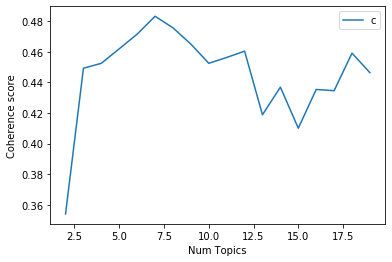

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Figure our hyper parameters using logging
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                       passes = 100, random_state = 100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

# Parameters
limit=20; start=2; step=1;

# Warning: This cell takes a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=dic, 
                                                        corpus=corpus, texts=text, 
                                                        start=start, limit=limit, step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x,coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### visualize topic-word distribution

In [29]:
text = df['tokenized']

In [30]:
lda_model = model_list[15] # optimal model - filling the number according to elbow plot
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dic)
vis

2020-05-10 03:18:16,472 : INFO : NumExpr defaulting to 4 threads.
//anaconda3/envs/metis/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.054503 -0.155960       1        1  18.317766
12    -0.077035 -0.060716       2        1  12.376431
9     -0.075105 -0.100889       3        1  11.614667
2     -0.084586  0.078129       4        1   8.978611
3     -0.131358  0.092246       5        1   8.713294
5     -0.076259 -0.003702       6        1   8.687838
8     -0.086001  0.097421       7        1   4.876656
15    -0.093232  0.182766       8        1   4.605068
1     -0.028556 -0.149688       9        1   4.597861
10     0.062800 -0.133760      10        1   4.015675
4     -0.018097 -0.156089      11        1   2.990764
7      0.221195 -0.067548      12        1   2.528151
13    -0.024202  0.069625      13        1   2.395564
6     -0.028098  0.017949      14        1   1.915793
16     0.122473  0.043074      15        1   1.581506
14     0.033361  0.154930      16        1   1.4830

### print out lda models??

### Generating dominant topic for each document

In [33]:
#have to reset index otherwise there's problem concatenating 
contents.reset_index(drop=True, inplace=True)

NameError: name 'contents' is not defined

In [34]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis = 1)
    return(sent_topics_df)

df_topic_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=text)

ValueError: Shape of passed values is (2668, 4), indices imply (2244, 4)

In [ ]:
#again, there are duplicates in the index. have to reset. 
count_df.reset_index(drop=True, inplace=True)

In [ ]:
# Format
df_dominant_topic = df_topic_keywords.reset_index()
df_dominant_topic.columns = ['date', 'Dominant_Topic', 'Topic_Perc_Contrib','keywords', 'text']
df_dominant_topic.date = count_df['new_date']

# Show
df_dominant_topic.head()

### top 10 words for each topic

In [164]:
df_topics_keyword_sorted = pd.DataFrame()

df_topics_keyword_sorted_grouped = df_topic_keywords.groupby('Dominant_Topic')

for i, grp in df_topics_keyword_sorted_grouped:
    df_topics_keyword_sorted = pd.concat([df_topics_keyword_sorted, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
df_topics_keyword_sorted.reset_index(drop=True, inplace=True)

# Format
df_topics_keyword_sorted.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
df_topics_keyword_sorted.head()

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.8850   
1        1.0              0.9933   
2        2.0              0.9930   
3        3.0              0.9883   
4        4.0              0.9919   

                                            Keywords  \
0  sony, year, album, universal, group, global, r...   
1  company, president, global, group, team, execu...   
2  songs, songwriters, publishing, catalog, songw...   
3  label, artist, records, company, team, group, ...   
4  spotify, streaming, company, year, service, ma...   

                                                Text  
0  [taylor, swift, officially, record, internatio...  
1  [independent, publishing, company, spirit, gro...  
2  [hipgnosis, songs, fund, acquired, catalog, so...  
3  [francisco, based, independent, label, distrib...  
4  [industry, streaming, wars, taught, universiti...

### Document-topic matrix

In [35]:
temp_list = [] # A temp variable for us to form a dataframe

for x in range(df_dominant_topic.shape[0]): # For all the documents
    new_doc = text[x] # Get the content of document (already preprocessed)
    new_doc_bow = dic.doc2bow(new_doc) # Form a BOW
    temp = lda_model.get_document_topics(new_doc_bow, minimum_probability=0.0) # Get the doc-topic dist
    temp_list.append([round(n,5) for _, n in temp]) # Add in all the probabilities

# Create Dataframe for our probabilities
doc_topic_df_prob = pd.DataFrame(temp_list)

# Get a copy of the original table containing document and their contents
df_original_copy = df_dominant_topic

# Merge the 2 dataframe together
doc_topic_table = pd.concat([df_original_copy, doc_topic_df_prob], axis=1)

# Remove certain rows for a more concise table
doc_topic_table = doc_topic_table[[col for col in doc_topic_table.columns if col not in 
                                       ['Dominant_Topic','Topic_Perc_Contrib','title']]]
# Renaming columns
doc_topic_table.rename(columns={0: "Topic 1", 1: "Topic 2", 2: "Topic 3", 3: "Topic 4", 4: "Topic 5", 5: "Topic 6", 6: "Topic 7", 7: "Topic 8", 8: "Topic 9"},
                       inplace=True)
# sort by date ascending 
doc_topic_table = doc_topic_table.sort_values('date')

NameError: name 'df_dominant_topic' is not defined

In [171]:
#display table
doc_topic_table

date                                           keywords  \
450  2018-11  live, fans, youtube, industry, platform, video...   
451  2018-11  spotify, streaming, company, year, service, ma...   
452  2018-11  spotify, streaming, company, year, service, ma...   
453  2018-11  people, like, going, time, think, want, work, ...   
454  2018-11  company, president, global, group, team, execu...   
..       ...                                                ...   
299  2020-03  spotify, streaming, company, year, service, ma...   
300  2020-03  spotify, streaming, company, year, service, ma...   
301  2020-03  sony, year, album, universal, group, global, r...   
303  2020-03  spotify, streaming, company, year, service, ma...   
302  2020-03  sony, year, album, universal, group, global, r...   

                                                  text  Topic 1  Topic 2  \
450  [expanded, global, live, events, acquisition, ...  0.00214  0.12575   
451  [leading, industry, information, platform, wor...  0.00139  0.02604   
452  [population, nordics, stream, premium, subscri...  0.00198  0.00198   
453  [question, highest, grossing, entertainment, w...  0.11721  0.20475   
454  [trent, tappe, maryrose, maness, promoted, rol...  0.00132  0.81680   
..                                                 ...      ...      ...   
299  [amuse, fast, recognizable, names, independent...  0.00059  0.00059   
300  [warner, group, supposed, start, kicking, week...  0.29741  0.00154   
301  [sony, publishing, inked, publishing, deal, si...  0.44676  0.00141   
303  [review, offers, biggest, recent, goings, time...  0.00043  0.00043   
302  [knew, universal, group, revealed, week, firm,...  0.45727  0.09308   

     Topic 3  Topic 4  Topic 5  Topic 6  Topic 7  Topic 8  Topic 9  
450  0.00214  0.24810  0.00214  0.03685  0.00214  0.57861  0.00214  
451  0.00139  0.22663  0.28442  0.15744  0.03417  0.26714  0.00139  
452  0.00199  0.00198  0.90934  0.00199  0.07676  0.00199  0.00198  
453  0.00060  0.19006  0.11861  0.00060  0.20534  0.16223  0.00060  
454  0.00132  0.00132  0.00132  0.00132  0.00132  0.06912  0.10614  
..       ...      ...      ...      ...      ...      ...      ...  
299  0.03737  0.22243  0.35159  0.05892  0.00059  0.12409  0.20384  
300  0.00154  0.00154  0.50126  0.00154  0.00154  0.00154  0.19207  
301  0.24357  0.21981  0.00141  0.00141  0.00141  0.08283  0.00141  
303  0.00043  0.00043  0.82971  0.00043  0.00043  0.00043  0.16726  
302  0.17139  0.00096  0.07703  0.00096  0.04305  0.00096  0.15531  

[2244 rows x 12 columns]

### topic over time plot

In [36]:
order = [i for i in df_topics_keyword_sorted.Keywords]
order

NameError: name 'df_topics_keyword_sorted' is not defined

In [174]:
list_of_docs = []
for i in range(1,10):
    temp = doc_topic_table[['date','keywords','Topic %s' %i]]
    temp.rename(columns={'Topic %s' %i: "share"}, inplace = True)
    list_of_docs.append(temp)
df = pd.concat(list_of_docs)
df.keywords = [i for i in order for j in range(2244)]
df.rename(columns={'keywords': 'topic_keywords','Document_No': 'date'}, inplace=True)

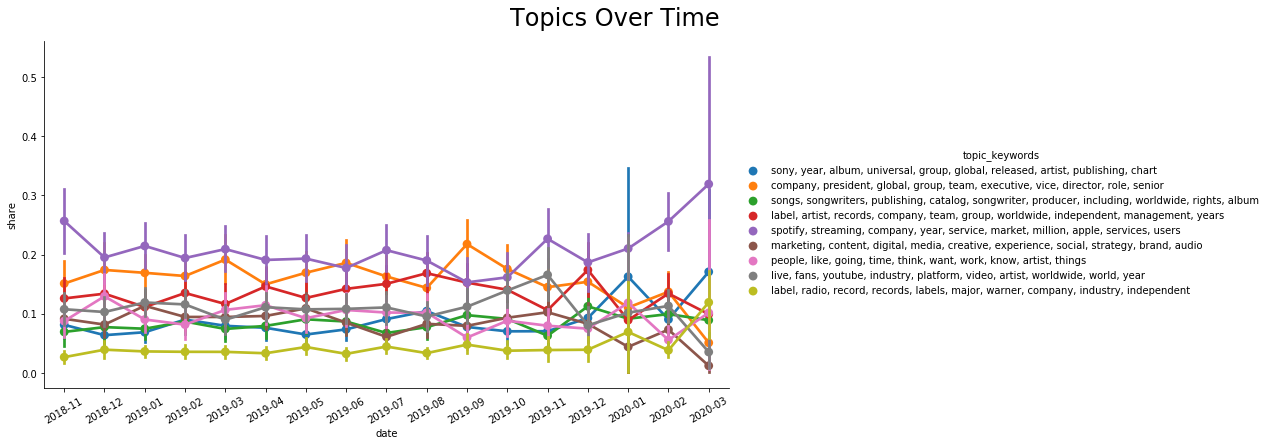

In [175]:
# http://jeriwieringa.com/2017/06/21/Calculating-and-Visualizing-Topic-Significance-over-Time-Part-1/
p = sns.factorplot(x="date", y='share', kind='point', hue_order=order, hue='topic_keywords',size=6, aspect=1.8, data=df)
p.fig.subplots_adjust(top=0.9)
p.fig.suptitle('Topics Over Time', fontsize=24)
p.set_xticklabels(rotation=30)